<a id="home"></a>
# IEEE Fraud Detection transactions columns reference

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import HTML
import warnings
warnings.filterwarnings("ignore")

INPUT_DIR = 'data/'
COLS_TO_SHOW = 150

def h(content):
    display(HTML(content))

def timehist1(col):
    N = 8000 if col in ['TransactionAmt'] else 9999999999999999 # clip trans amount for better view
    tr[tr['isFraud'] == 0].set_index('TransactionDT')[col].clip(0, N).plot(style='.', title='Hist ' + col, figsize=(15, 3))
    tr[tr['isFraud'] == 1].set_index('TransactionDT')[col].clip(0, N).plot(style='.', title='Hist ' + col, figsize=(15, 3))
    te.set_index('TransactionDT')[col].clip(0, N).plot(style='.', title=col + ' values over time (blue=no-fraud, orange=fraud, green=test)', figsize=(15, 3))
    plt.show()
    
def _desc(data, col, label):
    d0 = data.describe().reset_index()
    d0.columns = [col, label]
    return d0.append({col:'unique values', label:data.unique().shape[0]}, ignore_index=True) \
             .append({col:'NaNs', label:data.isnull().sum()}, ignore_index=True) \
             .append({col:'NaNs share', label:np.round(data.isnull().sum() / data.shape[0], 4)}, ignore_index=True) \
    
def desc1(col):
    d0 = _desc(tr[col], col, 'Train')
    d1 = _desc(tr.loc[tr['isFraud'] == 1, col], col, 'Train fraud')
    d2 = _desc(tr.loc[tr['isFraud'] == 0, col], col, 'Train Not fraud')
    d3 = _desc(te[col], col, 'Test')
    n_public = int(te.shape[0] * 0.2)
    d4 = _desc(te.loc[:n_public, col], col, 'Test public')
    d5 = _desc(te.loc[n_public:, col], col, 'Test private')
    dd = d0.merge(d1).merge(d2).merge(d3).merge(d4).merge(d5)
    display(dd)
    
    if col not in ['TransactionID']:
        h('<b>Most popular values (NaN = -999):</b>')
        N = 10
        d0 = tr[['isFraud',col]].fillna(-999).groupby(col)['isFraud'].agg(['size','mean','sum']).reset_index().sort_values('size', ascending=False).reset_index(drop=True)
        d1 = te[['TransactionID',col]].fillna(-999).groupby(col)['TransactionID'].count().reset_index()
        dd = d0.merge(d1, how='left', on=col).head(N)
        dd = dd.rename({'size':'Count in train (desc)','mean':'Mean target','sum':'Sum target','TransactionID':'Count in test'}, axis=1)
        display(dd)

        h('<b>Biggest fraud sum values in train (NaN = -999):</b>')
        dd = d0.sort_values('sum', ascending=False).reset_index(drop=True).head(N).merge(d1, how='left', on=col)
        dd = dd.rename({'size':'Count in train','mean':'Mean target','sum':'Sum target (desc)','TransactionID':'Count in test'}, axis=1)
        display(dd)

def hist1(col):
    plt.figure(figsize=(15, 3))
    plt.subplot(121)
    plt.hist(tr[col], bins=70);
    plt.title('Train histogram: ' + col);
    plt.subplot(122)
    plt.hist(te[col], bins=70);
    plt.title('Test histogram: ' + col);
    plt.show()

def corr1(col):
    N = None #10000
    num_vars = [f for f in tr.columns if tr[f].dtype != 'object']
    trx = tr.head(N) if N is not None else tr.copy()
    corrs = trx[num_vars].corrwith(trx[col]).reset_index().sort_values(0, ascending=False).reset_index(drop=True).rename({'index':'Column',0:'Correlation with ' + col}, axis=1)
    h('<b>Most correlated values with ' + col + ':</b>')
    trx = pd.concat([corrs.head(6), corrs.dropna().tail(5)])
    def linkx(val):
        return '<a href="#c_{}">{}</a>'.format(val, val) if val in included_cols else val
    trx['Column'] = trx['Column'].apply(linkx)
    h(trx.to_html(escape=False))
    
def numeric(col):
    timehist1(col)
    hist1(col)
    desc1(col)
    corr1(col) 
    
def categorical(col):
    desc1(col)

def proc(col):
    if col not in ['isFraud','TransactionDT']:
        h('<h3 id="c_' + col + '">' + col + '</h3>' + '<a style="font-size:11px" href="#home">(Jump to top)</a>')
        categorical(col) if tr[col].dtype == 'object' else numeric(col)
        
tr = pd.read_csv(INPUT_DIR + 'train_transaction.csv')
te = pd.read_csv(INPUT_DIR + 'test_transaction.csv')
trid = pd.read_csv(INPUT_DIR + 'train_identity.csv')
teid = pd.read_csv(INPUT_DIR + 'test_identity.csv')

included_cols = list(tr.columns.values[:COLS_TO_SHOW])
split_on = ['TransactionID','card1','addr1','C1','D1','M1','V1']
h('<b>Links to column info:</b> ' + ', '.join([('<li>' if col in split_on else '') + '<a href="#c_' + col + '">' + col + '</a>' for col in included_cols]))
h('Train transactions shape: <b>' + str(tr.shape) + '</b>, identity <b>' + str(trid.shape) + '</b>' + 
  '<br>Test transactions shape: <b>' + str(te.shape) + '</b>, identity <b>' + str(teid.shape) + '</b>')
h('Train transactions preview:')
display(tr.head(10))

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   
5        2987005        0          86510            49.0         W   5937   
6        2987006        0          86522           159.0         W  12308   
7        2987007        0          86529           422.5         W  12695   
8        2987008        0          86535            15.0         H   2803   
9        2987009        0          86536           117.0         W  17399   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
1  404.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
2  490.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
3  567.0  150.0  mastercard  117.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
4  514.0  150.0  mastercard  102.0  ...  0.0   0.0   0.0   0.0   0.0  0.0   
5  555.0  150.0        visa  226.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
6  360.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
7  490.0  150.0        visa  226.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
8  100.0  150.0        visa  226.0  ...  0.0   0.0   0.0   0.0   0.0  0.0   
9  111.0  150.0  mastercard  224.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   

  V336  V337  V338  V339  
0  NaN   NaN   NaN   NaN  
1  NaN   NaN   NaN   NaN  
2  NaN   NaN   NaN   NaN  
3  NaN   NaN   NaN   NaN  
4  0.0   0.0   0.0   0.0  
5  NaN   NaN   NaN   NaN  
6  NaN   NaN   NaN   NaN  
7  NaN   NaN   NaN   NaN  
8  0.0   0.0   0.0   0.0  
9  NaN   NaN   NaN   NaN  

[10 rows x 394 columns]

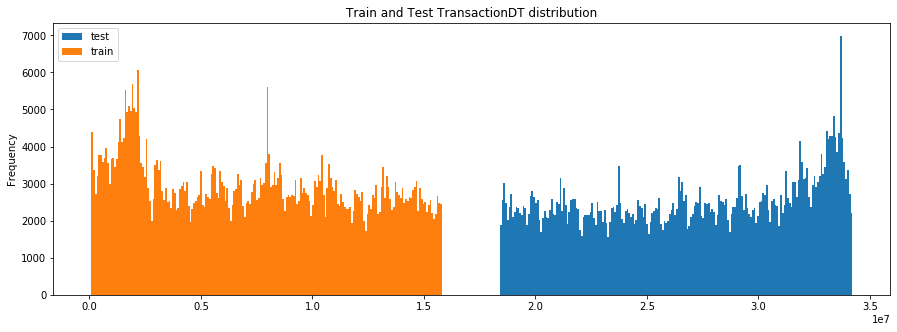

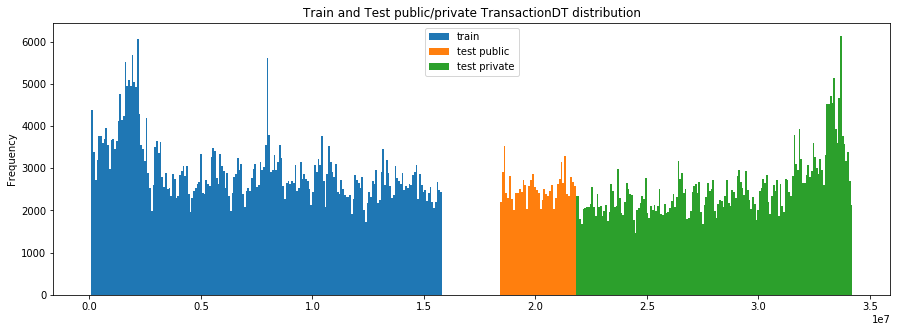

In [2]:
COL = 'TransactionDT'
h('<h2 id="c_' + COL + '">' + COL + '</h2>' + '<a style="font-size:11px" href="#home">(Jump to top)</a>')

te['TransactionDT'].plot(kind='hist', figsize=(15, 5), label='test', bins=200, title='Train and Test TransactionDT distribution')
tr['TransactionDT'].plot(kind='hist', label='train', bins=200)
plt.legend()
plt.show()
tr['TransactionDT'].plot(kind='hist', figsize=(15, 5), label='train', bins=200, title='Train and Test public/private TransactionDT distribution')
n_public = int(te.shape[0] * 0.2)
te.loc[:n_public, 'TransactionDT'].plot(kind='hist', label='test public', bins=40)
te.loc[n_public:, 'TransactionDT'].plot(kind='hist', label='test private', bins=160)
plt.legend()
plt.show()
corr1(COL)

In [3]:
COL = 'isFraud'
h('<h2 id="c_' + COL + '">' + COL + '</h2>' + '<a style="font-size:11px" href="#home">(Jump to top)</a>')
h('This is target column.')
trx = tr['isFraud'].value_counts().reset_index().rename({'index':'Value','isFraud':'Count'}, axis=1)
trx['Share'] = np.round(trx['Count'] / trx['Count'].sum(), 6)
display(trx)
corr1(COL)

Value   Count    Share
0      0  569877  0.96501
1      1   20663  0.03499

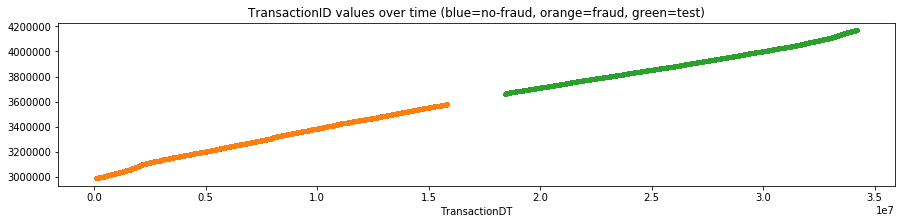

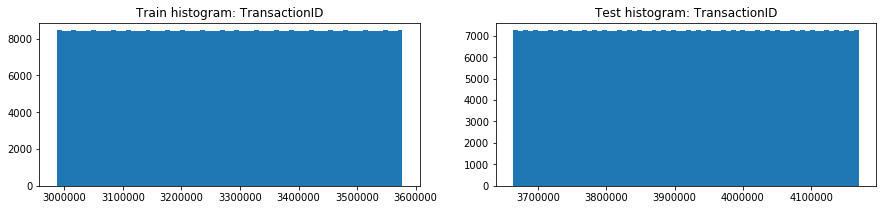

TransactionID         Train   Train fraud  Train Not fraud          Test  \
0           count  5.905400e+05  2.066300e+04     5.698770e+05  5.066910e+05   
1            mean  3.282270e+06  3.294952e+06     3.281810e+06  3.916894e+06   
2             std  1.704744e+05  1.620403e+05     1.707548e+05  1.462692e+05   
3             min  2.987000e+06  2.987203e+06     2.987000e+06  3.663549e+06   
4             25%  3.134635e+06  3.167366e+06     3.133317e+06  3.790222e+06   
5             50%  3.282270e+06  3.291934e+06     3.281808e+06  3.916894e+06   
6             75%  3.429904e+06  3.428646e+06     3.429974e+06  4.043566e+06   
7             max  3.577539e+06  3.577526e+06     3.577539e+06  4.170239e+06   
8   unique values  5.905400e+05  2.066300e+04     5.698770e+05  5.066910e+05   
9            NaNs  0.000000e+00  0.000000e+00     0.000000e+00  0.000000e+00   
10     NaNs share  0.000000e+00  0.000000e+00     0.000000e+00  0.000000e+00   

     Test public  Test private  
0   1.013390e+05  4.053530e+05  
1   3.714218e+06  3.967563e+06  
2   2.925419e+04  1.170155e+05  
3   3.663549e+06  3.764887e+06  
4   3.688884e+06  3.866225e+06  
5   3.714218e+06  3.967563e+06  
6   3.739552e+06  4.068901e+06  
7   3.764887e+06  4.170239e+06  
8   1.013390e+05  4.053530e+05  
9   0.000000e+00  0.000000e+00  
10  0.000000e+00  0.000000e+00

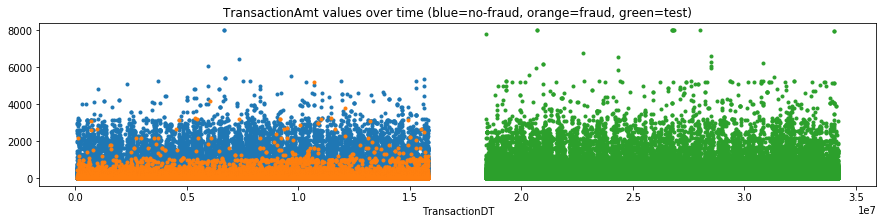

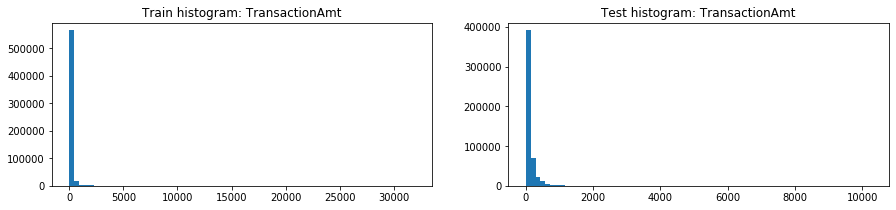

TransactionAmt          Train   Train fraud  Train Not fraud  \
0           count  590540.000000  20663.000000    569877.000000   
1            mean     135.027176    149.244779       134.511665   
2             std     239.162522    232.212163       239.395078   
3             min       0.251000      0.292000         0.251000   
4             25%      43.321000     35.044000        43.970000   
5             50%      68.769000     75.000000        68.500000   
6             75%     125.000000    161.000000       120.000000   
7             max   31937.391000   5191.000000     31937.391000   
8   unique values   20902.000000   2515.000000     20560.000000   
9            NaNs       0.000000      0.000000         0.000000   
10     NaNs share       0.000000      0.000000         0.000000   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1      134.725568     141.732271     132.973690  
2      245.779822     257.473804     242.736757  
3        0.018000       0.018000       0.140000  
4       40.000000      45.950000      39.000000  
5       67.950000      72.950000      67.950000  
6      125.000000     134.950000     120.950000  
7    10270.000000    9154.460000   10270.000000  
8    14119.000000    5144.000000   12117.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

TransactionAmt  Count in train (desc)  Mean target  Sum target  \
0           59.00                  30582     0.021124         646   
1          117.00                  28933     0.024851         719   
2          107.95                  23954     0.009226         221   
3           57.95                  23600     0.003814          90   
4          100.00                  20362     0.025685         523   
5           50.00                  17009     0.020754         353   
6           49.00                  15990     0.029331         469   
7          226.00                  11704     0.033322         390   
8           39.00                  11095     0.021812         242   
9           29.00                  10683     0.018815         201   

   Count in test  
0        27365.0  
1        25798.0  
2        20243.0  
3        20063.0  
4        17565.0  
5        14469.0  
6        14231.0  
7        11084.0  
8         9926.0  
9         9019.0

TransactionAmt  Count in train  Mean target  Sum target (desc)  \
0           117.0           28933     0.024851                719   
1            59.0           30582     0.021124                646   
2           150.0            8356     0.067137                561   
3           100.0           20362     0.025685                523   
4            49.0           15990     0.029331                469   
5           200.0            6590     0.064188                423   
6           226.0           11704     0.033322                390   
7           300.0            2438     0.145611                355   
8            50.0           17009     0.020754                353   
9           171.0            7682     0.035407                272   

   Count in test  
0          25798  
1          27365  
2           7426  
3          17565  
4          14231  
5           6115  
6          11084  
7           2104  
8          14469  
9           7233

ProductCD   Train Train fraud Train Not fraud    Test Test public  \
0          count  590540       20663          569877  506691      101339   
1         unique       5           5               5       5           5   
2            top       W           W               W       W           W   
3           freq  439670        8969          430701  360987       82563   
4  unique values       5           5               5       5           5   
5           NaNs       0           0               0       0           0   
6     NaNs share       0           0               0       0           0   

  Test private  
0       405353  
1            5  
2            W  
3       278425  
4            5  
5            0  
6            0

ProductCD  Count in train (desc)  Mean target  Sum target  Count in test
0         W                 439670     0.020399        8969         360987
1         C                  68519     0.116873        8008          69266
2         R                  37699     0.037826        1426          35647
3         H                  33024     0.047662        1574          29373
4         S                  11628     0.058996         686          11418

ProductCD  Count in train  Mean target  Sum target (desc)  Count in test
0         W          439670     0.020399               8969         360987
1         C           68519     0.116873               8008          69266
2         H           33024     0.047662               1574          29373
3         R           37699     0.037826               1426          35647
4         S           11628     0.058996                686          11418

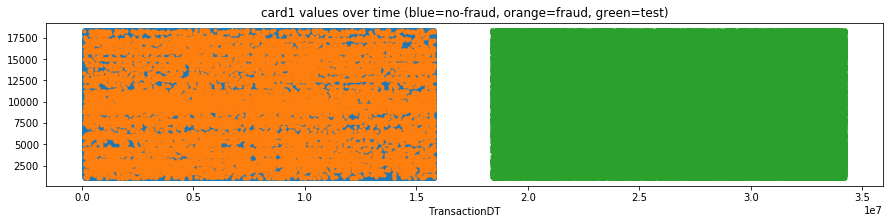

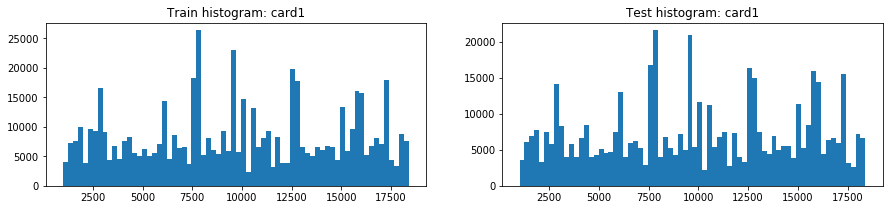

card1          Train   Train fraud  Train Not fraud  \
0           count  590540.000000  20663.000000    569877.000000   
1            mean    9898.734658   9547.654164      9911.464381   
2             std    4901.170153   4762.051380      4905.672370   
3             min    1000.000000   1015.000000      1000.000000   
4             25%    6019.000000   5732.500000      6019.000000   
5             50%    9678.000000   9633.000000      9711.000000   
6             75%   14184.000000  13623.000000     14229.000000   
7             max   18396.000000  18375.000000     18396.000000   
8   unique values   13553.000000   1740.000000     13350.000000   
9            NaNs       0.000000      0.000000         0.000000   
10     NaNs share       0.000000      0.000000         0.000000   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1     9957.222175    9907.330406    9969.701591  
2     4884.960969    4854.917514    4892.365179  
3     1001.000000    1006.000000    1001.000000  
4     6019.000000    6053.000000    6019.000000  
5     9803.000000    9653.000000    9803.000000  
6    14276.000000   14052.000000   14290.000000  
7    18397.000000   18396.000000   18397.000000  
8    13244.000000    6935.000000   12300.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

card1  Count in train (desc)  Mean target  Sum target  Count in test
0   7919                  14932     0.007501         112        13083.0
1   9500                  14162     0.037283         528        12081.0
2  15885                  10361     0.042853         444        12330.0
3  17188                  10344     0.026875         278         9262.0
4  15066                   7945     0.039396         313         6661.0
5  12695                   7091     0.028346         201         5641.0
6  12544                   6773     0.021556         146         5921.0
7   6019                   6771     0.043420         294         6497.0
8   2803                   6141     0.011887          73         4902.0
9   7585                   5334     0.049306         263         4763.0

card1  Count in train  Mean target  Sum target (desc)  Count in test
0   9633            4158     0.178451                742           4751
1   9500           14162     0.037283                528          12081
2  15885           10361     0.042853                444          12330
3   9026            2076     0.191233                397            894
4  15063            2522     0.126487                319           2060
5   5812            2818     0.111427                314           3879
6   2616            4410     0.071202                314           1786
7  15066            7945     0.039396                313           6661
8   9917             919     0.332971                306            920
9   6019            6771     0.043420                294           6497

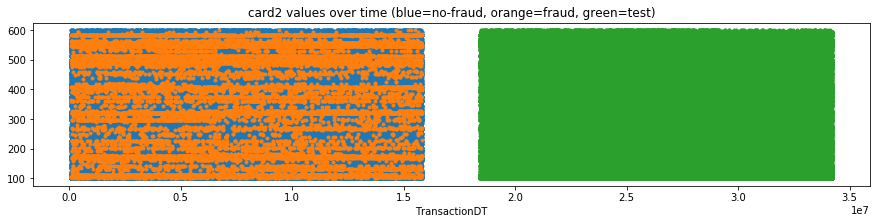

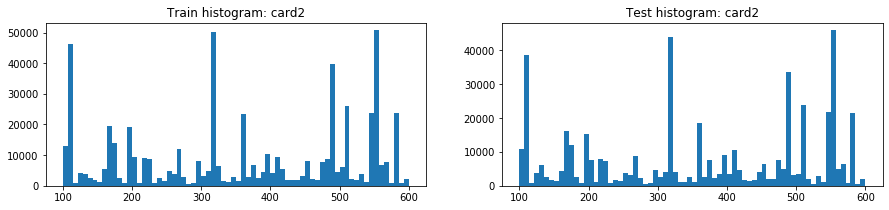

card2          Train   Train fraud  Train Not fraud  \
0           count  581607.000000  20240.000000    561367.000000   
1            mean     362.555488    365.370850       362.453981   
2             std     157.793246    159.623511       157.726065   
3             min     100.000000    100.000000       100.000000   
4             25%     214.000000    204.000000       215.000000   
5             50%     361.000000    375.000000       361.000000   
6             75%     512.000000    514.000000       512.000000   
7             max     600.000000    600.000000       600.000000   
8   unique values     501.000000    328.000000       501.000000   
9            NaNs    8933.000000    423.000000      8510.000000   
10     NaNs share       0.015100      0.020500         0.014900   

             Test   Test public   Test private  
0   498037.000000  99008.000000  399030.000000  
1      363.735379    358.809076     364.957595  
2      158.688653    157.772855     158.891431  
3      100.000000    100.000000     100.000000  
4      207.000000    204.000000     214.000000  
5      369.000000    360.000000     375.000000  
6      512.000000    512.000000     514.000000  
7      600.000000    600.000000     600.000000  
8      498.000000    497.000000     497.000000  
9     8654.000000   2331.000000    6323.000000  
10       0.017100      0.023000       0.015600

card2  Count in train (desc)  Mean target  Sum target  Count in test
0  321.0                  48935     0.028528        1396        42796.0
1  111.0                  45191     0.021641         978        37346.0
2  555.0                  41995     0.022836         959        38409.0
3  490.0                  38145     0.024014         916        32351.0
4  583.0                  21803     0.041233         899        19700.0
5  170.0                  18214     0.031295         570        15197.0
6  194.0                  16938     0.007675         130        14573.0
7  545.0                  16355     0.086824        1420        15539.0
8  360.0                  15190     0.010402         158        11342.0
9  514.0                  14541     0.046214         672        12684.0

card2  Count in train  Mean target  Sum target (desc)  Count in test
0  545.0           16355     0.086824               1420          15539
1  321.0           48935     0.028528               1396          42796
2  111.0           45191     0.021641                978          37346
3  555.0           41995     0.022836                959          38409
4  490.0           38145     0.024014                916          32351
5  500.0            5045     0.180575                911           2430
6  583.0           21803     0.041233                899          19700
7  408.0            8012     0.083999                673           9148
8  514.0           14541     0.046214                672          12684
9  130.0            2746     0.239257                657           5395

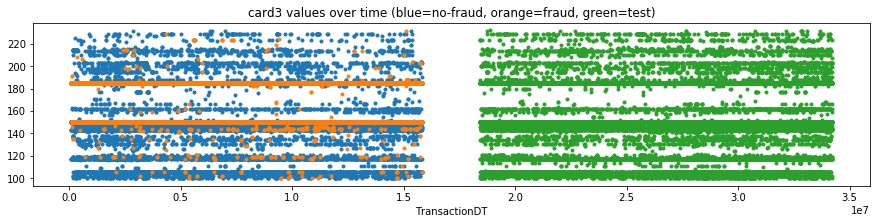

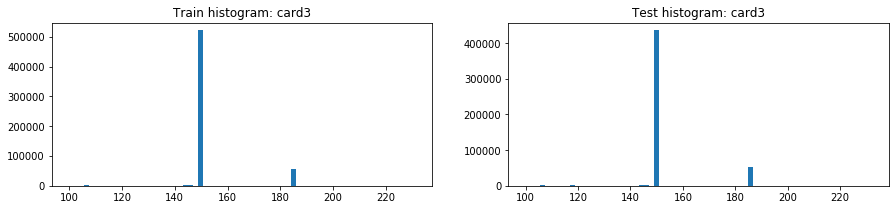

card3          Train   Train fraud  Train Not fraud  \
0           count  588975.000000  20624.000000    568351.000000   
1            mean     153.194925    162.368648       152.862034   
2             std      11.336444     17.495775        10.904432   
3             min     100.000000    100.000000       100.000000   
4             25%     150.000000    150.000000       150.000000   
5             50%     150.000000    150.000000       150.000000   
6             75%     150.000000    185.000000       150.000000   
7             max     231.000000    231.000000       231.000000   
8   unique values     115.000000     63.000000       107.000000   
9            NaNs    1565.000000     39.000000      1526.000000   
10     NaNs share       0.002700      0.001900         0.002700   

             Test    Test public   Test private  
0   503689.000000  100033.000000  403657.000000  
1      153.543409     152.127938     153.894177  
2       12.443013      10.591923      12.836503  
3      100.000000     100.000000     100.000000  
4      150.000000     150.000000     150.000000  
5      150.000000     150.000000     150.000000  
6      150.000000     150.000000     150.000000  
7      232.000000     232.000000     231.000000  
8      116.000000      75.000000     111.000000  
9     3002.000000    1306.000000    1696.000000  
10       0.005900       0.012900       0.004200

card3  Count in train (desc)  Mean target  Sum target  Count in test
0  150.0                 521287     0.024568       12807       435558.0
1  185.0                  56346     0.130657        7362        53614.0
2  106.0                   1571     0.015277          24         1972.0
3 -999.0                   1565     0.024920          39         3002.0
4  146.0                   1252     0.019968          25         1218.0
5  144.0                   1252     0.089457         112         1381.0
6  117.0                    962     0.018711          18         1879.0
7  143.0                    899     0.031146          28          771.0
8  119.0                    750     0.093333          70          341.0
9  102.0                    460     0.023913          11          738.0

card3  Count in train  Mean target  Sum target (desc)  Count in test
0  150.0          521287     0.024568              12807         435558
1  185.0           56346     0.130657               7362          53614
2  144.0            1252     0.089457                112           1381
3  119.0             750     0.093333                 70            341
4 -999.0            1565     0.024920                 39           3002
5  143.0             899     0.031146                 28            771
6  146.0            1252     0.019968                 25           1218
7  106.0            1571     0.015277                 24           1972
8  117.0             962     0.018711                 18           1879
9  223.0              55     0.254545                 14            126

card4   Train Train fraud Train Not fraud    Test Test public  \
0          count  588963       20622          568341  503605       99996   
1         unique       4           4               4       4           4   
2            top    visa        visa            visa    visa        visa   
3           freq  384767       13373          371394  334882       66078   
4  unique values       5           5               5       5           5   
5           NaNs    1577          41            1536    3086        1343   
6     NaNs share  0.0027       0.002          0.0027  0.0061      0.0133   

  Test private  
0       403610  
1            4  
2         visa  
3       268805  
4            5  
5         1743  
6       0.0043

card4  Count in train (desc)  Mean target  Sum target  \
0              visa                 384767     0.034756       13373   
1        mastercard                 189217     0.034331        6496   
2  american express                   8328     0.028698         239   
3          discover                   6651     0.077282         514   
4              -999                   1577     0.025999          41   

   Count in test  
0         334882  
1         158169  
2           7681  
3           2873  
4           3086

card4  Count in train  Mean target  Sum target (desc)  \
0              visa          384767     0.034756              13373   
1        mastercard          189217     0.034331               6496   
2          discover            6651     0.077282                514   
3  american express            8328     0.028698                239   
4              -999            1577     0.025999                 41   

   Count in test  
0         334882  
1         158169  
2           2873  
3           7681  
4           3086

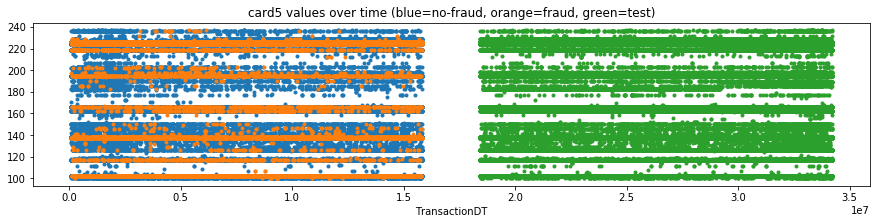

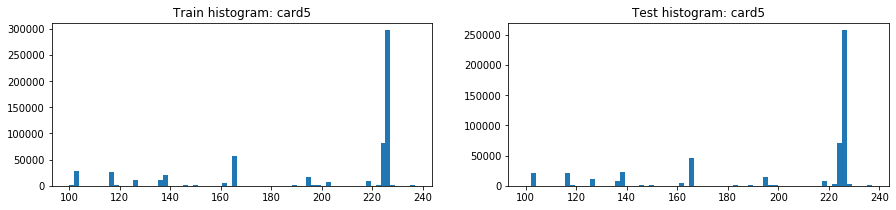

card5          Train   Train fraud  Train Not fraud  \
0           count  586281.000000  20453.000000    565828.000000   
1            mean     199.278897    191.994328       199.542212   
2             std      41.244453     45.779886        41.046975   
3             min     100.000000    100.000000       100.000000   
4             25%     166.000000    138.000000       166.000000   
5             50%     226.000000    224.000000       226.000000   
6             75%     226.000000    226.000000       226.000000   
7             max     237.000000    237.000000       237.000000   
8   unique values     120.000000     50.000000       119.000000   
9            NaNs    4259.000000    210.000000      4049.000000   
10     NaNs share       0.007200      0.010200         0.007100   

             Test   Test public   Test private  
0   502144.000000  99816.000000  402329.000000  
1      200.162975    200.406638     200.102588  
2       40.562461     40.584474      40.556792  
3      100.000000    100.000000     100.000000  
4      166.000000    166.000000     166.000000  
5      226.000000    226.000000     226.000000  
6      226.000000    226.000000     226.000000  
7      237.000000    237.000000     237.000000  
8      103.000000     70.000000      97.000000  
9     4547.000000   1523.000000    3024.000000  
10       0.009000      0.015000       0.007500

card5  Count in train (desc)  Mean target  Sum target  Count in test
0  226.0                 296546     0.029516        8753       256991.0
1  224.0                  81513     0.038669        3152        71596.0
2  166.0                  57140     0.011026         630        45790.0
3  102.0                  29105     0.062945        1832        20386.0
4  117.0                  25941     0.013646         354        21120.0
5  138.0                  19737     0.085221        1682        22102.0
6  195.0                  16945     0.040189         681        14951.0
7  137.0                  11720     0.147184        1725         7730.0
8  126.0                  10298     0.010196         105        11439.0
9  219.0                   9924     0.057537         571         8402.0

card5  Count in train  Mean target  Sum target (desc)  Count in test
0  226.0          296546     0.029516               8753         256991
1  224.0           81513     0.038669               3152          71596
2  102.0           29105     0.062945               1832          20386
3  137.0           11720     0.147184               1725           7730
4  138.0           19737     0.085221               1682          22102
5  195.0           16945     0.040189                681          14951
6  166.0           57140     0.011026                630          45790
7  219.0            9924     0.057537                571           8402
8  117.0           25941     0.013646                354          21120
9  162.0            4524     0.066534                301           4512

card6   Train Train fraud Train Not fraud    Test Test public  \
0          count  588969       20624          568345  503684      100033   
1         unique       4           2               4       3           2   
2            top   debit       debit           debit   debit       debit   
3           freq  439938       10674          429264  385021       78402   
4  unique values       5           3               5       4           3   
5           NaNs    1571          39            1532    3007        1306   
6     NaNs share  0.0027      0.0019          0.0027  0.0059      0.0129   

  Test private  
0       403652  
1            3  
2        debit  
3       306620  
4            4  
5         1701  
6       0.0042

card6  Count in train (desc)  Mean target  Sum target  \
0            debit                 439938     0.024263       10674   
1           credit                 148986     0.066785        9950   
2             -999                   1571     0.024825          39   
3  debit or credit                     30     0.000000           0   
4      charge card                     15     0.000000           0   

   Count in test  
0       385021.0  
1       118662.0  
2         3007.0  
3            NaN  
4            1.0

card6  Count in train  Mean target  Sum target (desc)  \
0            debit          439938     0.024263              10674   
1           credit          148986     0.066785               9950   
2             -999            1571     0.024825                 39   
3  debit or credit              30     0.000000                  0   
4      charge card              15     0.000000                  0   

   Count in test  
0       385021.0  
1       118662.0  
2         3007.0  
3            NaN  
4            1.0

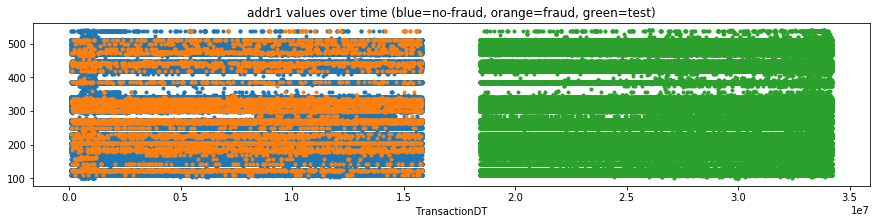

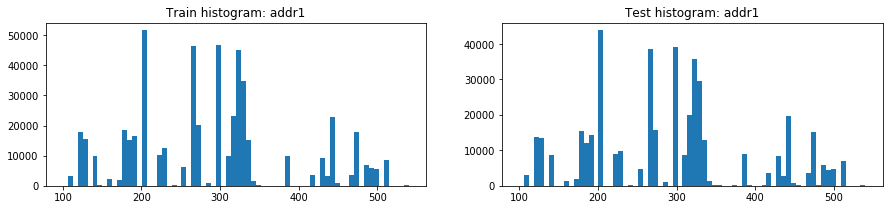

addr1          Train   Train fraud  Train Not fraud  \
0           count  524834.000000  12922.000000    511912.000000   
1            mean     290.733794    294.317134       290.643341   
2             std     101.741072    103.584955       101.692564   
3             min     100.000000    110.000000       100.000000   
4             25%     204.000000    204.000000       204.000000   
5             50%     299.000000    299.000000       299.000000   
6             75%     330.000000    330.000000       330.000000   
7             max     540.000000    536.000000       540.000000   
8   unique values     333.000000     87.000000       333.000000   
9            NaNs   65706.000000   7741.000000     57965.000000   
10     NaNs share       0.111300      0.374600         0.101700   

             Test   Test public   Test private  
0   441082.000000  91556.000000  349527.000000  
1      291.846514    290.515029     292.194978  
2      102.062730    101.350107     102.245872  
3      100.000000    110.000000     100.000000  
4      204.000000    204.000000     204.000000  
5      299.000000    299.000000     299.000000  
6      330.000000    330.000000     330.000000  
7      540.000000    536.000000     540.000000  
8      293.000000     83.000000     289.000000  
9    65609.000000   9783.000000   55826.000000  
10       0.129500      0.096500       0.137700

addr1  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                  65706     0.117813        7741        65609.0
1  299.0                  46335     0.021258         985        38710.0
2  325.0                  42751     0.025426        1087        34151.0
3  204.0                  42020     0.026654        1120        35049.0
4  264.0                  39870     0.018259         728        32710.0
5  330.0                  26287     0.031955         840        22100.0
6  315.0                  23078     0.017809         411        19957.0
7  441.0                  20827     0.025592         533        18063.0
8  272.0                  20141     0.028598         576        15788.0
9  123.0                  16105     0.024713         398        12595.0

addr1  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0           65706     0.117813               7741          65609
1  204.0           42020     0.026654               1120          35049
2  325.0           42751     0.025426               1087          34151
3  299.0           46335     0.021258                985          38710
4  330.0           26287     0.031955                840          22100
5  264.0           39870     0.018259                728          32710
6  272.0           20141     0.028598                576          15788
7  441.0           20827     0.025592                533          18063
8  337.0           15149     0.028979                439          12932
9  315.0           23078     0.017809                411          19957

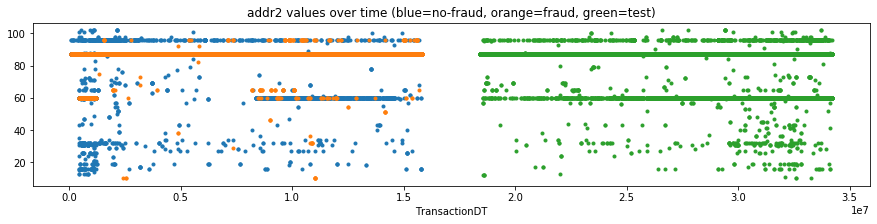

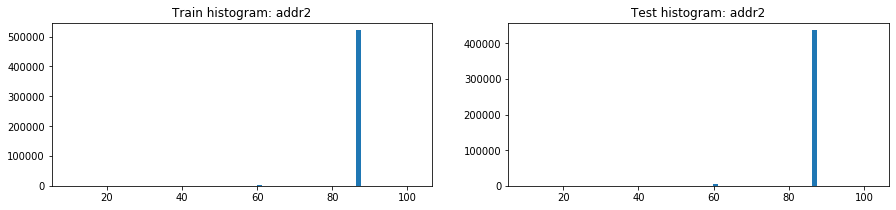

addr2          Train   Train fraud  Train Not fraud  \
0           count  524834.000000  12922.000000    511912.000000   
1            mean      86.800630     86.286024        86.813620   
2             std       2.690623      4.936238         2.607742   
3             min      10.000000     10.000000        13.000000   
4             25%      87.000000     87.000000        87.000000   
5             50%      87.000000     87.000000        87.000000   
6             75%      87.000000     87.000000        87.000000   
7             max     102.000000     96.000000       102.000000   
8   unique values      75.000000     18.000000        69.000000   
9            NaNs   65706.000000   7741.000000     57965.000000   
10     NaNs share       0.111300      0.374600         0.101700   

             Test   Test public   Test private  
0   441082.000000  91556.000000  349527.000000  
1       86.723412     86.964372      86.660295  
2        2.987328      1.217604       3.294569  
3       10.000000     12.000000      10.000000  
4       87.000000     87.000000      87.000000  
5       87.000000     87.000000      87.000000  
6       87.000000     87.000000      87.000000  
7      102.000000     96.000000     102.000000  
8       73.000000     18.000000      72.000000  
9    65609.000000   9783.000000   55826.000000  
10       0.129500      0.096500       0.137700

addr2  Count in train (desc)  Mean target  Sum target  Count in test
0   87.0                 520481     0.023972       12477       435934.0
1 -999.0                  65706     0.117813        7741        65609.0
2   60.0                   3084     0.090467         279         4041.0
3   96.0                    638     0.139498          89          608.0
4   32.0                     91     0.065934           6           61.0
5   65.0                     82     0.536585          44           49.0
6   16.0                     55     0.000000           0           22.0
7   31.0                     47     0.000000           0           36.0
8   19.0                     33     0.000000           0           23.0
9   26.0                     25     0.000000           0            7.0

addr2  Count in train  Mean target  Sum target (desc)  Count in test
0   87.0          520481     0.023972              12477         435934
1 -999.0           65706     0.117813               7741          65609
2   60.0            3084     0.090467                279           4041
3   96.0             638     0.139498                 89            608
4   65.0              82     0.536585                 44             49
5   10.0               8     1.000000                  8              3
6   32.0              91     0.065934                  6             61
7   51.0               4     1.000000                  4              1
8   46.0               3     1.000000                  3              1
9   54.0               6     0.333333                  2             10

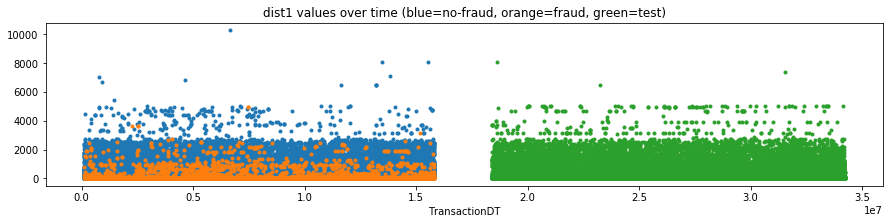

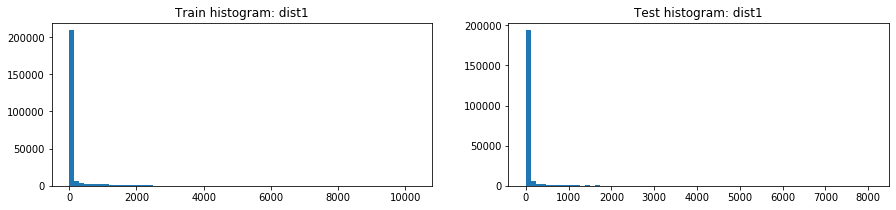

dist1          Train   Train fraud  Train Not fraud  \
0           count  238269.000000   4755.000000    233514.000000   
1            mean     118.502180    174.588854       117.360098   
2             std     371.872026    424.232313       370.641879   
3             min       0.000000      0.000000         0.000000   
4             25%       3.000000      3.000000         3.000000   
5             50%       8.000000     10.000000         8.000000   
6             75%      24.000000     85.500000        24.000000   
7             max   10286.000000   4942.000000     10286.000000   
8   unique values    2652.000000    471.000000      2636.000000   
9            NaNs  352271.000000  15908.000000    336363.000000   
10     NaNs share       0.596500      0.769900         0.590200   

             Test   Test public   Test private  
0   215474.000000  47587.000000  167888.000000  
1       87.065270     92.930464      85.404353  
2      314.131694    332.382991     308.742753  
3        0.000000      0.000000       0.000000  
4        3.000000      3.000000       3.000000  
5        8.000000      8.000000       8.000000  
6       20.000000     20.000000      20.000000  
7     8081.000000   8081.000000    7385.000000  
8     1989.000000   1347.000000    1843.000000  
9   291217.000000  53752.000000  237465.000000  
10       0.574700      0.530400       0.585800

dist1  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 352271     0.045158       15908       291217.0
1    0.0                  19824     0.019169         380        19278.0
2    1.0                  18330     0.027932         512        18025.0
3    2.0                  17028     0.011745         200        15687.0
4    4.0                  13067     0.016454         215        12137.0
5    3.0                  12808     0.011711         150        12333.0
6    5.0                  12004     0.022243         267        11238.0
7    6.0                   9843     0.014630         144         8775.0
8    7.0                   9340     0.014668         137         9210.0
9    8.0                   7731     0.015134         117         7333.0

dist1  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          352271     0.045158              15908         291217
1    1.0           18330     0.027932                512          18025
2    0.0           19824     0.019169                380          19278
3    5.0           12004     0.022243                267          11238
4    4.0           13067     0.016454                215          12137
5    2.0           17028     0.011745                200          15687
6    3.0           12808     0.011711                150          12333
7    9.0            7728     0.018892                146           7608
8    6.0            9843     0.014630                144           8775
9    7.0            9340     0.014668                137           9210

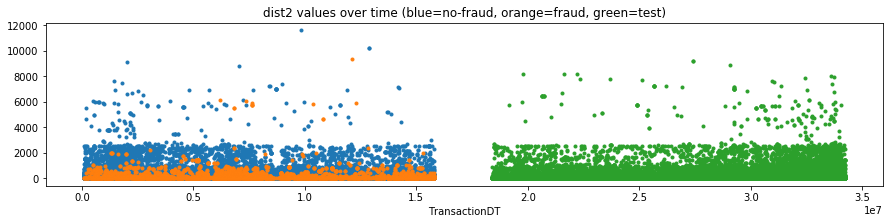

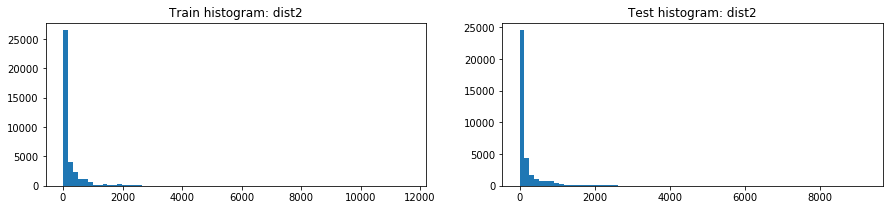

dist2          Train   Train fraud  Train Not fraud  \
0           count   37627.000000   3731.000000     33896.000000   
1            mean     231.855423    201.472259       235.199758   
2             std     529.053494    451.589576       536.798492   
3             min       0.000000      0.000000         0.000000   
4             25%       7.000000      7.000000         7.000000   
5             50%      37.000000     49.000000        36.000000   
6             75%     206.000000    233.000000       206.000000   
7             max   11623.000000   9337.000000     11623.000000   
8   unique values    1752.000000    345.000000      1724.000000   
9            NaNs  552913.000000  16932.000000    535981.000000   
10     NaNs share       0.936300      0.819400         0.940500   

             Test   Test public   Test private  
0    36436.000000   4716.000000   31720.000000  
1      237.175047    233.553223     237.713525  
2      556.450834    555.365698     556.618714  
3        0.000000      0.000000       0.000000  
4        7.000000      7.000000       7.000000  
5       44.000000     50.000000      42.000000  
6      196.000000    190.000000     196.000000  
7     9213.000000   8169.000000    9213.000000  
8     1815.000000    611.000000    1730.000000  
9   470255.000000  96623.000000  373633.000000  
10       0.928100      0.953500       0.921700

dist2  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 552913     0.030623       16932       470255.0
1    7.0                   5687     0.087216         496         2660.0
2    0.0                   3519     0.153453         540         2821.0
3    1.0                   1374     0.139738         192         1565.0
4    9.0                    742     0.148248         110          993.0
5    4.0                    659     0.071320          47          557.0
6    2.0                    556     0.035971          20          805.0
7    3.0                    490     0.077551          38          606.0
8   68.0                    485     0.096907          47          342.0
9    6.0                    412     0.024272          10          497.0

dist2  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          552913     0.030623              16932         470255
1    0.0            3519     0.153453                540           2821
2    7.0            5687     0.087216                496           2660
3    1.0            1374     0.139738                192           1565
4    9.0             742     0.148248                110            993
5   17.0             257     0.276265                 71            367
6  199.0             362     0.193370                 70            138
7   49.0             110     0.509091                 56             74
8  478.0             102     0.539216                 55             25
9  150.0             215     0.237209                 51             43

P_emaildomain      Train Train fraud Train Not fraud       Test  \
0          count     496084       17873          478211     437499   
1         unique         59          42              59         60   
2            top  gmail.com   gmail.com       gmail.com  gmail.com   
3           freq     228355        9943          218412     207448   
4  unique values         60          43              60         61   
5           NaNs      94456        2790           91666      69192   
6     NaNs share     0.1599       0.135          0.1609     0.1366   

  Test public Test private  
0       85891       351609  
1          59           60  
2   gmail.com    gmail.com  
3       41104       166345  
4          60           61  
5       15448        53744  
6      0.1524       0.1326

P_emaildomain  Count in train (desc)  Mean target  Sum target  \
0      gmail.com                 228355     0.043542        9943   
1      yahoo.com                 100934     0.022757        2297   
2           -999                  94456     0.029538        2790   
3    hotmail.com                  45250     0.052950        2396   
4  anonymous.com                  36998     0.023217         859   
5        aol.com                  28289     0.021811         617   
6    comcast.net                   7888     0.031187         246   
7     icloud.com                   6267     0.031434         197   
8    outlook.com                   5096     0.094584         482   
9        msn.com                   4092     0.021994          90   

   Count in test  
0         207448  
1          81850  
2          69192  
3          40399  
4          34064  
5          24048  
6           6586  
7           6049  
8           4838  
9           3388

P_emaildomain  Count in train  Mean target  Sum target (desc)  \
0      gmail.com          228355     0.043542               9943   
1           -999           94456     0.029538               2790   
2    hotmail.com           45250     0.052950               2396   
3      yahoo.com          100934     0.022757               2297   
4  anonymous.com           36998     0.023217                859   
5        aol.com           28289     0.021811                617   
6    outlook.com            5096     0.094584                482   
7    comcast.net            7888     0.031187                246   
8     icloud.com            6267     0.031434                197   
9       mail.com             559     0.189624                106   

   Count in test  
0         207448  
1          69192  
2          40399  
3          81850  
4          34064  
5          24048  
6           4838  
7           6586  
8           6049  
9            597

R_emaildomain      Train Train fraud Train Not fraud       Test  \
0          count     137291       11227          126064     135870   
1         unique         60          32              60         60   
2            top  gmail.com   gmail.com       gmail.com  gmail.com   
3           freq      57147        6811           50336      61738   
4  unique values         61          33              61         61   
5           NaNs     453249        9436          443813     370821   
6     NaNs share     0.7675      0.4567          0.7788     0.7318   

  Test public Test private  
0       18223       117647  
1          57           60  
2   gmail.com    gmail.com  
3        8588        53150  
4          58           61  
5       83116       287706  
6      0.8202       0.7098

R_emaildomain  Count in train (desc)  Mean target  Sum target  \
0           -999                 453249     0.020819        9436   
1      gmail.com                  57147     0.119184        6811   
2    hotmail.com                  27509     0.077793        2140   
3  anonymous.com                  20529     0.029130         598   
4      yahoo.com                  11842     0.051512         610   
5        aol.com                   3701     0.034855         129   
6    outlook.com                   2507     0.165138         414   
7    comcast.net                   1812     0.011589          21   
8   yahoo.com.mx                   1508     0.010610          16   
9     icloud.com                   1398     0.128755         180   

   Count in test  
0         370821  
1          61738  
2          25657  
3          19115  
4           9563  
5           3538  
6           2504  
7           1701  
8           1235  
9           1422

R_emaildomain  Count in train  Mean target  Sum target (desc)  \
0           -999          453249     0.020819               9436   
1      gmail.com           57147     0.119184               6811   
2    hotmail.com           27509     0.077793               2140   
3      yahoo.com           11842     0.051512                610   
4  anonymous.com           20529     0.029130                598   
5    outlook.com            2507     0.165138                414   
6     icloud.com            1398     0.128755                180   
7        aol.com            3701     0.034855                129   
8     outlook.es             433     0.131640                 57   
9       mail.com             122     0.377049                 46   

   Count in test  
0         370821  
1          61738  
2          25657  
3           9563  
4          19115  
5           2504  
6           1422  
7           3538  
8            420  
9            219

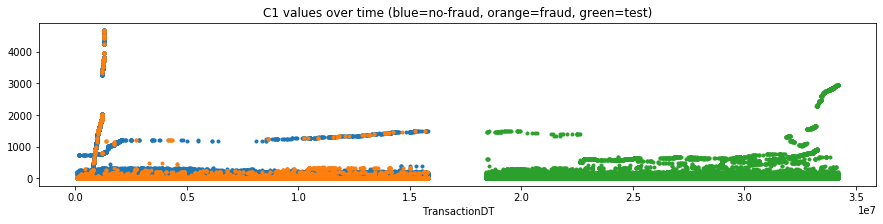

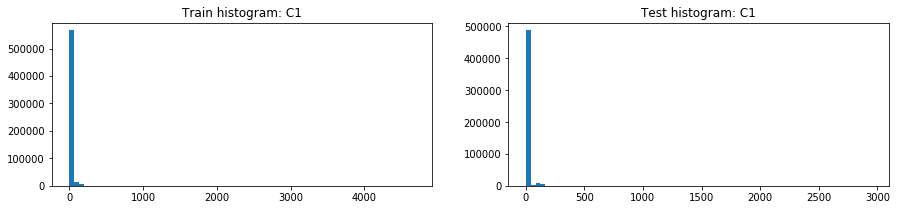

C1          Train  Train fraud  Train Not fraud           Test  \
0           count  590540.000000  20663.00000    569877.000000  506688.000000   
1            mean      14.092458     35.53574        13.314952      10.093211   
2             std     133.569018    242.97626       127.787969      79.334782   
3             min       0.000000      0.00000         0.000000       0.000000   
4             25%       1.000000      1.00000         1.000000       1.000000   
5             50%       1.000000      2.00000         1.000000       1.000000   
6             75%       3.000000      6.00000         3.000000       3.000000   
7             max    4685.000000   4682.00000      4685.000000    2950.000000   
8   unique values    1657.000000    497.00000      1526.000000    1175.000000   
9            NaNs       0.000000      0.00000         0.000000       3.000000   
10     NaNs share       0.000000      0.00000         0.000000       0.000000   

      Test public   Test private  
0   101339.000000  405350.000000  
1        8.408707      10.514326  
2       40.872210      86.307573  
3        0.000000       0.000000  
4        1.000000       1.000000  
5        2.000000       1.000000  
6        3.000000       3.000000  
7     1501.000000    2950.000000  
8      344.000000    1118.000000  
9        0.000000       3.000000  
10       0.000000       0.000000

C1  Count in train (desc)  Mean target  Sum target  Count in test
0   1.0                 316791     0.024230        7676       269951.0
1   2.0                 105071     0.030284        3182        92449.0
2   3.0                  51315     0.035876        1841        45254.0
3   4.0                  28845     0.040596        1171        24949.0
4   5.0                  17922     0.054179         971        14929.0
5   6.0                  10567     0.053658         567         9207.0
6   7.0                   7263     0.058240         423         5721.0
7   8.0                   5072     0.066246         336         3996.0
8   9.0                   3612     0.080011         289         2771.0
9  10.0                   2904     0.091942         267         1969.0

C1  Count in train  Mean target  Sum target (desc)  Count in test
0   1.0          316791     0.024230               7676         269951
1   2.0          105071     0.030284               3182          92449
2   3.0           51315     0.035876               1841          45254
3   4.0           28845     0.040596               1171          24949
4   5.0           17922     0.054179                971          14929
5   6.0           10567     0.053658                567           9207
6   7.0            7263     0.058240                423           5721
7   8.0            5072     0.066246                336           3996
8   9.0            3612     0.080011                289           2771
9  10.0            2904     0.091942                267           1969

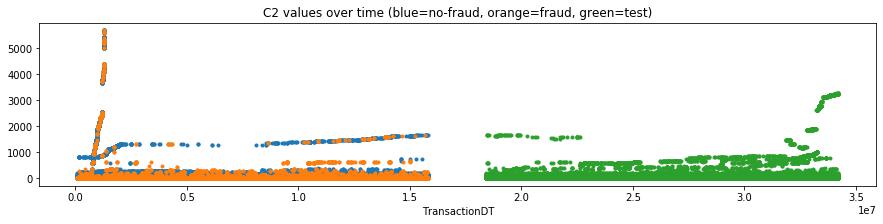

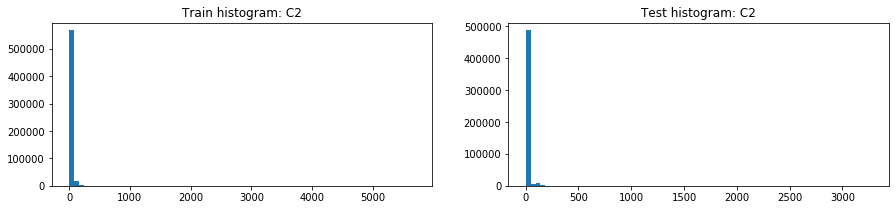

C2          Train   Train fraud  Train Not fraud  \
0           count  590540.000000  20663.000000    569877.000000   
1            mean      15.269734     45.509413        14.173283   
2             std     154.668899    287.813648       147.485925   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      2.000000         1.000000   
6             75%       3.000000      7.000000         3.000000   
7             max    5691.000000   5690.000000      5691.000000   
8   unique values    1216.000000    544.000000      1075.000000   
9            NaNs       0.000000      0.000000         0.000000   
10     NaNs share       0.000000      0.000000         0.000000   

             Test    Test public   Test private  
0   506688.000000  101339.000000  405350.000000  
1       10.714635       8.606923      11.241549  
2       88.896921      44.375338      96.874447  
3        0.000000       0.000000       0.000000  
4        1.000000       1.000000       1.000000  
5        1.000000       2.000000       1.000000  
6        3.000000       3.000000       3.000000  
7     3275.000000    1672.000000    3275.000000  
8     1124.000000     370.000000    1054.000000  
9        3.000000       0.000000       3.000000  
10       0.000000       0.000000       0.000000

C2  Count in train (desc)  Mean target  Sum target  Count in test
0   1.0                 316261     0.023073        7297       265435.0
1   2.0                 103948     0.031978        3324        93084.0
2   3.0                  51770     0.036160        1872        44267.0
3   4.0                  28251     0.050370        1423        24329.0
4   5.0                  16971     0.049496         840        14711.0
5   6.0                  10682     0.049991         534         9662.0
6   7.0                   7382     0.060824         449         6097.0
7   8.0                   5105     0.053477         273         4387.0
8   9.0                   3750     0.058933         221         3364.0
9  10.0                   2797     0.085449         239         2432.0

C2  Count in train  Mean target  Sum target (desc)  Count in test
0   1.0          316261     0.023073               7297         265435
1   2.0          103948     0.031978               3324          93084
2   3.0           51770     0.036160               1872          44267
3   4.0           28251     0.050370               1423          24329
4   5.0           16971     0.049496                840          14711
5   6.0           10682     0.049991                534           9662
6   7.0            7382     0.060824                449           6097
7   8.0            5105     0.053477                273           4387
8  10.0            2797     0.085449                239           2432
9   9.0            3750     0.058933                221           3364

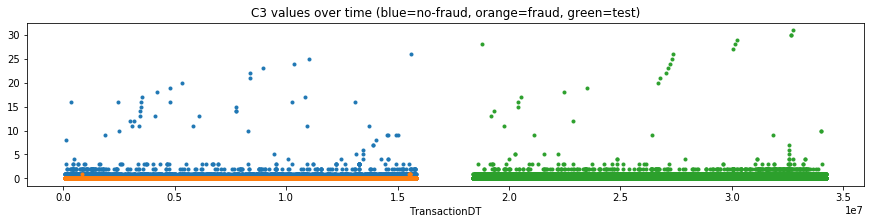

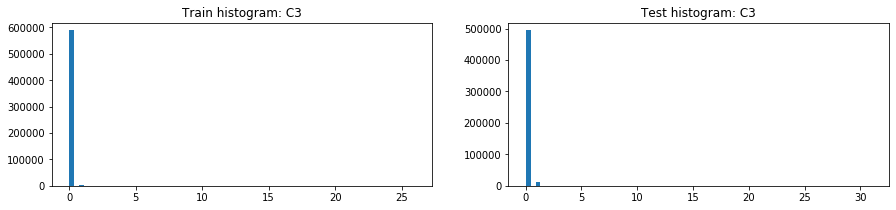

C3          Train   Train fraud  Train Not fraud  \
0           count  590540.000000  20663.000000    569877.000000   
1            mean       0.005644      0.000242         0.005840   
2             std       0.150536      0.015554         0.153208   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max      26.000000      1.000000        26.000000   
8   unique values      27.000000      2.000000        27.000000   
9            NaNs       0.000000      0.000000         0.000000   
10     NaNs share       0.000000      0.000000         0.000000   

             Test    Test public   Test private  
0   506688.000000  101339.000000  405350.000000  
1        0.027403       0.009365       0.031913  
2        0.227753       0.176030       0.238727  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7       31.000000      28.000000      31.000000  
8       32.000000      14.000000      26.000000  
9        3.000000       0.000000       3.000000  
10       0.000000       0.000000       0.000000

C3  Count in train (desc)  Mean target  Sum target  Count in test
0   0.0                 588111     0.035126       20658       493779.0
1   1.0                   2137     0.002340           5        12506.0
2   2.0                    180     0.000000           0          320.0
3   3.0                     58     0.000000           0           37.0
4   4.0                      7     0.000000           0           11.0
5  16.0                      6     0.000000           0            1.0
6   9.0                      5     0.000000           0            3.0
7  11.0                      5     0.000000           0            1.0
8  14.0                      3     0.000000           0            1.0
9  13.0                      3     0.000000           0            1.0

C3  Count in train  Mean target  Sum target (desc)  Count in test
0   0.0          588111     0.035126              20658         493779
1   1.0            2137     0.002340                  5          12506
2  15.0               2     0.000000                  0              1
3   6.0               1     0.000000                  0              1
4  19.0               1     0.000000                  0              1
5  20.0               1     0.000000                  0              1
6  21.0               1     0.000000                  0              1
7  18.0               1     0.000000                  0              1
8  23.0               1     0.000000                  0              1
9  24.0               1     0.000000                  0              1

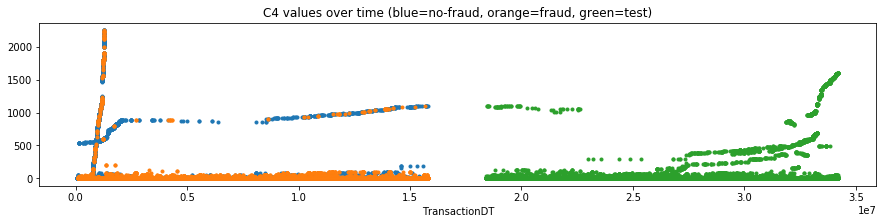

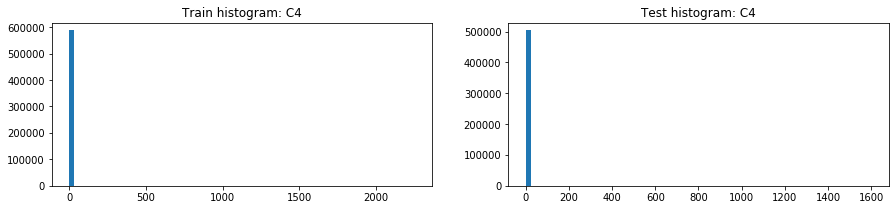

C4          Train   Train fraud  Train Not fraud  \
0           count  590540.000000  20663.000000    569877.000000   
1            mean       4.092185     15.077336         3.693878   
2             std      68.848459    125.673738        65.839255   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      1.000000         0.000000   
6             75%       0.000000      2.000000         0.000000   
7             max    2253.000000   2251.000000      2253.000000   
8   unique values    1260.000000    224.000000      1180.000000   
9            NaNs       0.000000      0.000000         0.000000   
10     NaNs share       0.000000      0.000000         0.000000   

             Test    Test public   Test private  
0   506688.000000  101339.000000  405350.000000  
1        2.385875       0.985040       2.736082  
2       41.942977      23.116076      45.440263  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        1.000000       0.000000       1.000000  
7     1601.000000    1100.000000    1601.000000  
8      729.000000      99.000000     698.000000  
9        3.000000       0.000000       3.000000  
10       0.000000       0.000000       0.000000

C4  Count in train (desc)  Mean target  Sum target  Count in test
0   0.0                 451883     0.020386        9212       371571.0
1   1.0                 111817     0.051298        5736       107826.0
2   2.0                  12994     0.128444        1669        13702.0
3   3.0                   4949     0.144070         713         4307.0
4   4.0                   1902     0.305468         581         1759.0
5   5.0                    851     0.404230         344         1159.0
6   6.0                    597     0.402010         240          713.0
7   7.0                    372     0.325269         121          482.0
8   9.0                    273     0.545788         149          298.0
9  10.0                    233     0.682403         159          305.0

C4  Count in train  Mean target  Sum target (desc)  Count in test
0   0.0          451883     0.020386               9212         371571
1   1.0          111817     0.051298               5736         107826
2   2.0           12994     0.128444               1669          13702
3   3.0            4949     0.144070                713           4307
4   4.0            1902     0.305468                581           1759
5   5.0             851     0.404230                344           1159
6   6.0             597     0.402010                240            713
7  10.0             233     0.682403                159            305
8   9.0             273     0.545788                149            298
9   7.0             372     0.325269                121            482

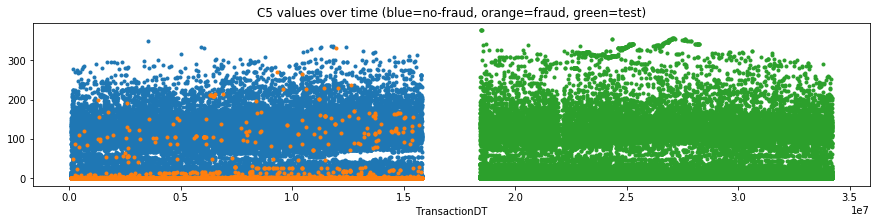

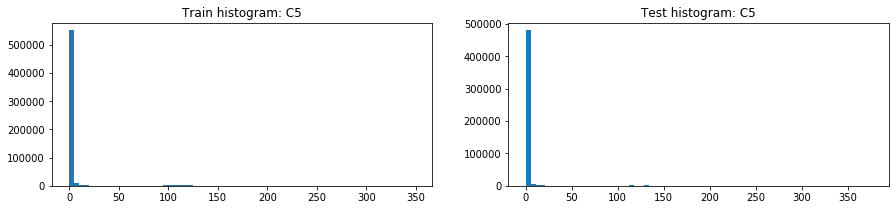

C5          Train   Train fraud  Train Not fraud  \
0           count  590540.000000  20663.000000    569877.000000   
1            mean       5.571526      1.406717         5.722537   
2             std      25.786976     12.946092        26.121841   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       1.000000      0.000000         1.000000   
7             max     349.000000    331.000000       349.000000   
8   unique values     319.000000    124.000000       319.000000   
9            NaNs       0.000000      0.000000         0.000000   
10     NaNs share       0.000000      0.000000         0.000000   

             Test    Test public   Test private  
0   506688.000000  101339.000000  405350.000000  
1        4.962701       5.711493       4.775493  
2       25.462195      26.488371      25.195644  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        1.000000       1.000000       1.000000  
7      376.000000     376.000000     355.000000  
8      354.000000     300.000000     353.000000  
9        3.000000       0.000000       3.000000  
10       0.000000       0.000000       0.000000

C5  Count in train (desc)  Mean target  Sum target  Count in test
0  0.0                 372435     0.050369       18759         334573
1  1.0                 122883     0.007560         929          96588
2  2.0                  34776     0.010956         381          29363
3  3.0                  13189     0.011980         158          10699
4  4.0                   6828     0.006591          45           5446
5  5.0                   3763     0.004252          16           2832
6  6.0                   2837     0.004230          12           1938
7  7.0                   1906     0.003673           7           1369
8  8.0                   1443     0.009009          13            991
9  9.0                   1076     0.009294          10            905

C5  Count in train  Mean target  Sum target (desc)  Count in test
0   0.0          372435     0.050369              18759         334573
1   1.0          122883     0.007560                929          96588
2   2.0           34776     0.010956                381          29363
3   3.0           13189     0.011980                158          10699
4   4.0            6828     0.006591                 45           5446
5  26.0             203     0.113300                 23            119
6  14.0             420     0.054762                 23            450
7  13.0             583     0.029160                 17            546
8   5.0            3763     0.004252                 16           2832
9   8.0            1443     0.009009                 13            991

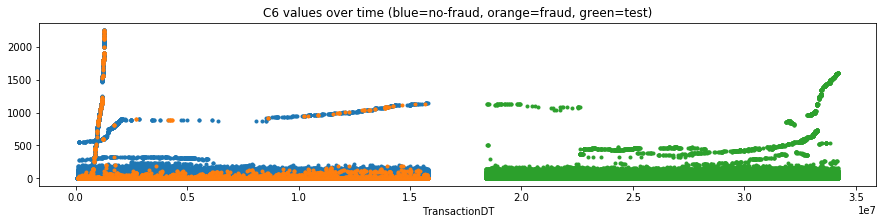

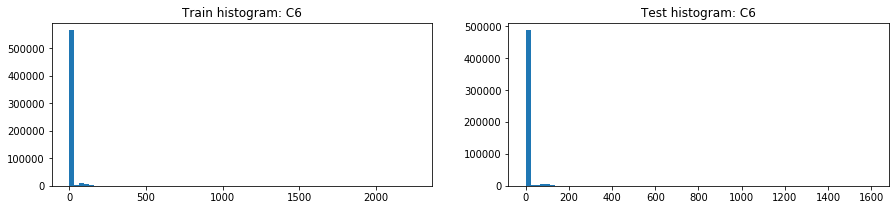

C6          Train   Train fraud  Train Not fraud  \
0           count  590540.000000  20663.000000    569877.000000   
1            mean       9.071082     16.923148         8.786377   
2             std      71.508467    126.298758        68.689176   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       2.000000      3.000000         2.000000   
7             max    2253.000000   2251.000000      2253.000000   
8   unique values    1328.000000    282.000000      1270.000000   
9            NaNs       0.000000      0.000000         0.000000   
10     NaNs share       0.000000      0.000000         0.000000   

             Test    Test public   Test private  
0   506688.000000  101339.000000  405350.000000  
1        6.854992       5.905969       7.092244  
2       46.783565      29.791262      50.136998  
3        0.000000       0.000000       0.000000  
4        1.000000       1.000000       1.000000  
5        1.000000       1.000000       1.000000  
6        2.000000       2.000000       2.000000  
7     1601.000000    1138.000000    1601.000000  
8      835.000000     201.000000     820.000000  
9        3.000000       0.000000       3.000000  
10       0.000000       0.000000       0.000000

C6  Count in train (desc)  Mean target  Sum target  Count in test
0  1.0                 341552     0.027764        9483       289685.0
1  2.0                  86103     0.037850        3259        75316.0
2  0.0                  49066     0.031305        1536        45707.0
3  3.0                  35490     0.042575        1511        31815.0
4  4.0                  17805     0.053300         949        16420.0
5  5.0                  10187     0.059880         610         8914.0
6  6.0                   6048     0.078042         472         5293.0
7  7.0                   3934     0.054652         215         3366.0
8  8.0                   3048     0.057415         175         2105.0
9  9.0                   2335     0.098073         229         1563.0

C6  Count in train  Mean target  Sum target (desc)  Count in test
0   1.0          341552     0.027764               9483         289685
1   2.0           86103     0.037850               3259          75316
2   0.0           49066     0.031305               1536          45707
3   3.0           35490     0.042575               1511          31815
4   4.0           17805     0.053300                949          16420
5   5.0           10187     0.059880                610           8914
6   6.0            6048     0.078042                472           5293
7  10.0            1817     0.128233                233           1267
8   9.0            2335     0.098073                229           1563
9   7.0            3934     0.054652                215           3366

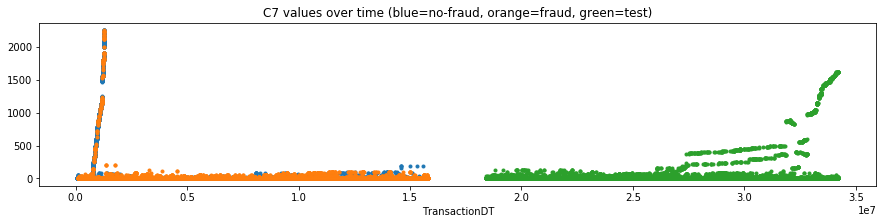

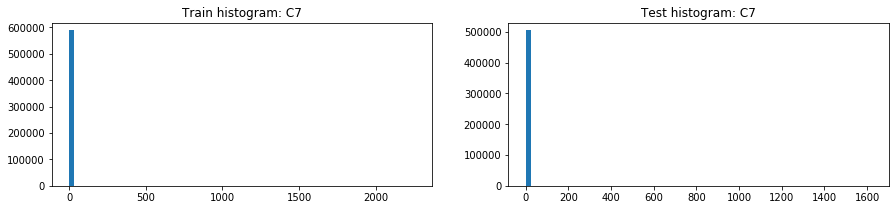

C7          Train   Train fraud  Train Not fraud  \
0           count  590540.000000  20663.000000    569877.000000   
1            mean       2.848478     11.977157         2.517484   
2             std      61.727304    115.143177        58.860773   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max    2255.000000   2253.000000      2255.000000   
8   unique values    1103.000000    197.000000      1018.000000   
9            NaNs       0.000000      0.000000         0.000000   
10     NaNs share       0.000000      0.000000         0.000000   

             Test    Test public   Test private  
0   506688.000000  101339.000000  405350.000000  
1        1.678173       0.377999       2.003217  
2       37.874827       3.769156      42.297173  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7     1621.000000     130.000000    1621.000000  
8      519.000000      74.000000     512.000000  
9        3.000000       0.000000       3.000000  
10       0.000000       0.000000       0.000000

C7  Count in train (desc)  Mean target  Sum target  Count in test
0   0.0                 523142     0.024376       12752       438095.0
1   1.0                  51966     0.067294        3497        50141.0
2   2.0                   7314     0.141509        1035         8712.0
3   3.0                   2033     0.232661         473         2734.0
4   4.0                   1109     0.431019         478         1344.0
5   5.0                    481     0.580042         279          691.0
6   6.0                    409     0.491443         201          478.0
7   7.0                    267     0.441948         118          369.0
8   9.0                    233     0.626609         146          216.0
9  10.0                    175     0.782857         137          199.0

C7  Count in train  Mean target  Sum target (desc)  Count in test
0   0.0          523142     0.024376              12752         438095
1   1.0           51966     0.067294               3497          50141
2   2.0            7314     0.141509               1035           8712
3   4.0            1109     0.431019                478           1344
4   3.0            2033     0.232661                473           2734
5   5.0             481     0.580042                279            691
6   6.0             409     0.491443                201            478
7   9.0             233     0.626609                146            216
8  10.0             175     0.782857                137            199
9   7.0             267     0.441948                118            369

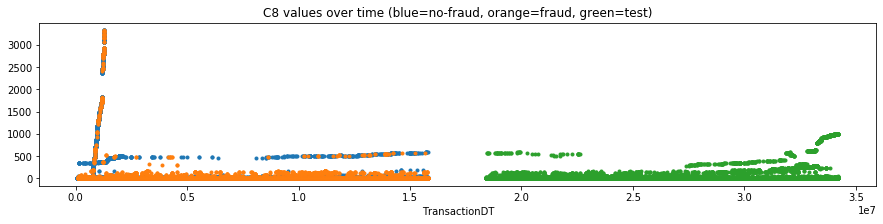

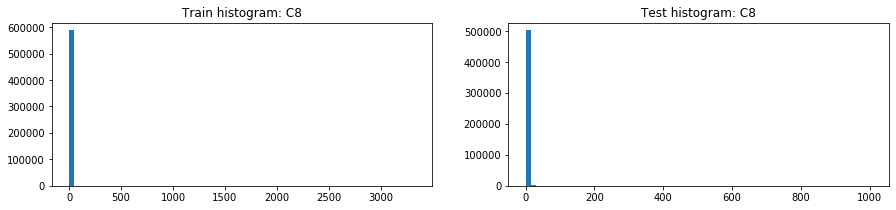

C8          Train   Train fraud  Train Not fraud  \
0           count  590540.000000  20663.000000    569877.000000   
1            mean       5.144574     21.242608         4.560881   
2             std      95.378574    176.695771        91.023016   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      1.000000         0.000000   
6             75%       0.000000      2.000000         0.000000   
7             max    3331.000000   3328.000000      3331.000000   
8   unique values    1253.000000    311.000000      1115.000000   
9            NaNs       0.000000      0.000000         0.000000   
10     NaNs share       0.000000      0.000000         0.000000   

             Test    Test public   Test private  
0   506688.000000  101339.000000  405350.000000  
1        1.893994       1.030146       2.109954  
2       26.766115      13.587585      29.140063  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        1.000000       0.000000       1.000000  
7     1005.000000     584.000000    1005.000000  
8      443.000000     120.000000     422.000000  
9        3.000000       0.000000       3.000000  
10       0.000000       0.000000       0.000000

C8  Count in train (desc)  Mean target  Sum target  Count in test
0  0.0                 447667     0.020899        9356       368637.0
1  1.0                 104994     0.044393        4661        97332.0
2  2.0                  15927     0.097633        1555        18261.0
3  3.0                   5493     0.137266         754         6801.0
4  4.0                   2817     0.182464         514         3172.0
5  8.0                   1790     0.112849         202          810.0
6  6.0                   1774     0.204059         362         1386.0
7  5.0                   1721     0.222545         383         2035.0
8  7.0                    988     0.237854         235         1015.0
9  9.0                    718     0.307799         221          660.0

C8  Count in train  Mean target  Sum target (desc)  Count in test
0  0.0          447667     0.020899               9356         368637
1  1.0          104994     0.044393               4661          97332
2  2.0           15927     0.097633               1555          18261
3  3.0            5493     0.137266                754           6801
4  4.0            2817     0.182464                514           3172
5  5.0            1721     0.222545                383           2035
6  6.0            1774     0.204059                362           1386
7  7.0             988     0.237854                235           1015
8  9.0             718     0.307799                221            660
9  8.0            1790     0.112849                202            810

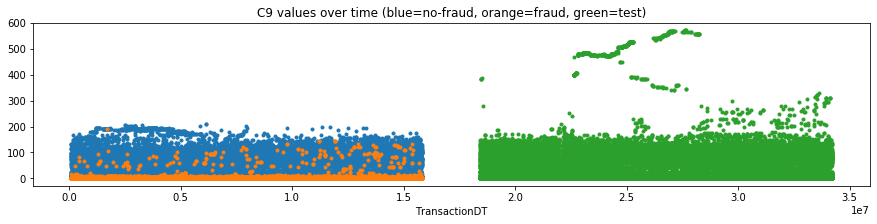

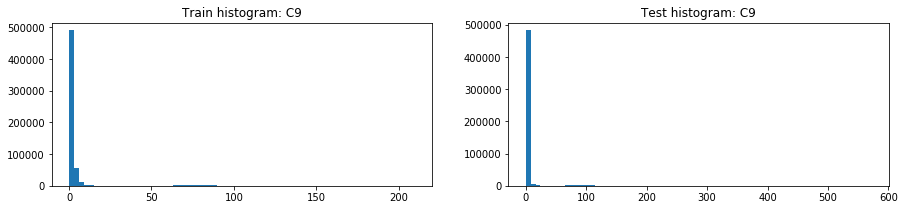

C9          Train   Train fraud  Train Not fraud  \
0           count  590540.000000  20663.000000    569877.000000   
1            mean       4.480240      1.703964         4.580904   
2             std      16.674897      8.453280        16.889451   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       1.000000      0.000000         1.000000   
6             75%       2.000000      1.000000         2.000000   
7             max     210.000000    192.000000       210.000000   
8   unique values     205.000000    111.000000       205.000000   
9            NaNs       0.000000      0.000000         0.000000   
10     NaNs share       0.000000      0.000000         0.000000   

             Test    Test public   Test private  
0   506688.000000  101339.000000  405350.000000  
1        4.611943       5.117645       4.485509  
2       21.282640      18.153293      21.993710  
3        0.000000       0.000000       0.000000  
4        0.000000       1.000000       0.000000  
5        1.000000       1.000000       1.000000  
6        2.000000       2.000000       2.000000  
7      572.000000     386.000000     572.000000  
8      355.000000     175.000000     352.000000  
9        3.000000       0.000000       3.000000  
10       0.000000       0.000000       0.000000

C9  Count in train (desc)  Mean target  Sum target  Count in test
0  1.0                 228938     0.019062        4364       191416.0
1  0.0                 183795     0.066683       12256       157766.0
2  2.0                  77829     0.021663        1686        68814.0
3  3.0                  32505     0.026211         852        31510.0
4  4.0                  16196     0.019820         321        15476.0
5  5.0                   8648     0.034806         301         7835.0
6  6.0                   5760     0.029514         170         4910.0
7  7.0                   3529     0.026636          94         2970.0
8  8.0                   2548     0.029827          76         2164.0
9  9.0                   1871     0.078033         146         1480.0

C9  Count in train  Mean target  Sum target (desc)  Count in test
0  0.0          183795     0.066683              12256         157766
1  1.0          228938     0.019062               4364         191416
2  2.0           77829     0.021663               1686          68814
3  3.0           32505     0.026211                852          31510
4  4.0           16196     0.019820                321          15476
5  5.0            8648     0.034806                301           7835
6  6.0            5760     0.029514                170           4910
7  9.0            1871     0.078033                146           1480
8  7.0            3529     0.026636                 94           2970
9  8.0            2548     0.029827                 76           2164

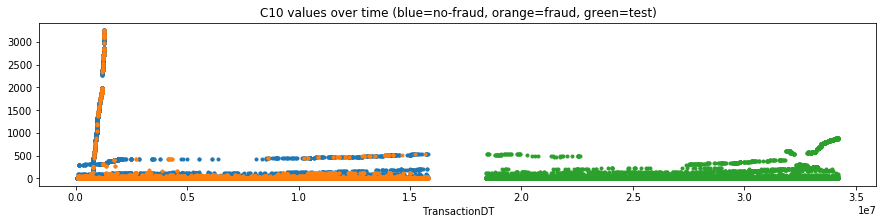

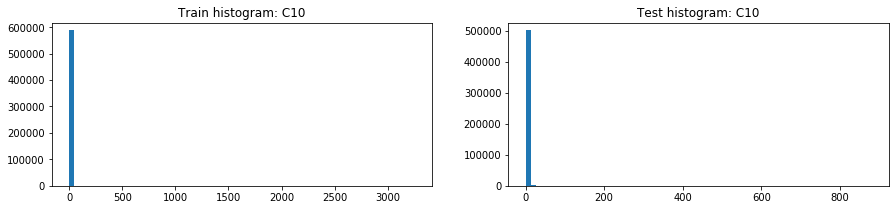

C10          Train   Train fraud  Train Not fraud  \
0           count  590540.000000  20663.000000    569877.000000   
1            mean       5.240343     19.493926         4.723526   
2             std      95.581443    176.919186        91.239098   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      1.000000         0.000000   
6             75%       0.000000      2.000000         0.000000   
7             max    3257.000000   3254.000000      3257.000000   
8   unique values    1231.000000    234.000000      1163.000000   
9            NaNs       0.000000      0.000000         0.000000   
10     NaNs share       0.000000      0.000000         0.000000   

             Test    Test public   Test private  
0   506688.000000  101339.000000  405350.000000  
1        1.810149       0.869409       2.045334  
2       23.692393      11.906035      25.805962  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        1.000000       0.000000       1.000000  
7      881.000000     530.000000     881.000000  
8      457.000000     111.000000     439.000000  
9        3.000000       0.000000       3.000000  
10       0.000000       0.000000       0.000000

C10  Count in train (desc)  Mean target  Sum target  Count in test
0  0.0                 453442     0.021273        9646       370978.0
1  1.0                 100231     0.046303        4641        92343.0
2  2.0                  14938     0.109452        1635        17752.0
3  3.0                   6417     0.134175         861         6869.0
4  4.0                   2836     0.197461         560         4002.0
5  5.0                   1806     0.209856         379         2550.0
6  6.0                   1286     0.209176         269         1858.0
7  7.0                    817     0.250918         205         1235.0
8  8.0                    627     0.280702         176          999.0
9  9.0                    553     0.227848         126          782.0

C10  Count in train  Mean target  Sum target (desc)  Count in test
0   0.0          453442     0.021273               9646         370978
1   1.0          100231     0.046303               4641          92343
2   2.0           14938     0.109452               1635          17752
3   3.0            6417     0.134175                861           6869
4   4.0            2836     0.197461                560           4002
5   5.0            1806     0.209856                379           2550
6   6.0            1286     0.209176                269           1858
7   7.0             817     0.250918                205           1235
8   8.0             627     0.280702                176            999
9  10.0             420     0.373810                157            705

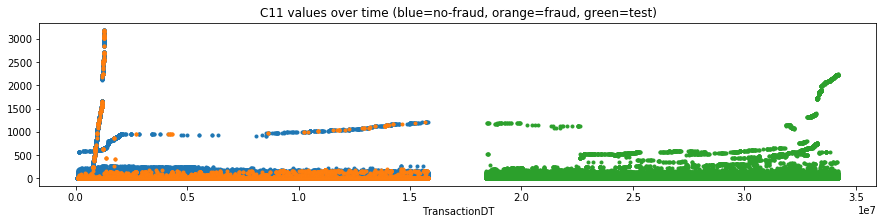

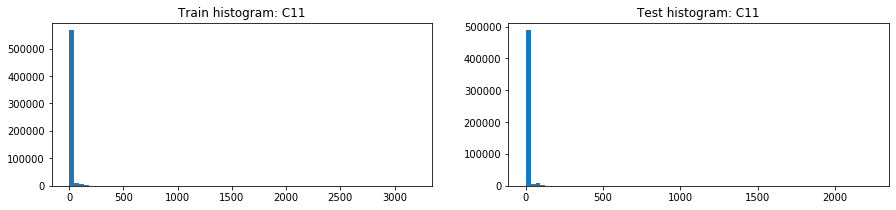

C11          Train   Train fraud  Train Not fraud  \
0           count  590540.000000  20663.000000    569877.000000   
1            mean      10.241521     23.857475         9.747825   
2             std      94.336292    170.966234        90.306569   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      2.000000         1.000000   
6             75%       2.000000      4.000000         2.000000   
7             max    3188.000000   3186.000000      3188.000000   
8   unique values    1476.000000    330.000000      1400.000000   
9            NaNs       0.000000      0.000000         0.000000   
10     NaNs share       0.000000      0.000000         0.000000   

             Test    Test public   Test private  
0   506688.000000  101339.000000  405350.000000  
1        7.484594       6.042649       7.845072  
2       61.322505      31.477895      66.724831  
3        0.000000       0.000000       0.000000  
4        1.000000       1.000000       1.000000  
5        1.000000       1.000000       1.000000  
6        2.000000       2.000000       2.000000  
7     2234.000000    1196.000000    2234.000000  
8      938.000000     246.000000     913.000000  
9        3.000000       0.000000       3.000000  
10       0.000000       0.000000       0.000000

C11  Count in train (desc)  Mean target  Sum target  Count in test
0  1.0                 389692     0.025346        9877       342100.0
1  2.0                  89677     0.040378        3621        79103.0
2  3.0                  34463     0.047181        1626        27179.0
3  4.0                  16051     0.062675        1006        12427.0
4  5.0                   9972     0.061472         613         6394.0
5  6.0                   5966     0.070734         422         3686.0
6  7.0                   3663     0.068523         251         2466.0
7  8.0                   2892     0.079876         231         1799.0
8  0.0                   1864     0.068133         127         4909.0
9  9.0                   1805     0.077008         139         1147.0

C11  Count in train  Mean target  Sum target (desc)  Count in test
0   1.0          389692     0.025346               9877         342100
1   2.0           89677     0.040378               3621          79103
2   3.0           34463     0.047181               1626          27179
3   4.0           16051     0.062675               1006          12427
4   5.0            9972     0.061472                613           6394
5   6.0            5966     0.070734                422           3686
6   7.0            3663     0.068523                251           2466
7   8.0            2892     0.079876                231           1799
8  10.0            1634     0.091187                149            934
9   9.0            1805     0.077008                139           1147

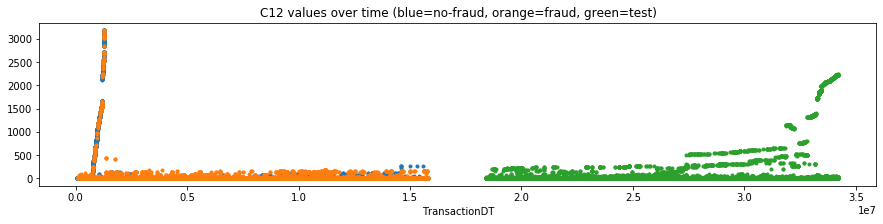

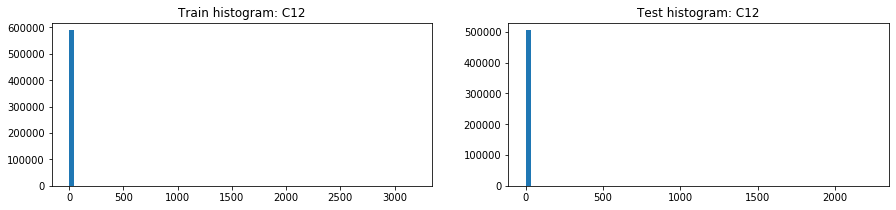

C12          Train   Train fraud  Train Not fraud  \
0           count  590540.000000  20663.000000    569877.000000   
1            mean       4.076227     18.597541         3.549703   
2             std      86.666218    162.082460        82.601169   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      2.000000         0.000000   
7             max    3188.000000   3186.000000      3188.000000   
8   unique values    1199.000000    282.000000      1050.000000   
9            NaNs       0.000000      0.000000         0.000000   
10     NaNs share       0.000000      0.000000         0.000000   

             Test    Test public  Test private  
0   506688.000000  101339.000000  405350.00000  
1        2.649486       0.870711       3.09418  
2       53.973060       9.524789      60.14732  
3        0.000000       0.000000       0.00000  
4        0.000000       0.000000       0.00000  
5        0.000000       0.000000       0.00000  
6        1.000000       0.000000       1.00000  
7     2234.000000     240.000000    2234.00000  
8      664.000000     129.000000     628.00000  
9        3.000000       0.000000       3.00000  
10       0.000000       0.000000       0.00000

C12  Count in train (desc)  Mean target  Sum target  Count in test
0  0.0                 489199     0.022897       11201       366881.0
1  1.0                  76661     0.053339        4089       108347.0
2  2.0                  12242     0.106437        1303        17804.0
3  3.0                   4185     0.163441         684         4980.0
4  4.0                   1716     0.245921         422         2064.0
5  5.0                   1085     0.268203         291          997.0
6  6.0                    629     0.352941         222          876.0
7  7.0                    393     0.351145         138          432.0
8  8.0                    262     0.438931         115          349.0
9  9.0                    177     0.395480          70          227.0

C12  Count in train  Mean target  Sum target (desc)  Count in test
0   0.0          489199     0.022897              11201         366881
1   1.0           76661     0.053339               4089         108347
2   2.0           12242     0.106437               1303          17804
3   3.0            4185     0.163441                684           4980
4   4.0            1716     0.245921                422           2064
5   5.0            1085     0.268203                291            997
6   6.0             629     0.352941                222            876
7   7.0             393     0.351145                138            432
8   8.0             262     0.438931                115            349
9  10.0             176     0.477273                 84            185

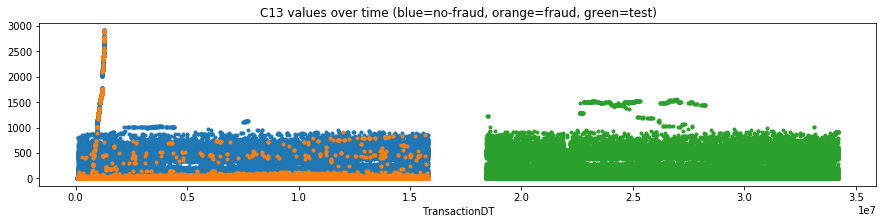

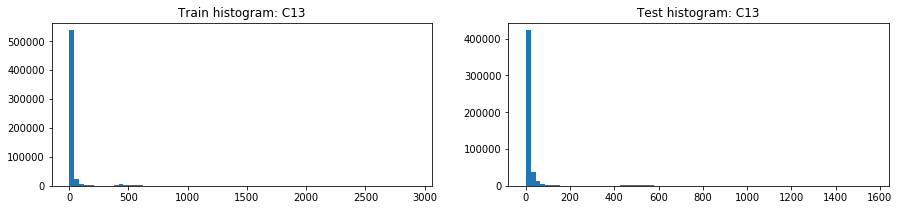

C13          Train   Train fraud  Train Not fraud  \
0           count  590540.000000  20663.000000    569877.000000   
1            mean      32.539918     24.967768        32.814474   
2             std     129.364844    165.979050       127.832166   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       3.000000      1.000000         3.000000   
6             75%      12.000000      6.000000        13.000000   
7             max    2918.000000   2915.000000      2918.000000   
8   unique values    1597.000000    392.000000      1567.000000   
9            NaNs       0.000000      0.000000         0.000000   
10     NaNs share       0.000000      0.000000         0.000000   

             Test    Test public   Test private  
0   501943.000000  101339.000000  400605.000000  
1       27.816035      30.227395      27.205996  
2      101.114033      99.669624     101.467080  
3        0.000000       0.000000       0.000000  
4        1.000000       1.000000       1.000000  
5        3.000000       4.000000       2.000000  
6       13.000000      15.000000      12.000000  
7     1562.000000    1230.000000    1562.000000  
8     1070.000000     797.000000    1062.000000  
9     4748.000000       0.000000    4748.000000  
10       0.009400       0.000000       0.011700

C13  Count in train (desc)  Mean target  Sum target  Count in test
0  1.0                 199337     0.028304        5642       168280.0
1  2.0                  57616     0.039277        2263        49947.0
2  0.0                  35460     0.141032        5001        29778.0
3  3.0                  33033     0.033058        1092        27602.0
4  4.0                  23704     0.035943         852        19240.0
5  5.0                  18355     0.031926         586        15076.0
6  6.0                  15127     0.031599         478        12659.0
7  7.0                  13001     0.029536         384        10885.0
8  8.0                  11424     0.032213         368         9603.0
9  9.0                  10189     0.018549         189         8972.0

C13  Count in train  Mean target  Sum target (desc)  Count in test
0   1.0          199337     0.028304               5642         168280
1   0.0           35460     0.141032               5001          29778
2   2.0           57616     0.039277               2263          49947
3   3.0           33033     0.033058               1092          27602
4   4.0           23704     0.035943                852          19240
5   5.0           18355     0.031926                586          15076
6   6.0           15127     0.031599                478          12659
7   7.0           13001     0.029536                384          10885
8   8.0           11424     0.032213                368           9603
9  13.0            8032     0.030752                247           6945

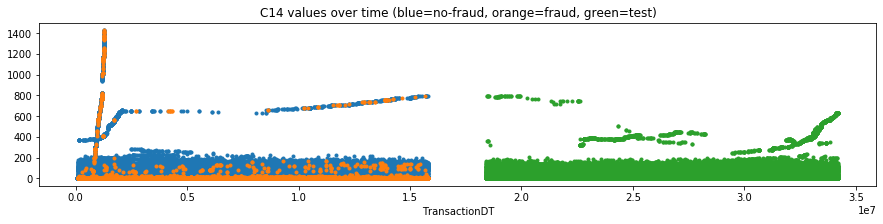

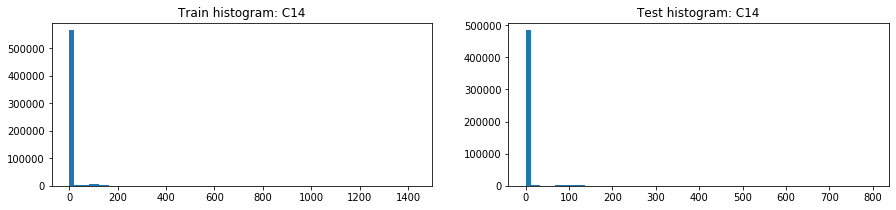

C14          Train   Train fraud  Train Not fraud  \
0           count  590540.000000  20663.000000    569877.000000   
1            mean       8.295215     10.356047         8.220491   
2             std      49.544262     82.902579        47.898725   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      0.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       2.000000      2.000000         2.000000   
7             max    1429.000000   1426.000000      1429.000000   
8   unique values    1108.000000    244.000000      1085.000000   
9            NaNs       0.000000      0.000000         0.000000   
10     NaNs share       0.000000      0.000000         0.000000   

             Test    Test public   Test private  
0   506688.000000  101339.000000  405350.000000  
1        6.083890       6.089058       6.082590  
2       28.315616      25.507991      28.975051  
3        0.000000       0.000000       0.000000  
4        1.000000       1.000000       1.000000  
5        1.000000       1.000000       1.000000  
6        2.000000       3.000000       2.000000  
7      797.000000     797.000000     748.000000  
8      570.000000     204.000000     548.000000  
9        3.000000       0.000000       3.000000  
10       0.000000       0.000000       0.000000

C14  Count in train (desc)  Mean target  Sum target  Count in test
0  1.0                 320189     0.026859        8600       278331.0
1  2.0                  93843     0.027663        2596        81914.0
2  3.0                  44471     0.026939        1198        38444.0
3  0.0                  35947     0.145047        5214        34564.0
4  4.0                  25390     0.030248         768        21074.0
5  5.0                  15655     0.026828         420        11757.0
6  6.0                   8563     0.032932         282         6781.0
7  7.0                   5030     0.031014         156         3987.0
8  8.0                   3471     0.048113         167         2583.0
9  9.0                   2651     0.064881         172         2203.0

C14  Count in train  Mean target  Sum target (desc)  Count in test
0  1.0          320189     0.026859               8600         278331
1  0.0           35947     0.145047               5214          34564
2  2.0           93843     0.027663               2596          81914
3  3.0           44471     0.026939               1198          38444
4  4.0           25390     0.030248                768          21074
5  5.0           15655     0.026828                420          11757
6  6.0            8563     0.032932                282           6781
7  9.0            2651     0.064881                172           2203
8  8.0            3471     0.048113                167           2583
9  7.0            5030     0.031014                156           3987

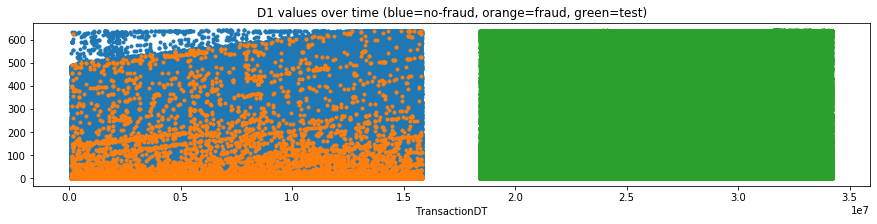

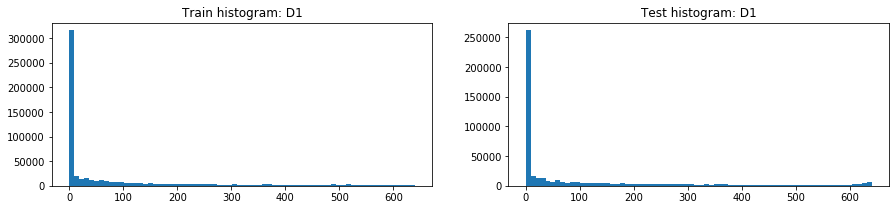

D1          Train   Train fraud  Train Not fraud  \
0           count  589271.000000  20617.000000    568654.000000   
1            mean      94.347568     38.711306        96.364705   
2             std     157.660387    100.915599       158.973258   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       3.000000      0.000000         4.000000   
6             75%     122.000000     14.000000       126.000000   
7             max     640.000000    637.000000       640.000000   
8   unique values     642.000000    578.000000       642.000000   
9            NaNs    1269.000000     46.000000      1223.000000   
10     NaNs share       0.002100      0.002200         0.002100   

             Test    Test public   Test private  
0   500660.000000  100922.000000  399739.000000  
1      108.207504     116.985543     105.991247  
2      176.964526     180.117849     176.090322  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        5.000000      16.000000       3.000000  
6      148.000000     167.000000     142.000000  
7      641.000000     638.000000     641.000000  
8      643.000000     640.000000     643.000000  
9     6031.000000     417.000000    5614.000000  
10       0.011900       0.004100       0.013800

D1  Count in train (desc)  Mean target  Sum target  Count in test
0   0.0                 280130     0.042084       11789         227724
1   1.0                   8634     0.120454        1040           8253
2   2.0                   4969     0.114107         567           5005
3   3.0                   3954     0.098634         390           4084
4   4.0                   3570     0.075350         269           3395
5   7.0                   3455     0.043994         152           3317
6   6.0                   3164     0.075853         240           2867
7   5.0                   3076     0.076723         236           2873
8  14.0                   2979     0.035247         105           2569
9   8.0                   2637     0.056883         150           2275

D1  Count in train  Mean target  Sum target (desc)  Count in test
0  0.0          280130     0.042084              11789         227724
1  1.0            8634     0.120454               1040           8253
2  2.0            4969     0.114107                567           5005
3  3.0            3954     0.098634                390           4084
4  4.0            3570     0.075350                269           3395
5  6.0            3164     0.075853                240           2867
6  5.0            3076     0.076723                236           2873
7  9.0            2387     0.067449                161           1939
8  7.0            3455     0.043994                152           3317
9  8.0            2637     0.056883                150           2275

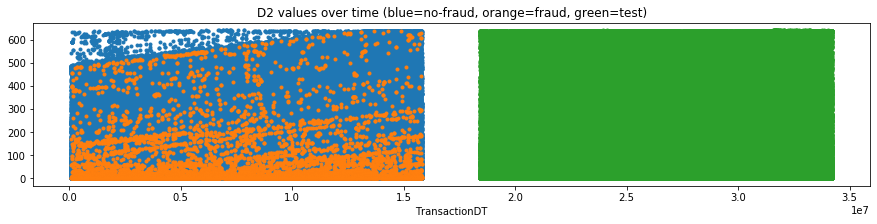

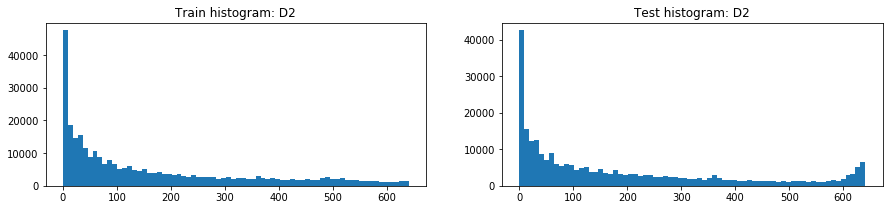

D2          Train   Train fraud  Train Not fraud  \
0           count  309743.000000   7870.000000    301873.000000   
1            mean     169.563231     77.774206       171.956223   
2             std     177.315865    128.697847       177.773639   
3             min       0.000000      0.000000         0.000000   
4             25%      26.000000      2.000000        27.000000   
5             50%      97.000000     16.000000       100.000000   
6             75%     276.000000     95.000000       280.000000   
7             max     640.000000    637.000000       640.000000   
8   unique values     642.000000    542.000000       642.000000   
9            NaNs  280797.000000  12793.000000    268004.000000   
10     NaNs share       0.475500      0.619100         0.470300   

             Test   Test public   Test private  
0   271922.000000  58869.000000  213054.000000  
1      188.666621    190.231582     188.233701  
2      197.099611    195.973461     197.407591  
3        0.000000      0.000000       0.000000  
4       26.000000     29.000000      24.000000  
5      112.000000    118.000000     111.000000  
6      305.000000    301.000000     307.000000  
7      641.000000    638.000000     641.000000  
8      643.000000    640.000000     643.000000  
9   234769.000000  42470.000000  192299.000000  
10       0.463300      0.419100       0.474400

D2  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 280797     0.045560       12793         234769
1    0.0                  15124     0.061822         935          11944
2    1.0                   6654     0.114968         765           6467
3    2.0                   4454     0.099461         443           4445
4    3.0                   3677     0.088659         326           3829
5    4.0                   3344     0.063397         212           3162
6    7.0                   3331     0.036325         121           3198
7    6.0                   3068     0.067471         207           2771
8    5.0                   2972     0.066285         197           2752
9   14.0                   2919     0.029805          87           2477

D2  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          280797     0.045560              12793         234769
1    0.0           15124     0.061822                935          11944
2    1.0            6654     0.114968                765           6467
3    2.0            4454     0.099461                443           4445
4    3.0            3677     0.088659                326           3829
5    4.0            3344     0.063397                212           3162
6    6.0            3068     0.067471                207           2771
7    5.0            2972     0.066285                197           2752
8    7.0            3331     0.036325                121           3198
9    8.0            2593     0.042422                110           2140

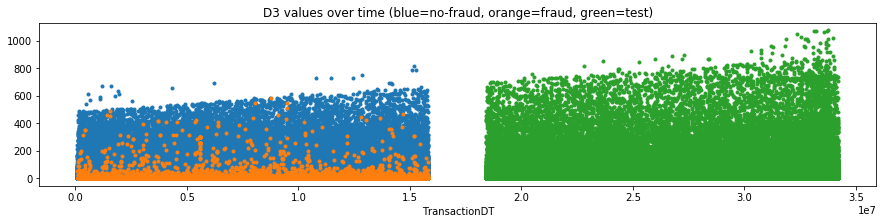

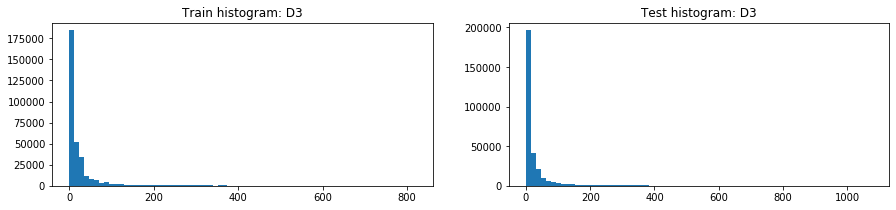

D3          Train   Train fraud  Train Not fraud  \
0           count  327662.000000   9619.000000    318043.000000   
1            mean      28.343348     11.744880        28.845357   
2             std      62.384721     42.005468        62.830058   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      0.000000         1.000000   
5             50%       8.000000      1.000000         8.000000   
6             75%      27.000000      5.000000        28.000000   
7             max     819.000000    582.000000       819.000000   
8   unique values     650.000000    262.000000       650.000000   
9            NaNs  262878.000000  11044.000000    251834.000000   
10     NaNs share       0.445100      0.534500         0.441900   

             Test   Test public   Test private  
0   303549.000000  63607.000000  239943.000000  
1       33.394727     29.559294      34.411381  
2       82.558210     68.249815      85.924044  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        7.000000      8.000000       7.000000  
6       28.000000     28.000000      28.000000  
7     1076.000000    754.000000    1076.000000  
8      888.000000    654.000000     888.000000  
9   203142.000000  37732.000000  165410.000000  
10       0.400900      0.372300       0.408100

D3  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 262878     0.042012       11044       203142.0
1    0.0                  73094     0.060251        4404        73232.0
2    1.0                  21258     0.069386        1475        20276.0
3    2.0                  13789     0.046776         645        13103.0
4    7.0                  13320     0.015015         200        11442.0
5    3.0                  10786     0.031986         345        10226.0
6    4.0                   9552     0.026068         249         8664.0
7   14.0                   9547     0.011312         108         8060.0
8    6.0                   9245     0.020227         187         8093.0
9    5.0                   8800     0.022386         197         7722.0

D3  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          262878     0.042012              11044         203142
1    0.0           73094     0.060251               4404          73232
2    1.0           21258     0.069386               1475          20276
3    2.0           13789     0.046776                645          13103
4    3.0           10786     0.031986                345          10226
5    4.0            9552     0.026068                249           8664
6    7.0           13320     0.015015                200          11442
7    5.0            8800     0.022386                197           7722
8    6.0            9245     0.020227                187           8093
9    8.0            8092     0.016189                131           6859

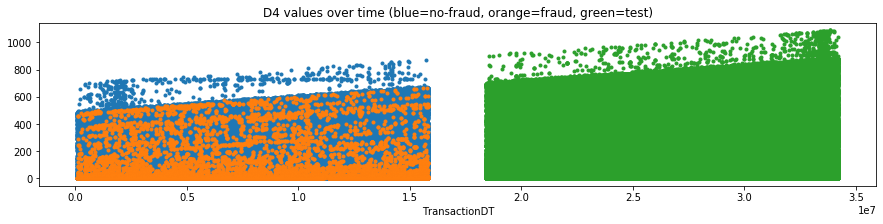

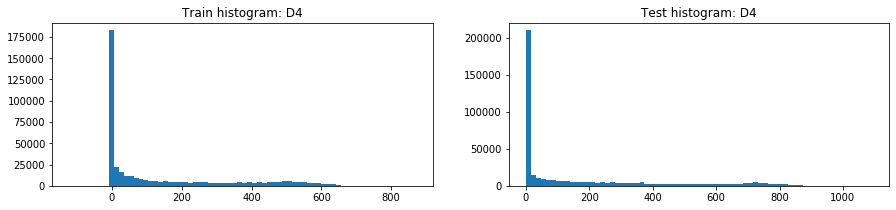

D4          Train   Train fraud  Train Not fraud  \
0           count  421618.000000  14567.000000    407051.000000   
1            mean     140.002441     72.102904       142.432339   
2             std     191.096774    140.656090       192.213375   
3             min    -122.000000      0.000000      -122.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%      26.000000      1.000000        28.000000   
6             75%     253.000000     61.000000       261.000000   
7             max     869.000000    667.000000       869.000000   
8   unique values     809.000000    606.000000       809.000000   
9            NaNs  168922.000000   6096.000000    162826.000000   
10     NaNs share       0.286000      0.295000         0.285700   

             Test   Test public   Test private  
0   429840.000000  80248.000000  349593.000000  
1      175.060799    180.750735     173.754323  
2      250.417470    233.899500     254.039684  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5       21.000000     54.000000      14.000000  
6      290.000000    313.000000     284.000000  
7     1091.000000    924.000000    1091.000000  
8     1057.000000    779.000000    1056.000000  
9    76851.000000  21091.000000   55760.000000  
10       0.151700      0.208100       0.137600

D4  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 168922     0.036088        6096        76851.0
1    0.0                 166571     0.039641        6603       178278.0
2    1.0                   5315     0.144873         770         5750.0
3    2.0                   3385     0.126145         427         3502.0
4    3.0                   2572     0.108476         279         2871.0
5    4.0                   2354     0.084962         200         2459.0
6    7.0                   2317     0.060855         141         2165.0
7    5.0                   2172     0.100829         219         2125.0
8   14.0                   2117     0.033066          70         1644.0
9    6.0                   2038     0.074092         151         2093.0

D4  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          166571     0.039641               6603         178278
1 -999.0          168922     0.036088               6096          76851
2    1.0            5315     0.144873                770           5750
3    2.0            3385     0.126145                427           3502
4    3.0            2572     0.108476                279           2871
5    5.0            2172     0.100829                219           2125
6    4.0            2354     0.084962                200           2459
7    6.0            2038     0.074092                151           2093
8    7.0            2317     0.060855                141           2165
9    9.0            1548     0.080749                125           1241

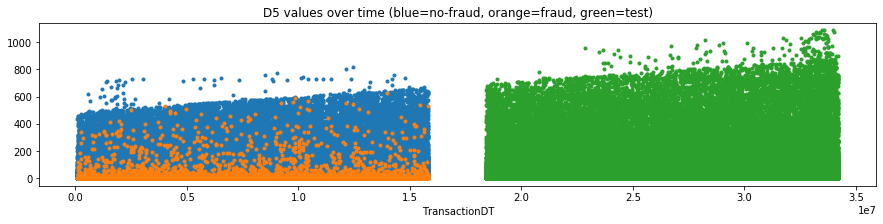

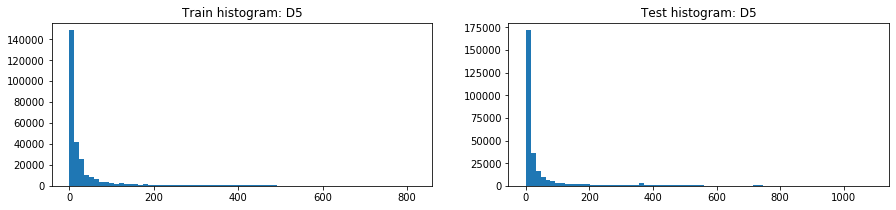

D5          Train   Train fraud  Train Not fraud  \
0           count  280699.000000  10880.000000    269819.000000   
1            mean      42.335965     13.687776        43.491155   
2             std      89.000144     51.891635        89.985719   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      0.000000         1.000000   
5             50%      10.000000      0.000000        10.000000   
6             75%      32.000000      3.000000        34.000000   
7             max     819.000000    625.000000       819.000000   
8   unique values     689.000000    342.000000       689.000000   
9            NaNs  309841.000000   9783.000000    300058.000000   
10     NaNs share       0.524700      0.473500         0.526500   

             Test   Test public   Test private  
0   282316.000000  58085.000000  224232.000000  
1       50.977752     42.060222      53.287649  
2      116.829786     94.246337     121.893591  
3        0.000000      0.000000       0.000000  
4        0.000000      1.000000       0.000000  
5        8.000000      9.000000       8.000000  
6       34.000000     32.000000      34.000000  
7     1088.000000    779.000000    1088.000000  
8      962.000000    711.000000     962.000000  
9   224375.000000  43254.000000  181121.000000  
10       0.442800      0.426800       0.446800

D5  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 309841     0.031574        9783         224375
1    0.0                  65377     0.101534        6638          73887
2    1.0                  15282     0.065829        1006          15642
3    2.0                  10244     0.044026         451          10188
4    7.0                   9734     0.015307         149           9103
5    3.0                   7987     0.033805         270           7977
6   14.0                   7340     0.008311          61           6557
7    4.0                   7176     0.027592         198           6755
8    6.0                   6907     0.020414         141           6521
9    5.0                   6696     0.025090         168           6196

D5  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          309841     0.031574               9783         224375
1    0.0           65377     0.101534               6638          73887
2    1.0           15282     0.065829               1006          15642
3    2.0           10244     0.044026                451          10188
4    3.0            7987     0.033805                270           7977
5    4.0            7176     0.027592                198           6755
6    5.0            6696     0.025090                168           6196
7    7.0            9734     0.015307                149           9103
8    6.0            6907     0.020414                141           6521
9    8.0            6140     0.018567                114           5549

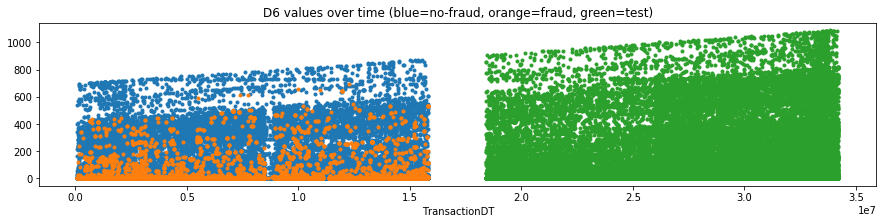

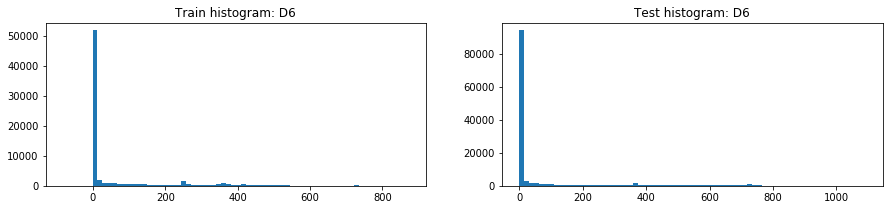

D6          Train   Train fraud  Train Not fraud  \
0           count   73187.000000   7718.000000     65469.000000   
1            mean      69.805717     45.856439        72.629046   
2             std     143.669253    101.424445       147.600963   
3             min     -83.000000      0.000000       -83.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%      40.000000     24.000000        43.000000   
7             max     873.000000    694.000000       873.000000   
8   unique values     830.000000    381.000000       830.000000   
9            NaNs  517353.000000  12945.000000    504408.000000   
10     NaNs share       0.876100      0.626500         0.885100   

             Test   Test public   Test private  
0   124783.000000  11194.000000  113589.000000  
1       82.443145     89.538503      81.743910  
2      192.867671    178.595333     194.204124  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6       13.000000     68.750000      10.000000  
7     1091.000000    939.000000    1091.000000  
8     1073.000000    726.000000    1072.000000  
9   381908.000000  90145.000000  291764.000000  
10       0.753700      0.889500       0.719800

D6  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 517353     0.025022       12945       381908.0
1    0.0                  45782     0.092897        4253        83120.0
2    1.0                   1588     0.261335         415         2475.0
3  256.0                    895     0.012291          11           22.0
4    2.0                    855     0.215205         184         1482.0
5    3.0                    642     0.208723         134         1192.0
6    4.0                    579     0.143351          83          927.0
7    5.0                    436     0.236239         103          783.0
8    7.0                    380     0.184211          70          717.0
9    6.0                    353     0.141643          50          710.0

D6  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          517353     0.025022              12945         381908
1    0.0           45782     0.092897               4253          83120
2    1.0            1588     0.261335                415           2475
3    2.0             855     0.215205                184           1482
4    3.0             642     0.208723                134           1192
5    5.0             436     0.236239                103            783
6    4.0             579     0.143351                 83            927
7    7.0             380     0.184211                 70            717
8    9.0             258     0.213178                 55            352
9    8.0             288     0.180556                 52            474

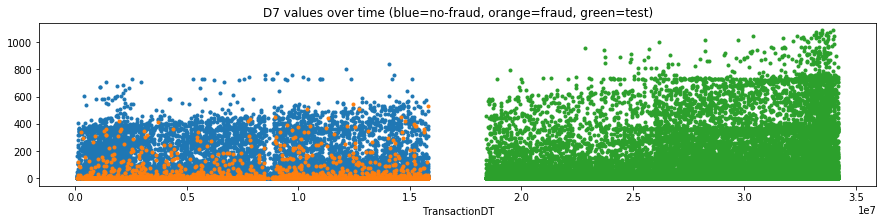

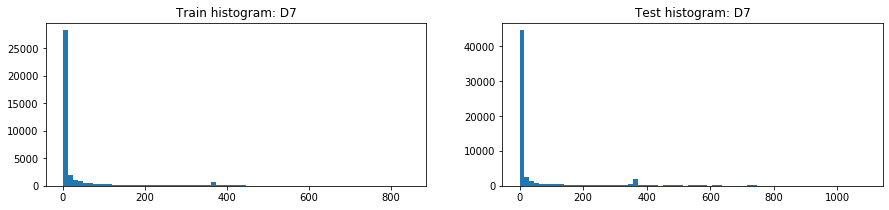

D7          Train   Train fraud  Train Not fraud  \
0           count   38917.000000   5790.000000     33127.000000   
1            mean      41.638950     11.292228        46.943007   
2             std      99.743264     46.743057       105.435756   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%      17.000000      0.000000        24.000000   
7             max     843.000000    547.000000       843.000000   
8   unique values     598.000000    242.000000       598.000000   
9            NaNs  551623.000000  14873.000000    536750.000000   
10     NaNs share       0.934100      0.719800         0.941900   

             Test   Test public   Test private  
0    60133.000000   7160.000000   52973.000000  
1       61.815642     33.610615      65.627924  
2      150.299612     94.096670     155.963738  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6       18.000000      9.000000      20.000000  
7     1088.000000    798.000000    1088.000000  
8      905.000000    440.000000     904.000000  
9   446558.000000  94179.000000  352380.000000  
10       0.881300      0.929300       0.869300

D7  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 551623     0.026962       14873       446558.0
1    0.0                  21135     0.211592        4472        31939.0
2    1.0                   1717     0.141526         243         2868.0
3    2.0                    998     0.108216         108         1850.0
4    3.0                    791     0.085967          68         1296.0
5    7.0                    606     0.059406          36          886.0
6    4.0                    601     0.093178          56         1004.0
7    5.0                    513     0.097466          50          852.0
8    6.0                    435     0.073563          32          792.0
9    8.0                    387     0.080103          31          567.0

D7  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          551623     0.026962              14873         446558
1    0.0           21135     0.211592               4472          31939
2    1.0            1717     0.141526                243           2868
3    2.0             998     0.108216                108           1850
4    3.0             791     0.085967                 68           1296
5    4.0             601     0.093178                 56           1004
6    5.0             513     0.097466                 50            852
7    7.0             606     0.059406                 36            886
8    6.0             435     0.073563                 32            792
9    8.0             387     0.080103                 31            567

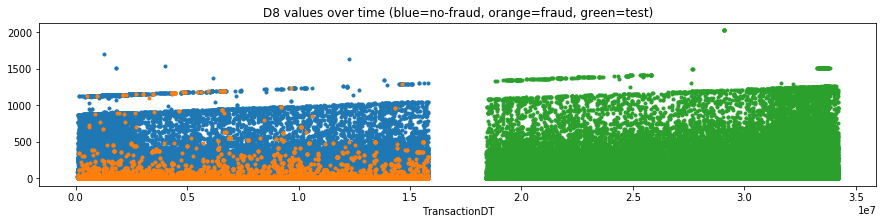

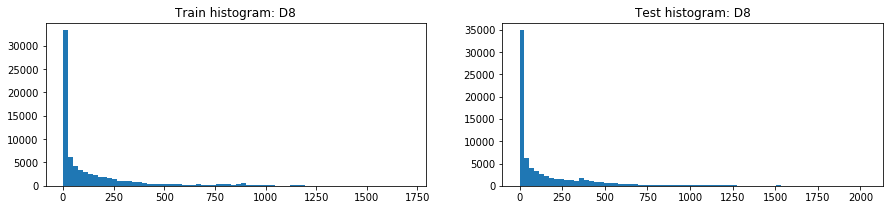

D8          Train   Train fraud  Train Not fraud  \
0           count   74926.000000   7827.000000     67099.000000   
1            mean     146.058108     49.309191       157.343727   
2             std     231.663840    133.254994       237.987816   
3             min       0.000000      0.000000         0.000000   
4             25%       0.958333      0.750000         1.750000   
5             50%      37.875000      2.666666        50.583332   
6             75%     187.958328     32.375000       207.541672   
7             max    1707.791626   1290.583374      1707.791626   
8   unique values   12354.000000   1352.000000     12207.000000   
9            NaNs  515614.000000  12836.000000    502778.000000   
10     NaNs share       0.873100      0.621200         0.882300   

             Test   Test public   Test private  
0    74338.000000  10200.000000   64138.000000  
1      160.834483    146.638799     163.092053  
2      257.003738    249.691565     258.077466  
3        0.000000      0.000000       0.000000  
4        1.083333      0.916666       1.208333  
5       37.708332     30.916666      38.875000  
6      221.125000    182.875000     227.750000  
7     2029.583374   1373.041626    2029.583374  
8    13245.000000   3683.000000   12457.000000  
9   432353.000000  91139.000000  341215.000000  
10       0.853300      0.899300       0.841800

D8  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.000000                 515614     0.024895       12836       432353.0
1    0.791666                   1351     0.179127         242         1263.0
2    0.833333                   1327     0.158252         210         1282.0
3    0.875000                   1304     0.199387         260         1299.0
4    0.958333                   1300     0.197692         257         1180.0
5    0.916666                   1259     0.181096         228         1132.0
6    0.750000                   1248     0.173878         217         1107.0
7    0.708333                   1175     0.122553         144         1038.0
8    0.083333                   1118     0.167263         187         1083.0
9    0.666666                   1097     0.121240         133         1075.0

D8  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.000000          515614     0.024895              12836         432353
1    0.875000            1304     0.199387                260           1299
2    0.958333            1300     0.197692                257           1180
3    0.791666            1351     0.179127                242           1263
4    0.916666            1259     0.181096                228           1132
5    0.750000            1248     0.173878                217           1107
6    0.833333            1327     0.158252                210           1282
7    0.083333            1118     0.167263                187           1083
8    0.000000             835     0.203593                170            763
9    0.125000            1028     0.162451                167           1052

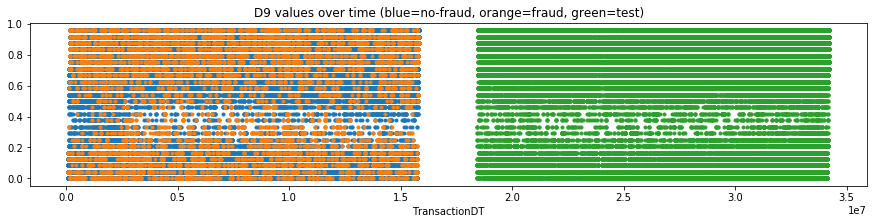

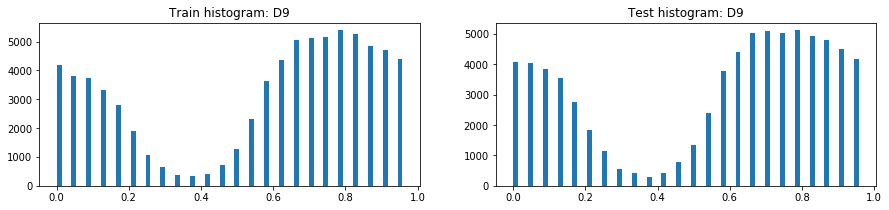

D9          Train   Train fraud  Train Not fraud  \
0           count   74926.000000   7827.000000     67099.000000   
1            mean       0.561057      0.520000         0.565846   
2             std       0.316880      0.333188         0.314576   
3             min       0.000000      0.000000         0.000000   
4             25%       0.208333      0.166666         0.208333   
5             50%       0.666666      0.625000         0.666666   
6             75%       0.833333      0.833333         0.833333   
7             max       0.958333      0.958333         0.958333   
8   unique values      25.000000     25.000000        25.000000   
9            NaNs  515614.000000  12836.000000    502778.000000   
10     NaNs share       0.873100      0.621200         0.882300   

             Test   Test public   Test private  
0    74338.000000  10200.000000   64138.000000  
1        0.553981      0.554093       0.553963  
2        0.317327      0.314076       0.317843  
3        0.000000      0.000000       0.000000  
4        0.208333      0.208333       0.208333  
5        0.666666      0.666666       0.666666  
6        0.791666      0.791666       0.791666  
7        0.958333      0.958333       0.958333  
8       25.000000     25.000000      25.000000  
9   432353.000000  91139.000000  341215.000000  
10       0.853300      0.899300       0.841800

D9  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.000000                 515614     0.024895       12836         432353
1    0.791666                   5388     0.095768         516           5111
2    0.833333                   5273     0.095202         502           4939
3    0.750000                   5147     0.091898         473           5033
4    0.708333                   5132     0.080670         414           5106
5    0.666666                   5069     0.074965         380           5021
6    0.875000                   4857     0.106444         517           4805
7    0.916666                   4694     0.106306         499           4503
8    0.958333                   4411     0.120834         533           4179
9    0.625000                   4380     0.059817         262           4415

D9  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.000000          515614     0.024895              12836         432353
1    0.958333            4411     0.120834                533           4179
2    0.875000            4857     0.106444                517           4805
3    0.791666            5388     0.095768                516           5111
4    0.833333            5273     0.095202                502           4939
5    0.916666            4694     0.106306                499           4503
6    0.750000            5147     0.091898                473           5033
7    0.083333            3726     0.123725                461           3841
8    0.000000            4190     0.108353                454           4062
9    0.166666            2786     0.151113                421           2760

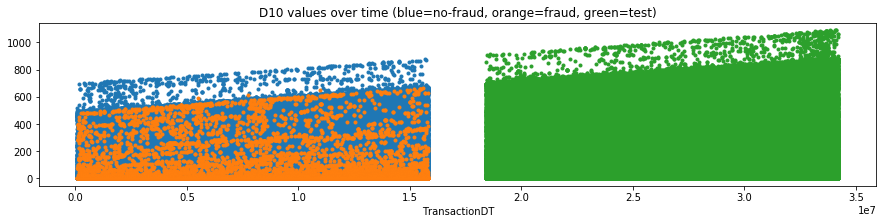

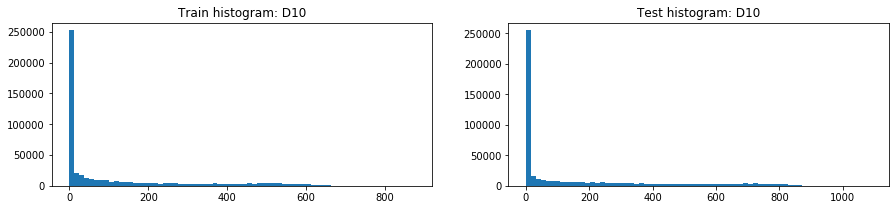

D10          Train   Train fraud  Train Not fraud  \
0           count  514518.000000  16777.000000    497741.000000   
1            mean     123.982137     52.363653       126.396130   
2             std     182.615225    127.051078       183.710646   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%      15.000000      0.000000        18.000000   
6             75%     197.000000     14.000000       205.000000   
7             max     876.000000    664.000000       876.000000   
8   unique values     819.000000    614.000000       819.000000   
9            NaNs   76022.000000   3886.000000     72136.000000   
10     NaNs share       0.128700      0.188100         0.126600   

             Test   Test public   Test private  
0   494146.000000  93904.000000  400243.000000  
1      159.810552    166.648183     158.206127  
2      240.566557    226.360455     243.751914  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5       10.000000     42.000000       4.000000  
6      250.000000    266.000000     246.000000  
7     1091.000000    947.000000    1091.000000  
8     1076.000000    820.000000    1076.000000  
9    12545.000000   7435.000000    5110.000000  
10       0.024800      0.073400       0.012600

D10  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 221930     0.047497       10541         227999
1 -999.0                  76022     0.051117        3886          12545
2    1.0                   5186     0.104512         542           4298
3    2.0                   3482     0.097358         339           2782
4    3.0                   2756     0.068578         189           2169
5    7.0                   2740     0.041971         115           1817
6   14.0                   2512     0.024283          61           1698
7    5.0                   2377     0.052587         125           1670
8   28.0                   2346     0.016198          38           1453
9    4.0                   2344     0.062713         147           1945

D10  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          221930     0.047497              10541         227999
1 -999.0           76022     0.051117               3886          12545
2    1.0            5186     0.104512                542           4298
3    2.0            3482     0.097358                339           2782
4    3.0            2756     0.068578                189           2169
5    4.0            2344     0.062713                147           1945
6    5.0            2377     0.052587                125           1670
7    7.0            2740     0.041971                115           1817
8    6.0            2303     0.044724                103           1688
9    9.0            1769     0.049746                 88           1132

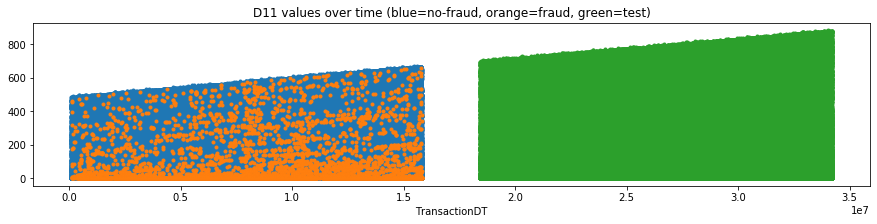

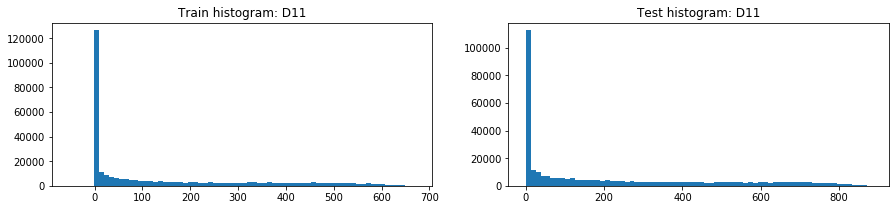

D11          Train   Train fraud  Train Not fraud  \
0           count  311253.000000   6106.000000    305147.000000   
1            mean     146.621465     87.314445       147.808201   
2             std     186.042622    146.561013       186.555365   
3             min     -53.000000      0.000000       -53.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%      43.000000      7.000000        44.000000   
6             75%     274.000000    107.750000       277.000000   
7             max     670.000000    655.000000       670.000000   
8   unique values     677.000000    557.000000       677.000000   
9            NaNs  279287.000000  14557.000000    264730.000000   
10     NaNs share       0.472900      0.704500         0.464500   

             Test   Test public   Test private  
0   330173.000000  74232.000000  255942.000000  
1      218.414895    197.138943     224.585117  
2      253.091693    227.897598     259.616540  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5      102.000000     93.000000     106.000000  
6      401.000000    366.000000     412.000000  
7      883.000000    742.000000     883.000000  
8      881.000000    739.000000     881.000000  
9   176518.000000  27107.000000  149411.000000  
10       0.348400      0.267500       0.368600

D11  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 279287     0.052122       14557       176518.0
1    0.0                 112281     0.019522        2192        93125.0
2    1.0                   3165     0.087836         278         3812.0
3    2.0                   2020     0.083168         168         2334.0
4    3.0                   1642     0.077954         128         1889.0
5    7.0                   1639     0.042709          70         1564.0
6   14.0                   1496     0.020722          31         1403.0
7    4.0                   1449     0.077295         112         1709.0
8    6.0                   1440     0.062500          90         1553.0
9    5.0                   1424     0.052669          75         1414.0

D11  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          279287     0.052122              14557         176518
1    0.0          112281     0.019522               2192          93125
2    1.0            3165     0.087836                278           3812
3    2.0            2020     0.083168                168           2334
4    3.0            1642     0.077954                128           1889
5    4.0            1449     0.077295                112           1709
6    6.0            1440     0.062500                 90           1553
7    5.0            1424     0.052669                 75           1414
8    7.0            1639     0.042709                 70           1564
9   11.0            1011     0.055391                 56            993

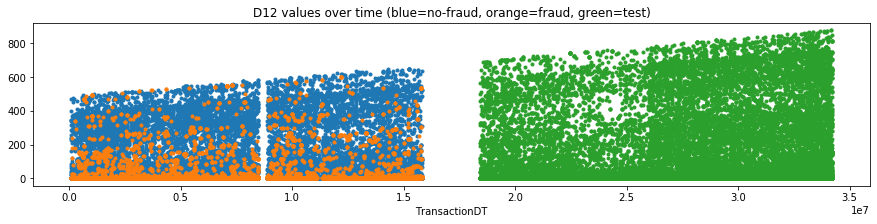

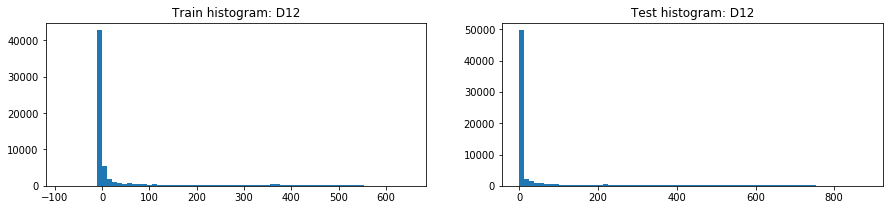

D12          Train   Train fraud  Train Not fraud  \
0           count   64717.000000   7598.000000     57119.000000   
1            mean      54.037533     44.202553        55.345787   
2             std     124.274558     99.349394       127.166079   
3             min     -83.000000      0.000000       -83.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%      13.000000     22.000000        11.000000   
7             max     648.000000    602.000000       648.000000   
8   unique values     636.000000    364.000000       635.000000   
9            NaNs  525823.000000  13065.000000    512758.000000   
10     NaNs share       0.890400      0.632300         0.899800   

             Test   Test public   Test private  
0    69254.000000   9801.000000   59453.000000  
1       77.404179     69.285787      78.742519  
2      176.218548    154.518366     179.510165  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6       25.000000     24.000000      25.000000  
7      879.000000    728.000000     879.000000  
8      867.000000    602.000000     867.000000  
9   437437.000000  91538.000000  345900.000000  
10       0.863300      0.903300       0.853300

D12  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 525823     0.024847       13065       437437.0
1    0.0                  42756     0.098676        4219        40855.0
2    1.0                   1526     0.275229         420         2043.0
3    2.0                    818     0.223716         183         1272.0
4    3.0                    634     0.219243         139         1061.0
5    4.0                    564     0.141844          80          798.0
6    5.0                    418     0.239234         100          691.0
7    7.0                    373     0.195710          73          658.0
8    6.0                    341     0.146628          50          630.0
9    8.0                    273     0.179487          49          414.0

D12  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          525823     0.024847              13065         437437
1    0.0           42756     0.098676               4219          40855
2    1.0            1526     0.275229                420           2043
3    2.0             818     0.223716                183           1272
4    3.0             634     0.219243                139           1061
5    5.0             418     0.239234                100            691
6    4.0             564     0.141844                 80            798
7    7.0             373     0.195710                 73            658
8    9.0             249     0.216867                 54            309
9    6.0             341     0.146628                 50            630

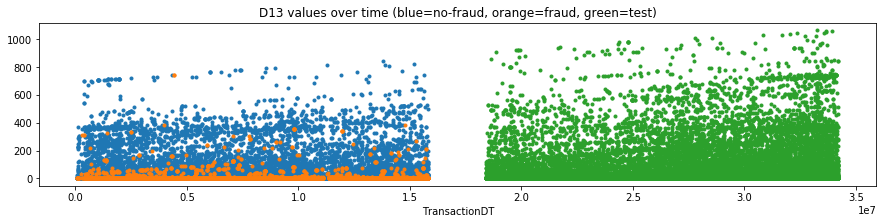

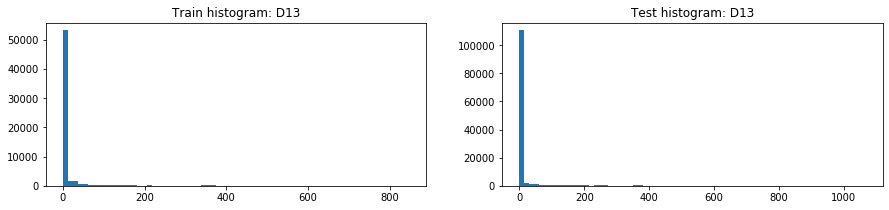

D13          Train   Train fraud  Train Not fraud  \
0           count   61952.000000   6837.000000     55115.000000   
1            mean      17.901295      6.492321        19.316574   
2             std      67.614425     31.330429        70.703174   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      0.000000         0.000000   
7             max     847.000000    745.000000       847.000000   
8   unique values     578.000000    130.000000       578.000000   
9            NaNs  528588.000000  13826.000000    514762.000000   
10     NaNs share       0.895100      0.669100         0.903300   

             Test   Test public   Test private  
0   123384.000000  10039.000000  113345.000000  
1       18.225961     24.144138      17.701787  
2       78.079890     82.980232      77.609589  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      1.000000       0.000000  
7     1066.000000    946.000000    1066.000000  
8      806.000000    398.000000     790.000000  
9   383307.000000  91300.000000  292008.000000  
10       0.756500      0.900900       0.720400

D13  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 528588     0.026156       13826       383307.0
1    0.0                  48840     0.111138        5428       101387.0
2    1.0                   1097     0.227894         250         2103.0
3   26.0                    891     0.001122           1          118.0
4    2.0                    623     0.290530         181         1294.0
5    3.0                    476     0.197479          94          898.0
6    4.0                    366     0.174863          64          702.0
7   19.0                    343     0.000000           0          158.0
8    5.0                    316     0.202532          64          552.0
9    7.0                    303     0.158416          48          623.0

D13  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          528588     0.026156              13826         383307
1    0.0           48840     0.111138               5428         101387
2    1.0            1097     0.227894                250           2103
3    2.0             623     0.290530                181           1294
4    3.0             476     0.197479                 94            898
5    4.0             366     0.174863                 64            702
6    5.0             316     0.202532                 64            552
7    7.0             303     0.158416                 48            623
8    9.0             203     0.221675                 45            355
9    6.0             262     0.164122                 43            584

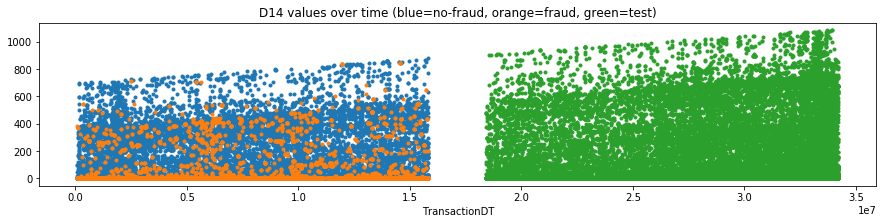

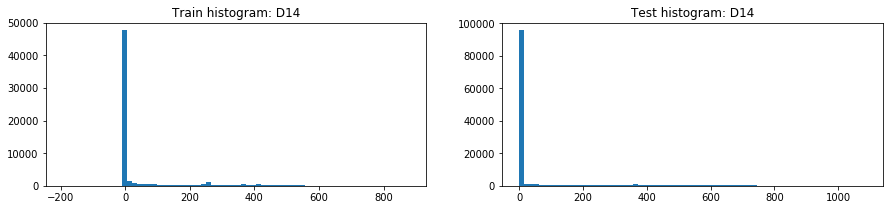

D14          Train   Train fraud  Train Not fraud  \
0           count   62187.000000   7213.000000     54974.000000   
1            mean      57.724444     54.464578        58.152163   
2             std     136.312450    126.586127       137.532930   
3             min    -193.000000      0.000000      -193.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       2.000000      9.000000         1.000000   
7             max     878.000000    847.000000       878.000000   
8   unique values     803.000000    382.000000       801.000000   
9            NaNs  528353.000000  13450.000000    514903.000000   
10     NaNs share       0.894700      0.650900         0.903500   

             Test   Test public   Test private  
0   115194.000000   9735.000000  105459.000000  
1       58.163186     76.289985      56.489887  
2      164.015525    168.656158     163.480027  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000     17.000000       0.000000  
7     1085.000000    938.000000    1085.000000  
8     1032.000000    648.000000    1029.000000  
9   391497.000000  91604.000000  299894.000000  
10       0.772700      0.903900       0.739800

D14  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 528353     0.025456       13450       391497.0
1    0.0                  45266     0.097954        4434        89500.0
2    1.0                   1105     0.361086         399         1744.0
3  256.0                    658     0.001520           1           19.0
4    2.0                    495     0.397980         197          740.0
5    3.0                    307     0.312704          96          498.0
6  249.0                    284     0.000000           0           15.0
7    4.0                    260     0.234615          61          531.0
8    7.0                    233     0.188841          44          363.0
9    5.0                    210     0.219048          46          478.0

D14  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          528353     0.025456              13450         391497
1    0.0           45266     0.097954               4434          89500
2    1.0            1105     0.361086                399           1744
3    2.0             495     0.397980                197            740
4    3.0             307     0.312704                 96            498
5    4.0             260     0.234615                 61            531
6    8.0             158     0.316456                 50            234
7    5.0             210     0.219048                 46            478
8    7.0             233     0.188841                 44            363
9    6.0             183     0.240437                 44            333

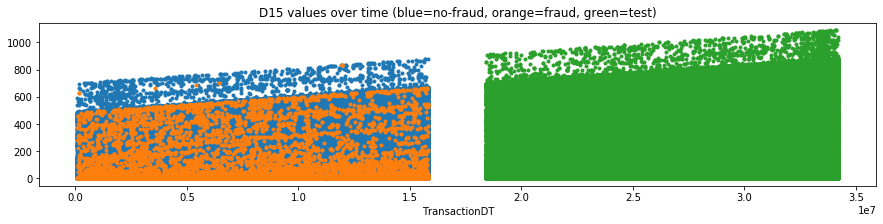

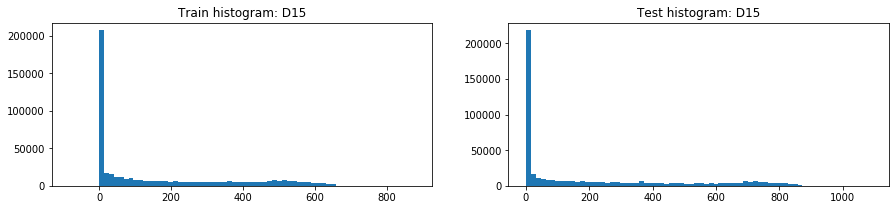

D15          Train   Train fraud  Train Not fraud  \
0           count  501427.000000  16387.000000    485040.000000   
1            mean     163.744579     78.245805       166.633142   
2             std     202.726660    151.956762       203.595694   
3             min     -83.000000      0.000000       -83.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%      52.000000      1.000000        56.000000   
6             75%     314.000000     63.000000       321.000000   
7             max     879.000000    835.000000       879.000000   
8   unique values     860.000000    642.000000       860.000000   
9            NaNs   89113.000000   4276.000000     84837.000000   
10     NaNs share       0.150900      0.206900         0.148900   

             Test   Test public   Test private  
0   494622.000000  94029.000000  400594.000000  
1      206.854137    216.941571     204.486061  
2      269.419196    250.887517     273.533320  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5       48.000000     99.000000      35.000000  
6      370.000000    406.000000     365.000000  
7     1091.000000    948.000000    1091.000000  
8     1079.000000    850.000000    1079.000000  
9    12069.000000   7310.000000    4759.000000  
10       0.023800      0.072100       0.011700

D15  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 174246     0.045258        7886       183720.0
1 -999.0                  89113     0.047984        4276        12069.0
2    1.0                   5936     0.120620         716         6202.0
3    2.0                   3691     0.119209         440         3793.0
4    3.0                   2878     0.092078         265         3106.0
5    7.0                   2577     0.051998         134         2360.0
6    4.0                   2573     0.071512         184         2747.0
7    5.0                   2336     0.076199         178         2202.0
8    6.0                   2276     0.060193         137         2276.0
9   14.0                   2265     0.039294          89         1853.0

D15  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          174246     0.045258               7886         183720
1 -999.0           89113     0.047984               4276          12069
2    1.0            5936     0.120620                716           6202
3    2.0            3691     0.119209                440           3793
4    3.0            2878     0.092078                265           3106
5    4.0            2573     0.071512                184           2747
6    5.0            2336     0.076199                178           2202
7    6.0            2276     0.060193                137           2276
8    7.0            2577     0.051998                134           2360
9    8.0            1973     0.060314                119           1674

M1   Train Train fraud Train Not fraud    Test Test public  \
0          count  319440        6342          313098  330052       74212   
1         unique       2           1               2       2           2   
2            top       T           T               T       T           T   
3           freq  319415        6342          313073  330021       74202   
4  unique values       3           2               3       3           3   
5           NaNs  271100       14321          256779  176639       27127   
6     NaNs share  0.4591      0.6931          0.4506  0.3486      0.2677   

  Test private  
0       255841  
1            2  
2            T  
3       255820  
4            3  
5       149512  
6       0.3688

M1  Count in train (desc)  Mean target  Sum target  Count in test
0     T                 319415     0.019855        6342         330021
1  -999                 271100     0.052826       14321         176639
2     F                     25     0.000000           0             31

M1  Count in train  Mean target  Sum target (desc)  Count in test
0  -999          271100     0.052826              14321         176639
1     T          319415     0.019855               6342         330021
2     F              25     0.000000                  0             31

M2   Train Train fraud Train Not fraud    Test Test public  \
0          count  319440        6342          313098  330052       74212   
1         unique       2           2               2       2           2   
2            top       T           T               T       T           T   
3           freq  285468        5158          280310  302855       67868   
4  unique values       3           3               3       3           3   
5           NaNs  271100       14321          256779  176639       27127   
6     NaNs share  0.4591      0.6931          0.4506  0.3486      0.2677   

  Test private  
0       255841  
1            2  
2            T  
3       234988  
4            3  
5       149512  
6       0.3688

M2  Count in train (desc)  Mean target  Sum target  Count in test
0     T                 285468     0.018069        5158         302855
1  -999                 271100     0.052826       14321         176639
2     F                  33972     0.034852        1184          27197

M2  Count in train  Mean target  Sum target (desc)  Count in test
0  -999          271100     0.052826              14321         176639
1     T          285468     0.018069               5158         302855
2     F           33972     0.034852               1184          27197

M3   Train Train fraud Train Not fraud    Test Test public  \
0          count  319440        6342          313098  330052       74212   
1         unique       2           2               2       2           2   
2            top       T           T               T       T           T   
3           freq  251731        4293          247438  266513       59925   
4  unique values       3           3               3       3           3   
5           NaNs  271100       14321          256779  176639       27127   
6     NaNs share  0.4591      0.6931          0.4506  0.3486      0.2677   

  Test private  
0       255841  
1            2  
2            T  
3       206589  
4            3  
5       149512  
6       0.3688

M3  Count in train (desc)  Mean target  Sum target  Count in test
0  -999                 271100     0.052826       14321         176639
1     T                 251731     0.017054        4293         266513
2     F                  67709     0.030262        2049          63539

M3  Count in train  Mean target  Sum target (desc)  Count in test
0  -999          271100     0.052826              14321         176639
1     T          251731     0.017054               4293         266513
2     F           67709     0.030262               2049          63539

M4   Train Train fraud Train Not fraud    Test Test public  \
0          count  309096       15436          293660  268946       55401   
1         unique       3           3               3       3           3   
2            top      M0          M0              M0      M0          M0   
3           freq  196405        7198          189207  161384       35921   
4  unique values       4           4               4       4           4   
5           NaNs  281444        5227          276217  237745       45938   
6     NaNs share  0.4766       0.253          0.4847  0.4692      0.4533   

  Test private  
0       213545  
1            3  
2           M0  
3       125463  
4            4  
5       191808  
6       0.4732

M4  Count in train (desc)  Mean target  Sum target  Count in test
0  -999                 281444     0.018572        5227         237745
1    M0                 196405     0.036649        7198         161384
2    M2                  59865     0.113739        6809          63082
3    M1                  52826     0.027051        1429          44480

M4  Count in train  Mean target  Sum target (desc)  Count in test
0    M0          196405     0.036649               7198         161384
1    M2           59865     0.113739               6809          63082
2  -999          281444     0.018572               5227         237745
3    M1           52826     0.027051               1429          44480

M5   Train Train fraud Train Not fraud    Test Test public  \
0          count  240058        7569          232489  197059       45022   
1         unique       2           2               2       2           2   
2            top       F           T               F       F           F   
3           freq  132491        4055          128977  107664       24466   
4  unique values       3           3               3       3           3   
5           NaNs  350482       13094          337388  309632       56317   
6     NaNs share  0.5935      0.6337           0.592  0.6111      0.5557   

  Test private  
0       152037  
1            2  
2            F  
3        83198  
4            3  
5       253316  
6       0.6249

M5  Count in train (desc)  Mean target  Sum target  Count in test
0  -999                 350482     0.037360       13094         309632
1     F                 132491     0.026523        3514         107664
2     T                 107567     0.037697        4055          89395

M5  Count in train  Mean target  Sum target (desc)  Count in test
0  -999          350482     0.037360              13094         309632
1     T          107567     0.037697               4055          89395
2     F          132491     0.026523               3514         107664

M6   Train Train fraud Train Not fraud    Test Test public  \
0          count  421180        8692          412488  347752       79525   
1         unique       2           2               2       2           2   
2            top       F           F               F       F           F   
3           freq  227856        5397          222459  191577       43280   
4  unique values       3           3               3       3           3   
5           NaNs  169360       11971          157389  158939       21814   
6     NaNs share  0.2868      0.5793          0.2762  0.3137      0.2153   

  Test private  
0       268228  
1            2  
2            F  
3       148298  
4            3  
5       137125  
6       0.3383

M6  Count in train (desc)  Mean target  Sum target  Count in test
0     F                 227856     0.023686        5397         191577
1     T                 193324     0.017044        3295         156175
2  -999                 169360     0.070684       11971         158939

M6  Count in train  Mean target  Sum target (desc)  Count in test
0  -999          169360     0.070684              11971         158939
1     F          227856     0.023686               5397         191577
2     T          193324     0.017044               3295         156175

M7   Train Train fraud Train Not fraud    Test Test public  \
0          count  244275        4817          239458  271673       61993   
1         unique       2           2               2       2           2   
2            top       F           F               F       F           F   
3           freq  211374        4089          207285  233230       53284   
4  unique values       3           3               3       3           3   
5           NaNs  346265       15846          330419  235018       39346   
6     NaNs share  0.5864      0.7669          0.5798  0.4638      0.3883   

  Test private  
0       209681  
1            2  
2            F  
3       179947  
4            3  
5       195672  
6       0.4827

M7  Count in train (desc)  Mean target  Sum target  Count in test
0  -999                 346265     0.045763       15846         235018
1     F                 211374     0.019345        4089         233230
2     T                  32901     0.022127         728          38443

M7  Count in train  Mean target  Sum target (desc)  Count in test
0  -999          346265     0.045763              15846         235018
1     F          211374     0.019345               4089         233230
2     T           32901     0.022127                728          38443

M8   Train Train fraud Train Not fraud    Test Test public  \
0          count  244288        4817          239471  271687       61998   
1         unique       2           2               2       2           2   
2            top       F           F               F       F           F   
3           freq  155251        3373          151878  168399       38420   
4  unique values       3           3               3       3           3   
5           NaNs  346252       15846          330406  235004       39341   
6     NaNs share  0.5863      0.7669          0.5798  0.4638      0.3882   

  Test private  
0       209690  
1            2  
2            F  
3       129980  
4            3  
5       195663  
6       0.4827

M8  Count in train (desc)  Mean target  Sum target  Count in test
0  -999                 346252     0.045764       15846         235004
1     F                 155251     0.021726        3373         168399
2     T                  89037     0.016218        1444         103288

M8  Count in train  Mean target  Sum target (desc)  Count in test
0  -999          346252     0.045764              15846         235004
1     F          155251     0.021726               3373         168399
2     T           89037     0.016218               1444         103288

M9   Train Train fraud Train Not fraud    Test Test public  \
0          count  244288        4817          239471  271687       61998   
1         unique       2           2               2       2           2   
2            top       T           T               T       T           T   
3           freq  205656        3658          201998  236279       53776   
4  unique values       3           3               3       3           3   
5           NaNs  346252       15846          330406  235004       39341   
6     NaNs share  0.5863      0.7669          0.5798  0.4638      0.3882   

  Test private  
0       209690  
1            2  
2            T  
3       182503  
4            3  
5       195663  
6       0.4827

M9  Count in train (desc)  Mean target  Sum target  Count in test
0  -999                 346252     0.045764       15846         235004
1     T                 205656     0.017787        3658         236279
2     F                  38632     0.030001        1159          35408

M9  Count in train  Mean target  Sum target (desc)  Count in test
0  -999          346252     0.045764              15846         235004
1     T          205656     0.017787               3658         236279
2     F           38632     0.030001               1159          35408

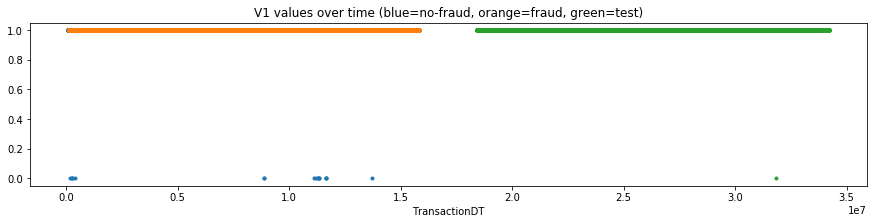

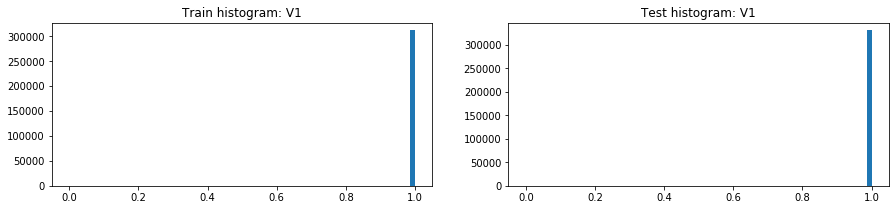

V1          Train  Train fraud  Train Not fraud           Test  \
0           count  311253.000000    6106.0000    305147.000000  330173.000000   
1            mean       0.999945       1.0000         0.999944       0.999997   
2             std       0.007390       0.0000         0.007464       0.001740   
3             min       0.000000       1.0000         0.000000       0.000000   
4             25%       1.000000       1.0000         1.000000       1.000000   
5             50%       1.000000       1.0000         1.000000       1.000000   
6             75%       1.000000       1.0000         1.000000       1.000000   
7             max       1.000000       1.0000         1.000000       1.000000   
8   unique values       3.000000       2.0000         3.000000       3.000000   
9            NaNs  279287.000000   14557.0000    264730.000000  176518.000000   
10     NaNs share       0.472900       0.7045         0.464500       0.348400   

    Test public   Test private  
0    74232.0000  255942.000000  
1        1.0000       0.999996  
2        0.0000       0.001977  
3        1.0000       0.000000  
4        1.0000       1.000000  
5        1.0000       1.000000  
6        1.0000       1.000000  
7        1.0000       1.000000  
8        2.0000       3.000000  
9    27107.0000  149411.000000  
10       0.2675       0.368600

V1  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 311236     0.019619        6106         330172
1 -999.0                 279287     0.052122       14557         176518
2    0.0                     17     0.000000           0              1

V1  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          279287     0.052122              14557         176518
1    1.0          311236     0.019619               6106         330172
2    0.0              17     0.000000                  0              1

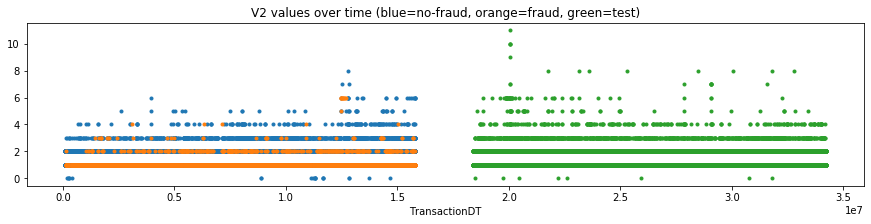

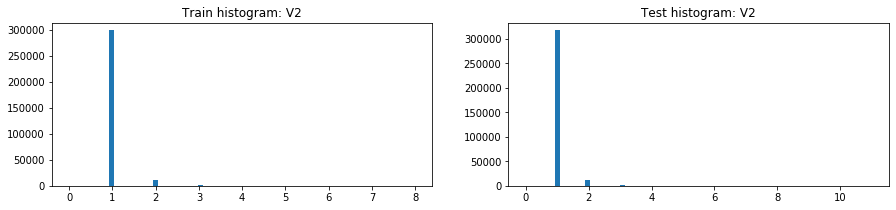

V2          Train   Train fraud  Train Not fraud  \
0           count  311253.000000   6106.000000    305147.000000   
1            mean       1.045204      1.078939         1.044529   
2             std       0.240133      0.351422         0.237326   
3             min       0.000000      1.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       8.000000      6.000000         8.000000   
8   unique values      10.000000      7.000000        10.000000   
9            NaNs  279287.000000  14557.000000    264730.000000   
10     NaNs share       0.472900      0.704500         0.464500   

             Test   Test public   Test private  
0   330173.000000  74232.000000  255942.000000  
1        1.046636      1.051649       1.045182  
2        0.250847      0.284682       0.240125  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       11.000000     11.000000       8.000000  
8       13.000000     13.000000      10.000000  
9   176518.000000  27107.000000  149411.000000  
10       0.348400      0.267500       0.368600

V2  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 298894     0.019127        5717         316786
1 -999.0                 279287     0.052122       14557         176518
2    2.0                  10926     0.030203         330          11933
3    3.0                   1181     0.037257          44           1099
4    4.0                    163     0.030675           5            227
5    5.0                     36     0.027778           1             51
6    6.0                     30     0.300000           9             47
7    0.0                     20     0.000000           0              8
8    7.0                      2     0.000000           0              9
9    8.0                      1     0.000000           0              8

V2  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          279287     0.052122              14557         176518
1    1.0          298894     0.019127               5717         316786
2    2.0           10926     0.030203                330          11933
3    3.0            1181     0.037257                 44           1099
4    6.0              30     0.300000                  9             47
5    4.0             163     0.030675                  5            227
6    5.0              36     0.027778                  1             51
7    0.0              20     0.000000                  0              8
8    7.0               2     0.000000                  0              9
9    8.0               1     0.000000                  0              8

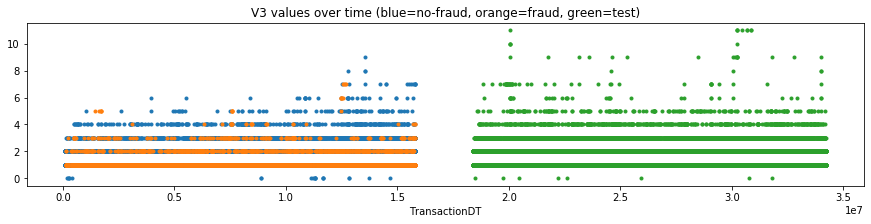

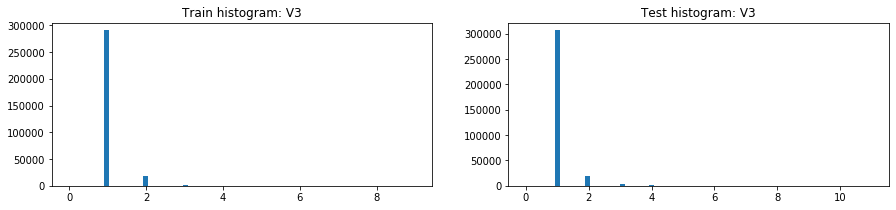

V3          Train   Train fraud  Train Not fraud  \
0           count  311253.000000   6106.000000    305147.000000   
1            mean       1.078075      1.189813         1.075839   
2             std       0.320890      0.541936         0.314484   
3             min       0.000000      1.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       9.000000      7.000000         9.000000   
8   unique values      11.000000      8.000000        11.000000   
9            NaNs  279287.000000  14557.000000    264730.000000   
10     NaNs share       0.472900      0.704500         0.464500   

             Test   Test public   Test private  
0   330173.000000  74232.000000  255942.000000  
1        1.087436      1.089180       1.086930  
2        0.359033      0.372204       0.355121  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       11.000000     11.000000      11.000000  
8       13.000000     12.000000      13.000000  
9   176518.000000  27107.000000  149411.000000  
10       0.348400      0.267500       0.368600

V3  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 290583     0.018064        5249         306610
1 -999.0                 279287     0.052122       14557         176518
2    2.0                  17763     0.035523         631          19796
3    3.0                   2335     0.077944         182           2797
4    4.0                    403     0.062035          25            644
5    5.0                     93     0.107527          10            200
6    6.0                     34     0.147059           5             37
7    0.0                     20     0.000000           0              8
8    7.0                     18     0.222222           4             48
9    8.0                      3     0.000000           0              4

V3  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          279287     0.052122              14557         176518
1    1.0          290583     0.018064               5249         306610
2    2.0           17763     0.035523                631          19796
3    3.0            2335     0.077944                182           2797
4    4.0             403     0.062035                 25            644
5    5.0              93     0.107527                 10            200
6    6.0              34     0.147059                  5             37
7    7.0              18     0.222222                  4             48
8    0.0              20     0.000000                  0              8
9    8.0               3     0.000000                  0              4

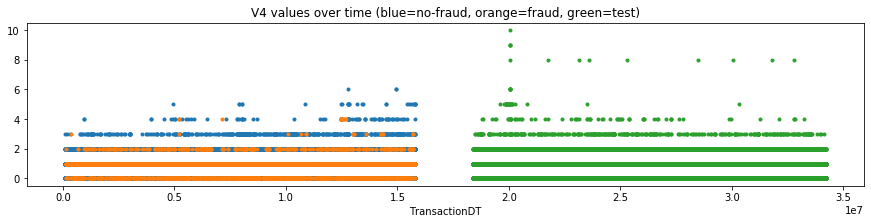

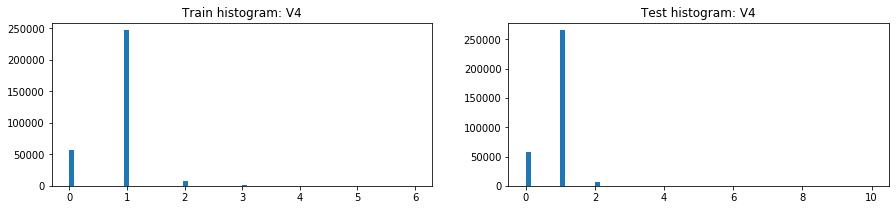

V4          Train   Train fraud  Train Not fraud  \
0           count  311253.000000   6106.000000    305147.000000   
1            mean       0.846456      0.885686         0.845671   
2             std       0.440053      0.504883         0.438623   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       6.000000      4.000000         6.000000   
8   unique values       8.000000      6.000000         8.000000   
9            NaNs  279287.000000  14557.000000    264730.000000   
10     NaNs share       0.472900      0.704500         0.464500   

             Test   Test public   Test private  
0   330173.000000  74232.000000  255942.000000  
1        0.850563      0.849768       0.850794  
2        0.427938      0.448183       0.421885  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       10.000000     10.000000       8.000000  
8       11.000000     11.000000       8.000000  
9   176518.000000  27107.000000  149411.000000  
10       0.348400      0.267500       0.368600

V4  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 279287     0.052122       14557         176518
1    1.0                 246500     0.018742        4620         265348
2    0.0                  56687     0.019634        1113          57449
3    2.0                   7385     0.046445         343           6851
4    3.0                    564     0.031915          18            412
5    4.0                     88     0.136364          12             67
6    5.0                     26     0.000000           0             28
7    6.0                      3     0.000000           0              5

V4  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          279287     0.052122              14557         176518
1    1.0          246500     0.018742               4620         265348
2    0.0           56687     0.019634               1113          57449
3    2.0            7385     0.046445                343           6851
4    3.0             564     0.031915                 18            412
5    4.0              88     0.136364                 12             67
6    5.0              26     0.000000                  0             28
7    6.0               3     0.000000                  0              5

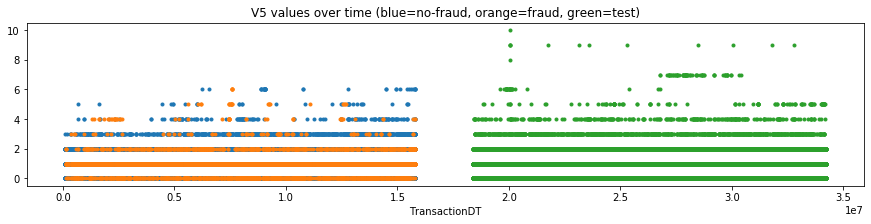

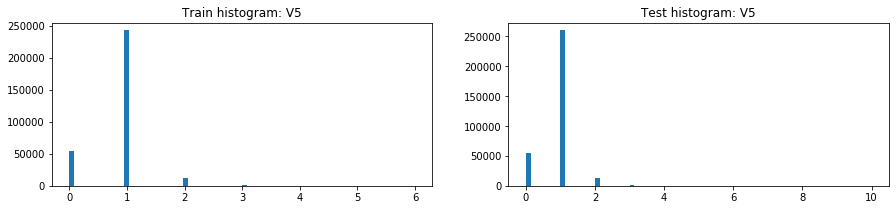

V5          Train   Train fraud  Train Not fraud  \
0           count  311253.000000   6106.000000    305147.000000   
1            mean       0.876991      1.001146         0.874506   
2             std       0.475902      0.665395         0.471002   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       6.000000      6.000000         6.000000   
8   unique values       8.000000      8.000000         8.000000   
9            NaNs  279287.000000  14557.000000    264730.000000   
10     NaNs share       0.472900      0.704500         0.464500   

             Test   Test public   Test private  
0   330173.000000  74232.000000  255942.000000  
1        0.884697      0.879930       0.886080  
2        0.483297      0.488099       0.481887  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       10.000000     10.000000       9.000000  
8       12.000000     11.000000      10.000000  
9   176518.000000  27107.000000  149411.000000  
10       0.348400      0.267500       0.368600

V5  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 279287     0.052122       14557         176518
1    1.0                 242883     0.018383        4465         259837
2    0.0                  54276     0.017448         947          55494
3    2.0                  12610     0.042902         541          13196
4    3.0                   1200     0.063333          76           1137
5    4.0                    193     0.264249          51            291
6    5.0                     55     0.400000          22            111
7    6.0                     36     0.111111           4             31

V5  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          279287     0.052122              14557         176518
1    1.0          242883     0.018383               4465         259837
2    0.0           54276     0.017448                947          55494
3    2.0           12610     0.042902                541          13196
4    3.0            1200     0.063333                 76           1137
5    4.0             193     0.264249                 51            291
6    5.0              55     0.400000                 22            111
7    6.0              36     0.111111                  4             31

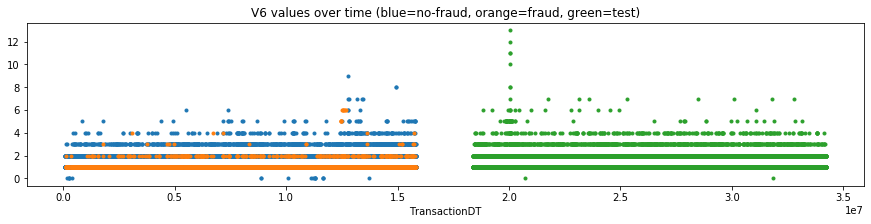

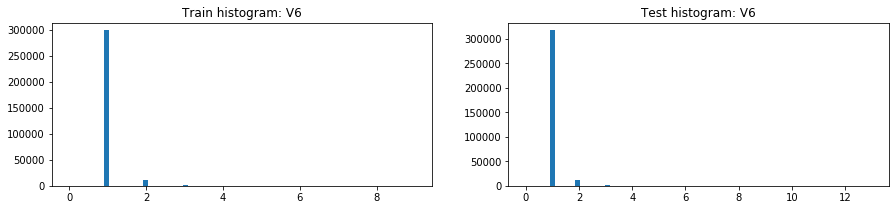

V6          Train   Train fraud  Train Not fraud  \
0           count  311253.000000   6106.000000    305147.000000   
1            mean       1.045686      1.063544         1.045329   
2             std       0.239385      0.310700         0.237727   
3             min       0.000000      1.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       9.000000      6.000000         9.000000   
8   unique values      11.000000      7.000000        11.000000   
9            NaNs  279287.000000  14557.000000    264730.000000   
10     NaNs share       0.472900      0.704500         0.464500   

             Test   Test public   Test private  
0   330173.000000  74232.000000  255942.000000  
1        1.045940      1.049776       1.044827  
2        0.244112      0.272326       0.235285  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       13.000000     13.000000       7.000000  
8       14.000000     14.000000       9.000000  
9   176518.000000  27107.000000  149411.000000  
10       0.348400      0.267500       0.368600

V6  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 298627     0.019349        5778       316806.0
1 -999.0                 279287     0.052122       14557       176518.0
2    2.0                  11319     0.026416         299        12027.0
3    3.0                   1044     0.013410          14         1023.0
4    4.0                    180     0.027778           5          235.0
5    5.0                     46     0.086957           4           48.0
6    0.0                     18     0.000000           0            2.0
7    6.0                     11     0.545455           6           16.0
8    7.0                      5     0.000000           0            9.0
9    8.0                      2     0.000000           0            2.0

V6  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          279287     0.052122              14557         176518
1    1.0          298627     0.019349               5778         316806
2    2.0           11319     0.026416                299          12027
3    3.0            1044     0.013410                 14           1023
4    6.0              11     0.545455                  6             16
5    4.0             180     0.027778                  5            235
6    5.0              46     0.086957                  4             48
7    0.0              18     0.000000                  0              2
8    7.0               5     0.000000                  0              9
9    8.0               2     0.000000                  0              2

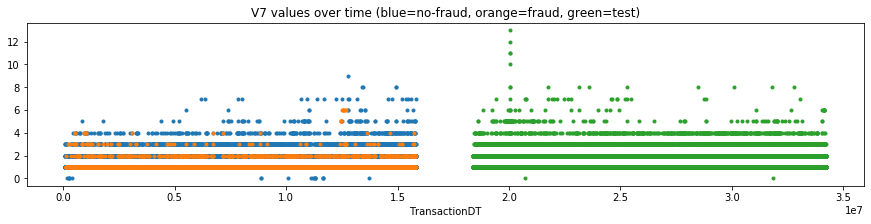

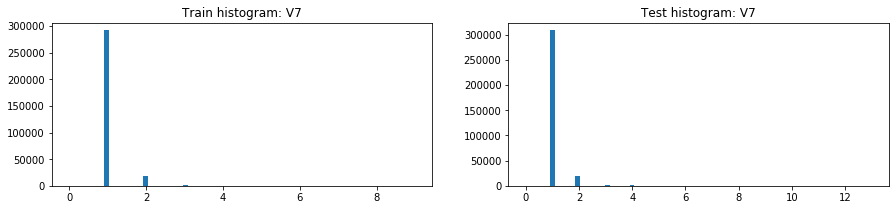

V7          Train   Train fraud  Train Not fraud  \
0           count  311253.000000   6106.000000    305147.000000   
1            mean       1.072870      1.123485         1.071857   
2             std       0.304779      0.413311         0.302124   
3             min       0.000000      1.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       9.000000      6.000000         9.000000   
8   unique values      11.000000      7.000000        11.000000   
9            NaNs  279287.000000  14557.000000    264730.000000   
10     NaNs share       0.472900      0.704500         0.464500   

             Test   Test public   Test private  
0   330173.000000  74232.000000  255942.000000  
1        1.079207      1.081690       1.078487  
2        0.330086      0.354006       0.322814  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       13.000000     13.000000       8.000000  
8       14.000000     14.000000      10.000000  
9   176518.000000  27107.000000  149411.000000  
10       0.348400      0.267500       0.368600

V7  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 291485     0.018807        5482       308215.0
1 -999.0                 279287     0.052122       14557       176518.0
2    2.0                  17464     0.030520         533        18901.0
3    3.0                   1823     0.037301          68         2243.0
4    4.0                    337     0.038576          13          613.0
5    5.0                     83     0.048193           4          136.0
6    7.0                     20     0.000000           0           22.0
7    0.0                     18     0.000000           0            2.0
8    6.0                     18     0.333333           6           26.0
9    8.0                      4     0.000000           0           10.0

V7  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          279287     0.052122              14557         176518
1    1.0          291485     0.018807               5482         308215
2    2.0           17464     0.030520                533          18901
3    3.0            1823     0.037301                 68           2243
4    4.0             337     0.038576                 13            613
5    6.0              18     0.333333                  6             26
6    5.0              83     0.048193                  4            136
7    7.0              20     0.000000                  0             22
8    0.0              18     0.000000                  0              2
9    8.0               4     0.000000                  0             10

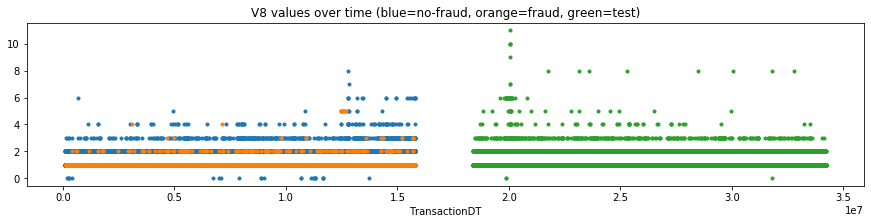

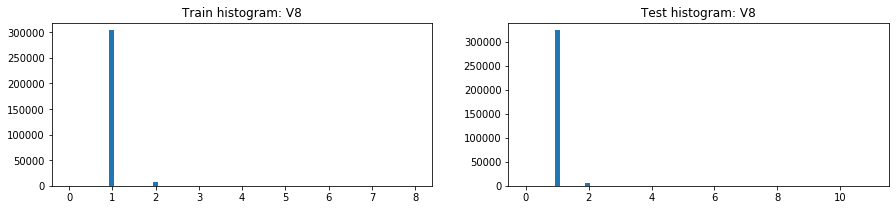

V8          Train   Train fraud  Train Not fraud  \
0           count  311253.000000   6106.000000    305147.000000   
1            mean       1.027704      1.048804         1.027282   
2             std       0.186069      0.271332         0.183936   
3             min       0.000000      1.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       8.000000      5.000000         8.000000   
8   unique values      10.000000      6.000000        10.000000   
9            NaNs  279287.000000  14557.000000    264730.000000   
10     NaNs share       0.472900      0.704500         0.464500   

             Test   Test public   Test private  
0   330173.000000  74232.000000  255942.000000  
1        1.022779      1.028829       1.021024  
2        0.174533      0.221694       0.158205  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       11.000000     11.000000       8.000000  
8       13.000000     13.000000       8.000000  
9   176518.000000  27107.000000  149411.000000  
10       0.348400      0.267500       0.368600

V8  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 303466     0.019307        5859         323436
1 -999.0                 279287     0.052122       14557         176518
2    2.0                   7076     0.030808         218           6206
3    3.0                    553     0.030741          17            408
4    4.0                     95     0.021053           2             58
5    0.0                     24     0.000000           0              3
6    6.0                     19     0.000000           0             27
7    5.0                     18     0.555556          10             20
8    7.0                      1     0.000000           0              2
9    8.0                      1     0.000000           0              8

V8  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          279287     0.052122              14557         176518
1    1.0          303466     0.019307               5859         323436
2    2.0            7076     0.030808                218           6206
3    3.0             553     0.030741                 17            408
4    5.0              18     0.555556                 10             20
5    4.0              95     0.021053                  2             58
6    0.0              24     0.000000                  0              3
7    6.0              19     0.000000                  0             27
8    7.0               1     0.000000                  0              2
9    8.0               1     0.000000                  0              8

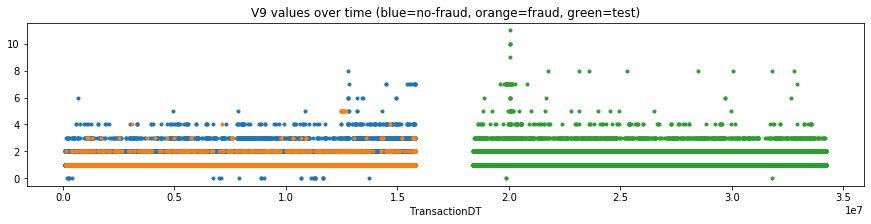

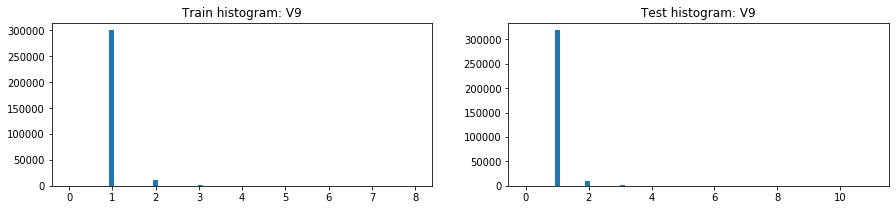

V9          Train   Train fraud  Train Not fraud  \
0           count  311253.000000   6106.000000    305147.000000   
1            mean       1.041529      1.102195         1.040315   
2             std       0.226339      0.356576         0.222790   
3             min       0.000000      1.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       8.000000      5.000000         8.000000   
8   unique values      10.000000      6.000000        10.000000   
9            NaNs  279287.000000  14557.000000    264730.000000   
10     NaNs share       0.472900      0.704500         0.464500   

             Test   Test public   Test private  
0   330173.000000  74232.000000  255942.000000  
1        1.039876      1.045008       1.038388  
2        0.226182      0.271224       0.211306  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       11.000000     11.000000       8.000000  
8       13.000000     13.000000      10.000000  
9   176518.000000  27107.000000  149411.000000  
10       0.348400      0.267500       0.368600

V9  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 299625     0.018547        5557         318347
1 -999.0                 279287     0.052122       14557         176518
2    2.0                  10544     0.047136         497          10859
3    3.0                    848     0.045991          39            765
4    4.0                    172     0.017442           3            126
5    0.0                     24     0.000000           0              3
6    5.0                     19     0.526316          10             25
7    7.0                     11     0.000000           0             26
8    6.0                      9     0.000000           0              9
9    8.0                      1     0.000000           0              8

V9  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          279287     0.052122              14557         176518
1    1.0          299625     0.018547               5557         318347
2    2.0           10544     0.047136                497          10859
3    3.0             848     0.045991                 39            765
4    5.0              19     0.526316                 10             25
5    4.0             172     0.017442                  3            126
6    0.0              24     0.000000                  0              3
7    7.0              11     0.000000                  0             26
8    6.0               9     0.000000                  0              9
9    8.0               1     0.000000                  0              8

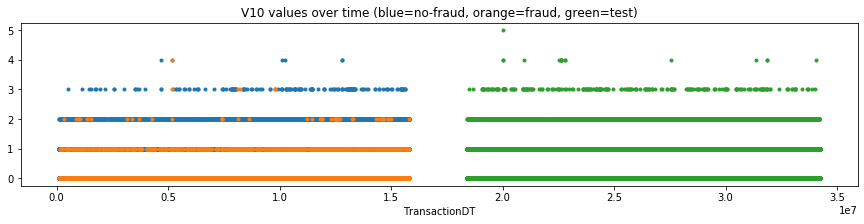

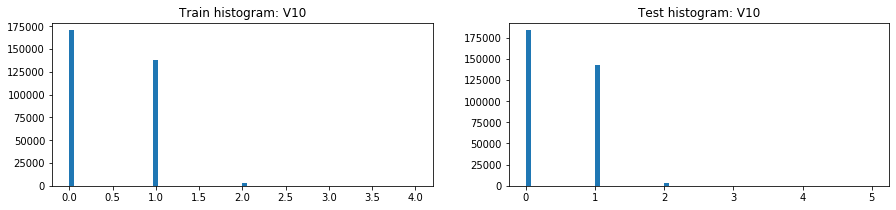

V10          Train   Train fraud  Train Not fraud  \
0           count  311253.000000   6106.000000    305147.000000   
1            mean       0.463915      0.188667         0.469423   
2             std       0.521522      0.421117         0.521856   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       1.000000      0.000000         1.000000   
7             max       4.000000      4.000000         4.000000   
8   unique values       6.000000      6.000000         6.000000   
9            NaNs  279287.000000  14557.000000    264730.000000   
10     NaNs share       0.472900      0.704500         0.464500   

             Test   Test public   Test private  
0   330173.000000  74232.000000  255942.000000  
1        0.456621      0.458010       0.456217  
2        0.523406      0.525272       0.522864  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        1.000000      1.000000       1.000000  
7        5.000000      5.000000       4.000000  
8        7.000000      7.000000       6.000000  
9   176518.000000  27107.000000  149411.000000  
10       0.348400      0.267500       0.368600

V10  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 279287     0.052122       14557         176518
1    0.0                 170281     0.029481        5020         183374
2    1.0                 137743     0.007456        1027         143115
3    2.0                   3042     0.017423          53           3421
4    3.0                    180     0.027778           5            246
5    4.0                      7     0.142857           1             16

V10  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          279287     0.052122              14557         176518
1    0.0          170281     0.029481               5020         183374
2    1.0          137743     0.007456               1027         143115
3    2.0            3042     0.017423                 53           3421
4    3.0             180     0.027778                  5            246
5    4.0               7     0.142857                  1             16

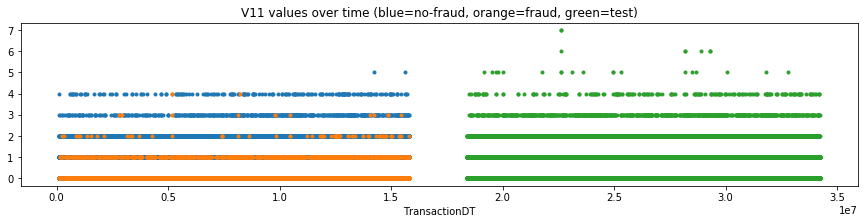

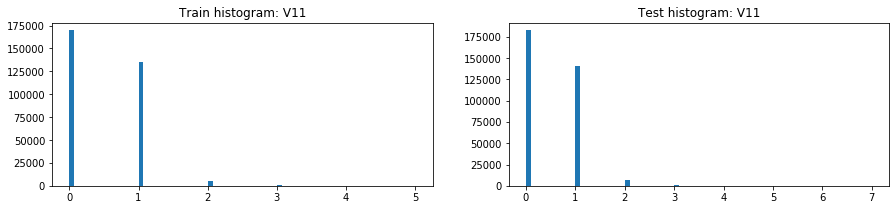

V11          Train   Train fraud  Train Not fraud  \
0           count  311253.000000   6106.000000    305147.000000   
1            mean       0.478987      0.198002         0.484609   
2             std       0.552431      0.447692         0.552870   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       1.000000      0.000000         1.000000   
7             max       5.000000      4.000000         5.000000   
8   unique values       7.000000      6.000000         7.000000   
9            NaNs  279287.000000  14557.000000    264730.000000   
10     NaNs share       0.472900      0.704500         0.464500   

             Test   Test public   Test private  
0   330173.000000  74232.000000  255942.000000  
1        0.473873      0.473677       0.473928  
2        0.558754      0.556013       0.559548  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        1.000000      1.000000       1.000000  
7        7.000000      5.000000       7.000000  
8        9.000000      7.000000       9.000000  
9   176518.000000  27107.000000  149411.000000  
10       0.348400      0.267500       0.368600

V11  Count in train (desc)  Mean target  Sum target  Count in test
0 -999.0                 279287     0.052122       14557         176518
1    0.0                 169633     0.029511        5006         182449
2    1.0                 135148     0.007451        1007         140332
3    2.0                   5672     0.013928          79           6301
4    3.0                    608     0.019737          12            875
5    4.0                    190     0.010526           2            189
6    5.0                      2     0.000000           0             19

V11  Count in train  Mean target  Sum target (desc)  Count in test
0 -999.0          279287     0.052122              14557         176518
1    0.0          169633     0.029511               5006         182449
2    1.0          135148     0.007451               1007         140332
3    2.0            5672     0.013928                 79           6301
4    3.0             608     0.019737                 12            875
5    4.0             190     0.010526                  2            189
6    5.0               2     0.000000                  0             19

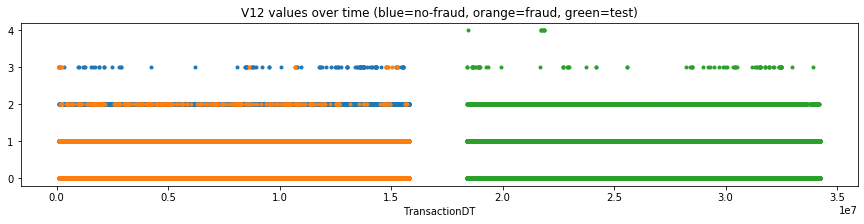

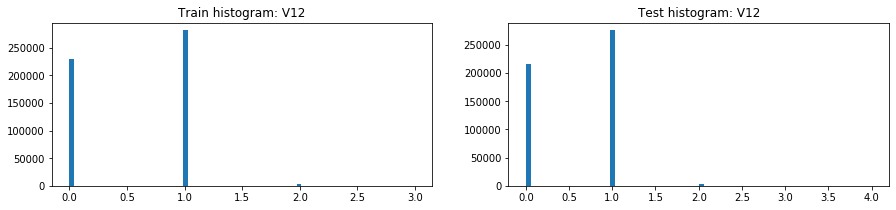

V12          Train   Train fraud  Train Not fraud  \
0           count  514467.000000  16776.000000    497691.000000   
1            mean       0.559711      0.413984         0.564623   
2             std       0.510533      0.548667         0.508471   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       1.000000      0.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       3.000000      3.000000         3.000000   
8   unique values       5.000000      5.000000         5.000000   
9            NaNs   76073.000000   3887.000000     72186.000000   
10     NaNs share       0.128800      0.188100         0.126700   

             Test   Test public   Test private  
0   494102.000000  93884.000000  400219.000000  
1        0.569816      0.664277       0.547655  
2        0.508138      0.489000       0.509998  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7        4.000000      4.000000       4.000000  
8        6.000000      6.000000       6.000000  
9    12589.000000   7455.000000    5134.000000  
10       0.024800      0.073600       0.012700

V12  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 281003     0.021420        6019         275401
1    0.0                 230049     0.044786       10303         215678
2 -999.0                  76073     0.051096        3887          12589
3    2.0                   3295     0.132322         436           2931
4    3.0                    120     0.150000          18             84

V12  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          230049     0.044786              10303         215678
1    1.0          281003     0.021420               6019         275401
2 -999.0           76073     0.051096               3887          12589
3    2.0            3295     0.132322                436           2931
4    3.0             120     0.150000                 18             84

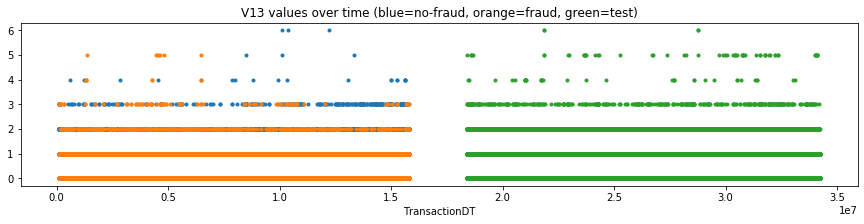

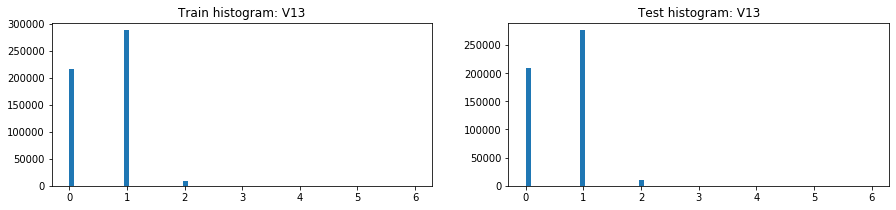

V13          Train   Train fraud  Train Not fraud  \
0           count  514467.000000  16776.000000    497691.000000   
1            mean       0.599166      0.466679         0.603632   
2             std       0.532185      0.619955         0.528395   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       1.000000      0.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       6.000000      5.000000         6.000000   
8   unique values       8.000000      7.000000         8.000000   
9            NaNs   76073.000000   3887.000000     72186.000000   
10     NaNs share       0.128800      0.188100         0.126700   

             Test   Test public   Test private  
0   494102.000000  93884.000000  400219.000000  
1        0.600435      0.701014       0.576839  
2        0.536276      0.513543       0.538759  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7        6.000000      5.000000       6.000000  
8        8.000000      7.000000       8.000000  
9    12589.000000   7455.000000    5134.000000  
10       0.024800      0.073600       0.012700

V13  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 287644     0.020890        6009         275677
1    0.0                 216752     0.045780        9923         208273
2 -999.0                  76073     0.051096        3887          12589
3    2.0                   9661     0.075872         733           9623
4    3.0                    371     0.261456          97            430
5    4.0                     26     0.269231           7             36
6    5.0                     10     0.700000           7             59
7    6.0                      3     0.000000           0              4

V13  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          216752     0.045780               9923         208273
1    1.0          287644     0.020890               6009         275677
2 -999.0           76073     0.051096               3887          12589
3    2.0            9661     0.075872                733           9623
4    3.0             371     0.261456                 97            430
5    4.0              26     0.269231                  7             36
6    5.0              10     0.700000                  7             59
7    6.0               3     0.000000                  0              4

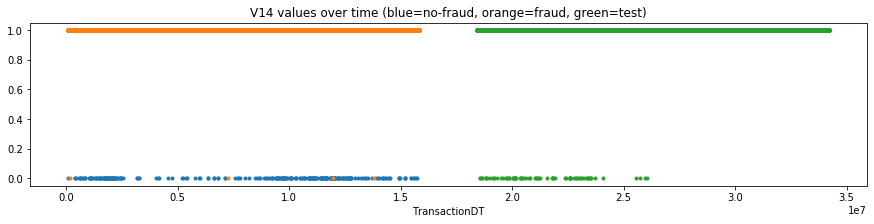

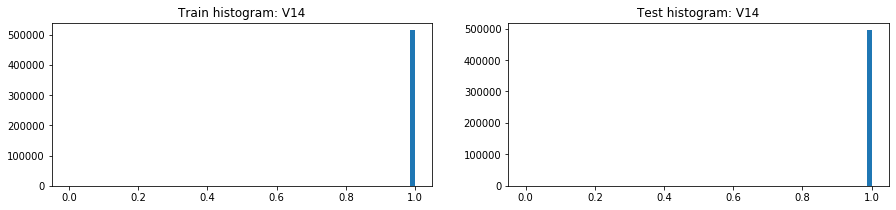

V14          Train   Train fraud  Train Not fraud  \
0           count  514467.000000  16776.000000    497691.000000   
1            mean       0.999500      0.999762         0.999492   
2             std       0.022345      0.015440         0.022541   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       1.000000      1.000000         1.000000   
8   unique values       3.000000      3.000000         3.000000   
9            NaNs   76073.000000   3887.000000     72186.000000   
10     NaNs share       0.128800      0.188100         0.126700   

             Test   Test public   Test private  
0   494102.000000  93884.000000  400219.000000  
1        0.999846      0.999553       0.999915  
2        0.012401      0.021146       0.009217  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7        1.000000      1.000000       1.000000  
8        3.000000      3.000000       3.000000  
9    12589.000000   7455.000000    5134.000000  
10       0.024800      0.073600       0.012700

V14  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 514210     0.032617       16772         494026
1 -999.0                  76073     0.051096        3887          12589
2    0.0                    257     0.015564           4             76

V14  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          514210     0.032617              16772         494026
1 -999.0           76073     0.051096               3887          12589
2    0.0             257     0.015564                  4             76

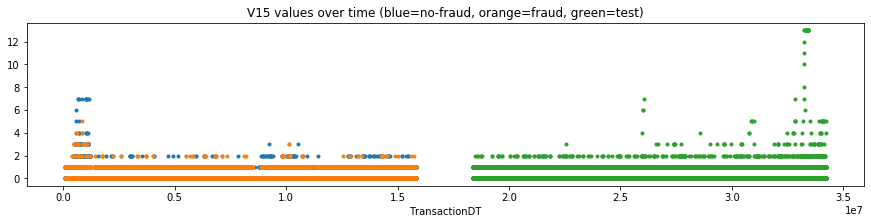

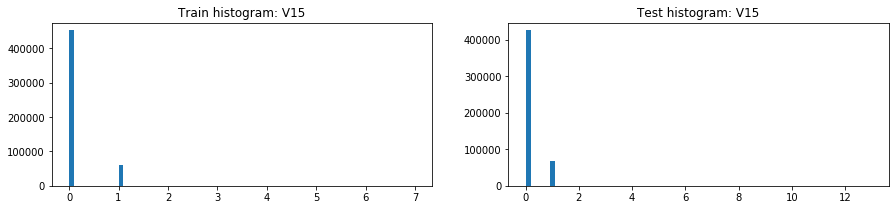

V15          Train   Train fraud  Train Not fraud  \
0           count  514467.000000  16776.000000    497691.000000   
1            mean       0.122342      0.444564         0.111481   
2             std       0.332422      0.514612         0.318881   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max       7.000000      5.000000         7.000000   
8   unique values       9.000000      7.000000         9.000000   
9            NaNs   76073.000000   3887.000000     72186.000000   
10     NaNs share       0.128800      0.188100         0.126700   

             Test   Test public   Test private  
0   494102.000000  93884.000000  400219.000000  
1        0.140963      0.104853       0.149433  
2        0.361034      0.307926       0.371890  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7       13.000000      2.000000      13.000000  
8       14.000000      4.000000      14.000000  
9    12589.000000   7455.000000    5134.000000  
10       0.024800      0.073600       0.012700

V15  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 452075     0.020886        9442         425298
1 -999.0                  76073     0.051096        3887          12589
2    1.0                  61974     0.116678        7231          68326
3    2.0                    346     0.248555          86            365
4    3.0                     48     0.291667          14             53
5    4.0                     10     0.200000           2             15
6    7.0                     10     0.000000           0              3
7    5.0                      3     0.333333           1             20
8    6.0                      1     0.000000           0              3

V15  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          452075     0.020886               9442         425298
1    1.0           61974     0.116678               7231          68326
2 -999.0           76073     0.051096               3887          12589
3    2.0             346     0.248555                 86            365
4    3.0              48     0.291667                 14             53
5    4.0              10     0.200000                  2             15
6    5.0               3     0.333333                  1             20
7    7.0              10     0.000000                  0              3
8    6.0               1     0.000000                  0              3

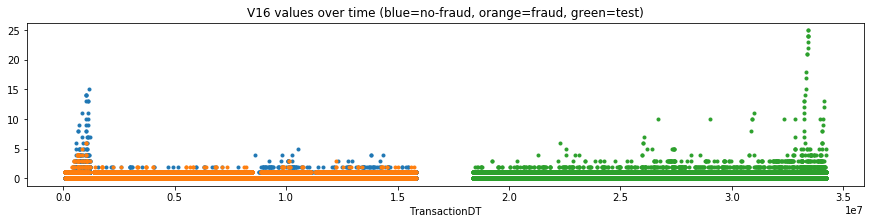

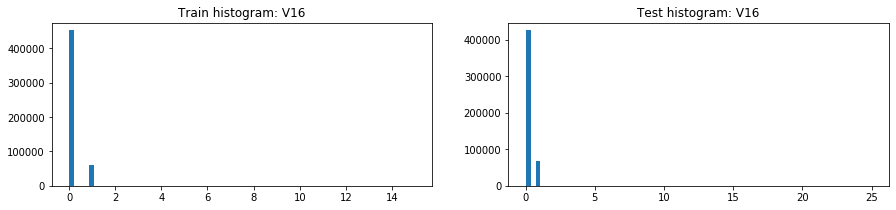

V16          Train   Train fraud  Train Not fraud  \
0           count  514467.000000  16776.000000    497691.000000   
1            mean       0.123460      0.448975         0.112487   
2             std       0.342841      0.530912         0.329104   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max      15.000000      6.000000        15.000000   
8   unique values      16.000000      8.000000        16.000000   
9            NaNs   76073.000000   3887.000000     72186.000000   
10     NaNs share       0.128800      0.188100         0.126700   

             Test   Test public   Test private  
0   494102.000000  93884.000000  400219.000000  
1        0.142317      0.104991       0.151072  
2        0.379262      0.308725       0.393472  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7       25.000000      4.000000      25.000000  
8       24.000000      6.000000      24.000000  
9    12589.000000   7455.000000    5134.000000  
10       0.024800      0.073600       0.012700

V16  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 452052     0.020887        9442         425270
1 -999.0                  76073     0.051096        3887          12589
2    1.0                  61749     0.116569        7198          68099
3    2.0                    481     0.199584          96            476
4    3.0                    101     0.227723          23            156
5    4.0                     42     0.333333          14             37
6    5.0                     12     0.083333           1             20
7    6.0                      7     0.285714           2              7
8    7.0                      5     0.000000           0              3
9    8.0                      4     0.000000           0              4

V16  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          452052     0.020887               9442         425270
1    1.0           61749     0.116569               7198          68099
2 -999.0           76073     0.051096               3887          12589
3    2.0             481     0.199584                 96            476
4    3.0             101     0.227723                 23            156
5    4.0              42     0.333333                 14             37
6    6.0               7     0.285714                  2              7
7    5.0              12     0.083333                  1             20
8    7.0               5     0.000000                  0              3
9    8.0               4     0.000000                  0              4

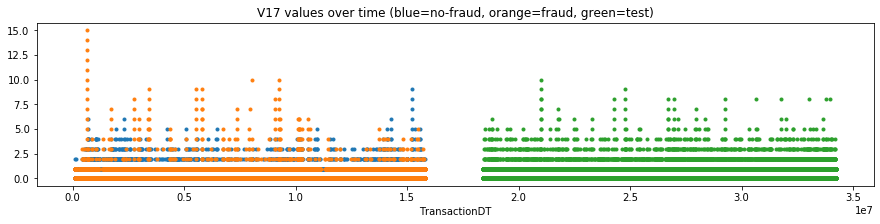

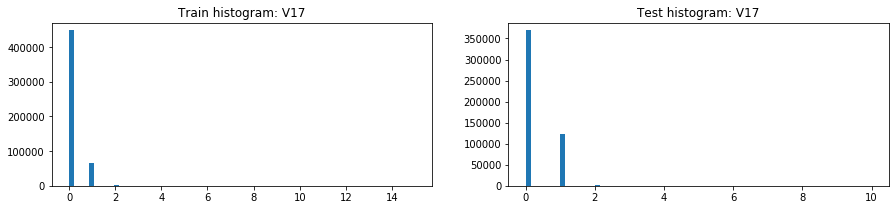

V17          Train   Train fraud  Train Not fraud  \
0           count  514467.000000  16776.000000    497691.000000   
1            mean       0.134040      0.496662         0.121817   
2             std       0.364456      0.738461         0.338147   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max      15.000000     15.000000         9.000000   
8   unique values      17.000000     17.000000        11.000000   
9            NaNs   76073.000000   3887.000000     72186.000000   
10     NaNs share       0.128800      0.188100         0.126700   

             Test   Test public   Test private  
0   494102.000000  93884.000000  400219.000000  
1        0.259778      0.121107       0.292307  
2        0.461083      0.357741       0.476318  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        1.000000      0.000000       1.000000  
7       10.000000     10.000000       9.000000  
8       12.000000     12.000000      11.000000  
9    12589.000000   7455.000000    5134.000000  
10       0.024800      0.073600       0.012700

V17  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 447823     0.021086        9443       369022.0
1 -999.0                  76073     0.051096        3887        12589.0
2    1.0                  65244     0.105634        6892       122807.0
3    2.0                    927     0.237325         220         1676.0
4    3.0                    274     0.346715          95          365.0
5    4.0                    104     0.480769          50          143.0
6    5.0                     40     0.700000          28           46.0
7    6.0                     21     0.809524          17           19.0
8    7.0                     12     0.916667          11            9.0
9    8.0                      8     0.875000           7           12.0

V17  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          447823     0.021086               9443         369022
1    1.0           65244     0.105634               6892         122807
2 -999.0           76073     0.051096               3887          12589
3    2.0             927     0.237325                220           1676
4    3.0             274     0.346715                 95            365
5    4.0             104     0.480769                 50            143
6    5.0              40     0.700000                 28             46
7    6.0              21     0.809524                 17             19
8    7.0              12     0.916667                 11              9
9    8.0               8     0.875000                  7             12

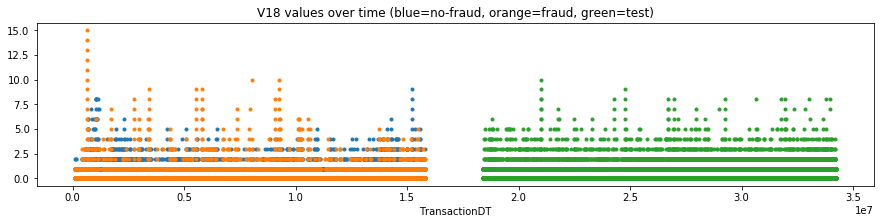

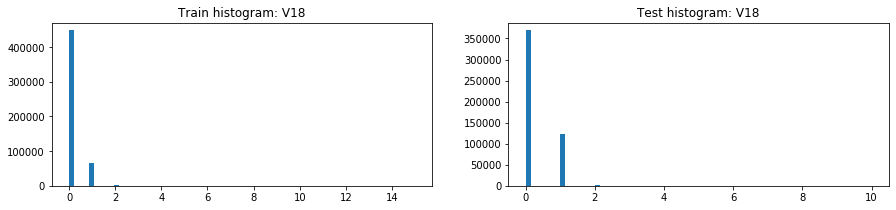

V18          Train   Train fraud  Train Not fraud  \
0           count  514467.000000  16776.000000    497691.000000   
1            mean       0.135363      0.505007         0.122904   
2             std       0.371763      0.755766         0.344751   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max      15.000000     15.000000         9.000000   
8   unique values      17.000000     17.000000        11.000000   
9            NaNs   76073.000000   3887.000000     72186.000000   
10     NaNs share       0.128800      0.188100         0.126700   

             Test   Test public   Test private  
0   494102.000000  93884.000000  400219.000000  
1        0.261657      0.121959       0.294426  
2        0.467456      0.362981       0.482925  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        1.000000      0.000000       1.000000  
7       10.000000     10.000000       9.000000  
8       12.000000     12.000000      11.000000  
9    12589.000000   7455.000000    5134.000000  
10       0.024800      0.073600       0.012700

V18  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 447792     0.021083        9441       368966.0
1 -999.0                  76073     0.051096        3887        12589.0
2    1.0                  64889     0.105087        6819       122201.0
3    2.0                   1155     0.208658         241         2216.0
4    3.0                    388     0.373711         145          443.0
5    4.0                    120     0.425000          51          160.0
6    5.0                     48     0.604167          29           64.0
7    6.0                     32     0.593750          19           21.0
8    7.0                     16     0.687500          11           15.0
9    8.0                     13     0.538462           7           13.0

V18  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          447792     0.021083               9441         368966
1    1.0           64889     0.105087               6819         122201
2 -999.0           76073     0.051096               3887          12589
3    2.0            1155     0.208658                241           2216
4    3.0             388     0.373711                145            443
5    4.0             120     0.425000                 51            160
6    5.0              48     0.604167                 29             64
7    6.0              32     0.593750                 19             21
8    7.0              16     0.687500                 11             15
9    8.0              13     0.538462                  7             13

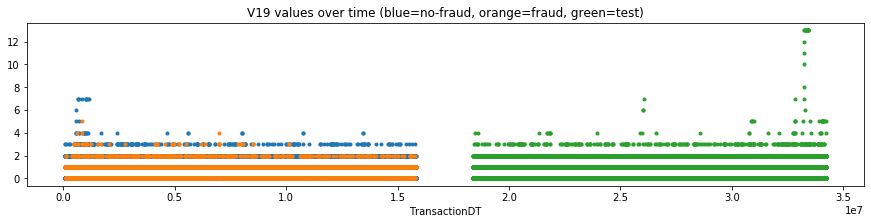

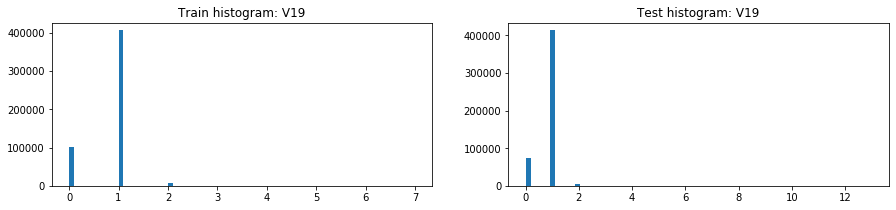

V19          Train   Train fraud  Train Not fraud  \
0           count  514467.000000  16776.000000    497691.000000   
1            mean       0.816371      0.887995         0.813957   
2             std       0.425512      0.429226         0.425176   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       7.000000      5.000000         7.000000   
8   unique values       9.000000      7.000000         9.000000   
9            NaNs   76073.000000   3887.000000     72186.000000   
10     NaNs share       0.128800      0.188100         0.126700   

             Test   Test public  Test private  
0   494102.000000  93884.000000  400219.00000  
1        0.861490      0.832037       0.86840  
2        0.392307      0.408003       0.38821  
3        0.000000      0.000000       0.00000  
4        1.000000      1.000000       1.00000  
5        1.000000      1.000000       1.00000  
6        1.000000      1.000000       1.00000  
7       13.000000      4.000000      13.00000  
8       14.000000      6.000000      14.00000  
9    12589.000000   7455.000000    5134.00000  
10       0.024800      0.073600       0.01270

V19  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 405665     0.033705       13673         412869
1    0.0                 101871     0.024757        2522          75188
2 -999.0                  76073     0.051096        3887          12589
3    2.0                   6540     0.080122         524           5611
4    3.0                    348     0.152299          53            358
5    4.0                     29     0.103448           3             31
6    7.0                     10     0.000000           0              3
7    5.0                      3     0.333333           1             20
8    6.0                      1     0.000000           0              3

V19  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          405665     0.033705              13673         412869
1 -999.0           76073     0.051096               3887          12589
2    0.0          101871     0.024757               2522          75188
3    2.0            6540     0.080122                524           5611
4    3.0             348     0.152299                 53            358
5    4.0              29     0.103448                  3             31
6    5.0               3     0.333333                  1             20
7    7.0              10     0.000000                  0              3
8    6.0               1     0.000000                  0              3

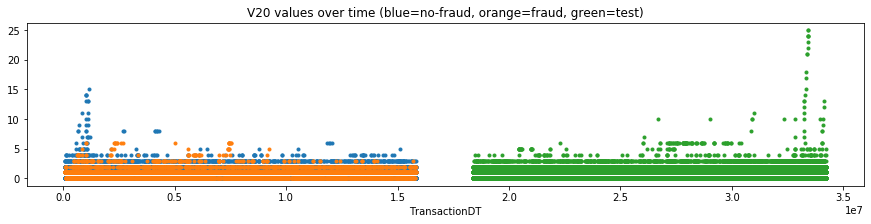

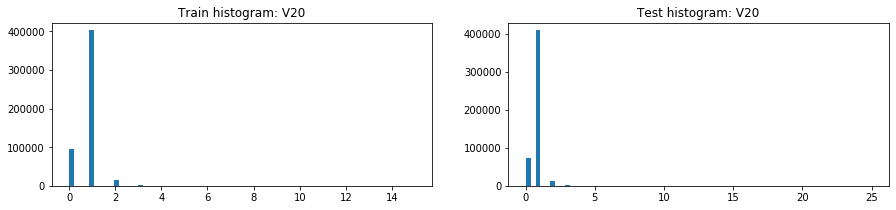

V20          Train   Train fraud  Train Not fraud  \
0           count  514467.000000  16776.000000     497691.00000   
1            mean       0.847843      0.948796          0.84444   
2             std       0.459451      0.525761          0.45666   
3             min       0.000000      0.000000          0.00000   
4             25%       1.000000      1.000000          1.00000   
5             50%       1.000000      1.000000          1.00000   
6             75%       1.000000      1.000000          1.00000   
7             max      15.000000      6.000000         15.00000   
8   unique values      16.000000      8.000000         16.00000   
9            NaNs   76073.000000   3887.000000      72186.00000   
10     NaNs share       0.128800      0.188100          0.12670   

             Test   Test public   Test private  
0   494102.000000  93884.000000  400219.000000  
1        0.885503      0.857398       0.892097  
2        0.436220      0.435610       0.436101  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       25.000000      5.000000      25.000000  
8       24.000000      7.000000      24.000000  
9    12589.000000   7455.000000    5134.000000  
10       0.024800      0.073600       0.012700

V20  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 401929     0.033501       13465         407937
1    0.0                  96318     0.023402        2254          72522
2 -999.0                  76073     0.051096        3887          12589
3    2.0                  14902     0.055831         832          12171
4    3.0                   1070     0.148598         159           1199
5    4.0                    161     0.229814          37            111
6    5.0                     30     0.366667          11             51
7    6.0                     27     0.666667          18             74
8    8.0                     11     0.000000           0              4
9    7.0                      5     0.000000           0              3

V20  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          401929     0.033501              13465         407937
1 -999.0           76073     0.051096               3887          12589
2    0.0           96318     0.023402               2254          72522
3    2.0           14902     0.055831                832          12171
4    3.0            1070     0.148598                159           1199
5    4.0             161     0.229814                 37            111
6    6.0              27     0.666667                 18             74
7    5.0              30     0.366667                 11             51
8    8.0              11     0.000000                  0              4
9    7.0               5     0.000000                  0              3

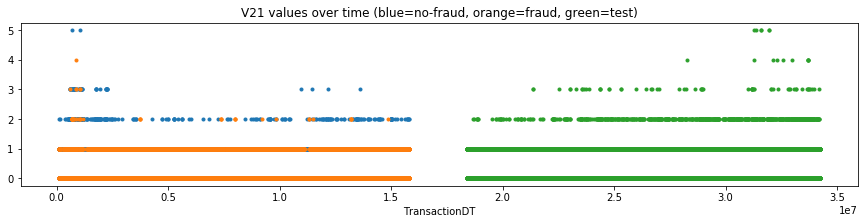

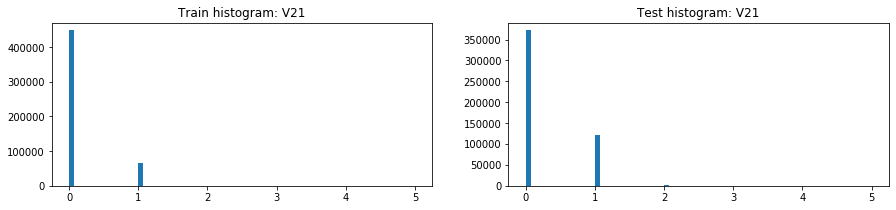

V21          Train   Train fraud  Train Not fraud  \
0           count  514467.000000  16776.000000    497691.000000   
1            mean       0.129684      0.436218         0.119351   
2             std       0.339060      0.502972         0.327163   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max       5.000000      4.000000         5.000000   
8   unique values       7.000000      6.000000         6.000000   
9            NaNs   76073.000000   3887.000000     72186.000000   
10     NaNs share       0.128800      0.188100         0.126700   

             Test   Test public   Test private  
0   494102.000000  93884.000000  400219.000000  
1        0.249799      0.114652       0.281501  
2        0.438383      0.320138       0.455994  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       1.000000  
7        5.000000      3.000000       5.000000  
8        7.000000      5.000000       7.000000  
9    12589.000000   7455.000000    5134.000000  
10       0.024800      0.073600       0.012700

V21  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 448220     0.021215        9509         371730
1 -999.0                  76073     0.051096        3887          12589
2    1.0                  65837     0.109710        7223         121417
3    2.0                    354     0.107345          38            878
4    3.0                     53     0.094340           5             61
5    5.0                      2     0.000000           0              6
6    4.0                      1     1.000000           1             10

V21  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          448220     0.021215               9509         371730
1    1.0           65837     0.109710               7223         121417
2 -999.0           76073     0.051096               3887          12589
3    2.0             354     0.107345                 38            878
4    3.0              53     0.094340                  5             61
5    4.0               1     1.000000                  1             10
6    5.0               2     0.000000                  0              6

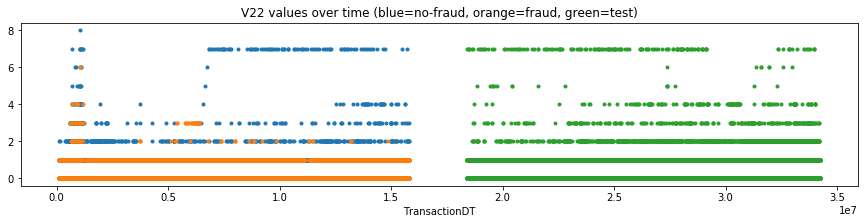

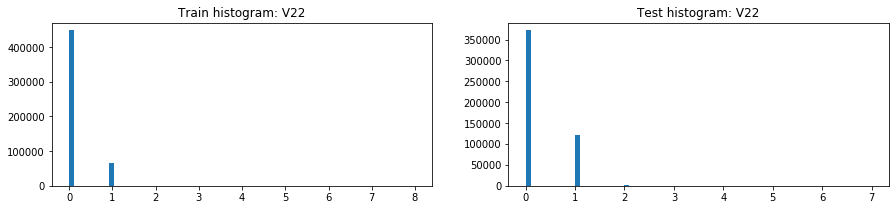

V22          Train   Train fraud  Train Not fraud  \
0           count  514467.000000  16776.000000    497691.000000   
1            mean       0.132292      0.443193         0.121813   
2             std       0.359415      0.525582         0.347641   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max       8.000000      6.000000         8.000000   
8   unique values      10.000000      7.000000        10.000000   
9            NaNs   76073.000000   3887.000000     72186.000000   
10     NaNs share       0.128800      0.188100         0.126700   

             Test   Test public   Test private  
0   494102.000000  93884.000000  400219.000000  
1        0.254431      0.117752       0.286493  
2        0.464469      0.350313       0.481809  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       1.000000  
7        7.000000      7.000000       7.000000  
8        9.000000      8.000000       9.000000  
9    12589.000000   7455.000000    5134.000000  
10       0.024800      0.073600       0.012700

V22  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 448185     0.021212        9507       371688.0
1 -999.0                  76073     0.051096        3887        12589.0
2    1.0                  65334     0.109698        7167       120501.0
3    2.0                    604     0.081126          49         1334.0
4    3.0                    169     0.272189          46          249.0
5    7.0                     94     0.000000           0          149.0
6    4.0                     63     0.079365           5          157.0
7    5.0                      9     0.000000           0           16.0
8    6.0                      8     0.250000           2            8.0
9    8.0                      1     0.000000           0            NaN

V22  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          448185     0.021212               9507       371688.0
1    1.0           65334     0.109698               7167       120501.0
2 -999.0           76073     0.051096               3887        12589.0
3    2.0             604     0.081126                 49         1334.0
4    3.0             169     0.272189                 46          249.0
5    4.0              63     0.079365                  5          157.0
6    6.0               8     0.250000                  2            8.0
7    7.0              94     0.000000                  0          149.0
8    5.0               9     0.000000                  0           16.0
9    8.0               1     0.000000                  0            NaN

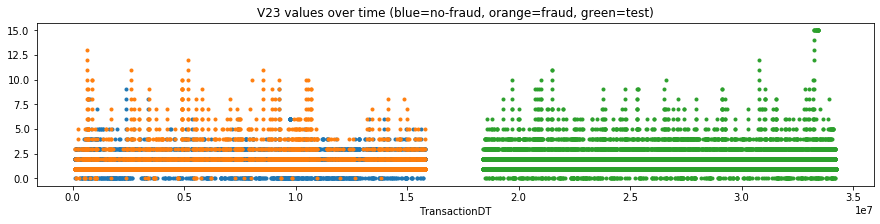

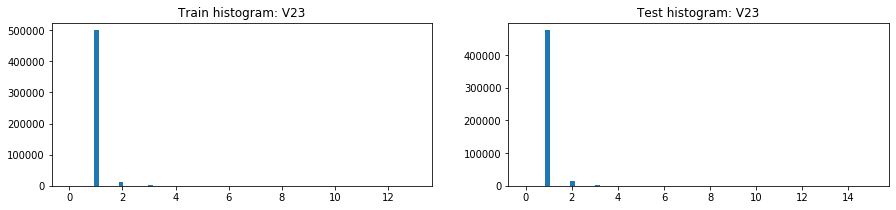

V23          Train   Train fraud  Train Not fraud  \
0           count  514467.000000  16776.000000    497691.000000   
1            mean       1.034791      1.236350         1.027997   
2             std       0.247681      0.860107         0.192518   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max      13.000000     13.000000         9.000000   
8   unique values      15.000000     15.000000        11.000000   
9            NaNs   76073.000000   3887.000000     72186.000000   
10     NaNs share       0.128800      0.188100         0.126700   

             Test   Test public   Test private  
0   494102.000000  93884.000000  400219.000000  
1        1.045493      1.046323       1.045298  
2        0.289516      0.294012       0.288451  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       15.000000     11.000000      15.000000  
8       17.000000     13.000000      17.000000  
9    12589.000000   7455.000000    5134.000000  
10       0.024800      0.073600       0.012700

V23  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 498764     0.029483       14705         475616
1 -999.0                  76073     0.051096        3887          12589
2    2.0                  13197     0.087747        1158          15463
3    3.0                   1244     0.313505         390           1622
4    0.0                    588     0.085034          50            367
5    4.0                    337     0.599407         202            615
6    5.0                    144     0.777778         112            186
7    6.0                     83     0.734940          61             94
8    7.0                     39     0.897436          35             61
9    8.0                     32     0.812500          26             29

V23  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          498764     0.029483              14705         475616
1 -999.0           76073     0.051096               3887          12589
2    2.0           13197     0.087747               1158          15463
3    3.0            1244     0.313505                390           1622
4    4.0             337     0.599407                202            615
5    5.0             144     0.777778                112            186
6    6.0              83     0.734940                 61             94
7    0.0             588     0.085034                 50            367
8    7.0              39     0.897436                 35             61
9    8.0              32     0.812500                 26             29

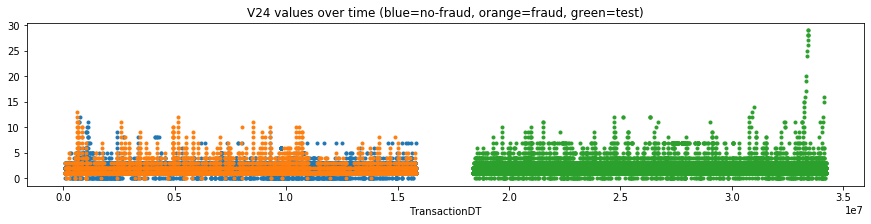

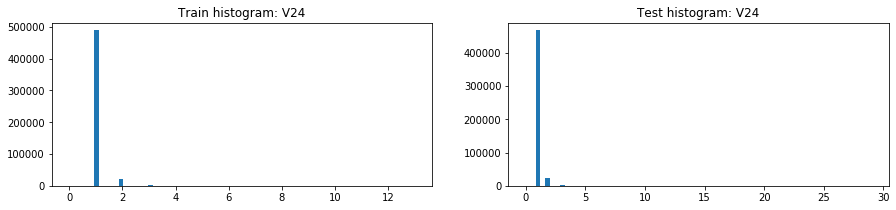

V24          Train   Train fraud  Train Not fraud  \
0           count  514467.000000  16776.000000    497691.000000   
1            mean       1.058097      1.264127         1.051152   
2             std       0.305485      0.889503         0.261379   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max      13.000000     13.000000        12.000000   
8   unique values      15.000000     15.000000        14.000000   
9            NaNs   76073.000000   3887.000000     72186.000000   
10     NaNs share       0.128800      0.188100         0.126700   

             Test   Test public   Test private  
0   494102.000000  93884.000000  400219.000000  
1        1.069415      1.070683       1.069117  
2        0.371149      0.350795       0.375764  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       29.000000     11.000000      29.000000  
8       27.000000     13.000000      27.000000  
9    12589.000000   7455.000000    5134.000000  
10       0.024800      0.073600       0.012700

V24  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 488478     0.029428       14375         466502
1 -999.0                  76073     0.051096        3887          12589
2    2.0                  22289     0.063664        1419          23104
3    3.0                   2241     0.196787         441           2803
4    0.0                    578     0.083045          48            364
5    4.0                    431     0.496520         214            642
6    5.0                    195     0.558974         109            246
7    6.0                     98     0.653061          64            110
8    7.0                     64     0.593750          38            218
9    8.0                     40     0.650000          26             32

V24  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          488478     0.029428              14375         466502
1 -999.0           76073     0.051096               3887          12589
2    2.0           22289     0.063664               1419          23104
3    3.0            2241     0.196787                441           2803
4    4.0             431     0.496520                214            642
5    5.0             195     0.558974                109            246
6    6.0              98     0.653061                 64            110
7    0.0             578     0.083045                 48            364
8    7.0              64     0.593750                 38            218
9    8.0              40     0.650000                 26             32

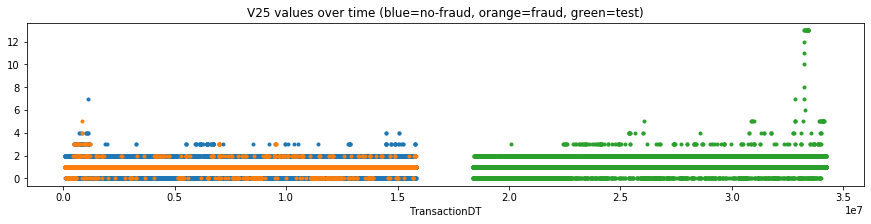

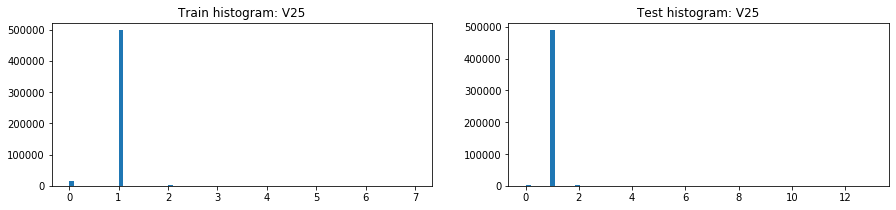

V25          Train   Train fraud  Train Not fraud  \
0           count  514467.000000  16776.000000    497691.000000   
1            mean       0.977660      0.981521         0.977530   
2             std       0.185245      0.235744         0.183299   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       7.000000      5.000000         7.000000   
8   unique values       8.000000      7.000000         7.000000   
9            NaNs   76073.000000   3887.000000     72186.000000   
10     NaNs share       0.128800      0.188100         0.126700   

             Test   Test public   Test private  
0   494102.000000  93884.000000  400219.000000  
1        1.004693      0.996283       1.006666  
2        0.133895      0.127897       0.135187  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       13.000000      3.000000      13.000000  
8       14.000000      5.000000      14.000000  
9    12589.000000   7455.000000    5134.000000  
10       0.024800      0.073600       0.012700

V25  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 497241     0.032091       15957         488731
1 -999.0                  76073     0.051096        3887          12589
2    0.0                  14465     0.040304         583           1754
3    2.0                   2569     0.078630         202           3420
4    3.0                    177     0.180791          32            127
5    4.0                     13     0.076923           1             27
6    5.0                      1     1.000000           1             21
7    7.0                      1     0.000000           0              2

V25  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          497241     0.032091              15957         488731
1 -999.0           76073     0.051096               3887          12589
2    0.0           14465     0.040304                583           1754
3    2.0            2569     0.078630                202           3420
4    3.0             177     0.180791                 32            127
5    4.0              13     0.076923                  1             27
6    5.0               1     1.000000                  1             21
7    7.0               1     0.000000                  0              2

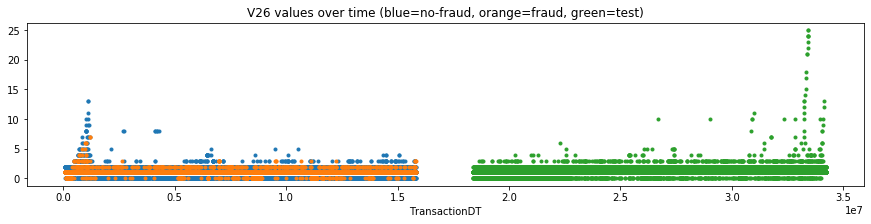

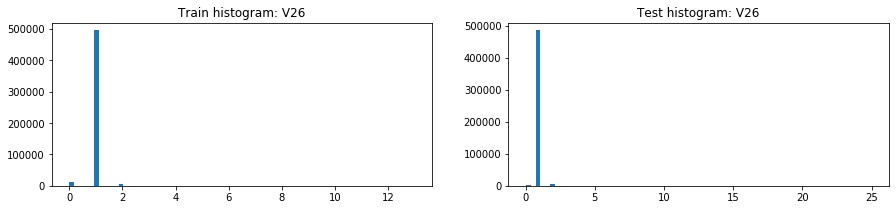

V26          Train   Train fraud  Train Not fraud  \
0           count  514467.000000  16776.000000    497691.000000   
1            mean       0.988040      1.006199         0.987428   
2             std       0.209302      0.289442         0.206031   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max      13.000000      7.000000        13.000000   
8   unique values      14.000000      9.000000        14.000000   
9            NaNs   76073.000000   3887.000000     72186.000000   
10     NaNs share       0.128800      0.188100         0.126700   

             Test   Test public   Test private  
0   494102.000000  93884.000000  400219.000000  
1        1.012959      1.004058       1.015047  
2        0.189354      0.148397       0.197679  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       25.000000      4.000000      25.000000  
8       24.000000      6.000000      24.000000  
9    12589.000000   7455.000000    5134.000000  
10       0.024800      0.073600       0.012700

V26  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 495119     0.031802       15746         485604
1 -999.0                  76073     0.051096        3887          12589
2    0.0                  13068     0.038950         509           1543
3    2.0                   5906     0.077210         456           6476
4    3.0                    271     0.191882          52            367
5    4.0                     50     0.120000           6             48
6    5.0                     17     0.117647           2             18
7    8.0                     13     0.000000           0              4
8    6.0                      8     0.375000           3              7
9    7.0                      7     0.285714           2              5

V26  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          495119     0.031802              15746         485604
1 -999.0           76073     0.051096               3887          12589
2    0.0           13068     0.038950                509           1543
3    2.0            5906     0.077210                456           6476
4    3.0             271     0.191882                 52            367
5    4.0              50     0.120000                  6             48
6    6.0               8     0.375000                  3              7
7    5.0              17     0.117647                  2             18
8    7.0               7     0.285714                  2              5
9    8.0              13     0.000000                  0              4

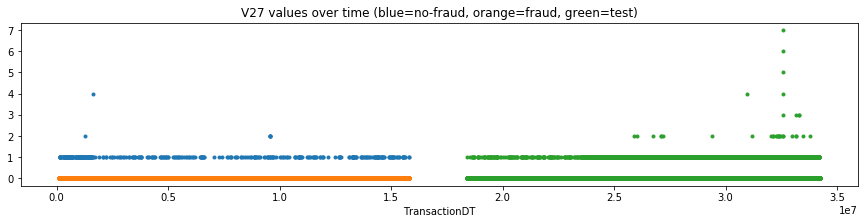

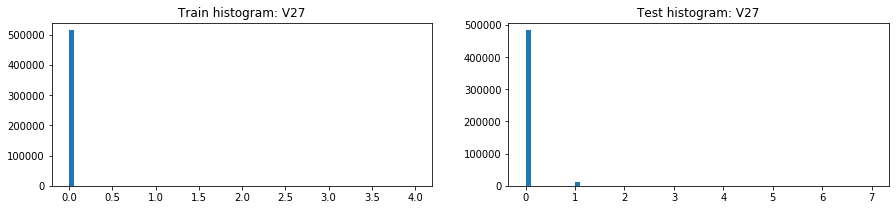

V27          Train  Train fraud  Train Not fraud           Test  \
0           count  514467.000000   16776.0000    497691.000000  494102.000000   
1            mean       0.000776       0.0000         0.000802       0.022649   
2             std       0.028596       0.0000         0.029073       0.150069   
3             min       0.000000       0.0000         0.000000       0.000000   
4             25%       0.000000       0.0000         0.000000       0.000000   
5             50%       0.000000       0.0000         0.000000       0.000000   
6             75%       0.000000       0.0000         0.000000       0.000000   
7             max       4.000000       0.0000         4.000000       7.000000   
8   unique values       5.000000       2.0000         5.000000       9.000000   
9            NaNs   76073.000000    3887.0000     72186.000000   12589.000000   
10     NaNs share       0.128800       0.1881         0.126700       0.024800   

     Test public   Test private  
0   93884.000000  400219.000000  
1       0.001204       0.027680  
2       0.034672       0.165495  
3       0.000000       0.000000  
4       0.000000       0.000000  
5       0.000000       0.000000  
6       0.000000       0.000000  
7       1.000000       7.000000  
8       3.000000       9.000000  
9    7455.000000    5134.000000  
10      0.073600       0.012700

V27  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 514076     0.032633       16776         482965
1 -999.0                  76073     0.051096        3887          12589
2    1.0                    385     0.000000           0          11103
3    2.0                      5     0.000000           0             25
4    4.0                      1     0.000000           0              2

V27  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          514076     0.032633              16776         482965
1 -999.0           76073     0.051096               3887          12589
2    1.0             385     0.000000                  0          11103
3    2.0               5     0.000000                  0             25
4    4.0               1     0.000000                  0              2

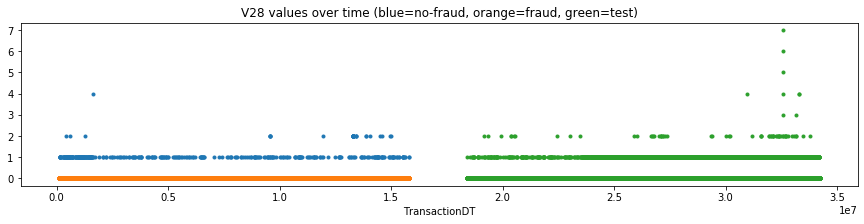

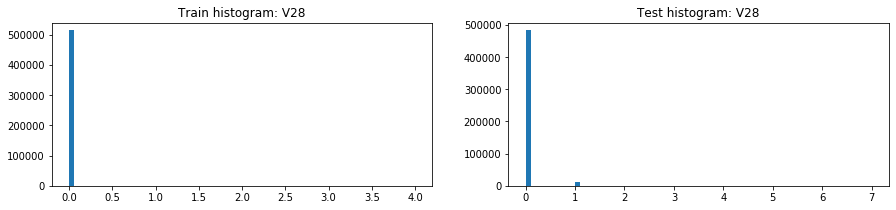

V28          Train  Train fraud  Train Not fraud           Test  \
0           count  514467.000000   16776.0000    497691.000000  494102.000000   
1            mean       0.000830       0.0000         0.000858       0.022738   
2             std       0.031133       0.0000         0.031653       0.150903   
3             min       0.000000       0.0000         0.000000       0.000000   
4             25%       0.000000       0.0000         0.000000       0.000000   
5             50%       0.000000       0.0000         0.000000       0.000000   
6             75%       0.000000       0.0000         0.000000       0.000000   
7             max       4.000000       0.0000         4.000000       7.000000   
8   unique values       5.000000       2.0000         5.000000       9.000000   
9            NaNs   76073.000000    3887.0000     72186.000000   12589.000000   
10     NaNs share       0.128800       0.1881         0.126700       0.024800   

     Test public   Test private  
0   93884.000000  400219.000000  
1       0.001289       0.027770  
2       0.037899       0.166263  
3       0.000000       0.000000  
4       0.000000       0.000000  
5       0.000000       0.000000  
6       0.000000       0.000000  
7       2.000000       7.000000  
8       4.000000       9.000000  
9    7455.000000    5134.000000  
10      0.073600       0.012700

V28  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 514073     0.032633       16776         482958
1 -999.0                  76073     0.051096        3887          12589
2    1.0                    363     0.000000           0          11075
3    2.0                     30     0.000000           0             60
4    4.0                      1     0.000000           0              4

V28  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          514073     0.032633              16776         482958
1 -999.0           76073     0.051096               3887          12589
2    1.0             363     0.000000                  0          11075
3    2.0              30     0.000000                  0             60
4    4.0               1     0.000000                  0              4

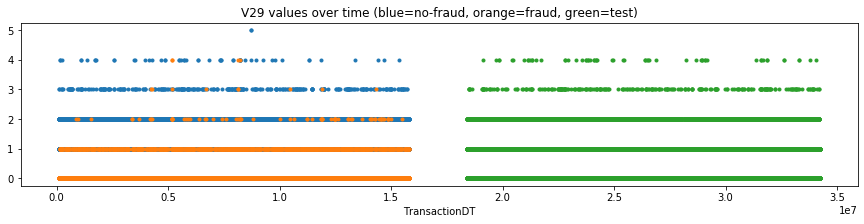

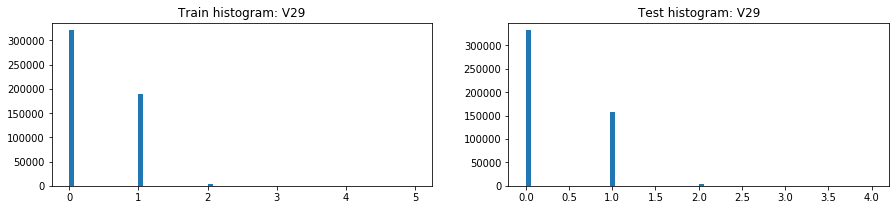

V29          Train   Train fraud  Train Not fraud  \
0           count  514467.000000  16776.000000    497691.000000   
1            mean       0.387840      0.087864         0.397952   
2             std       0.510652      0.307336         0.513065   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       1.000000      0.000000         1.000000   
7             max       5.000000      4.000000         5.000000   
8   unique values       7.000000      6.000000         7.000000   
9            NaNs   76073.000000   3887.000000     72186.000000   
10     NaNs share       0.128800      0.188100         0.126700   

             Test   Test public   Test private  
0   494102.000000  93884.000000  400219.000000  
1        0.337185      0.402518       0.321861  
2        0.493252      0.511875       0.487516  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        1.000000      1.000000       1.000000  
7        4.000000      4.000000       4.000000  
8        6.000000      6.000000       6.000000  
9    12589.000000   7455.000000    5134.000000  
10       0.024800      0.073600       0.012700

V29  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 320407     0.048067       15401       331940.0
1    1.0                 189060     0.006839        1293       158112.0
2 -999.0                  76073     0.051096        3887        12589.0
3    2.0                   4590     0.015033          69         3717.0
4    3.0                    351     0.025641           9          274.0
5    4.0                     57     0.070175           4           59.0
6    5.0                      2     0.000000           0            NaN

V29  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          320407     0.048067              15401       331940.0
1 -999.0           76073     0.051096               3887        12589.0
2    1.0          189060     0.006839               1293       158112.0
3    2.0            4590     0.015033                 69         3717.0
4    3.0             351     0.025641                  9          274.0
5    4.0              57     0.070175                  4           59.0
6    5.0               2     0.000000                  0            NaN

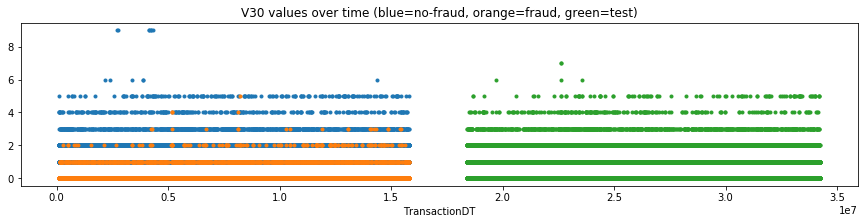

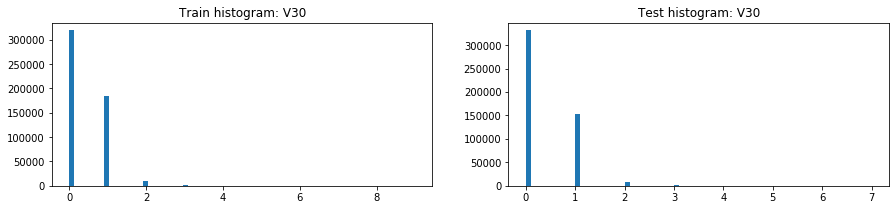

V30          Train   Train fraud  Train Not fraud  \
0           count  514467.000000  16776.000000    497691.000000   
1            mean       0.406436      0.095196         0.416927   
2             std       0.554311      0.334857         0.557192   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       1.000000      0.000000         1.000000   
7             max       9.000000      5.000000         9.000000   
8   unique values       9.000000      7.000000         9.000000   
9            NaNs   76073.000000   3887.000000     72186.000000   
10     NaNs share       0.128800      0.188100         0.126700   

             Test   Test public   Test private  
0   494102.000000  93884.000000  400219.000000  
1        0.352083      0.420253       0.336093  
2        0.530969      0.549402       0.525273  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        1.000000      1.000000       1.000000  
7        7.000000      6.000000       7.000000  
8        9.000000      8.000000       9.000000  
9    12589.000000   7455.000000    5134.000000  
10       0.024800      0.073600       0.012700

V30  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 319017     0.048157       15363       331104.0
1    1.0                 184133     0.006827        1257       153788.0
2 -999.0                  76073     0.051096        3887        12589.0
3    2.0                   9685     0.013733         133         7899.0
4    3.0                   1160     0.016379          19          979.0
5    4.0                    279     0.010753           3          225.0
6    5.0                    180     0.005556           1          102.0
7    9.0                      7     0.000000           0            NaN
8    6.0                      6     0.000000           0            3.0

V30  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          319017     0.048157              15363       331104.0
1 -999.0           76073     0.051096               3887        12589.0
2    1.0          184133     0.006827               1257       153788.0
3    2.0            9685     0.013733                133         7899.0
4    3.0            1160     0.016379                 19          979.0
5    4.0             279     0.010753                  3          225.0
6    5.0             180     0.005556                  1          102.0
7    9.0               7     0.000000                  0            NaN
8    6.0               6     0.000000                  0            3.0

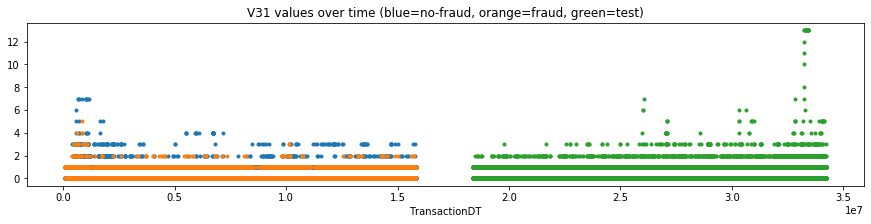

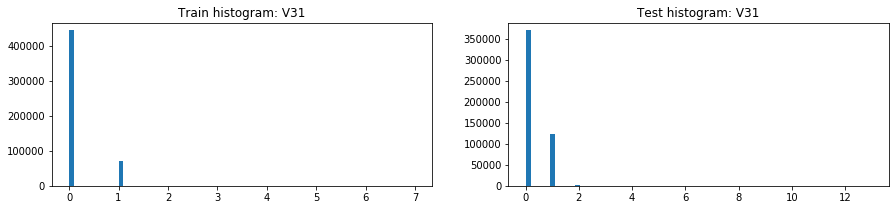

V31          Train   Train fraud  Train Not fraud  \
0           count  514467.000000  16776.000000    497691.000000   
1            mean       0.140761      0.456962         0.130103   
2             std       0.355793      0.516374         0.344070   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max       7.000000      5.000000         7.000000   
8   unique values       9.000000      7.000000         9.000000   
9            NaNs   76073.000000   3887.000000     72186.000000   
10     NaNs share       0.128800      0.188100         0.126700   

             Test   Test public   Test private  
0   494102.000000  93884.000000  400219.000000  
1        0.255544      0.120873       0.287135  
2        0.452590      0.328844       0.471455  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        1.000000      0.000000       1.000000  
7       13.000000      3.000000      13.000000  
8       14.000000      5.000000      14.000000  
9    12589.000000   7455.000000    5134.000000  
10       0.024800      0.073600       0.012700

V31  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 443045     0.020853        9239         369773
1 -999.0                  76073     0.051096        3887          12589
2    1.0                  70729     0.105035        7429         122946
3    2.0                    477     0.190776          91           1120
4    3.0                    167     0.083832          14            176
5    4.0                     33     0.060606           2             36
6    7.0                     10     0.000000           0              3
7    5.0                      5     0.200000           1             24
8    6.0                      1     0.000000           0              5

V31  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          443045     0.020853               9239         369773
1    1.0           70729     0.105035               7429         122946
2 -999.0           76073     0.051096               3887          12589
3    2.0             477     0.190776                 91           1120
4    3.0             167     0.083832                 14            176
5    4.0              33     0.060606                  2             36
6    5.0               5     0.200000                  1             24
7    7.0              10     0.000000                  0              3
8    6.0               1     0.000000                  0              5

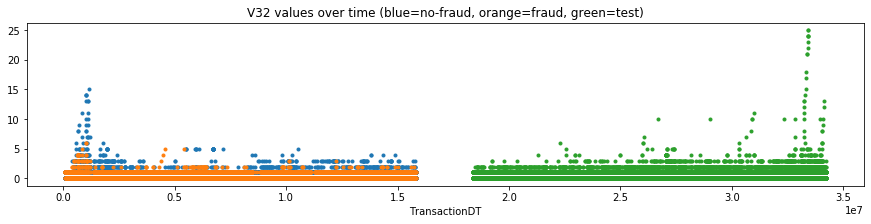

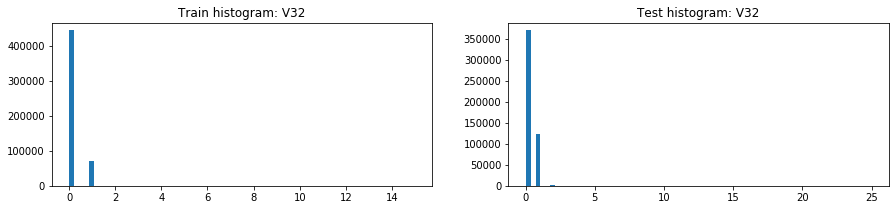

V32          Train   Train fraud  Train Not fraud  \
0           count  514467.000000  16776.000000    497691.000000   
1            mean       0.142417      0.463758         0.131586   
2             std       0.368278      0.538916         0.356108   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max      15.000000      6.000000        15.000000   
8   unique values      16.000000      8.000000        16.000000   
9            NaNs   76073.000000   3887.000000     72186.000000   
10     NaNs share       0.128800      0.188100         0.126700   

             Test   Test public   Test private  
0   494102.000000  93884.000000  400219.000000  
1        0.258289      0.121512       0.290374  
2        0.470983      0.331641       0.492587  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        1.000000      0.000000       1.000000  
7       25.000000      4.000000      25.000000  
8       24.000000      6.000000      24.000000  
9    12589.000000   7455.000000    5134.000000  
10       0.024800      0.073600       0.012700

V32  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 443018     0.020855        9239         369709
1 -999.0                  76073     0.051096        3887          12589
2    1.0                  70307     0.104755        7365         122196
3    2.0                    790     0.162025         128           1723
4    3.0                    226     0.106195          24            324
5    4.0                     51     0.294118          15             78
6    5.0                     44     0.068182           3             26
7    6.0                      8     0.250000           2              8
8    7.0                      5     0.000000           0              4
9    8.0                      4     0.000000           0              4

V32  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          443018     0.020855               9239         369709
1    1.0           70307     0.104755               7365         122196
2 -999.0           76073     0.051096               3887          12589
3    2.0             790     0.162025                128           1723
4    3.0             226     0.106195                 24            324
5    4.0              51     0.294118                 15             78
6    5.0              44     0.068182                  3             26
7    6.0               8     0.250000                  2              8
8    7.0               5     0.000000                  0              4
9    8.0               4     0.000000                  0              4

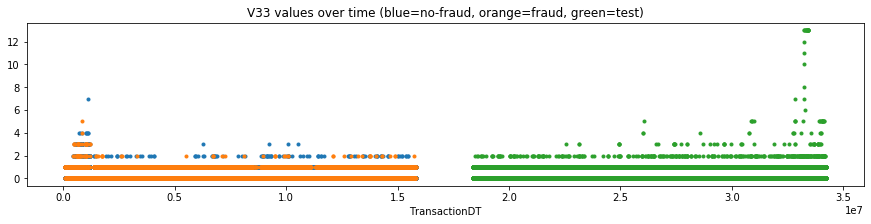

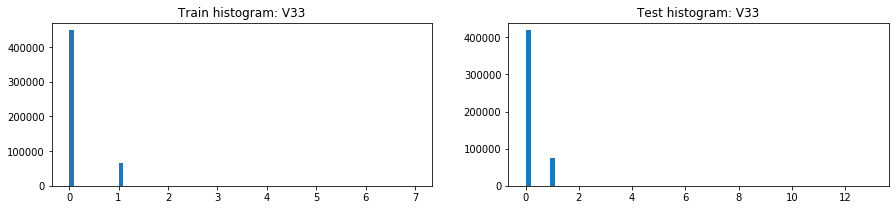

V33          Train   Train fraud  Train Not fraud  \
0           count  514467.000000  16776.000000    497691.000000   
1            mean       0.130693      0.471388         0.119209   
2             std       0.340900      0.518410         0.327150   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max       7.000000      5.000000         7.000000   
8   unique values       8.000000      7.000000         7.000000   
9            NaNs   76073.000000   3887.000000     72186.000000   
10     NaNs share       0.128800      0.188100         0.126700   

             Test   Test public   Test private  
0   494102.000000  93884.000000  400219.000000  
1        0.154984      0.119903       0.163213  
2        0.374251      0.326616       0.384108  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7       13.000000      2.000000      13.000000  
8       14.000000      4.000000      14.000000  
9    12589.000000   7455.000000    5134.000000  
10       0.024800      0.073600       0.012700

V33  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 447769     0.020100        9000         418368
1 -999.0                  76073     0.051096        3887          12589
2    1.0                  66267     0.115774        7672          75243
3    2.0                    338     0.233728          79            383
4    3.0                     82     0.280488          23             52
5    4.0                      9     0.111111           1             13
6    5.0                      1     1.000000           1             21
7    7.0                      1     0.000000           0              2

V33  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          447769     0.020100               9000         418368
1    1.0           66267     0.115774               7672          75243
2 -999.0           76073     0.051096               3887          12589
3    2.0             338     0.233728                 79            383
4    3.0              82     0.280488                 23             52
5    4.0               9     0.111111                  1             13
6    5.0               1     1.000000                  1             21
7    7.0               1     0.000000                  0              2

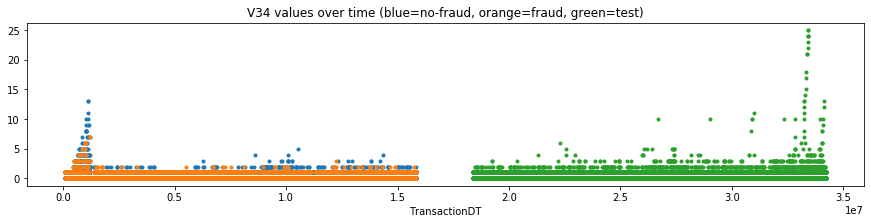

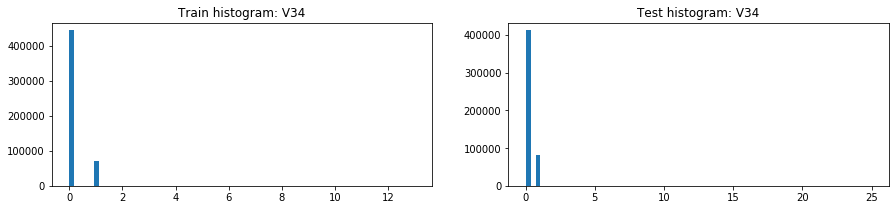

V34          Train   Train fraud  Train Not fraud  \
0           count  514467.000000  16776.000000    497691.000000   
1            mean       0.139154      0.490284         0.127318   
2             std       0.357549      0.538387         0.343634   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max      13.000000      7.000000        13.000000   
8   unique values      14.000000      9.000000        14.000000   
9            NaNs   76073.000000   3887.000000     72186.000000   
10     NaNs share       0.128800      0.188100         0.126700   

             Test   Test public   Test private  
0   494102.000000  93884.000000  400219.000000  
1        0.170068      0.134709       0.178362  
2        0.403681      0.343777       0.416053  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7       25.000000      4.000000      25.000000  
8       24.000000      6.000000      24.000000  
9    12589.000000   7455.000000    5134.000000  
10       0.024800      0.073600       0.012700

V34  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 443989     0.019730        8760         411616
1 -999.0                  76073     0.051096        3887          12589
2    1.0                  69776     0.112976        7883          81672
3    2.0                    496     0.169355          84            566
4    3.0                    129     0.279070          36            153
5    4.0                     34     0.176471           6             36
6    5.0                     14     0.142857           2             17
7    6.0                      8     0.375000           3              6
8    7.0                      7     0.285714           2              2
9    8.0                      6     0.000000           0              4

V34  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          443989     0.019730               8760         411616
1    1.0           69776     0.112976               7883          81672
2 -999.0           76073     0.051096               3887          12589
3    2.0             496     0.169355                 84            566
4    3.0             129     0.279070                 36            153
5    4.0              34     0.176471                  6             36
6    6.0               8     0.375000                  3              6
7    5.0              14     0.142857                  2             17
8    7.0               7     0.285714                  2              2
9    8.0               6     0.000000                  0              4

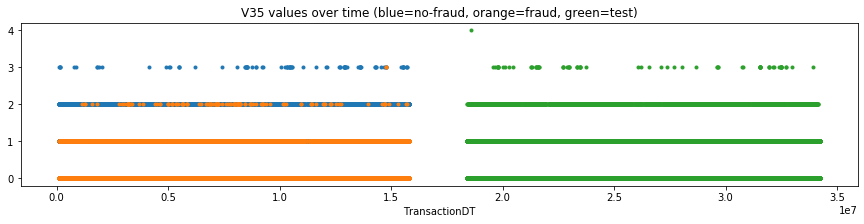

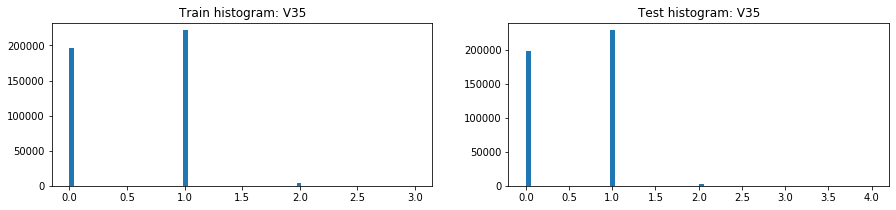

V35          Train   Train fraud  Train Not fraud  \
0           count  421571.000000  14567.000000    407004.000000   
1            mean       0.542594      0.332258         0.550122   
2             std       0.516010      0.490180         0.515322   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       1.000000      0.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       3.000000      3.000000         3.000000   
8   unique values       5.000000      5.000000         5.000000   
9            NaNs  168969.000000   6096.000000    162873.000000   
10     NaNs share       0.286100      0.295000         0.285800   

             Test   Test public   Test private  
0   429837.000000  80247.000000  349591.000000  
1        0.544134      0.647987       0.520297  
2        0.511129      0.494321       0.511946  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7        4.000000      4.000000       3.000000  
8        6.000000      6.000000       5.000000  
9    76854.000000  21092.000000   55762.000000  
10       0.151700      0.208100       0.137600

V35  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 221387     0.020679        4578         228457
1    0.0                 196551     0.050160        9859         198704
2 -999.0                 168969     0.036078        6096          76854
3    2.0                   3544     0.036117         128           2597
4    3.0                     89     0.022472           2             78

V35  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          196551     0.050160               9859         198704
1 -999.0          168969     0.036078               6096          76854
2    1.0          221387     0.020679               4578         228457
3    2.0            3544     0.036117                128           2597
4    3.0              89     0.022472                  2             78

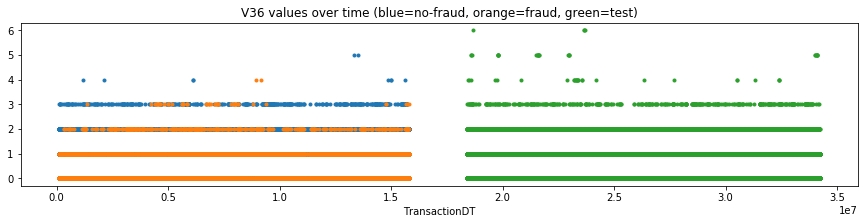

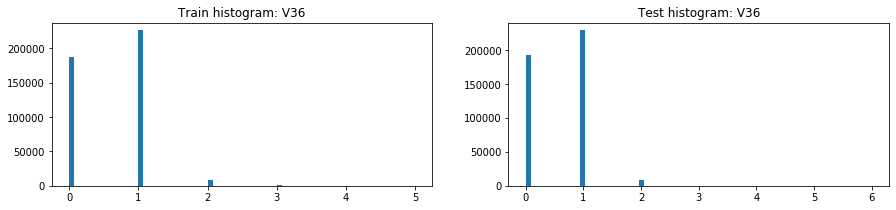

V36          Train   Train fraud  Train Not fraud  \
0           count  421571.000000  14567.000000    407004.000000   
1            mean       0.579198      0.380106         0.586323   
2             std       0.539039      0.560396         0.536893   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       1.000000      0.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       5.000000      4.000000         5.000000   
8   unique values       7.000000      6.000000         7.000000   
9            NaNs  168969.000000   6096.000000    162873.000000   
10     NaNs share       0.286100      0.295000         0.285800   

             Test   Test public   Test private  
0   429837.000000  80247.000000  349591.000000  
1        0.572833      0.684860       0.547119  
2        0.538038      0.520035       0.538810  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7        6.000000      6.000000       6.000000  
8        8.000000      8.000000       8.000000  
9    76854.000000  21092.000000   55762.000000  
10       0.151700      0.208100       0.137600

V36  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 226024     0.020179        4561         228956
1    0.0                 186733     0.051116        9545         192534
2 -999.0                 168969     0.036078        6096          76854
3    2.0                   8307     0.049236         409           7863
4    3.0                    495     0.101010          50            427
5    4.0                     10     0.200000           2             27
6    5.0                      2     0.000000           0             26

V36  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          186733     0.051116               9545         192534
1 -999.0          168969     0.036078               6096          76854
2    1.0          226024     0.020179               4561         228956
3    2.0            8307     0.049236                409           7863
4    3.0             495     0.101010                 50            427
5    4.0              10     0.200000                  2             27
6    5.0               2     0.000000                  0             26

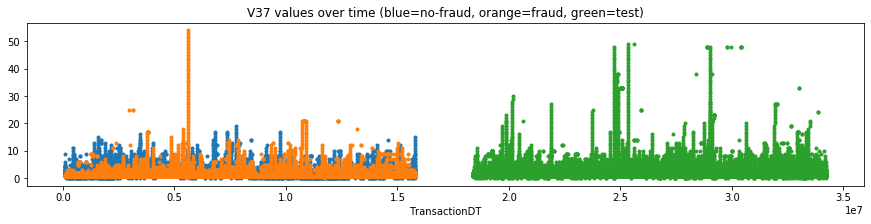

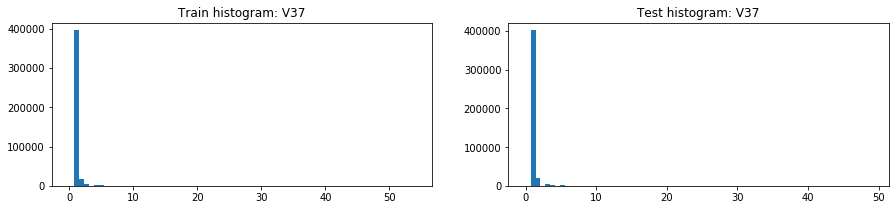

V37          Train   Train fraud  Train Not fraud  \
0           count  421571.000000  14567.000000    407004.000000   
1            mean       1.108065      1.753964         1.084948   
2             std       0.690571      2.629251         0.480715   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      2.000000         1.000000   
7             max      54.000000     54.000000        19.000000   
8   unique values      56.000000     56.000000        21.000000   
9            NaNs  168969.000000   6096.000000    162873.000000   
10     NaNs share       0.286100      0.295000         0.285800   

             Test   Test public   Test private  
0   429837.000000  80247.000000  349591.000000  
1        1.137973      1.115630       1.143102  
2        1.002657      0.728676       1.055493  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       49.000000     30.000000      49.000000  
8       51.000000     32.000000      51.000000  
9    76854.000000  21092.000000   55762.000000  
10       0.151700      0.208100       0.137600

V37  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 395228     0.027382       10822       401275.0
1 -999.0                 168969     0.036078        6096        76854.0
2    2.0                  18453     0.105999        1956        19231.0
3    3.0                   3801     0.195738         744         4231.0
4    4.0                   1474     0.195387         288         1778.0
5    5.0                    796     0.199749         159          902.0
6    6.0                    420     0.304762         128          555.0
7    7.0                    327     0.296636          97          362.0
8    0.0                    325     0.006154           2          191.0
9    8.0                    193     0.347150          67          255.0

V37  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          395228     0.027382              10822         401275
1 -999.0          168969     0.036078               6096          76854
2    2.0           18453     0.105999               1956          19231
3    3.0            3801     0.195738                744           4231
4    4.0            1474     0.195387                288           1778
5    5.0             796     0.199749                159            902
6    6.0             420     0.304762                128            555
7    7.0             327     0.296636                 97            362
8    9.0             168     0.452381                 76            151
9    8.0             193     0.347150                 67            255

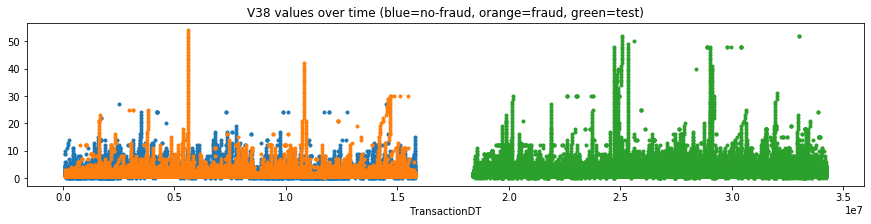

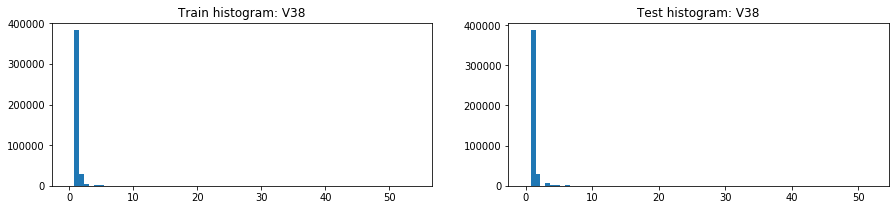

V38         Train   Train fraud  Train Not fraud           Test  \
0           count  421571.00000  14567.000000    407004.000000  429837.000000   
1            mean       1.16240      2.065902         1.130063       1.209175   
2             std       0.85892      3.202819         0.605612       1.183571   
3             min       0.00000      0.000000         0.000000       0.000000   
4             25%       1.00000      1.000000         1.000000       1.000000   
5             50%       1.00000      1.000000         1.000000       1.000000   
6             75%       1.00000      2.000000         1.000000       1.000000   
7             max      54.00000     54.000000        27.000000      52.000000   
8   unique values      56.00000     56.000000        27.000000      54.000000   
9            NaNs  168969.00000   6096.000000    162873.000000   76854.000000   
10     NaNs share       0.28610      0.295000         0.285800       0.151700   

     Test public   Test private  
0   80247.000000  349591.000000  
1       1.177091       1.216539  
2       0.850781       1.247379  
3       0.000000       0.000000  
4       1.000000       1.000000  
5       1.000000       1.000000  
6       1.000000       1.000000  
7      30.000000      52.000000  
8      32.000000      54.000000  
9   21092.000000   55762.000000  
10      0.208100       0.137600

V38  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 382093     0.025520        9751       386613.0
1 -999.0                 168969     0.036078        6096        76854.0
2    2.0                  28073     0.081965        2301        28514.0
3    3.0                   5616     0.174858         982         6793.0
4    4.0                   2208     0.205616         454         2794.0
5    5.0                   1129     0.217892         246         1516.0
6    6.0                    615     0.284553         175          854.0
7    7.0                    426     0.342723         146          555.0
8    0.0                    325     0.006154           2          187.0
9    8.0                    263     0.296578          78          398.0

V38  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          382093     0.025520               9751         386613
1 -999.0          168969     0.036078               6096          76854
2    2.0           28073     0.081965               2301          28514
3    3.0            5616     0.174858                982           6793
4    4.0            2208     0.205616                454           2794
5    5.0            1129     0.217892                246           1516
6    6.0             615     0.284553                175            854
7    7.0             426     0.342723                146            555
8    8.0             263     0.296578                 78            398
9   10.0             144     0.451389                 65            358

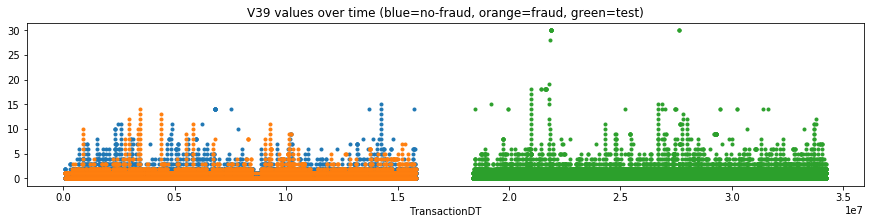

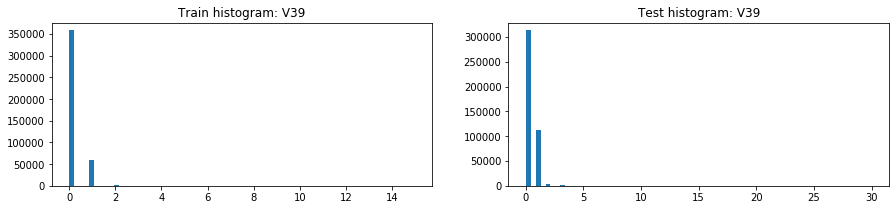

V39          Train   Train fraud  Train Not fraud          Test  \
0           count  421571.000000  14567.000000    407004.000000  429837.00000   
1            mean       0.166076      0.651267         0.148711       0.29293   
2             std       0.451956      0.947924         0.413146       0.57212   
3             min       0.000000      0.000000         0.000000       0.00000   
4             25%       0.000000      0.000000         0.000000       0.00000   
5             50%       0.000000      0.000000         0.000000       0.00000   
6             75%       0.000000      1.000000         0.000000       1.00000   
7             max      15.000000     14.000000        15.000000      30.00000   
8   unique values      17.000000     16.000000        17.000000      23.00000   
9            NaNs  168969.000000   6096.000000    162873.000000   76854.00000   
10     NaNs share       0.286100      0.295000         0.285800       0.15170   

     Test public   Test private  
0   80247.000000  349591.000000  
1       0.144766       0.326939  
2       0.514928       0.579135  
3       0.000000       0.000000  
4       0.000000       0.000000  
5       0.000000       0.000000  
6       0.000000       1.000000  
7      19.000000      30.000000  
8      21.000000      19.000000  
9   21092.000000   55762.000000  
10      0.208100       0.137600

V39  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 357994     0.020366        7291         313015
1 -999.0                 168969     0.036078        6096          76854
2    1.0                  59921     0.101751        6097         111693
3    2.0                   2497     0.294754         736           3720
4    3.0                    566     0.409894         232            679
5    4.0                    253     0.347826          88            277
6    5.0                    108     0.351852          38            176
7    6.0                     82     0.329268          27             75
8    7.0                     48     0.291667          14             44
9    8.0                     37     0.405405          15             35

V39  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          357994     0.020366               7291         313015
1    1.0           59921     0.101751               6097         111693
2 -999.0          168969     0.036078               6096          76854
3    2.0            2497     0.294754                736           3720
4    3.0             566     0.409894                232            679
5    4.0             253     0.347826                 88            277
6    5.0             108     0.351852                 38            176
7    6.0              82     0.329268                 27             75
8    8.0              37     0.405405                 15             35
9    7.0              48     0.291667                 14             44

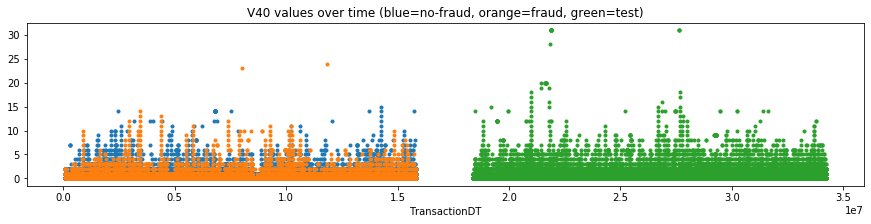

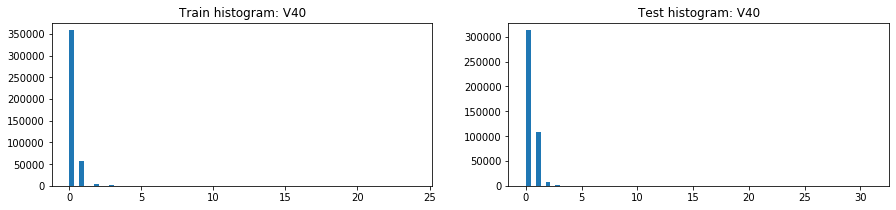

V40          Train   Train fraud  Train Not fraud  \
0           count  421571.000000  14567.000000    407004.000000   
1            mean       0.177145      0.745109         0.156817   
2             std       0.505786      1.154619         0.453107   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      1.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max      24.000000     24.000000        15.000000   
8   unique values      19.000000     18.000000        17.000000   
9            NaNs  168969.000000   6096.000000    162873.000000   
10     NaNs share       0.286100      0.295000         0.285800   

             Test   Test public   Test private  
0   429837.000000  80247.000000  349591.000000  
1        0.311323      0.163221       0.345318  
2        0.638946      0.607201       0.641204  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        1.000000      0.000000       1.000000  
7       31.000000     20.000000      31.000000  
8       24.000000     22.000000      22.000000  
9    76854.000000  21092.000000   55762.000000  
10       0.151700      0.208100       0.137600

V40  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 357837     0.020303        7265       312763.0
1 -999.0                 168969     0.036078        6096        76854.0
2    1.0                  57473     0.095941        5514       107469.0
3    2.0                   4230     0.241135        1020         6757.0
4    3.0                   1046     0.398662         417         1415.0
5    4.0                    400     0.357500         143          591.0
6    5.0                    209     0.272727          57          320.0
7    6.0                    145     0.420690          61          183.0
8    7.0                     78     0.294872          23           88.0
9    8.0                     50     0.440000          22           84.0

V40  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          357837     0.020303               7265         312763
1 -999.0          168969     0.036078               6096          76854
2    1.0           57473     0.095941               5514         107469
3    2.0            4230     0.241135               1020           6757
4    3.0            1046     0.398662                417           1415
5    4.0             400     0.357500                143            591
6    6.0             145     0.420690                 61            183
7    5.0             209     0.272727                 57            320
8    7.0              78     0.294872                 23             88
9    8.0              50     0.440000                 22             84

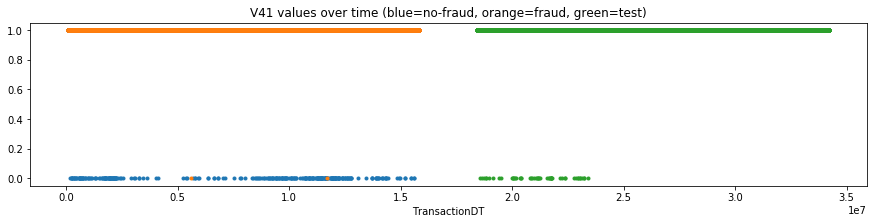

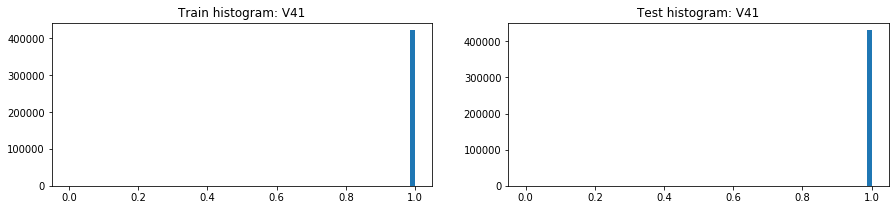

V41          Train   Train fraud  Train Not fraud  \
0           count  421571.000000  14567.000000    407004.000000   
1            mean       0.999269      0.999863         0.999248   
2             std       0.027020      0.011717         0.027409   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       1.000000      1.000000         1.000000   
8   unique values       3.000000      3.000000         3.000000   
9            NaNs  168969.000000   6096.000000    162873.000000   
10     NaNs share       0.286100      0.295000         0.285800   

             Test   Test public   Test private  
0   429837.000000  80247.000000  349591.000000  
1        0.999881      0.999539       0.999960  
2        0.010892      0.021468       0.006328  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7        1.000000      1.000000       1.000000  
8        3.000000      3.000000       3.000000  
9    76854.000000  21092.000000   55762.000000  
10       0.151700      0.208100       0.137600

V41  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 421263     0.034575       14565         429786
1 -999.0                 168969     0.036078        6096          76854
2    0.0                    308     0.006494           2             51

V41  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          421263     0.034575              14565         429786
1 -999.0          168969     0.036078               6096          76854
2    0.0             308     0.006494                  2             51

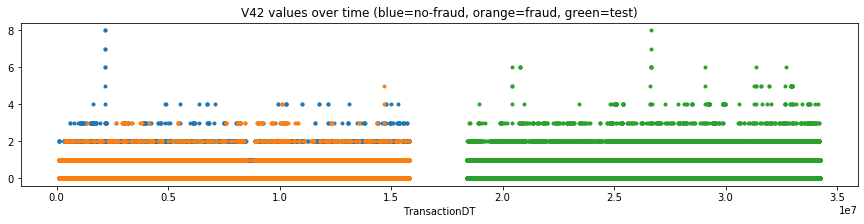

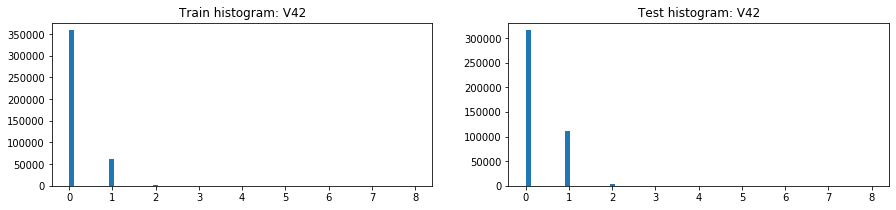

V42          Train   Train fraud  Train Not fraud  \
0           count  421571.000000  14567.000000    407004.000000   
1            mean       0.156118      0.539507         0.142397   
2             std       0.382896      0.596745         0.365600   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max       8.000000      5.000000         8.000000   
8   unique values      10.000000      7.000000        10.000000   
9            NaNs  168969.000000   6096.000000    162873.000000   
10     NaNs share       0.286100      0.295000         0.285800   

             Test   Test public   Test private  
0   429837.000000  80247.000000  349591.000000  
1        0.276451      0.129538       0.310174  
2        0.474845      0.360598       0.491219  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        1.000000      0.000000       1.000000  
7        8.000000      6.000000       8.000000  
8       10.000000      8.000000      10.000000  
9    76854.000000  21092.000000   55762.000000  
10       0.151700      0.208100       0.137600

V42  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 358439     0.020648        7401         315401
1 -999.0                 168969     0.036078        6096          76854
2    1.0                  60801     0.107860        6558         110831
3    2.0                   2037     0.259205         528           3027
4    3.0                    256     0.296875          76            427
5    4.0                     30     0.100000           3            108
6    5.0                      2     0.500000           1             30
7    6.0                      2     0.000000           0             11
8    7.0                      2     0.000000           0              1
9    8.0                      2     0.000000           0              1

V42  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          358439     0.020648               7401         315401
1    1.0           60801     0.107860               6558         110831
2 -999.0          168969     0.036078               6096          76854
3    2.0            2037     0.259205                528           3027
4    3.0             256     0.296875                 76            427
5    4.0              30     0.100000                  3            108
6    5.0               2     0.500000                  1             30
7    6.0               2     0.000000                  0             11
8    7.0               2     0.000000                  0              1
9    8.0               2     0.000000                  0              1

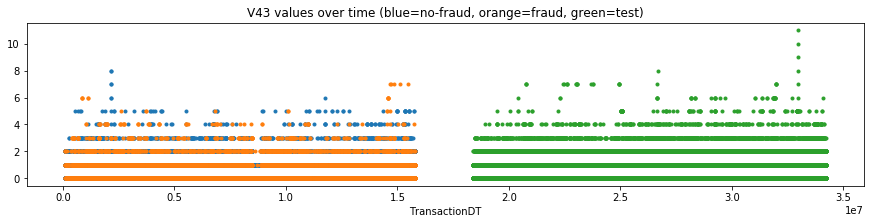

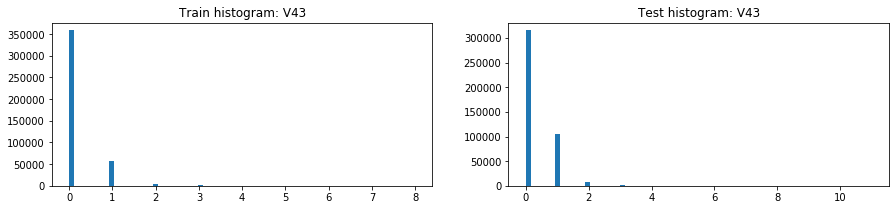

V43          Train   Train fraud  Train Not fraud  \
0           count  421571.000000  14567.000000    407004.000000   
1            mean       0.168942      0.623121         0.152686   
2             std       0.433359      0.769766         0.407024   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max       8.000000      7.000000         8.000000   
8   unique values      10.000000      9.000000        10.000000   
9            NaNs  168969.000000   6096.000000    162873.000000   
10     NaNs share       0.286100      0.295000         0.285800   

             Test   Test public   Test private  
0   429837.000000  80247.000000  349591.000000  
1        0.298071      0.146024       0.332972  
2        0.539790      0.427083       0.556653  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        1.000000      0.000000       1.000000  
7       11.000000      7.000000      11.000000  
8       13.000000      9.000000      13.000000  
9    76854.000000  21092.000000   55762.000000  
10       0.151700      0.208100       0.137600

V43  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 358261     0.020577        7372         315056
1 -999.0                 168969     0.036078        6096          76854
2    1.0                  56929     0.102408        5830         104444
3    2.0                   5234     0.188193         985           8167
4    3.0                    885     0.324294         287           1632
5    4.0                    174     0.396552          69            359
6    5.0                     66     0.136364           9            104
7    6.0                     13     0.769231          10             44
8    7.0                      7     0.714286           5             26
9    8.0                      2     0.000000           0              2

V43  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          358261     0.020577               7372         315056
1 -999.0          168969     0.036078               6096          76854
2    1.0           56929     0.102408               5830         104444
3    2.0            5234     0.188193                985           8167
4    3.0             885     0.324294                287           1632
5    4.0             174     0.396552                 69            359
6    6.0              13     0.769231                 10             44
7    5.0              66     0.136364                  9            104
8    7.0               7     0.714286                  5             26
9    8.0               2     0.000000                  0              2

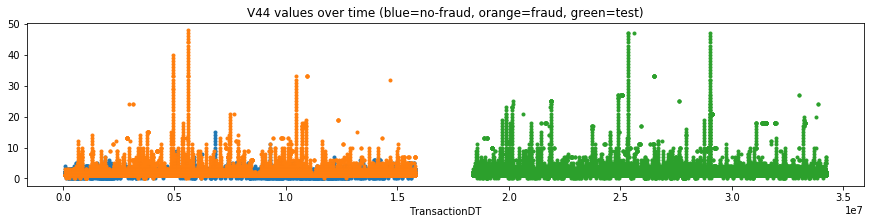

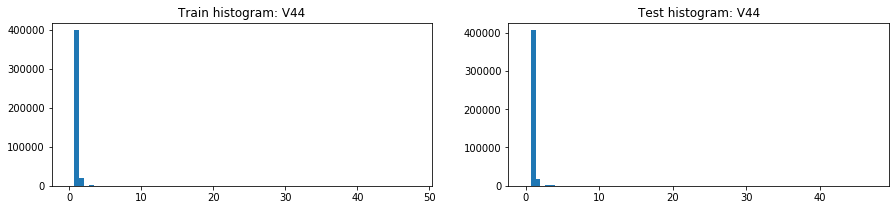

V44          Train   Train fraud  Train Not fraud  \
0           count  421571.000000  14567.000000    407004.000000   
1            mean       1.083891      1.963548         1.052407   
2             std       0.639143      3.011257         0.264426   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      2.000000         1.000000   
7             max      48.000000     48.000000        15.000000   
8   unique values      50.000000     50.000000        17.000000   
9            NaNs  168969.000000   6096.000000    162873.000000   
10     NaNs share       0.286100      0.295000         0.285800   

             Test   Test public   Test private  
0   429837.000000  80247.000000  349591.000000  
1        1.103372      1.109711       1.101916  
2        0.843529      0.753380       0.862887  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       47.000000     25.000000      47.000000  
8       49.000000     27.000000      49.000000  
9    76854.000000  21092.000000   55762.000000  
10       0.151700      0.208100       0.137600

V44  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 397653     0.026015       10345       405518.0
1 -999.0                 168969     0.036078        6096        76854.0
2    2.0                  19434     0.101832        1979        18884.0
3    3.0                   2242     0.330062         740         2588.0
4    4.0                    615     0.686179         422          868.0
5    0.0                    441     0.077098          34          202.0
6    5.0                    319     0.764890         244          341.0
7    6.0                    208     0.812500         169          219.0
8    7.0                    138     0.949275         131          167.0
9    9.0                    102     0.960784          98          109.0

V44  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          397653     0.026015              10345         405518
1 -999.0          168969     0.036078               6096          76854
2    2.0           19434     0.101832               1979          18884
3    3.0            2242     0.330062                740           2588
4    4.0             615     0.686179                422            868
5    5.0             319     0.764890                244            341
6    6.0             208     0.812500                169            219
7    7.0             138     0.949275                131            167
8    9.0             102     0.960784                 98            109
9    8.0              83     0.927711                 77             98

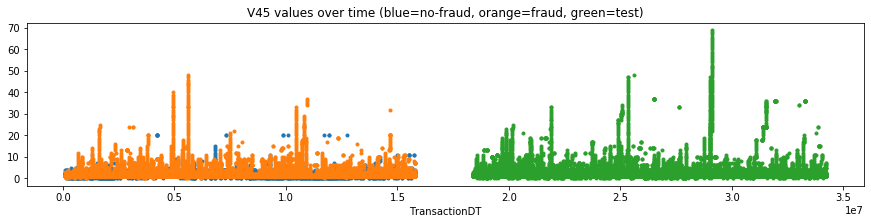

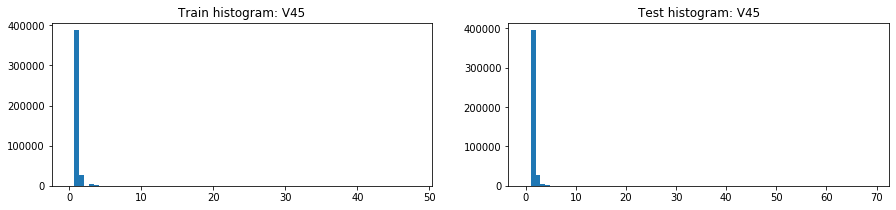

V45          Train   Train fraud  Train Not fraud  \
0           count  421571.000000  14567.000000    407004.000000   
1            mean       1.120779      2.207936         1.081869   
2             std       0.729774      3.290828         0.346760   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      2.000000         1.000000   
7             max      48.000000     48.000000        20.000000   
8   unique values      50.000000     50.000000        18.000000   
9            NaNs  168969.000000   6096.000000    162873.000000   
10     NaNs share       0.286100      0.295000         0.285800   

             Test   Test public   Test private  
0   429837.000000  80247.000000  349591.000000  
1        1.146530      1.156056       1.144343  
2        1.075638      0.858947       1.119463  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       69.000000     25.000000      69.000000  
8       71.000000     27.000000      71.000000  
9    76854.000000  21092.000000   55762.000000  
10       0.151700      0.208100       0.137600

V45  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 387027     0.024838        9613         394651
1 -999.0                 168969     0.036078        6096          76854
2    2.0                  28125     0.077013        2166          27474
3    3.0                   3472     0.230703         801           3956
4    4.0                    906     0.620309         562           1230
5    5.0                    438     0.732877         321            520
6    0.0                    412     0.060680          25            195
7    6.0                    253     0.814229         206            365
8    7.0                    214     0.920561         197            202
9    9.0                    143     0.958042         137            117

V45  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          387027     0.024838               9613         394651
1 -999.0          168969     0.036078               6096          76854
2    2.0           28125     0.077013               2166          27474
3    3.0            3472     0.230703                801           3956
4    4.0             906     0.620309                562           1230
5    5.0             438     0.732877                321            520
6    6.0             253     0.814229                206            365
7    7.0             214     0.920561                197            202
8    9.0             143     0.958042                137            117
9    8.0             132     0.924242                122            134

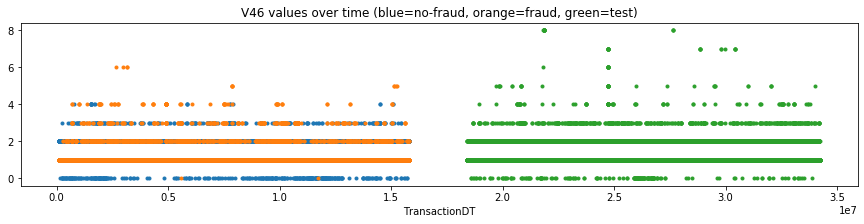

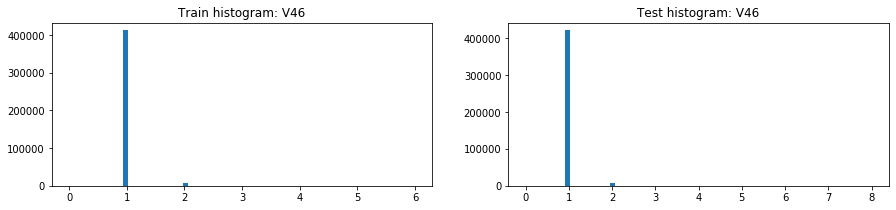

V46          Train   Train fraud  Train Not fraud  \
0           count  421571.000000  14567.000000    407004.000000   
1            mean       1.022286      1.133315         1.018312   
2             std       0.166719      0.447973         0.145434   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       6.000000      6.000000         4.000000   
8   unique values       8.000000      8.000000         6.000000   
9            NaNs  168969.000000   6096.000000    162873.000000   
10     NaNs share       0.286100      0.295000         0.285800   

             Test   Test public   Test private  
0   429837.000000  80247.000000  349591.000000  
1        1.022211      1.020910       1.022509  
2        0.175910      0.166885       0.177915  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7        8.000000      6.000000       8.000000  
8       10.000000      8.000000      10.000000  
9    76854.000000  21092.000000   55762.000000  
10       0.151700      0.208100       0.137600

V46  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 412247     0.031801       13110         421088
1 -999.0                 168969     0.036078        6096          76854
2    2.0                   8340     0.128897        1075           7784
3    3.0                    521     0.550864         287            620
4    0.0                    348     0.005747           2            171
5    4.0                    103     0.786408          81             94
6    5.0                      8     1.000000           8             36
7    6.0                      4     1.000000           4             10

V46  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          412247     0.031801              13110         421088
1 -999.0          168969     0.036078               6096          76854
2    2.0            8340     0.128897               1075           7784
3    3.0             521     0.550864                287            620
4    4.0             103     0.786408                 81             94
5    5.0               8     1.000000                  8             36
6    6.0               4     1.000000                  4             10
7    0.0             348     0.005747                  2            171

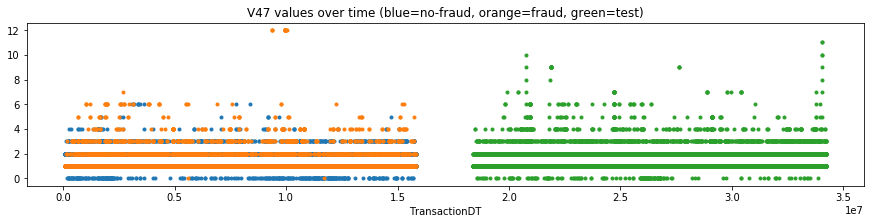

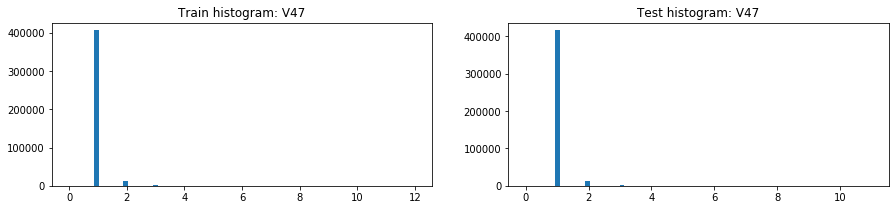

V47          Train   Train fraud  Train Not fraud  \
0           count  421571.000000  14567.000000    407004.000000   
1            mean       1.038515      1.239651         1.031317   
2             std       0.231862      0.707659         0.190426   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max      12.000000     12.000000         6.000000   
8   unique values      10.000000     10.000000         8.000000   
9            NaNs  168969.000000   6096.000000    162873.000000   
10     NaNs share       0.286100      0.295000         0.285800   

             Test   Test public   Test private  
0   429837.000000  80247.000000  349591.000000  
1        1.037877      1.036899       1.038102  
2        0.235685      0.234845       0.235877  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       11.000000     10.000000      11.000000  
8       13.000000     12.000000      13.000000  
9    76854.000000  21092.000000   55762.000000  
10       0.151700      0.208100       0.137600

V47  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 406519     0.030095       12234       415540.0
1 -999.0                 168969     0.036078        6096        76854.0
2    2.0                  13389     0.121592        1628        12651.0
3    3.0                   1018     0.470530         479         1014.0
4    0.0                    347     0.005764           2          169.0
5    4.0                    189     0.714286         135          284.0
6    6.0                     49     0.795918          39           55.0
7    5.0                     44     0.772727          34           75.0
8   12.0                     15     1.000000          15            NaN
9    7.0                      1     1.000000           1           26.0

V47  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          406519     0.030095              12234       415540.0
1 -999.0          168969     0.036078               6096        76854.0
2    2.0           13389     0.121592               1628        12651.0
3    3.0            1018     0.470530                479         1014.0
4    4.0             189     0.714286                135          284.0
5    6.0              49     0.795918                 39           55.0
6    5.0              44     0.772727                 34           75.0
7   12.0              15     1.000000                 15            NaN
8    0.0             347     0.005764                  2          169.0
9    7.0               1     1.000000                  1           26.0

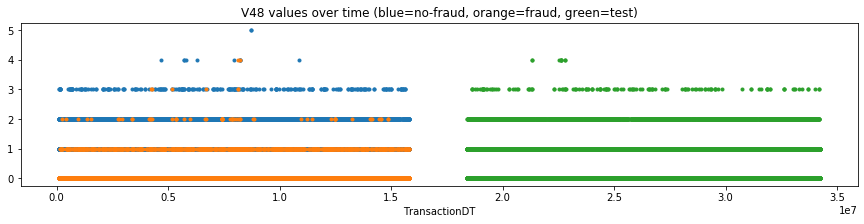

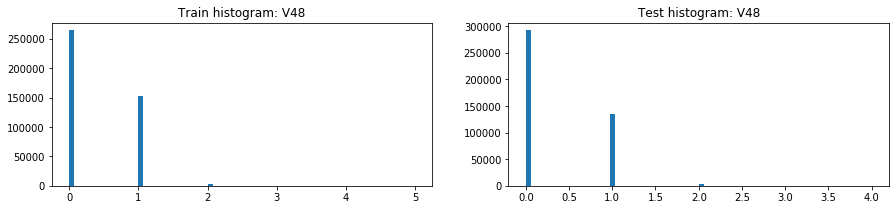

V48          Train   Train fraud  Train Not fraud  \
0           count  421571.000000  14567.000000    407004.000000   
1            mean       0.383174      0.072149         0.394306   
2             std       0.508189      0.280881         0.510969   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       1.000000      0.000000         1.000000   
7             max       5.000000      4.000000         5.000000   
8   unique values       7.000000      6.000000         7.000000   
9            NaNs  168969.000000   6096.000000    162873.000000   
10     NaNs share       0.286100      0.295000         0.285800   

             Test   Test public   Test private  
0   429837.000000  80247.000000  349591.000000  
1        0.327571      0.404003       0.310028  
2        0.485626      0.509856       0.478172  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        1.000000      1.000000       1.000000  
7        4.000000      4.000000       4.000000  
8        6.000000      6.000000       6.000000  
9    76854.000000  21092.000000   55762.000000  
10       0.151700      0.208100       0.137600

V48  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 264325     0.051418       13591       292210.0
1 -999.0                 168969     0.036078        6096        76854.0
2    1.0                 153267     0.005944         911       134613.0
3    2.0                   3685     0.015468          57         2862.0
4    3.0                    280     0.021429           6          143.0
5    4.0                     12     0.166667           2            9.0
6    5.0                      2     0.000000           0            NaN

V48  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          264325     0.051418              13591       292210.0
1 -999.0          168969     0.036078               6096        76854.0
2    1.0          153267     0.005944                911       134613.0
3    2.0            3685     0.015468                 57         2862.0
4    3.0             280     0.021429                  6          143.0
5    4.0              12     0.166667                  2            9.0
6    5.0               2     0.000000                  0            NaN

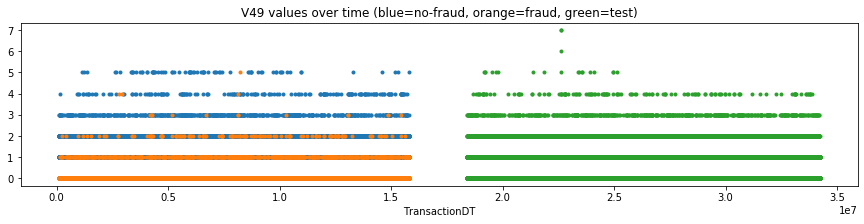

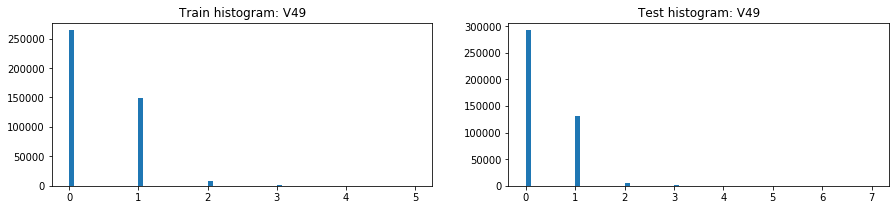

V49          Train   Train fraud  Train Not fraud  \
0           count  421571.000000  14567.000000    407004.000000   
1            mean       0.397724      0.079563         0.409111   
2             std       0.542654      0.317332         0.545579   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       1.000000      0.000000         1.000000   
7             max       5.000000      5.000000         5.000000   
8   unique values       7.000000      7.000000         7.000000   
9            NaNs  168969.000000   6096.000000    162873.000000   
10     NaNs share       0.286100      0.295000         0.285800   

             Test   Test public   Test private  
0   429837.000000  80247.000000  349591.000000  
1        0.339706      0.419168       0.321467  
2        0.516249      0.543378       0.508068  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        1.000000      1.000000       1.000000  
7        7.000000      5.000000       7.000000  
8        9.000000      7.000000       9.000000  
9    76854.000000  21092.000000   55762.000000  
10       0.151700      0.208100       0.137600

V49  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 263761     0.051486       13580         291701
1 -999.0                 168969     0.036078        6096          76854
2    1.0                 149250     0.005608         837         131223
3    2.0                   7604     0.017491         133           6131
4    3.0                    691     0.018813          13            621
5    4.0                    187     0.016043           3            140
6    5.0                     78     0.012821           1             18

V49  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          263761     0.051486              13580         291701
1 -999.0          168969     0.036078               6096          76854
2    1.0          149250     0.005608                837         131223
3    2.0            7604     0.017491                133           6131
4    3.0             691     0.018813                 13            621
5    4.0             187     0.016043                  3            140
6    5.0              78     0.012821                  1             18

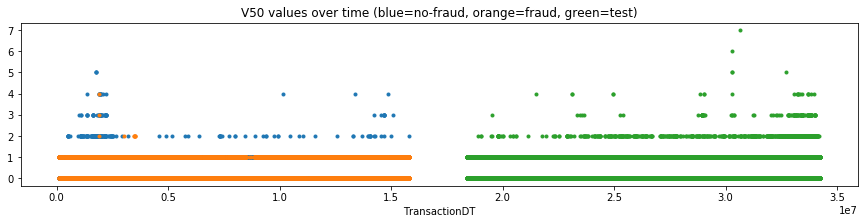

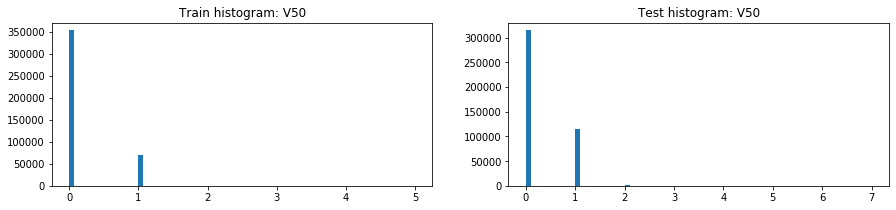

V50          Train   Train fraud  Train Not fraud  \
0           count  421571.000000  14567.000000    407004.000000   
1            mean       0.164746      0.520492         0.152013   
2             std       0.373995      0.501791         0.362182   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      1.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max       5.000000      4.000000         5.000000   
8   unique values       7.000000      6.000000         7.000000   
9            NaNs  168969.000000   6096.000000    162873.000000   
10     NaNs share       0.286100      0.295000         0.285800   

             Test   Test public   Test private  
0   429837.000000  80247.000000  349591.000000  
1        0.271961      0.128329       0.304931  
2        0.452709      0.335722       0.469356  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        1.000000      0.000000       1.000000  
7        7.000000      4.000000       7.000000  
8        9.000000      6.000000       9.000000  
9    76854.000000  21092.000000   55762.000000  
10       0.151700      0.208100       0.137600

V50  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 352482     0.019851        6997         314211
1 -999.0                 168969     0.036078        6096          76854
2    1.0                  68817     0.109871        7561         114527
3    2.0                    202     0.034653           7            959
4    3.0                     52     0.019231           1            114
5    4.0                     15     0.066667           1             21
6    5.0                      3     0.000000           0              3

V50  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0           68817     0.109871               7561         114527
1    0.0          352482     0.019851               6997         314211
2 -999.0          168969     0.036078               6096          76854
3    2.0             202     0.034653                  7            959
4    3.0              52     0.019231                  1            114
5    4.0              15     0.066667                  1             21
6    5.0               3     0.000000                  0              3

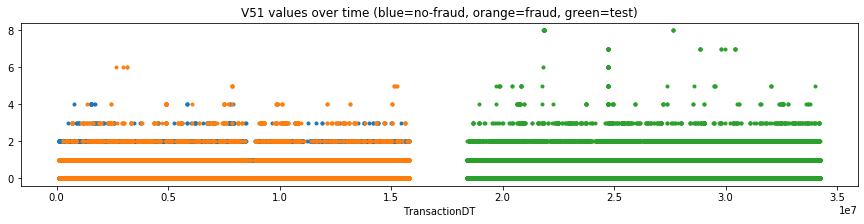

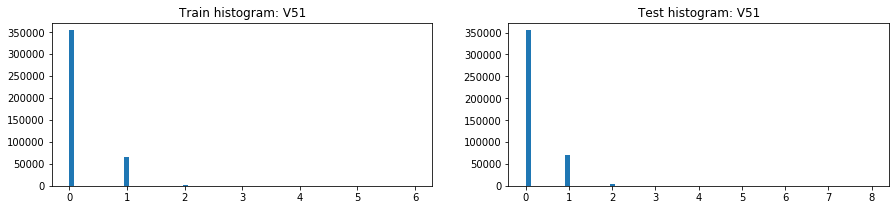

V51          Train   Train fraud  Train Not fraud  \
0           count  421571.000000  14567.000000    407004.000000   
1            mean       0.170579      0.647079         0.153524   
2             std       0.403899      0.724260         0.376541   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      1.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max       6.000000      6.000000         4.000000   
8   unique values       8.000000      8.000000         6.000000   
9            NaNs  168969.000000   6096.000000    162873.000000   
10     NaNs share       0.286100      0.295000         0.285800   

             Test   Test public   Test private  
0   429837.000000  80247.000000  349591.000000  
1        0.185977      0.146884       0.194951  
2        0.425913      0.388564       0.433536  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7        8.000000      6.000000       8.000000  
8       10.000000      8.000000      10.000000  
9    76854.000000  21092.000000   55762.000000  
10       0.151700      0.208100       0.137600

V51  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 353522     0.019170        6777         354721
1 -999.0                 168969     0.036078        6096          76854
2    1.0                  64775     0.101552        6578          71266
3    2.0                   2780     0.311151         865           3205
4    3.0                    416     0.687500         286            485
5    4.0                     66     0.742424          49             83
6    5.0                      8     1.000000           8             33
7    6.0                      4     1.000000           4             10

V51  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          353522     0.019170               6777         354721
1    1.0           64775     0.101552               6578          71266
2 -999.0          168969     0.036078               6096          76854
3    2.0            2780     0.311151                865           3205
4    3.0             416     0.687500                286            485
5    4.0              66     0.742424                 49             83
6    5.0               8     1.000000                  8             33
7    6.0               4     1.000000                  4             10

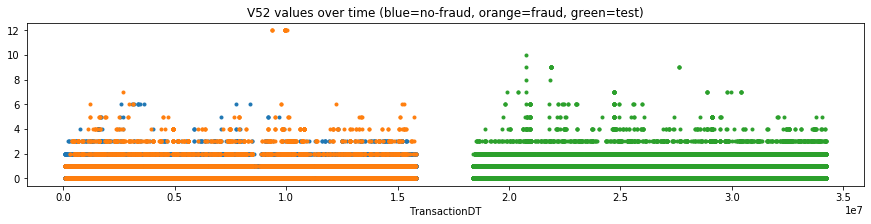

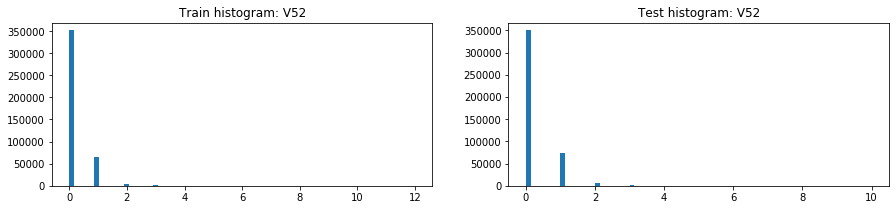

V52          Train   Train fraud  Train Not fraud  \
0           count  421571.000000  14567.000000    407004.000000   
1            mean       0.182695      0.738381         0.162807   
2             std       0.439002      0.924367         0.396980   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      1.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max      12.000000     12.000000         6.000000   
8   unique values      10.000000     10.000000         8.000000   
9            NaNs  168969.000000   6096.000000    162873.000000   
10     NaNs share       0.286100      0.295000         0.285800   

             Test   Test public   Test private  
0   429837.000000  80247.000000  349591.000000  
1        0.205466      0.165489       0.214642  
2        0.464834      0.431574       0.471660  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7       10.000000     10.000000       9.000000  
8       12.000000     12.000000      11.000000  
9    76854.000000  21092.000000   55762.000000  
10       0.151700      0.208100       0.137600

V52  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 351237     0.018933        6650       349816.0
1 -999.0                 168969     0.036078        6096        76854.0
2    1.0                  65030     0.093572        6085        73528.0
3    2.0                   4362     0.272811        1190         5357.0
4    3.0                    705     0.638298         450          774.0
5    4.0                    161     0.838509         135          214.0
6    5.0                     41     0.780488          32           65.0
7    6.0                     19     0.473684           9           42.0
8   12.0                     15     1.000000          15            NaN
9    7.0                      1     1.000000           1           24.0

V52  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          351237     0.018933               6650       349816.0
1 -999.0          168969     0.036078               6096        76854.0
2    1.0           65030     0.093572               6085        73528.0
3    2.0            4362     0.272811               1190         5357.0
4    3.0             705     0.638298                450          774.0
5    4.0             161     0.838509                135          214.0
6    5.0              41     0.780488                 32           65.0
7   12.0              15     1.000000                 15            NaN
8    6.0              19     0.473684                  9           42.0
9    7.0               1     1.000000                  1           24.0

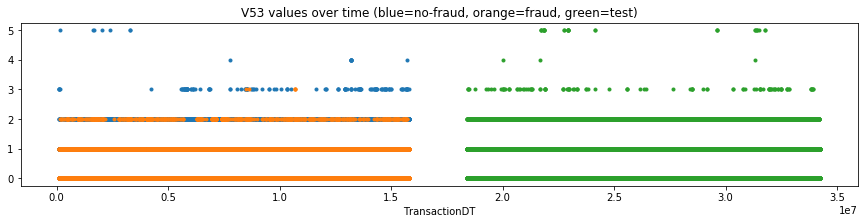

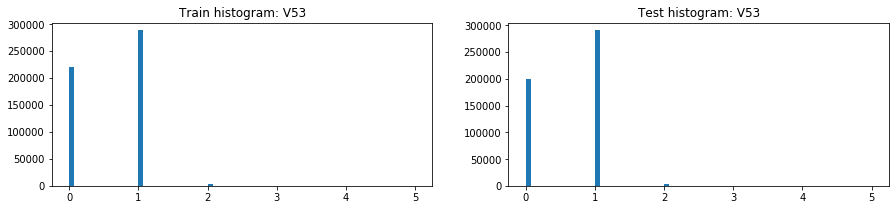

V53          Train   Train fraud  Train Not fraud  \
0           count  513444.000000  16154.000000    497290.000000   
1            mean       0.577586      0.443048         0.581956   
2             std       0.511571      0.565967         0.509111   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       1.000000      0.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       5.000000      3.000000         5.000000   
8   unique values       7.000000      5.000000         7.000000   
9            NaNs   77096.000000   4509.000000     72587.000000   
10     NaNs share       0.130600      0.218200         0.127400   

             Test   Test public   Test private  
0   493792.000000  93474.000000  400319.000000  
1        0.604609      0.706132       0.580902  
2        0.507702      0.481786       0.510668  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7        5.000000      5.000000       5.000000  
8        7.000000      7.000000       7.000000  
9    12899.000000   7865.000000    5034.000000  
10       0.025500      0.077600       0.012400

V53  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 288055     0.020774        5984         290128
1    0.0                 221227     0.043331        9586         199557
2 -999.0                  77096     0.058486        4509          12899
3    2.0                   4006     0.144533         579           3961
4    3.0                    140     0.035714           5            113
5    4.0                      9     0.000000           0              3
6    5.0                      7     0.000000           0             30

V53  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          221227     0.043331               9586         199557
1    1.0          288055     0.020774               5984         290128
2 -999.0           77096     0.058486               4509          12899
3    2.0            4006     0.144533                579           3961
4    3.0             140     0.035714                  5            113
5    4.0               9     0.000000                  0              3
6    5.0               7     0.000000                  0             30

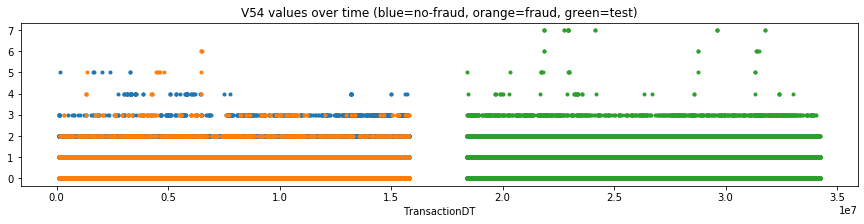

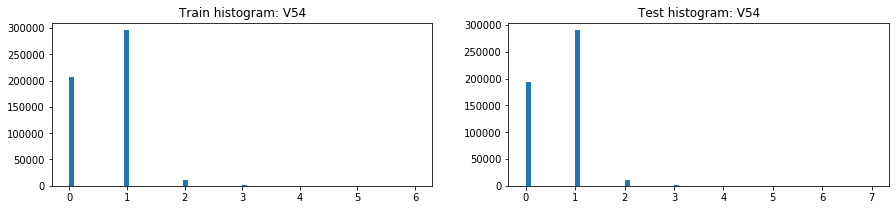

V54          Train   Train fraud  Train Not fraud  \
0           count  513444.000000  16154.000000    497290.000000   
1            mean       0.619982      0.510152         0.623550   
2             std       0.534635      0.654092         0.529922   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       1.000000      0.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       6.000000      6.000000         5.000000   
8   unique values       8.000000      8.000000         7.000000   
9            NaNs   77096.000000   4509.000000     72587.000000   
10     NaNs share       0.130600      0.218200         0.127400   

             Test   Test public   Test private  
0   493792.000000  93474.000000  400319.000000  
1        0.634457      0.745555       0.608515  
2        0.535635      0.509076       0.538358  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7        7.000000      5.000000       7.000000  
8        9.000000      7.000000       9.000000  
9    12899.000000   7865.000000    5034.000000  
10       0.025500      0.077600       0.012400

V54  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 295235     0.020245        5977         289597
1    0.0                 207068     0.044097        9131         192825
2 -999.0                  77096     0.058486        4509          12899
3    2.0                  10445     0.086644         905          10571
4    3.0                    603     0.203980         123            728
5    4.0                     76     0.105263           8             32
6    5.0                     14     0.500000           7             13
7    6.0                      3     1.000000           3              8

V54  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          207068     0.044097               9131         192825
1    1.0          295235     0.020245               5977         289597
2 -999.0           77096     0.058486               4509          12899
3    2.0           10445     0.086644                905          10571
4    3.0             603     0.203980                123            728
5    4.0              76     0.105263                  8             32
6    5.0              14     0.500000                  7             13
7    6.0               3     1.000000                  3              8

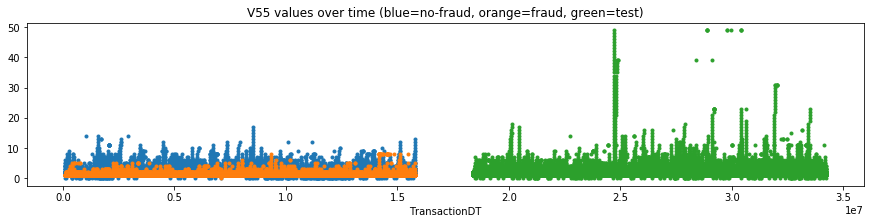

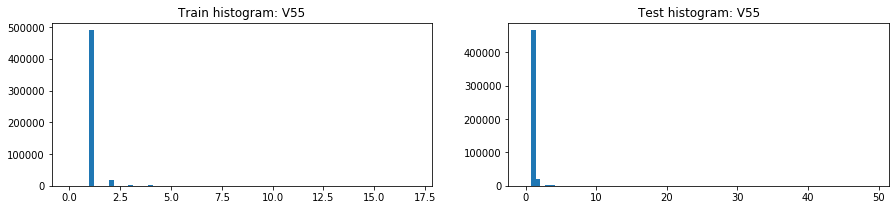

V55          Train   Train fraud  Train Not fraud  \
0           count  513444.000000  16154.000000    497290.000000   
1            mean       1.067670      1.176489         1.064136   
2             std       0.391364      0.584570         0.382941   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max      17.000000      8.000000        17.000000   
8   unique values      19.000000     10.000000        19.000000   
9            NaNs   77096.000000   4509.000000     72587.000000   
10     NaNs share       0.130600      0.218200         0.127400   

             Test   Test public   Test private  
0   493792.000000  93474.000000  400319.000000  
1        1.092654      1.077144       1.096276  
2        0.666877      0.425291       0.711522  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       49.000000     18.000000      49.000000  
8       51.000000     20.000000      51.000000  
9    12899.000000   7865.000000    5034.000000  
10       0.025500      0.077600       0.012400

V55  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 489239     0.028828       14104         465610
1 -999.0                  77096     0.058486        4509          12899
2    2.0                  18464     0.087684        1619          21137
3    3.0                   3100     0.082903         257           3706
4    4.0                   1233     0.067315          83           1436
5    5.0                    530     0.088679          47            654
6    6.0                    300     0.026667           8            383
7    0.0                    180     0.005556           1            139
8    7.0                    144     0.020833           3            185
9    8.0                    124     0.258065          32            116

V55  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          489239     0.028828              14104         465610
1 -999.0           77096     0.058486               4509          12899
2    2.0           18464     0.087684               1619          21137
3    3.0            3100     0.082903                257           3706
4    4.0            1233     0.067315                 83           1436
5    5.0             530     0.088679                 47            654
6    8.0             124     0.258065                 32            116
7    6.0             300     0.026667                  8            383
8    7.0             144     0.020833                  3            185
9    0.0             180     0.005556                  1            139

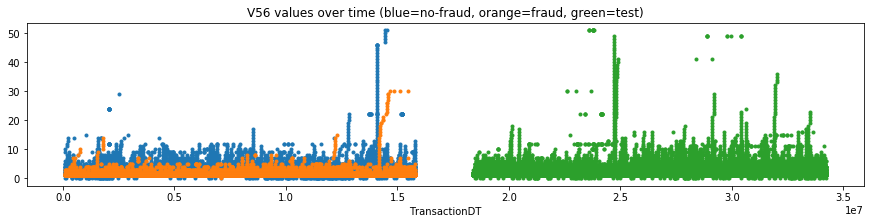

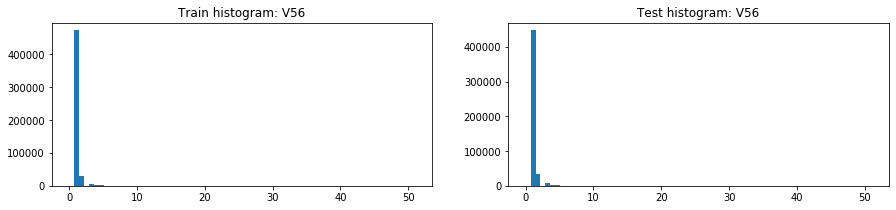

V56          Train   Train fraud  Train Not fraud  \
0           count  513444.000000  16154.000000    497290.000000   
1            mean       1.120979      1.346044         1.113668   
2             std       0.661129      1.198795         0.634752   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max      51.000000     30.000000        51.000000   
8   unique values      53.000000     32.000000        53.000000   
9            NaNs   77096.000000   4509.000000     72587.000000   
10     NaNs share       0.130600      0.218200         0.127400   

             Test   Test public   Test private  
0   493792.000000  93474.000000  400319.000000  
1        1.155991      1.135385       1.160802  
2        0.831025      0.553395       0.883305  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       51.000000     18.000000      51.000000  
8       52.000000     20.000000      52.000000  
9    12899.000000   7865.000000    5034.000000  
10       0.025500      0.077600       0.012400

V56  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 472700     0.027373       12939       447151.0
1 -999.0                  77096     0.058486        4509        12899.0
2    2.0                  30886     0.070582        2180        33758.0
3    3.0                   5610     0.097504         547         7192.0
4    4.0                   1881     0.155768         293         2536.0
5    5.0                    952     0.101891          97         1194.0
6    6.0                    355     0.067606          24          549.0
7    7.0                    246     0.073171          18          337.0
8    0.0                    180     0.005556           1          136.0
9    8.0                    169     0.059172          10          210.0

V56  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          472700     0.027373              12939         447151
1 -999.0           77096     0.058486               4509          12899
2    2.0           30886     0.070582               2180          33758
3    3.0            5610     0.097504                547           7192
4    4.0            1881     0.155768                293           2536
5    5.0             952     0.101891                 97           1194
6    6.0             355     0.067606                 24            549
7    7.0             246     0.073171                 18            337
8    8.0             169     0.059172                 10            210
9   30.0               5     0.800000                  4              7

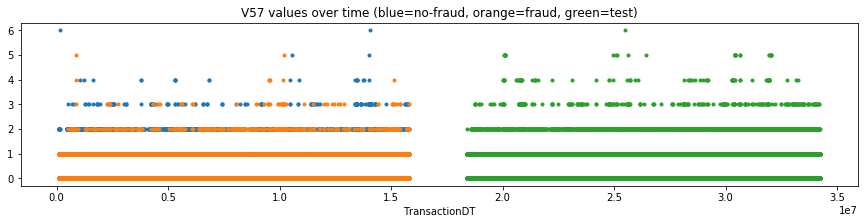

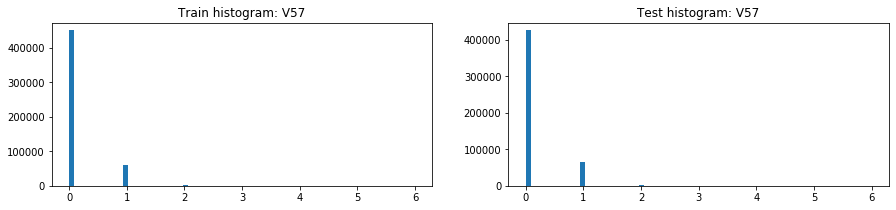

V57          Train   Train fraud  Train Not fraud  \
0           count  513444.000000  16154.000000    497290.000000   
1            mean       0.128312      0.455429         0.117686   
2             std       0.349094      0.575313         0.333895   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max       6.000000      5.000000         6.000000   
8   unique values       8.000000      7.000000         8.000000   
9            NaNs   77096.000000   4509.000000     72587.000000   
10     NaNs share       0.130600      0.218200         0.127400   

             Test   Test public   Test private  
0   493792.000000  93474.000000  400319.000000  
1        0.145733      0.109603       0.154170  
2        0.375931      0.339790       0.383391  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7        6.000000      5.000000       6.000000  
8        8.000000      7.000000       8.000000  
9    12899.000000   7865.000000    5034.000000  
10       0.025500      0.077600       0.012400

V57  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 449807     0.020867        9386         425265
1 -999.0                  77096     0.058486        4509          12899
2    1.0                  61670     0.101313        6248          65642
3    2.0                   1731     0.266320         461           2475
4    3.0                    203     0.251232          51            299
5    4.0                     27     0.222222           6             83
6    5.0                      4     0.500000           2             27
7    6.0                      2     0.000000           0              1

V57  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          449807     0.020867               9386         425265
1    1.0           61670     0.101313               6248          65642
2 -999.0           77096     0.058486               4509          12899
3    2.0            1731     0.266320                461           2475
4    3.0             203     0.251232                 51            299
5    4.0              27     0.222222                  6             83
6    5.0               4     0.500000                  2             27
7    6.0               2     0.000000                  0              1

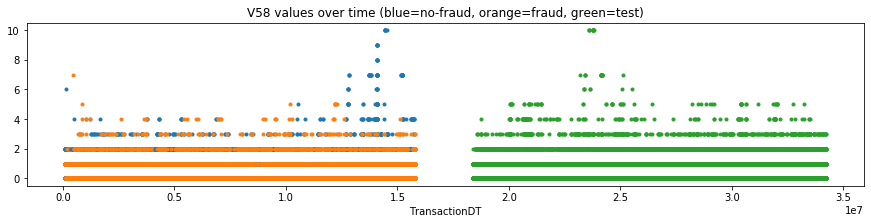

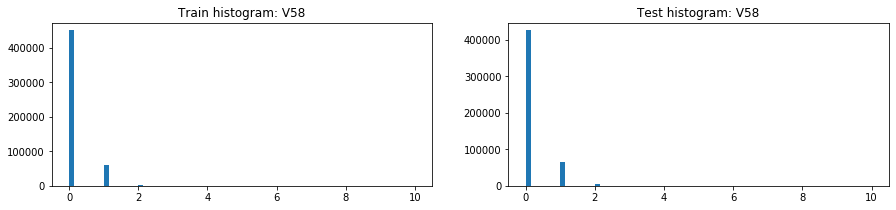

V58          Train   Train fraud  Train Not fraud  \
0           count  513444.000000  16154.000000    497290.000000   
1            mean       0.132453      0.490529         0.120821   
2             std       0.372907      0.650019         0.354333   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max      10.000000      7.000000        10.000000   
8   unique values      12.000000      8.000000        12.000000   
9            NaNs   77096.000000   4509.000000     72587.000000   
10     NaNs share       0.130600      0.218200         0.127400   

             Test   Test public   Test private  
0   493792.000000  93474.000000  400319.000000  
1        0.150683      0.114299       0.159178  
2        0.400369      0.364030       0.407921  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7       10.000000      5.000000      10.000000  
8       10.000000      7.000000      10.000000  
9    12899.000000   7865.000000    5034.000000  
10       0.025500      0.077600       0.012400

V58  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 449600     0.020812        9357       425256.0
1 -999.0                  77096     0.058486        4509        12899.0
2    1.0                  60662     0.096848        5875        63921.0
3    2.0                   2675     0.285981         765         3789.0
4    3.0                    300     0.400000         120          596.0
5    4.0                    105     0.266667          28          129.0
6    7.0                     45     0.022222           1           18.0
7    5.0                     31     0.258065           8           65.0
8    6.0                     10     0.000000           0            7.0
9   10.0                      6     0.000000           0           11.0

V58  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          449600     0.020812               9357         425256
1    1.0           60662     0.096848               5875          63921
2 -999.0           77096     0.058486               4509          12899
3    2.0            2675     0.285981                765           3789
4    3.0             300     0.400000                120            596
5    4.0             105     0.266667                 28            129
6    5.0              31     0.258065                  8             65
7    7.0              45     0.022222                  1             18
8    6.0              10     0.000000                  0              7
9   10.0               6     0.000000                  0             11

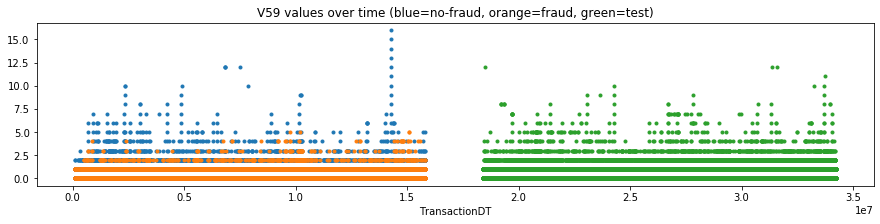

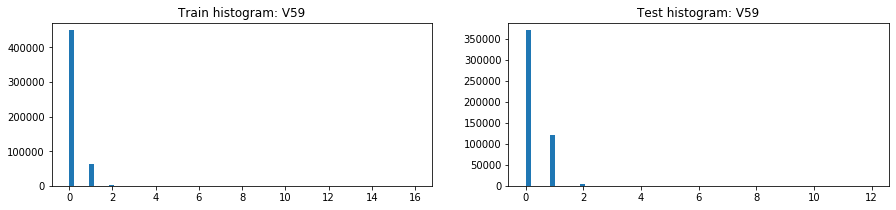

V59          Train   Train fraud  Train Not fraud  \
0           count  513444.000000  16154.000000    497290.000000   
1            mean       0.134433      0.452334         0.124107   
2             std       0.379291      0.600346         0.365292   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max      16.000000      5.000000        16.000000   
8   unique values      18.000000      7.000000        18.000000   
9            NaNs   77096.000000   4509.000000     72587.000000   
10     NaNs share       0.130600      0.218200         0.127400   

             Test   Test public   Test private  
0   493792.000000  93474.000000  400319.000000  
1        0.266398      0.123735       0.299708  
2        0.486771      0.387794       0.501294  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        1.000000      0.000000       1.000000  
7       12.000000     12.000000      12.000000  
8       14.000000     11.000000      14.000000  
9    12899.000000   7865.000000    5034.000000  
10       0.025500      0.077600       0.012400

V59  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 448636     0.021298        9555       369048.0
1 -999.0                  77096     0.058486        4509        12899.0
2    1.0                  61876     0.097760        6049       119715.0
3    2.0                   2264     0.190813         432         4054.0
4    3.0                    388     0.211340          82          605.0
5    4.0                    148     0.216216          32          171.0
6    5.0                     62     0.064516           4           91.0
7    6.0                     29     0.000000           0           43.0
8    7.0                     13     0.000000           0           36.0
9    8.0                      7     0.000000           0           17.0

V59  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          448636     0.021298               9555       369048.0
1    1.0           61876     0.097760               6049       119715.0
2 -999.0           77096     0.058486               4509        12899.0
3    2.0            2264     0.190813                432         4054.0
4    3.0             388     0.211340                 82          605.0
5    4.0             148     0.216216                 32          171.0
6    5.0              62     0.064516                  4           91.0
7   12.0               5     0.000000                  0            3.0
8   15.0               1     0.000000                  0            NaN
9   14.0               1     0.000000                  0            NaN

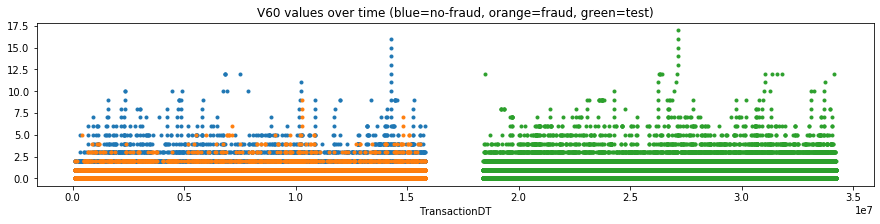

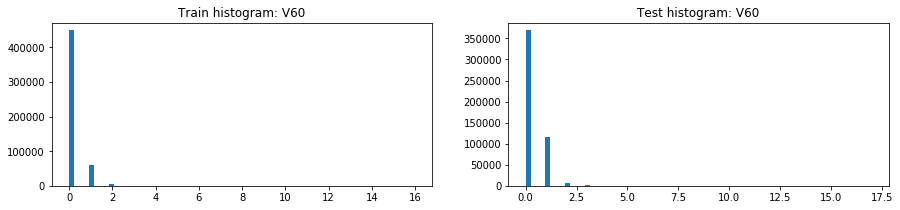

V60          Train   Train fraud  Train Not fraud  \
0           count  513444.000000  16154.000000    497290.000000   
1            mean       0.142537      0.492819         0.131159   
2             std       0.418230      0.688078         0.401378   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max      16.000000      9.000000        16.000000   
8   unique values      18.000000     11.000000        18.000000   
9            NaNs   77096.000000   4509.000000     72587.000000   
10     NaNs share       0.130600      0.218200         0.127400   

             Test   Test public   Test private  
0   493792.000000  93474.000000  400319.000000  
1        0.280408      0.134690       0.314432  
2        0.539676      0.438684       0.555163  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        1.000000      0.000000       1.000000  
7       17.000000     12.000000      17.000000  
8       19.000000     11.000000      19.000000  
9    12899.000000   7865.000000    5034.000000  
10       0.025500      0.077600       0.012400

V60  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 448369     0.021177        9495         368830
1 -999.0                  77096     0.058486        4509          12899
2    1.0                  59589     0.095370        5683         115570
3    2.0                   4065     0.187946         764           7218
4    3.0                    854     0.159251         136           1291
5    4.0                    296     0.175676          52            432
6    5.0                    137     0.124088          17            197
7    6.0                     52     0.057692           3            122
8    7.0                     24     0.083333           2             51
9    9.0                     21     0.047619           1             27

V60  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          448369     0.021177               9495         368830
1    1.0           59589     0.095370               5683         115570
2 -999.0           77096     0.058486               4509          12899
3    2.0            4065     0.187946                764           7218
4    3.0             854     0.159251                136           1291
5    4.0             296     0.175676                 52            432
6    5.0             137     0.124088                 17            197
7    6.0              52     0.057692                  3            122
8    7.0              24     0.083333                  2             51
9    8.0              17     0.058824                  1             26

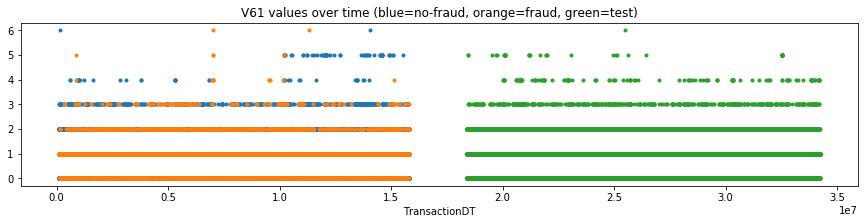

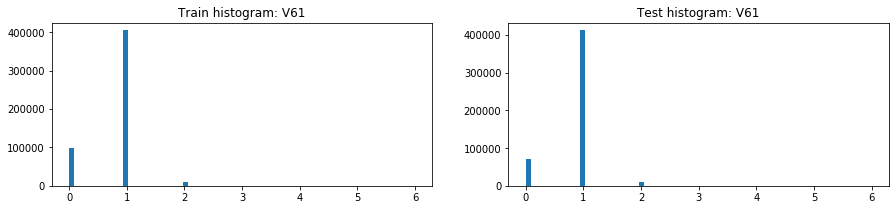

V61          Train   Train fraud  Train Not fraud  \
0           count  513444.000000  16154.000000    497290.000000   
1            mean       0.829785      0.949486         0.825896   
2             std       0.436617      0.503119         0.433733   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       6.000000      6.000000         6.000000   
8   unique values       8.000000      8.000000         8.000000   
9            NaNs   77096.000000   4509.000000     72587.000000   
10     NaNs share       0.130600      0.218200         0.127400   

             Test   Test public   Test private  
0   493792.000000  93474.000000  400319.000000  
1        0.879980      0.855596       0.885674  
2        0.397378      0.427601       0.389764  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7        6.000000      5.000000       6.000000  
8        8.000000      7.000000       8.000000  
9    12899.000000   7865.000000    5034.000000  
10       0.025500      0.077600       0.012400

V61  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 404182     0.031288       12646         412011
1    0.0                  98827     0.022808        2254          70995
2 -999.0                  77096     0.058486        4509          12899
3    2.0                   9620     0.113825        1095          10041
4    3.0                    702     0.202279         142            583
5    5.0                     60     0.066667           4             35
6    4.0                     49     0.224490          11            126
7    6.0                      4     0.500000           2              1

V61  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          404182     0.031288              12646         412011
1 -999.0           77096     0.058486               4509          12899
2    0.0           98827     0.022808               2254          70995
3    2.0            9620     0.113825               1095          10041
4    3.0             702     0.202279                142            583
5    4.0              49     0.224490                 11            126
6    5.0              60     0.066667                  4             35
7    6.0               4     0.500000                  2              1

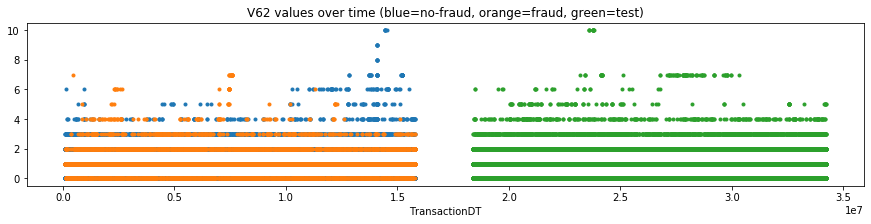

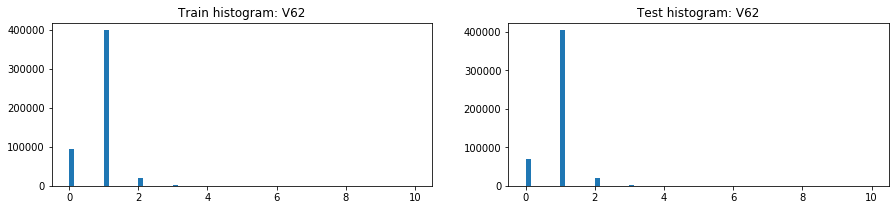

V62          Train   Train fraud  Train Not fraud  \
0           count  513444.000000  16154.000000    497290.000000   
1            mean       0.867563      1.061904         0.861250   
2             std       0.483803      0.685393         0.474493   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max      10.000000      7.000000        10.000000   
8   unique values      12.000000      9.000000        12.000000   
9            NaNs   77096.000000   4509.000000     72587.000000   
10     NaNs share       0.130600      0.218200         0.127400   

             Test   Test public   Test private  
0   493792.000000  93474.000000  400319.000000  
1        0.912862      0.892762       0.917556  
2        0.452732      0.477507       0.446619  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       10.000000      6.000000      10.000000  
8       10.000000      8.000000      10.000000  
9    12899.000000   7865.000000    5034.000000  
10       0.025500      0.077600       0.012400

V62  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 398513     0.029971       11944       403691.0
1    0.0                  93177     0.021711        2023        68371.0
2 -999.0                  77096     0.058486        4509        12899.0
3    2.0                  19368     0.083695        1621        19204.0
4    3.0                   1860     0.222581         414         1918.0
5    4.0                    287     0.324042          93          378.0
6    6.0                     82     0.256098          21           24.0
7    5.0                     78     0.243590          19          110.0
8    7.0                     63     0.301587          19           85.0
9   10.0                      6     0.000000           0           11.0

V62  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          398513     0.029971              11944         403691
1 -999.0           77096     0.058486               4509          12899
2    0.0           93177     0.021711               2023          68371
3    2.0           19368     0.083695               1621          19204
4    3.0            1860     0.222581                414           1918
5    4.0             287     0.324042                 93            378
6    6.0              82     0.256098                 21             24
7    5.0              78     0.243590                 19            110
8    7.0              63     0.301587                 19             85
9   10.0               6     0.000000                  0             11

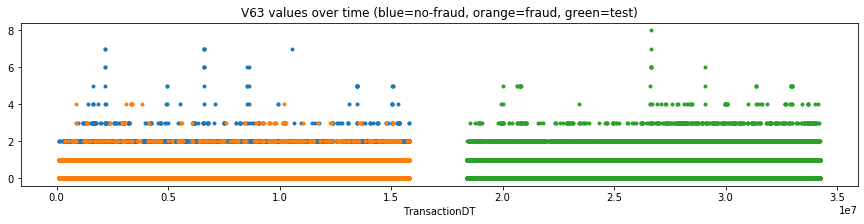

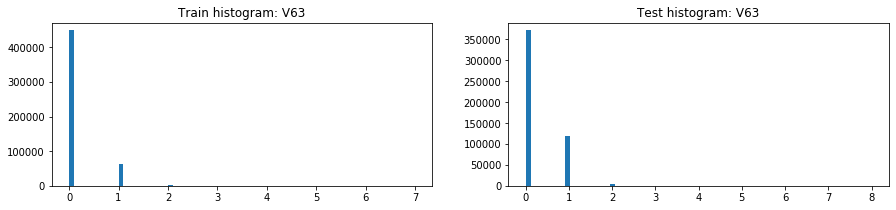

V63          Train   Train fraud  Train Not fraud  \
0           count  513444.000000  16154.000000    497290.000000   
1            mean       0.130743      0.433020         0.120923   
2             std       0.355262      0.557809         0.342257   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max       7.000000      4.000000         7.000000   
8   unique values       9.000000      6.000000         9.000000   
9            NaNs   77096.000000   4509.000000     72587.000000   
10     NaNs share       0.130600      0.218200         0.127400   

             Test   Test public   Test private  
0   493792.000000  93474.000000  400319.000000  
1        0.256800      0.116963       0.289452  
2        0.460787      0.344637       0.478055  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       1.000000  
7        8.000000      5.000000       8.000000  
8       10.000000      7.000000      10.000000  
9    12899.000000   7865.000000    5034.000000  
10       0.025500      0.077600       0.012400

V63  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 448961     0.021425        9619         371489
1 -999.0                  77096     0.058486        4509          12899
2    1.0                  62231     0.098600        6136         118419
3    2.0                   1969     0.176232         347           3388
4    3.0                    221     0.194570          43            415
5    4.0                     32     0.281250           9             49
6    5.0                     17     0.000000           0             25
7    6.0                      7     0.000000           0              5
8    7.0                      6     0.000000           0              1

V63  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          448961     0.021425               9619         371489
1    1.0           62231     0.098600               6136         118419
2 -999.0           77096     0.058486               4509          12899
3    2.0            1969     0.176232                347           3388
4    3.0             221     0.194570                 43            415
5    4.0              32     0.281250                  9             49
6    5.0              17     0.000000                  0             25
7    6.0               7     0.000000                  0              5
8    7.0               6     0.000000                  0              1

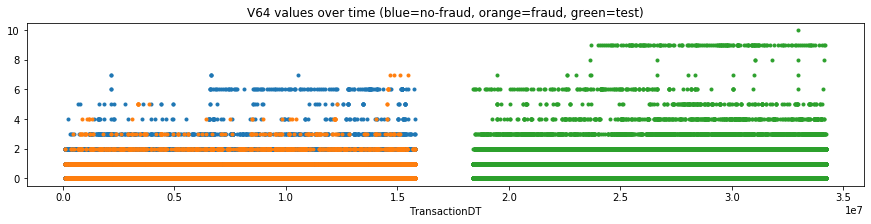

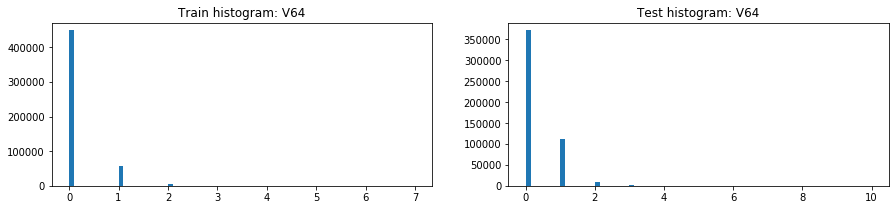

V64          Train   Train fraud  Train Not fraud  \
0           count  513444.000000  16154.000000    497290.000000   
1            mean       0.141825      0.480686         0.130817   
2             std       0.406157      0.664032         0.390062   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max       7.000000      7.000000         7.000000   
8   unique values       9.000000      9.000000         9.000000   
9            NaNs   77096.000000   4509.000000     72587.000000   
10     NaNs share       0.130600      0.218200         0.127400   

             Test   Test public   Test private  
0   493792.000000  93474.000000  400319.000000  
1        0.279527      0.132069       0.313957  
2        0.554101      0.417240       0.576026  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       1.000000  
7       10.000000      7.000000      10.000000  
8       12.000000      9.000000      12.000000  
9    12899.000000   7865.000000    5034.000000  
10       0.025500      0.077600       0.012400

V64  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 448662     0.021301        9557         371179
1 -999.0                  77096     0.058486        4509          12899
2    1.0                  58547     0.097187        5690         112063
3    2.0                   5145     0.139359         717           8094
4    3.0                    757     0.195509         148           1467
5    6.0                    144     0.027778           4            149
6    4.0                    118     0.211864          25            460
7    5.0                     61     0.147541           9            187
8    7.0                     10     0.400000           4             12

V64  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          448662     0.021301               9557         371179
1    1.0           58547     0.097187               5690         112063
2 -999.0           77096     0.058486               4509          12899
3    2.0            5145     0.139359                717           8094
4    3.0             757     0.195509                148           1467
5    4.0             118     0.211864                 25            460
6    5.0              61     0.147541                  9            187
7    6.0             144     0.027778                  4            149
8    7.0              10     0.400000                  4             12

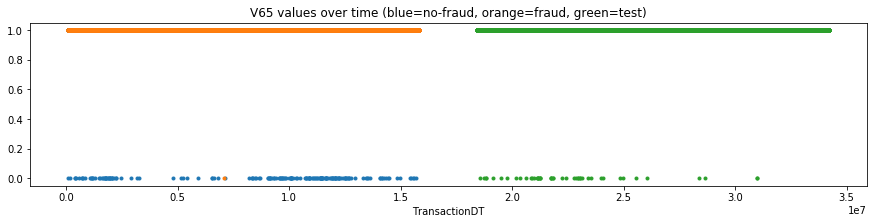

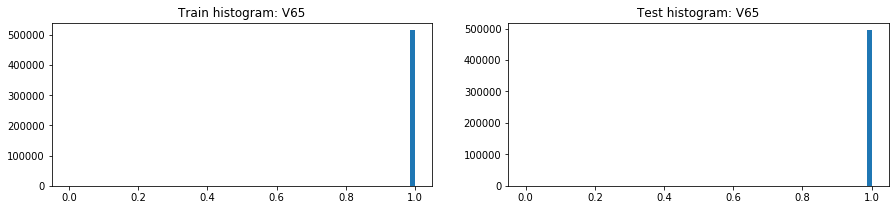

V65          Train   Train fraud  Train Not fraud  \
0           count  513444.000000  16154.000000    497290.000000   
1            mean       0.999663      0.999938         0.999654   
2             std       0.018353      0.007868         0.018595   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       1.000000      1.000000         1.000000   
8   unique values       3.000000      3.000000         3.000000   
9            NaNs   77096.000000   4509.000000     72587.000000   
10     NaNs share       0.130600      0.218200         0.127400   

             Test   Test public   Test private  
0   493792.000000  93474.000000  400319.000000  
1        0.999907      0.999754       0.999943  
2        0.009651      0.015684       0.007580  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7        1.000000      1.000000       1.000000  
8        3.000000      3.000000       3.000000  
9    12899.000000   7865.000000    5034.000000  
10       0.025500      0.077600       0.012400

V65  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 513271     0.031471       16153         493746
1 -999.0                  77096     0.058486        4509          12899
2    0.0                    173     0.005780           1             46

V65  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          513271     0.031471              16153         493746
1 -999.0           77096     0.058486               4509          12899
2    0.0             173     0.005780                  1             46

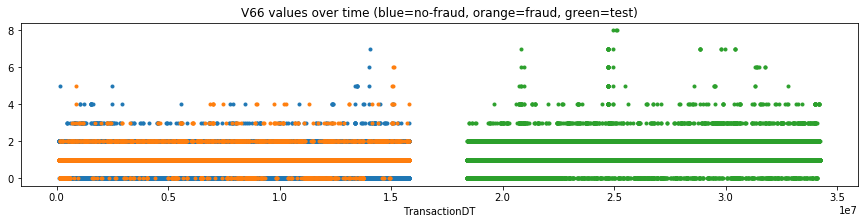

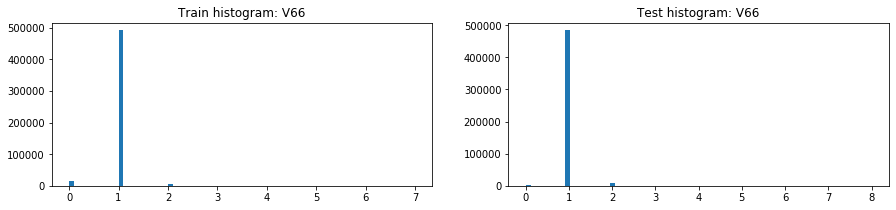

V66          Train   Train fraud  Train Not fraud          Test  \
0           count  513444.000000  16154.000000    497290.000000  493792.00000   
1            mean       0.981038      1.026185         0.979571       1.01544   
2             std       0.216235      0.363635         0.209554       0.17070   
3             min       0.000000      0.000000         0.000000       0.00000   
4             25%       1.000000      1.000000         1.000000       1.00000   
5             50%       1.000000      1.000000         1.000000       1.00000   
6             75%       1.000000      1.000000         1.000000       1.00000   
7             max       7.000000      6.000000         7.000000       8.00000   
8   unique values       9.000000      8.000000         9.000000      10.00000   
9            NaNs   77096.000000   4509.000000     72587.000000   12899.00000   
10     NaNs share       0.130600      0.218200         0.127400       0.02550   

     Test public   Test private  
0   93474.000000  400319.000000  
1       1.007039       1.017401  
2       0.181799       0.167942  
3       0.000000       0.000000  
4       1.000000       1.000000  
5       1.000000       1.000000  
6       1.000000       1.000000  
7       7.000000       8.000000  
8       9.000000      10.000000  
9    7865.000000    5034.000000  
10      0.077600       0.012400

V66  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 490779     0.029563       14509         483557
1 -999.0                  77096     0.058486        4509          12899
2    0.0                  16418     0.041479         681           1828
3    2.0                   5897     0.145159         856           7692
4    3.0                    285     0.291228          83            523
5    4.0                     50     0.400000          20            124
6    5.0                     11     0.272727           3             25
7    6.0                      3     0.666667           2             19
8    7.0                      1     0.000000           0             21

V66  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          490779     0.029563              14509         483557
1 -999.0           77096     0.058486               4509          12899
2    2.0            5897     0.145159                856           7692
3    0.0           16418     0.041479                681           1828
4    3.0             285     0.291228                 83            523
5    4.0              50     0.400000                 20            124
6    5.0              11     0.272727                  3             25
7    6.0               3     0.666667                  2             19
8    7.0               1     0.000000                  0             21

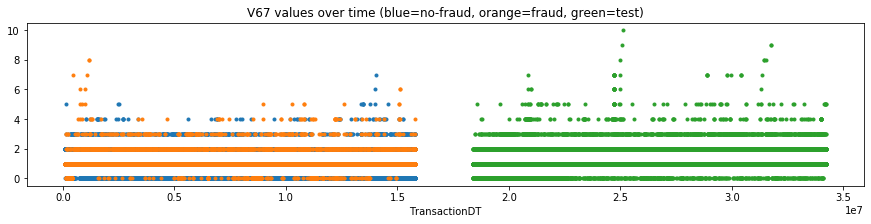

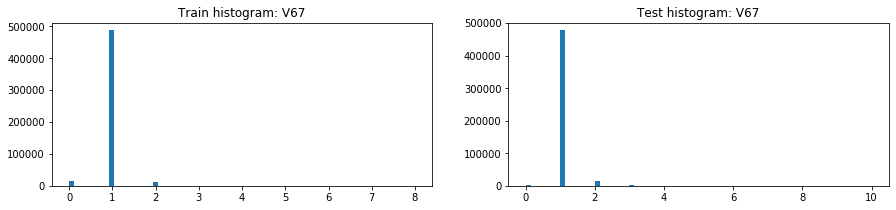

V67          Train   Train fraud  Train Not fraud  \
0           count  513444.000000  16154.000000    497290.000000   
1            mean       0.998121      1.102080         0.994744   
2             std       0.245912      0.484941         0.233315   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       8.000000      8.000000         7.000000   
8   unique values      10.000000     10.000000         9.000000   
9            NaNs   77096.000000   4509.000000     72587.000000   
10     NaNs share       0.130600      0.218200         0.127400   

             Test   Test public   Test private  
0   493792.000000  93474.000000  400319.000000  
1        1.031714      1.025376       1.033194  
2        0.220386      0.231832       0.217600  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       10.000000      7.000000      10.000000  
8       12.000000      9.000000      12.000000  
9    12899.000000   7865.000000    5034.000000  
10       0.025500      0.077600       0.012400

V67  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 486457     0.028220       13728         476992
1 -999.0                  77096     0.058486        4509          12899
2    0.0                  14565     0.040783         594           1567
3    2.0                  11435     0.133013        1521          13732
4    3.0                    844     0.287915         243           1215
5    4.0                    112     0.446429          50            166
6    5.0                     21     0.476190          10             76
7    6.0                      5     0.800000           4             14
8    7.0                      3     0.666667           2             22
9    8.0                      2     1.000000           2              4

V67  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          486457     0.028220              13728         476992
1 -999.0           77096     0.058486               4509          12899
2    2.0           11435     0.133013               1521          13732
3    0.0           14565     0.040783                594           1567
4    3.0             844     0.287915                243           1215
5    4.0             112     0.446429                 50            166
6    5.0              21     0.476190                 10             76
7    6.0               5     0.800000                  4             14
8    7.0               3     0.666667                  2             22
9    8.0               2     1.000000                  2              4

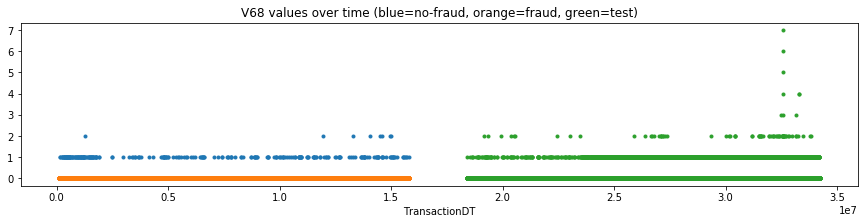

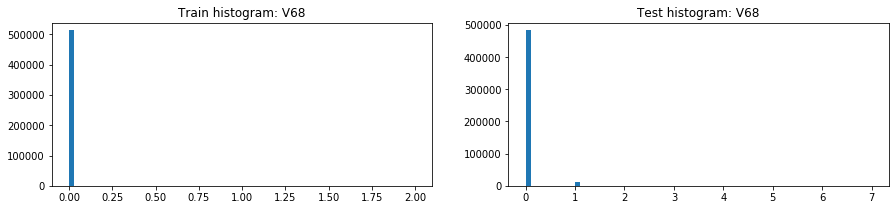

V68          Train  Train fraud  Train Not fraud           Test  \
0           count  513444.000000   16154.0000    497290.000000  493792.000000   
1            mean       0.000534       0.0000         0.000551       0.023170   
2             std       0.023760       0.0000         0.024142       0.152382   
3             min       0.000000       0.0000         0.000000       0.000000   
4             25%       0.000000       0.0000         0.000000       0.000000   
5             50%       0.000000       0.0000         0.000000       0.000000   
6             75%       0.000000       0.0000         0.000000       0.000000   
7             max       2.000000       0.0000         2.000000       7.000000   
8   unique values       4.000000       2.0000         4.000000       9.000000   
9            NaNs   77096.000000    4509.0000     72587.000000   12899.000000   
10     NaNs share       0.130600       0.2182         0.127400       0.025500   

     Test public   Test private  
0   93474.000000  400319.000000  
1       0.000974       0.028352  
2       0.033181       0.168057  
3       0.000000       0.000000  
4       0.000000       0.000000  
5       0.000000       0.000000  
6       0.000000       0.000000  
7       2.000000       7.000000  
8       4.000000       9.000000  
9    7865.000000    5034.000000  
10      0.077600       0.012400

V68  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 513178     0.031478       16154         482453
1 -999.0                  77096     0.058486        4509          12899
2    1.0                    258     0.000000           0          11258
3    2.0                      8     0.000000           0             72

V68  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          513178     0.031478              16154         482453
1 -999.0           77096     0.058486               4509          12899
2    1.0             258     0.000000                  0          11258
3    2.0               8     0.000000                  0             72

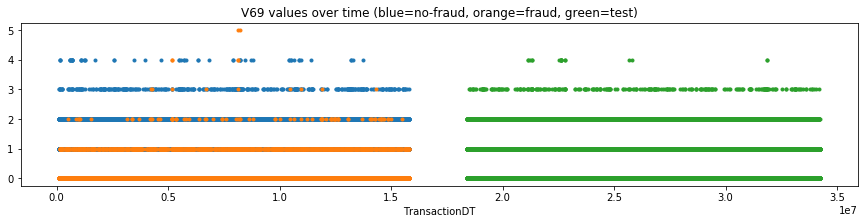

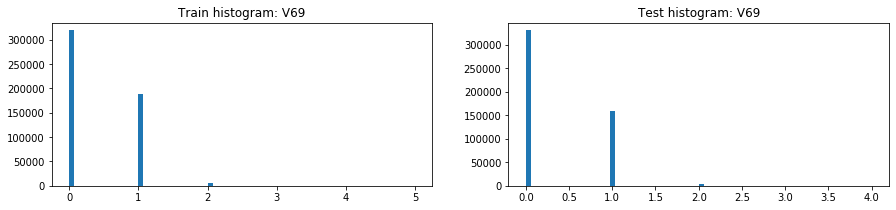

V69          Train   Train fraud  Train Not fraud  \
0           count  513444.000000  16154.000000    497290.000000   
1            mean       0.390200      0.092299         0.399877   
2             std       0.513696      0.321093         0.515878   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       1.000000      0.000000         1.000000   
7             max       5.000000      5.000000         4.000000   
8   unique values       7.000000      7.000000         6.000000   
9            NaNs   77096.000000   4509.000000     72587.000000   
10     NaNs share       0.130600      0.218200         0.127400   

             Test   Test public   Test private  
0   493792.000000  93474.000000  400319.000000  
1        0.339386      0.407226       0.323547  
2        0.494510      0.514653       0.488333  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        1.000000      1.000000       1.000000  
7        4.000000      4.000000       4.000000  
8        6.000000      6.000000       6.000000  
9    12899.000000   7865.000000    5034.000000  
10       0.025500      0.077600       0.012400

V69  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 319136     0.046331       14786       330879.0
1    1.0                 188826     0.006715        1268       158570.0
2 -999.0                  77096     0.058486        4509        12899.0
3    2.0                   4989     0.017037          85         4031.0
4    3.0                    432     0.020833           9          294.0
5    4.0                     59     0.067797           4           18.0
6    5.0                      2     1.000000           2            NaN

V69  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          319136     0.046331              14786       330879.0
1 -999.0           77096     0.058486               4509        12899.0
2    1.0          188826     0.006715               1268       158570.0
3    2.0            4989     0.017037                 85         4031.0
4    3.0             432     0.020833                  9          294.0
5    4.0              59     0.067797                  4           18.0
6    5.0               2     1.000000                  2            NaN

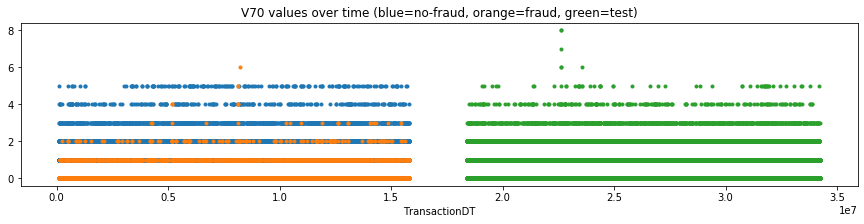

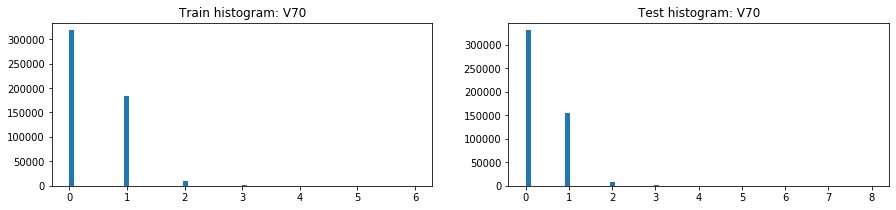

V70          Train   Train fraud  Train Not fraud  \
0           count  513444.000000  16154.000000    497290.000000   
1            mean       0.407924      0.097499         0.418008   
2             std       0.554499      0.344715         0.557105   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       1.000000      0.000000         1.000000   
7             max       6.000000      6.000000         5.000000   
8   unique values       8.000000      8.000000         7.000000   
9            NaNs   77096.000000   4509.000000     72587.000000   
10     NaNs share       0.130600      0.218200         0.127400   

             Test   Test public   Test private  
0   493792.000000  93474.000000  400319.000000  
1        0.353799      0.423701       0.337478  
2        0.530724      0.549443       0.524920  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        1.000000      1.000000       1.000000  
7        8.000000      5.000000       8.000000  
8       10.000000      7.000000      10.000000  
9    12899.000000   7865.000000    5034.000000  
10       0.025500      0.077600       0.012400

V70  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 317801     0.046507       14780         330132
1    1.0                 184177     0.006559        1208         154228
2 -999.0                  77096     0.058486        4509          12899
3    2.0                   9739     0.014375         140           8172
4    3.0                   1296     0.015432          20            982
5    4.0                    253     0.015810           4            216
6    5.0                    177     0.005650           1             56
7    6.0                      1     1.000000           1              3

V70  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          317801     0.046507              14780         330132
1 -999.0           77096     0.058486               4509          12899
2    1.0          184177     0.006559               1208         154228
3    2.0            9739     0.014375                140           8172
4    3.0            1296     0.015432                 20            982
5    4.0             253     0.015810                  4            216
6    5.0             177     0.005650                  1             56
7    6.0               1     1.000000                  1              3

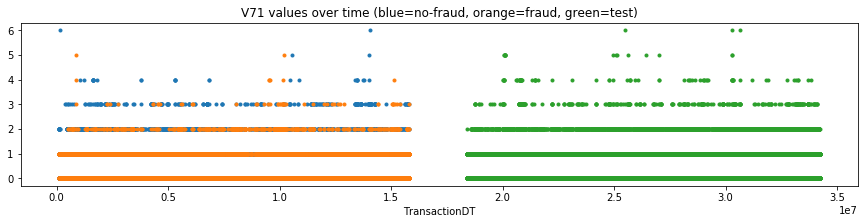

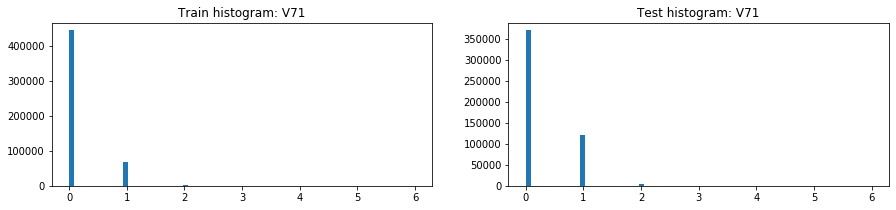

V71          Train   Train fraud  Train Not fraud  \
0           count  513444.000000  16154.000000    497290.000000   
1            mean       0.140639      0.457658         0.130340   
2             std       0.364303      0.575374         0.350576   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max       6.000000      5.000000         6.000000   
8   unique values       8.000000      7.000000         8.000000   
9            NaNs   77096.000000   4509.000000     72587.000000   
10     NaNs share       0.130600      0.218200         0.127400   

             Test   Test public   Test private  
0   493792.000000  93474.000000  400319.000000  
1        0.258738      0.122408       0.290571  
2        0.459744      0.354751       0.475373  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        1.000000      0.000000       1.000000  
7        6.000000      5.000000       6.000000  
8        8.000000      7.000000       8.000000  
9    12899.000000   7865.000000    5034.000000  
10       0.025500      0.077600       0.012400

V71  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 443821     0.021065        9349         370174
1 -999.0                  77096     0.058486        4509          12899
2    1.0                  67435     0.093216        6286         120022
3    2.0                   1837     0.250408         460           3161
4    3.0                    311     0.163987          51            342
5    4.0                     34     0.176471           6             75
6    5.0                      4     0.500000           2             15
7    6.0                      2     0.000000           0              3

V71  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          443821     0.021065               9349         370174
1    1.0           67435     0.093216               6286         120022
2 -999.0           77096     0.058486               4509          12899
3    2.0            1837     0.250408                460           3161
4    3.0             311     0.163987                 51            342
5    4.0              34     0.176471                  6             75
6    5.0               4     0.500000                  2             15
7    6.0               2     0.000000                  0              3

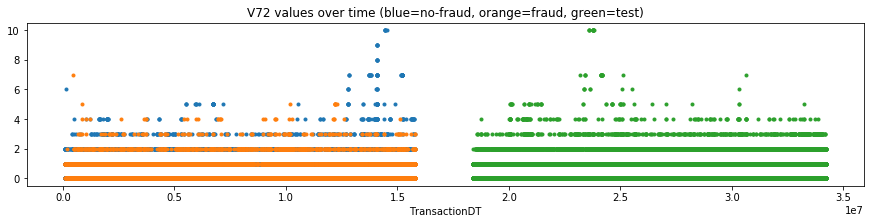

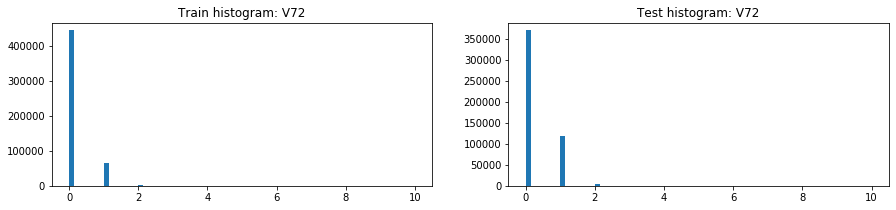

V72          Train   Train fraud  Train Not fraud  \
0           count  513444.000000  16154.000000    497290.000000   
1            mean       0.145124      0.492695         0.133833   
2             std       0.389212      0.649762         0.372346   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max      10.000000      7.000000        10.000000   
8   unique values      12.000000      8.000000        12.000000   
9            NaNs   77096.000000   4509.000000     72587.000000   
10     NaNs share       0.130600      0.218200         0.127400   

             Test   Test public   Test private  
0   493792.000000  93474.000000  400319.000000  
1        0.264749      0.127490       0.296798  
2        0.481518      0.379355       0.496960  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        1.000000      0.000000       1.000000  
7       10.000000      5.000000      10.000000  
8       10.000000      7.000000      10.000000  
9    12899.000000   7865.000000    5034.000000  
10       0.025500      0.077600       0.012400

V72  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 443611     0.021009        9320       370131.0
1 -999.0                  77096     0.058486        4509        12899.0
2    1.0                  66364     0.089100        5913       117888.0
3    2.0                   2802     0.273019         765         4879.0
4    3.0                    413     0.288136         119          676.0
5    4.0                    129     0.217054          28          134.0
6    5.0                     54     0.148148           8           46.0
7    7.0                     45     0.022222           1           19.0
8    6.0                     10     0.000000           0            8.0
9   10.0                      6     0.000000           0           11.0

V72  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          443611     0.021009               9320         370131
1    1.0           66364     0.089100               5913         117888
2 -999.0           77096     0.058486               4509          12899
3    2.0            2802     0.273019                765           4879
4    3.0             413     0.288136                119            676
5    4.0             129     0.217054                 28            134
6    5.0              54     0.148148                  8             46
7    7.0              45     0.022222                  1             19
8    6.0              10     0.000000                  0              8
9   10.0               6     0.000000                  0             11

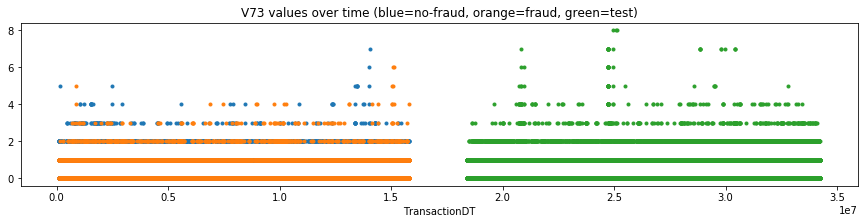

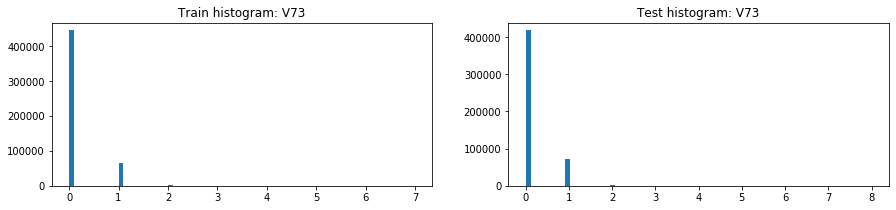

V73          Train   Train fraud  Train Not fraud  \
0           count  513444.000000  16154.000000    497290.000000   
1            mean       0.139982      0.494119         0.128478   
2             std       0.367098      0.605386         0.350753   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max       7.000000      6.000000         7.000000   
8   unique values       9.000000      8.000000         9.000000   
9            NaNs   77096.000000   4509.000000     72587.000000   
10     NaNs share       0.130600      0.218200         0.127400   

             Test   Test public   Test private  
0   493792.000000  93474.000000  400319.000000  
1        0.162216      0.126656       0.170519  
2        0.397462      0.359843       0.405296  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7        8.000000      7.000000       8.000000  
8       10.000000      9.000000      10.000000  
9    12899.000000   7865.000000    5034.000000  
10       0.025500      0.077600       0.012400

V73  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 444786     0.020124        8951         417899
1 -999.0                  77096     0.058486        4509          12899
2    1.0                  65814     0.099508        6549          72433
3    2.0                   2551     0.218346         557           2991
4    3.0                    235     0.323404          76            312
5    4.0                     43     0.372093          16             98
6    5.0                     11     0.272727           3             23
7    6.0                      3     0.666667           2             12
8    7.0                      1     0.000000           0             21

V73  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          444786     0.020124               8951         417899
1    1.0           65814     0.099508               6549          72433
2 -999.0           77096     0.058486               4509          12899
3    2.0            2551     0.218346                557           2991
4    3.0             235     0.323404                 76            312
5    4.0              43     0.372093                 16             98
6    5.0              11     0.272727                  3             23
7    6.0               3     0.666667                  2             12
8    7.0               1     0.000000                  0             21

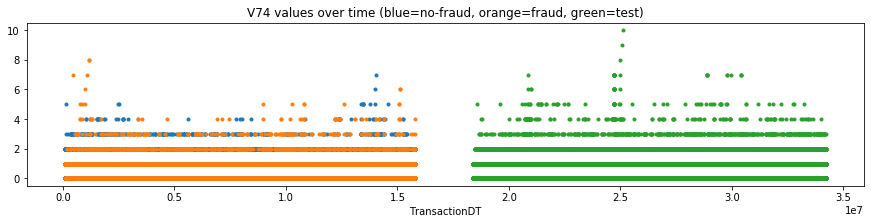

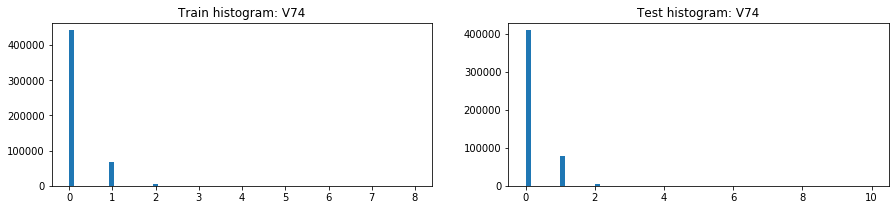

V74          Train   Train fraud  Train Not fraud  \
0           count  513444.000000  16154.000000    497290.000000   
1            mean       0.152147      0.557818         0.138969   
2             std       0.393274      0.698917         0.371890   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max       8.000000      8.000000         7.000000   
8   unique values      10.000000     10.000000         9.000000   
9            NaNs   77096.000000   4509.000000     72587.000000   
10     NaNs share       0.130600      0.218200         0.127400   

             Test   Test public   Test private  
0   493792.000000  93474.000000  400319.000000  
1        0.186044      0.149699       0.194530  
2        0.434991      0.402062       0.441897  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7       10.000000      7.000000      10.000000  
8       12.000000      9.000000      12.000000  
9    12899.000000   7865.000000    5034.000000  
10       0.025500      0.077600       0.012400

V74  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 440878     0.019547        8618         409188
1 -999.0                  77096     0.058486        4509          12899
2    1.0                  67816     0.094373        6400          78706
3    2.0                   4109     0.215381         885           4955
4    3.0                    525     0.367619         193            693
5    4.0                     86     0.476744          41            145
6    5.0                     21     0.476190          10             68
7    6.0                      4     0.750000           3             13
8    7.0                      3     0.666667           2             21
9    8.0                      2     1.000000           2              1

V74  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          440878     0.019547               8618         409188
1    1.0           67816     0.094373               6400          78706
2 -999.0           77096     0.058486               4509          12899
3    2.0            4109     0.215381                885           4955
4    3.0             525     0.367619                193            693
5    4.0              86     0.476744                 41            145
6    5.0              21     0.476190                 10             68
7    6.0               4     0.750000                  3             13
8    7.0               3     0.666667                  2             21
9    8.0               2     1.000000                  2              1

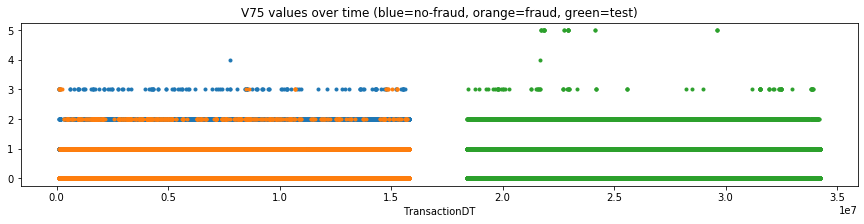

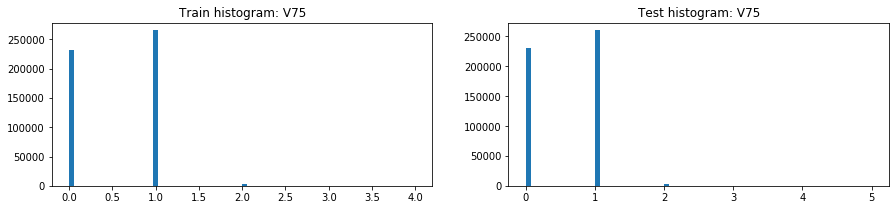

V75          Train   Train fraud  Train Not fraud  \
0           count  501376.000000  16387.000000    484989.000000   
1            mean       0.544278      0.398304         0.549210   
2             std       0.514318      0.545796         0.512495   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       1.000000      0.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       4.000000      3.000000         4.000000   
8   unique values       6.000000      5.000000         6.000000   
9            NaNs   89164.000000   4276.000000     84888.000000   
10     NaNs share       0.151000      0.206900         0.149000   

             Test   Test public   Test private  
0   494610.000000  94022.000000  400589.000000  
1        0.538879      0.627842       0.517997  
2        0.512770      0.499932       0.513509  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7        5.000000      5.000000       5.000000  
8        7.000000      7.000000       6.000000  
9    12081.000000   7317.000000    4764.000000  
10       0.023800      0.072200       0.011800

V75  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 265082     0.021239        5630         259969
1    0.0                 232467     0.044385       10318         231432
2 -999.0                  89164     0.047957        4276          12081
3    2.0                   3676     0.114255         420           3106
4    3.0                    150     0.126667          19             80
5    4.0                      1     0.000000           0              1

V75  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          232467     0.044385              10318         231432
1    1.0          265082     0.021239               5630         259969
2 -999.0           89164     0.047957               4276          12081
3    2.0            3676     0.114255                420           3106
4    3.0             150     0.126667                 19             80
5    4.0               1     0.000000                  0              1

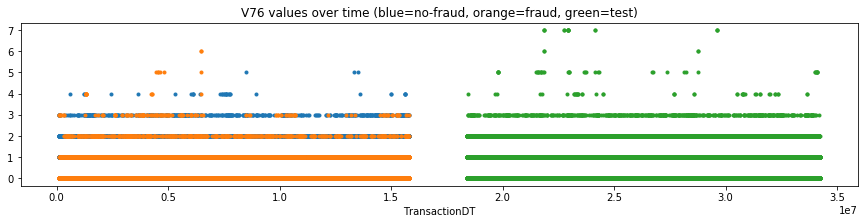

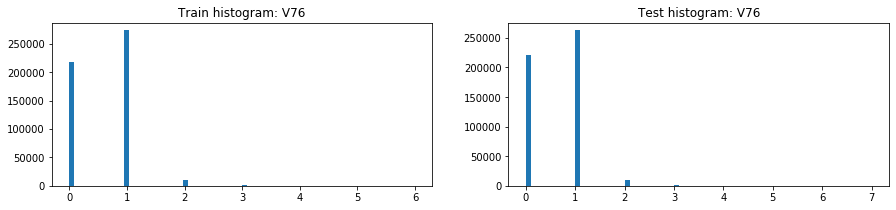

V76          Train   Train fraud  Train Not fraud  \
0           count  501376.000000  16387.000000    484989.000000   
1            mean       0.587557      0.451638         0.592150   
2             std       0.538230      0.624103         0.534486   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       1.000000      0.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       6.000000      6.000000         5.000000   
8   unique values       8.000000      8.000000         7.000000   
9            NaNs   89164.000000   4276.000000     84888.000000   
10     NaNs share       0.151000      0.206900         0.149000   

             Test   Test public   Test private  
0   494610.000000  94022.000000  400589.000000  
1        0.573796      0.670194       0.551168  
2        0.542721      0.526512       0.543986  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7        7.000000      5.000000       7.000000  
8        9.000000      7.000000       9.000000  
9    12081.000000   7317.000000    4764.000000  
10       0.023800      0.072200       0.011800

V76  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 273293     0.020864        5702         262516
1    0.0                 217817     0.045570        9926         221908
2 -999.0                  89164     0.047957        4276          12081
3    2.0                   9571     0.063421         607           9466
4    3.0                    641     0.207488         133            617
5    4.0                     43     0.255814          11             45
6    5.0                      9     0.666667           6             38
7    6.0                      2     1.000000           2              4

V76  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          217817     0.045570               9926         221908
1    1.0          273293     0.020864               5702         262516
2 -999.0           89164     0.047957               4276          12081
3    2.0            9571     0.063421                607           9466
4    3.0             641     0.207488                133            617
5    4.0              43     0.255814                 11             45
6    5.0               9     0.666667                  6             38
7    6.0               2     1.000000                  2              4

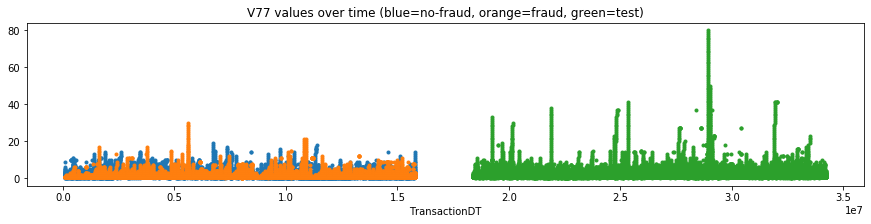

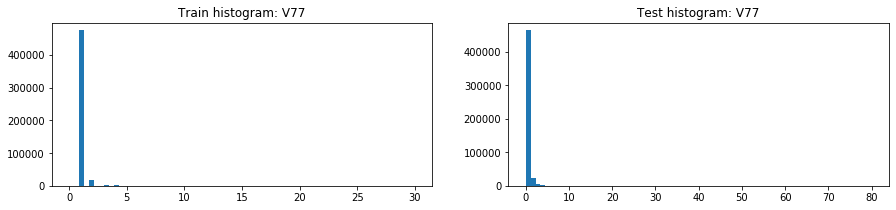

V77          Train   Train fraud  Train Not fraud  \
0           count  501376.000000  16387.000000    484989.000000   
1            mean       1.086893      1.546104         1.071377   
2             std       0.532958      1.677384         0.437279   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max      30.000000     30.000000        19.000000   
8   unique values      32.000000     32.000000        21.000000   
9            NaNs   89164.000000   4276.000000     84888.000000   
10     NaNs share       0.151000      0.206900         0.149000   

             Test   Test public   Test private  
0   494610.000000  94022.000000  400589.000000  
1        1.123978      1.105911       1.128219  
2        1.020732      0.717580       1.079576  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       80.000000     33.000000      80.000000  
8       82.000000     35.000000      82.000000  
9    12081.000000   7317.000000    4764.000000  
10       0.023800      0.072200       0.011800

V77  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 474434     0.027321       12962         463392
1 -999.0                  89164     0.047957        4276          12081
2    2.0                  18955     0.089633        1699          22014
3    3.0                   3695     0.169689         627           4221
4    4.0                   1623     0.243993         396           1914
5    5.0                    742     0.247978         184            855
6    0.0                    571     0.019264          11            205
7    6.0                    415     0.303614         126            584
8    7.0                    297     0.370370         110            314
9    8.0                    183     0.333333          61            242

V77  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          474434     0.027321              12962         463392
1 -999.0           89164     0.047957               4276          12081
2    2.0           18955     0.089633               1699          22014
3    3.0            3695     0.169689                627           4221
4    4.0            1623     0.243993                396           1914
5    5.0             742     0.247978                184            855
6    6.0             415     0.303614                126            584
7    7.0             297     0.370370                110            314
8    9.0             157     0.420382                 66            137
9    8.0             183     0.333333                 61            242

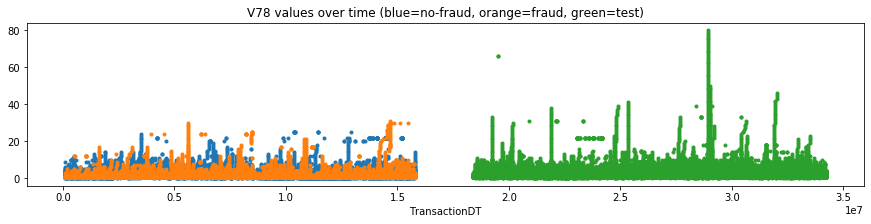

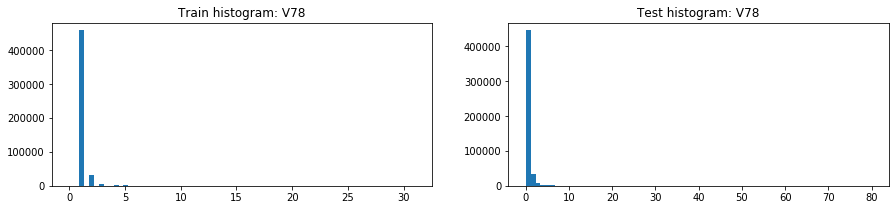

V78          Train   Train fraud  Train Not fraud  \
0           count  501376.000000  16387.000000    484989.000000   
1            mean       1.144462      1.783975         1.122854   
2             std       0.781474      2.366350         0.654110   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      2.000000         1.000000   
7             max      31.000000     31.000000        25.000000   
8   unique values      33.000000     33.000000        27.000000   
9            NaNs   89164.000000   4276.000000     84888.000000   
10     NaNs share       0.151000      0.206900         0.149000   

             Test   Test public   Test private  
0   494610.000000  94022.000000  400589.000000  
1        1.191442      1.165185       1.197604  
2        1.167254      0.864204       1.227508  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       80.000000     66.000000      80.000000  
8       82.000000     36.000000      82.000000  
9    12081.000000   7317.000000    4764.000000  
10       0.023800      0.072200       0.011800

V78  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 457915     0.026145       11972         445500
1 -999.0                  89164     0.047957        4276          12081
2    2.0                  31364     0.068199        2139          34375
3    3.0                   6135     0.143439         880           7032
4    4.0                   2261     0.204334         462           2938
5    5.0                   1125     0.232889         262           1431
6    6.0                    609     0.270936         165            886
7    0.0                    571     0.019264          11            202
8    7.0                    353     0.303116         107            463
9    8.0                    211     0.327014          69            402

V78  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          457915     0.026145              11972         445500
1 -999.0           89164     0.047957               4276          12081
2    2.0           31364     0.068199               2139          34375
3    3.0            6135     0.143439                880           7032
4    4.0            2261     0.204334                462           2938
5    5.0            1125     0.232889                262           1431
6    6.0             609     0.270936                165            886
7    7.0             353     0.303116                107            463
8    8.0             211     0.327014                 69            402
9    9.0             157     0.312102                 49            298

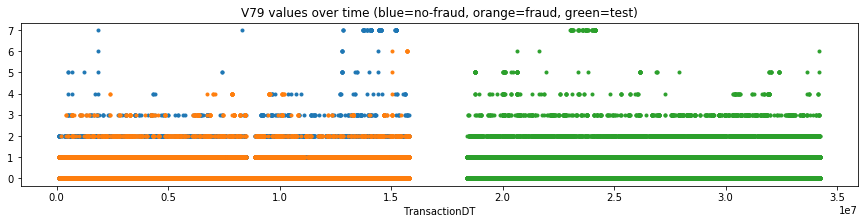

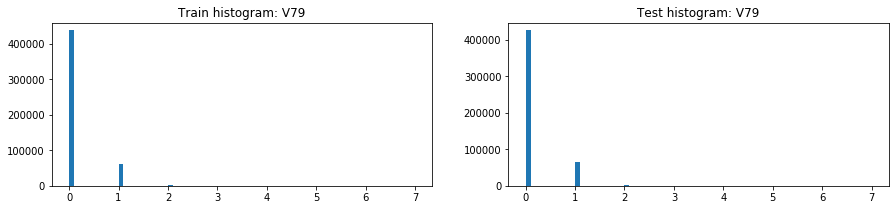

V79          Train   Train fraud  Train Not fraud  \
0           count  501376.000000  16387.000000    484989.000000   
1            mean       0.136867      0.538109         0.123310   
2             std       0.379904      0.667046         0.358534   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max       7.000000      6.000000         7.000000   
8   unique values       9.000000      8.000000         9.000000   
9            NaNs   89164.000000   4276.000000     84888.000000   
10     NaNs share       0.151000      0.206900         0.149000   

             Test   Test public   Test private  
0   494610.000000  94022.000000  400589.000000  
1        0.150820      0.115399       0.159133  
2        0.399481      0.366889       0.406306  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7        7.000000      6.000000       7.000000  
8        9.000000      8.000000       9.000000  
9    12081.000000   7317.000000    4764.000000  
10       0.023800      0.072200       0.011800

V79  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 436802     0.020149        8801         425386
1 -999.0                  89164     0.047957        4276          12081
2    1.0                  61751     0.107739        6653          65288
3    2.0                   2179     0.316659         690           3020
4    3.0                    435     0.464368         202            662
5    7.0                    109     0.000000           0             64
6    4.0                     68     0.485294          33            118
7    5.0                     19     0.052632           1             69
8    6.0                     13     0.538462           7              3

V79  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          436802     0.020149               8801         425386
1    1.0           61751     0.107739               6653          65288
2 -999.0           89164     0.047957               4276          12081
3    2.0            2179     0.316659                690           3020
4    3.0             435     0.464368                202            662
5    4.0              68     0.485294                 33            118
6    6.0              13     0.538462                  7              3
7    5.0              19     0.052632                  1             69
8    7.0             109     0.000000                  0             64

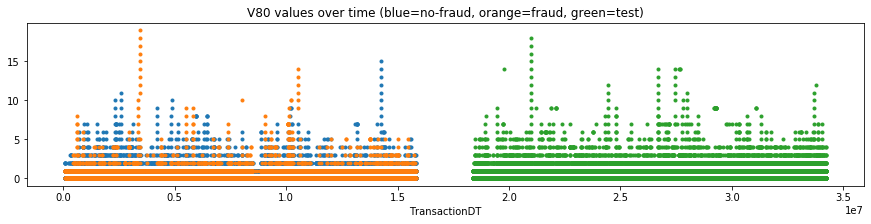

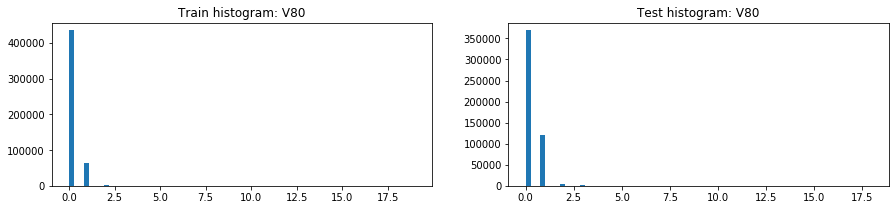

V80          Train   Train fraud  Train Not fraud  \
0           count  501376.000000  16387.000000    484989.000000   
1            mean       0.143954      0.546043         0.130368   
2             std       0.409932      0.865550         0.377840   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max      19.000000     19.000000        15.000000   
8   unique values      21.000000     21.000000        17.000000   
9            NaNs   89164.000000   4276.000000     84888.000000   
10     NaNs share       0.151000      0.206900         0.149000   

             Test   Test public   Test private  
0   494610.000000  94022.000000  400589.000000  
1        0.270427      0.130959       0.303161  
2        0.508879      0.426872       0.520895  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        1.000000      0.000000       1.000000  
7       18.000000     18.000000      14.000000  
8       20.000000     20.000000      16.000000  
9    12081.000000   7317.000000    4764.000000  
10       0.023800      0.072200       0.011800

V80  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 434732     0.020751        9021       368894.0
1 -999.0                  89164     0.047957        4276        12081.0
2    1.0                  63368     0.103901        6584       120578.0
3    2.0                   2283     0.215506         492         3797.0
4    3.0                    475     0.235789         112          731.0
5    4.0                    245     0.322449          79          281.0
6    5.0                    112     0.330357          37          116.0
7    6.0                     52     0.307692          16           69.0
8    7.0                     48     0.354167          17           58.0
9    8.0                     20     0.300000           6           18.0

V80  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          434732     0.020751               9021         368894
1    1.0           63368     0.103901               6584         120578
2 -999.0           89164     0.047957               4276          12081
3    2.0            2283     0.215506                492           3797
4    3.0             475     0.235789                112            731
5    4.0             245     0.322449                 79            281
6    5.0             112     0.330357                 37            116
7    7.0              48     0.354167                 17             58
8    6.0              52     0.307692                 16             69
9    8.0              20     0.300000                  6             18

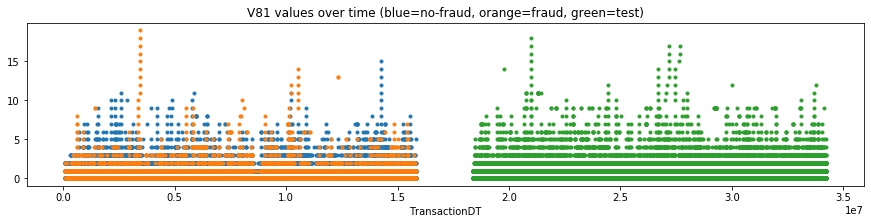

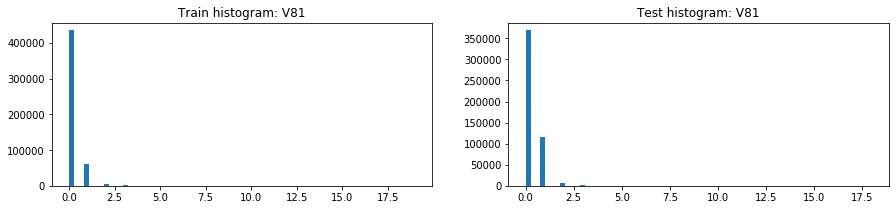

V81          Train   Train fraud  Train Not fraud  \
0           count  501376.000000  16387.000000    484989.000000   
1            mean       0.152696      0.601452         0.137533   
2             std       0.452298      0.976099         0.415043   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max      19.000000     19.000000        15.000000   
8   unique values      21.000000     21.000000        17.000000   
9            NaNs   89164.000000   4276.000000     84888.000000   
10     NaNs share       0.151000      0.206900         0.149000   

             Test   Test public   Test private  
0   494610.000000  94022.000000  400589.000000  
1        0.285409      0.144413       0.318501  
2        0.568899      0.504404       0.578041  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        1.000000      0.000000       1.000000  
7       18.000000     18.000000      17.000000  
8       20.000000     20.000000      19.000000  
9    12081.000000   7317.000000    4764.000000  
10       0.023800      0.072200       0.011800

V81  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 434653     0.020702        8998       368726.0
1 -999.0                  89164     0.047957        4276        12081.0
2    1.0                  60829     0.100610        6120       116427.0
3    2.0                   4033     0.189933         766         6846.0
4    3.0                    902     0.268293         242         1313.0
5    4.0                    509     0.245580         125          600.0
6    5.0                    191     0.225131          43          270.0
7    6.0                    106     0.339623          36          145.0
8    7.0                     68     0.308824          21           98.0
9    8.0                     29     0.275862           8           48.0

V81  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          434653     0.020702               8998         368726
1    1.0           60829     0.100610               6120         116427
2 -999.0           89164     0.047957               4276          12081
3    2.0            4033     0.189933                766           6846
4    3.0             902     0.268293                242           1313
5    4.0             509     0.245580                125            600
6    5.0             191     0.225131                 43            270
7    6.0             106     0.339623                 36            145
8    7.0              68     0.308824                 21             98
9    9.0              20     0.400000                  8             79

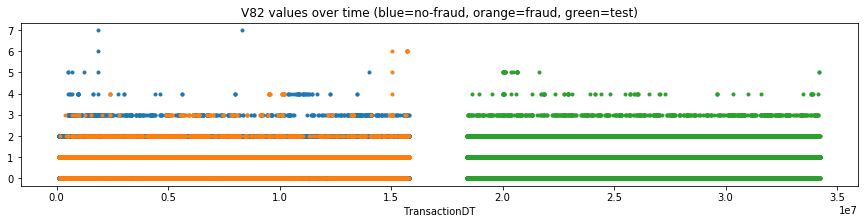

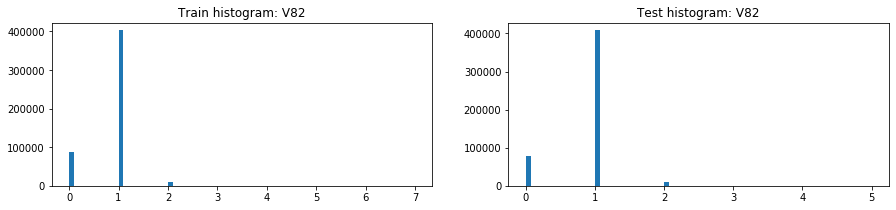

V82          Train   Train fraud  Train Not fraud  \
0           count  501376.000000  16387.000000    484989.000000   
1            mean       0.844610      0.962104         0.840640   
2             std       0.422529      0.490821         0.419453   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       7.000000      6.000000         7.000000   
8   unique values       9.000000      8.000000         9.000000   
9            NaNs   89164.000000   4276.000000     84888.000000   
10     NaNs share       0.151000      0.206900         0.149000   

             Test   Test public   Test private  
0   494610.000000  94022.000000  400589.000000  
1        0.864429      0.841420       0.869829  
2        0.403460      0.431988       0.396273  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7        5.000000      5.000000       5.000000  
8        7.000000      7.000000       7.000000  
9    12081.000000   7317.000000    4764.000000  
10       0.023800      0.072200       0.011800

V82  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 402612     0.032736       13180       407790.0
1 -999.0                  89164     0.047957        4276        12081.0
2    0.0                  88757     0.022759        2020        77355.0
3    2.0                   9288     0.109496        1017         8745.0
4    3.0                    626     0.228435         143          629.0
5    4.0                     76     0.250000          19           67.0
6    6.0                      8     0.875000           7            NaN
7    5.0                      7     0.142857           1           24.0
8    7.0                      2     0.000000           0            NaN

V82  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          402612     0.032736              13180       407790.0
1 -999.0           89164     0.047957               4276        12081.0
2    0.0           88757     0.022759               2020        77355.0
3    2.0            9288     0.109496               1017         8745.0
4    3.0             626     0.228435                143          629.0
5    4.0              76     0.250000                 19           67.0
6    6.0               8     0.875000                  7            NaN
7    5.0               7     0.142857                  1           24.0
8    7.0               2     0.000000                  0            NaN

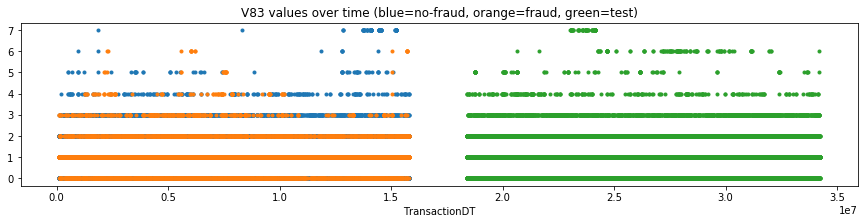

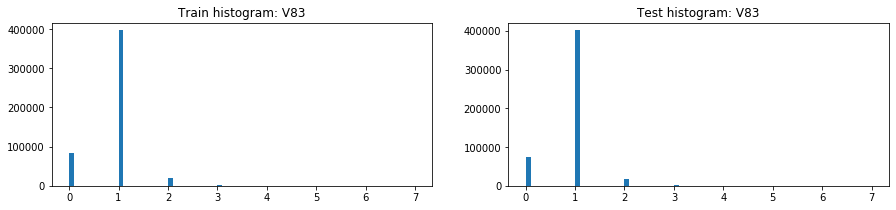

V83          Train   Train fraud  Train Not fraud  \
0           count  501376.000000  16387.000000    484989.000000   
1            mean       0.881965      1.059071         0.875981   
2             std       0.470757      0.621182         0.463645   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       7.000000      6.000000         7.000000   
8   unique values       9.000000      8.000000         9.000000   
9            NaNs   89164.000000   4276.000000     84888.000000   
10     NaNs share       0.151000      0.206900         0.149000   

             Test   Test public   Test private  
0   494610.000000  94022.000000  400589.000000  
1        0.896656      0.876486       0.901390  
2        0.454836      0.477224       0.449288  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7        7.000000      6.000000       7.000000  
8        9.000000      8.000000       9.000000  
9    12081.000000   7317.000000    4764.000000  
10       0.023800      0.072200       0.011800

V83  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 396619     0.031857       12635         400827
1 -999.0                  89164     0.047957        4276          12081
2    0.0                  83605     0.020920        1749          74121
3    2.0                  18834     0.077785        1465          17393
4    3.0                   1816     0.226872         412           1709
5    4.0                    292     0.318493          93            286
6    7.0                    109     0.000000           0             64
7    5.0                     76     0.210526          16             97
8    6.0                     25     0.680000          17            113

V83  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          396619     0.031857              12635         400827
1 -999.0           89164     0.047957               4276          12081
2    0.0           83605     0.020920               1749          74121
3    2.0           18834     0.077785               1465          17393
4    3.0            1816     0.226872                412           1709
5    4.0             292     0.318493                 93            286
6    6.0              25     0.680000                 17            113
7    5.0              76     0.210526                 16             97
8    7.0             109     0.000000                  0             64

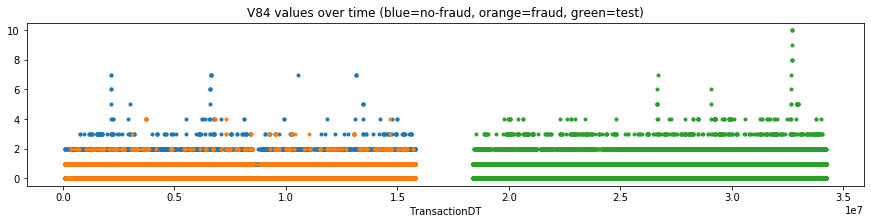

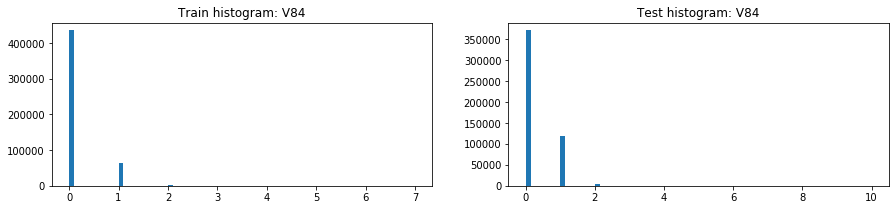

V84          Train   Train fraud  Train Not fraud  \
0           count  501376.000000  16387.000000    484989.000000   
1            mean       0.137145      0.470068         0.125896   
2             std       0.361875      0.554162         0.348039   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max       7.000000      4.000000         7.000000   
8   unique values       9.000000      6.000000         9.000000   
9            NaNs   89164.000000   4276.000000     84888.000000   
10     NaNs share       0.151000      0.206900         0.149000   

             Test   Test public   Test private  
0   494610.000000  94022.000000  400589.000000  
1        0.258139      0.121206       0.290278  
2        0.463071      0.349349       0.480298  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       1.000000  
7       10.000000      4.000000      10.000000  
8       12.000000      6.000000      12.000000  
9    12081.000000   7317.000000    4764.000000  
10       0.023800      0.072200       0.011800

V84  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 435246     0.020910        9101         371522
1 -999.0                  89164     0.047957        4276          12081
2    1.0                  63848     0.108335        6917         119235
3    2.0                   2035     0.162654         331           3307
4    3.0                    191     0.146597          28            426
5    4.0                     35     0.285714          10             84
6    7.0                     10     0.000000           0              2
7    5.0                      6     0.000000           0             24
8    6.0                      5     0.000000           0              3

V84  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          435246     0.020910               9101         371522
1    1.0           63848     0.108335               6917         119235
2 -999.0           89164     0.047957               4276          12081
3    2.0            2035     0.162654                331           3307
4    3.0             191     0.146597                 28            426
5    4.0              35     0.285714                 10             84
6    7.0              10     0.000000                  0              2
7    5.0               6     0.000000                  0             24
8    6.0               5     0.000000                  0              3

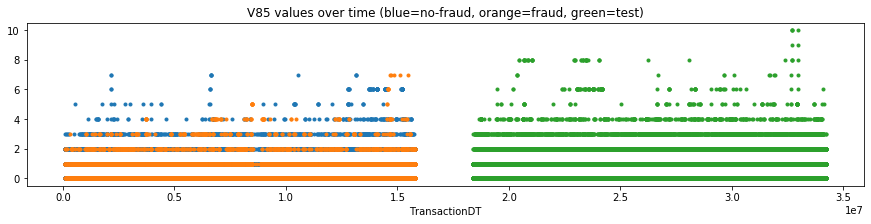

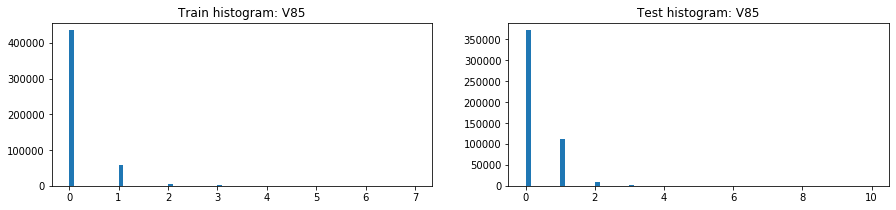

V85          Train   Train fraud  Train Not fraud  \
0           count  501376.000000  16387.000000    484989.000000   
1            mean       0.149788      0.535058         0.136770   
2             std       0.419445      0.707608         0.399721   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max       7.000000      7.000000         7.000000   
8   unique values       9.000000      9.000000         9.000000   
9            NaNs   89164.000000   4276.000000     84888.000000   
10     NaNs share       0.151000      0.206900         0.149000   

             Test   Test public   Test private  
0   494610.000000  94022.000000  400589.000000  
1        0.279501      0.138446       0.312607  
2        0.535078      0.434581       0.550831  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       1.000000  
7       10.000000      8.000000      10.000000  
8       12.000000     10.000000      12.000000  
9    12081.000000   7317.000000    4764.000000  
10       0.023800      0.072200       0.011800

V85  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 435103     0.020862        9077         371150
1 -999.0                  89164     0.047957        4276          12081
2    1.0                  59565     0.105381        6277         112615
3    2.0                   5322     0.138106         735           8175
4    3.0                    987     0.207700         205           1937
5    4.0                    216     0.342593          74            481
6    6.0                    121     0.041322           5            104
7    5.0                     47     0.191489           9             87
8    7.0                     15     0.333333           5             13

V85  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          435103     0.020862               9077         371150
1    1.0           59565     0.105381               6277         112615
2 -999.0           89164     0.047957               4276          12081
3    2.0            5322     0.138106                735           8175
4    3.0             987     0.207700                205           1937
5    4.0             216     0.342593                 74            481
6    5.0              47     0.191489                  9             87
7    6.0             121     0.041322                  5            104
8    7.0              15     0.333333                  5             13

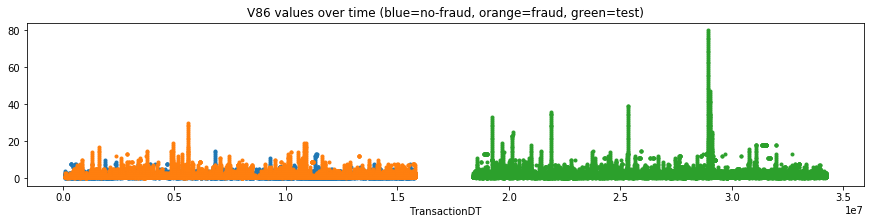

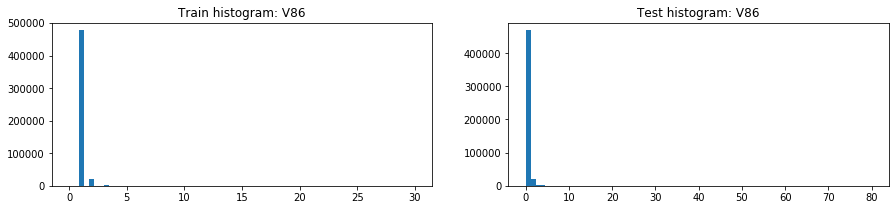

V86          Train   Train fraud  Train Not fraud  \
0           count  501376.000000  16387.000000    484989.000000   
1            mean       1.064885      1.640020         1.045453   
2             std       0.419807      1.737494         0.261994   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max      30.000000     30.000000        15.000000   
8   unique values      32.000000     32.000000        17.000000   
9            NaNs   89164.000000   4276.000000     84888.000000   
10     NaNs share       0.151000      0.206900         0.149000   

             Test   Test public   Test private  
0   494610.000000  94022.000000  400589.000000  
1        1.092463      1.094457       1.091995  
2        0.896628      0.683657       0.939644  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       80.000000     33.000000      80.000000  
8       82.000000     35.000000      82.000000  
9    12081.000000   7317.000000    4764.000000  
10       0.023800      0.072200       0.011800

V86  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 476911     0.025766       12288         467922
1 -999.0                  89164     0.047957        4276          12081
2    2.0                  19527     0.095355        1862          21070
3    3.0                   2428     0.358320         870           2684
4    4.0                    743     0.675639         502           1112
5    0.0                    727     0.070151          51            338
6    5.0                    355     0.678873         241            317
7    6.0                    217     0.764977         166            255
8    7.0                    128     0.929688         119            129
9    8.0                     86     0.697674          60             94

V86  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          476911     0.025766              12288         467922
1 -999.0           89164     0.047957               4276          12081
2    2.0           19527     0.095355               1862          21070
3    3.0            2428     0.358320                870           2684
4    4.0             743     0.675639                502           1112
5    5.0             355     0.678873                241            317
6    6.0             217     0.764977                166            255
7    7.0             128     0.929688                119            129
8    9.0              79     0.936709                 74             75
9    8.0              86     0.697674                 60             94

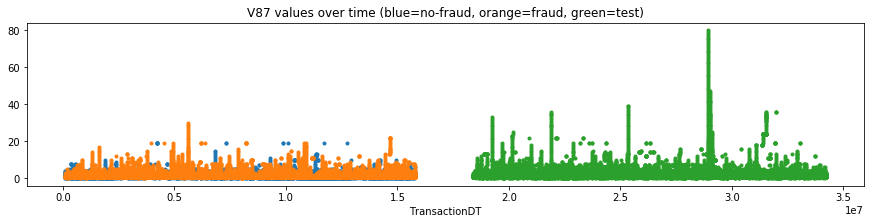

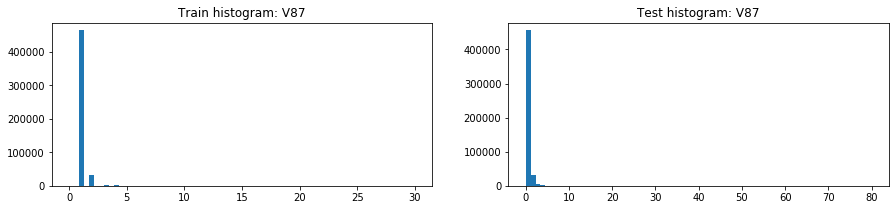

V87          Train   Train fraud  Train Not fraud  \
0           count  501376.000000  16387.000000    484989.000000   
1            mean       1.099456      1.799658         1.075798   
2             std       0.511281      2.020390         0.339411   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      2.000000         1.000000   
7             max      30.000000     30.000000        19.000000   
8   unique values      32.000000     32.000000        18.000000   
9            NaNs   89164.000000   4276.000000     84888.000000   
10     NaNs share       0.151000      0.206900         0.149000   

             Test   Test public   Test private  
0   494610.000000  94022.000000  400589.000000  
1        1.131732      1.134298       1.131129  
2        0.989353      0.747773       1.037937  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7       80.000000     33.000000      80.000000  
8       82.000000     35.000000      82.000000  
9    12081.000000   7317.000000    4764.000000  
10       0.023800      0.072200       0.011800

V87  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 463708     0.024893       11543         455162
1 -999.0                  89164     0.047957        4276          12081
2    2.0                  30832     0.072490        2235          31444
3    3.0                   3761     0.248338         934           4209
4    4.0                   1033     0.620523         641           1299
5    0.0                    694     0.053314          37            328
6    5.0                    480     0.585417         281            482
7    6.0                    205     0.741463         152            349
8    7.0                    148     0.905405         134            338
9    8.0                    147     0.795918         117            170

V87  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          463708     0.024893              11543         455162
1 -999.0           89164     0.047957               4276          12081
2    2.0           30832     0.072490               2235          31444
3    3.0            3761     0.248338                934           4209
4    4.0            1033     0.620523                641           1299
5    5.0             480     0.585417                281            482
6    6.0             205     0.741463                152            349
7    7.0             148     0.905405                134            338
8    8.0             147     0.795918                117            170
9    9.0              75     0.906667                 68             95

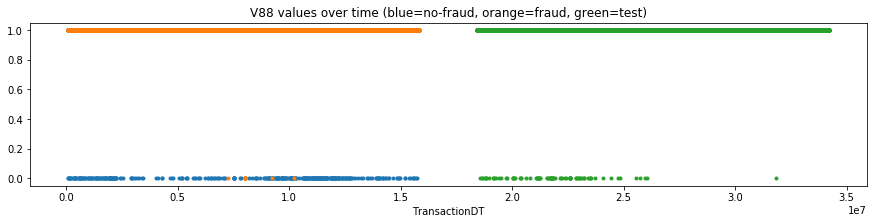

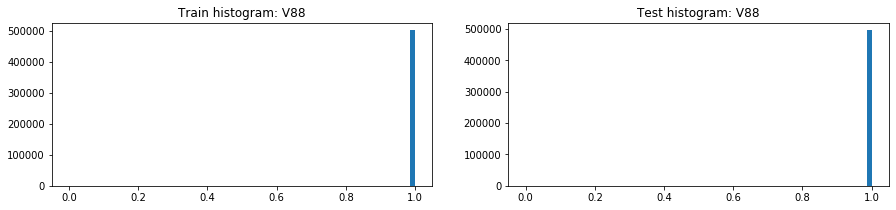

V88          Train   Train fraud  Train Not fraud  \
0           count  501376.000000  16387.000000    484989.000000   
1            mean       0.999246      0.999329         0.999243   
2             std       0.027447      0.025901         0.027498   
3             min       0.000000      0.000000         0.000000   
4             25%       1.000000      1.000000         1.000000   
5             50%       1.000000      1.000000         1.000000   
6             75%       1.000000      1.000000         1.000000   
7             max       1.000000      1.000000         1.000000   
8   unique values       3.000000      3.000000         3.000000   
9            NaNs   89164.000000   4276.000000     84888.000000   
10     NaNs share       0.151000      0.206900         0.149000   

             Test   Test public   Test private  
0   494610.000000  94022.000000  400589.000000  
1        0.999830      0.999521       0.999903  
2        0.013031      0.021872       0.009866  
3        0.000000      0.000000       0.000000  
4        1.000000      1.000000       1.000000  
5        1.000000      1.000000       1.000000  
6        1.000000      1.000000       1.000000  
7        1.000000      1.000000       1.000000  
8        3.000000      3.000000       3.000000  
9    12081.000000   7317.000000    4764.000000  
10       0.023800      0.072200       0.011800

V88  Count in train (desc)  Mean target  Sum target  Count in test
0    1.0                 500998     0.032687       16376         494526
1 -999.0                  89164     0.047957        4276          12081
2    0.0                    378     0.029101          11             84

V88  Count in train  Mean target  Sum target (desc)  Count in test
0    1.0          500998     0.032687              16376         494526
1 -999.0           89164     0.047957               4276          12081
2    0.0             378     0.029101                 11             84

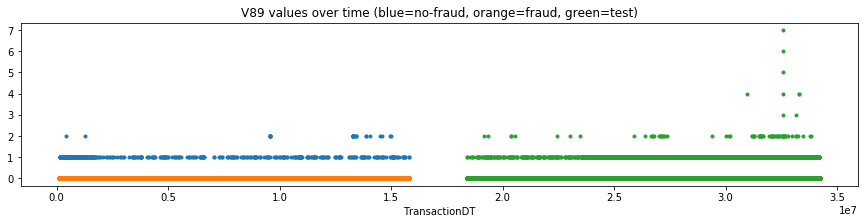

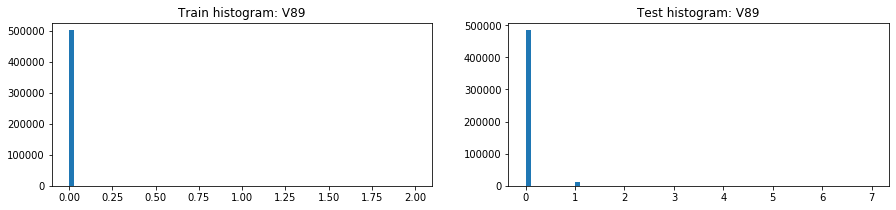

V89          Train  Train fraud  Train Not fraud           Test  \
0           count  501376.000000   16387.0000    484989.000000  494610.000000   
1            mean       0.000902       0.0000         0.000932       0.022771   
2             std       0.031943       0.0000         0.032478       0.151194   
3             min       0.000000       0.0000         0.000000       0.000000   
4             25%       0.000000       0.0000         0.000000       0.000000   
5             50%       0.000000       0.0000         0.000000       0.000000   
6             75%       0.000000       0.0000         0.000000       0.000000   
7             max       2.000000       0.0000         2.000000       7.000000   
8   unique values       4.000000       2.0000         4.000000       9.000000   
9            NaNs   89164.000000    4276.0000     84888.000000   12081.000000   
10     NaNs share       0.151000       0.2069         0.149000       0.023800   

     Test public   Test private  
0   94022.000000  400589.000000  
1       0.001266       0.027819  
2       0.037019       0.166641  
3       0.000000       0.000000  
4       0.000000       0.000000  
5       0.000000       0.000000  
6       0.000000       0.000000  
7       2.000000       7.000000  
8       4.000000       9.000000  
9    7317.000000    4764.000000  
10      0.072200       0.011800

V89  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 500954     0.032712       16387         483452
1 -999.0                  89164     0.047957        4276          12081
2    1.0                    392     0.000000           0          11075
3    2.0                     30     0.000000           0             74

V89  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          500954     0.032712              16387         483452
1 -999.0           89164     0.047957               4276          12081
2    1.0             392     0.000000                  0          11075
3    2.0              30     0.000000                  0             74

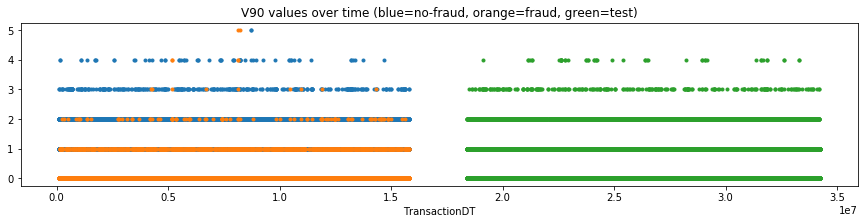

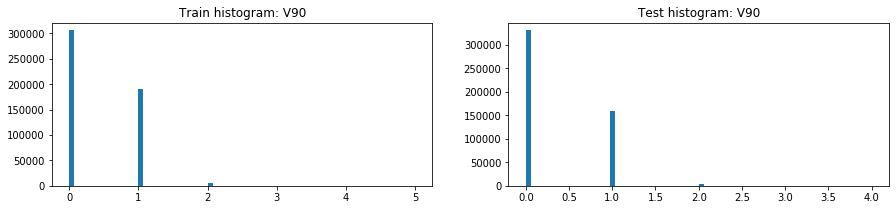

V90          Train   Train fraud  Train Not fraud  \
0           count  501376.000000  16387.000000    484989.000000   
1            mean       0.401862      0.092512         0.412315   
2             std       0.516153      0.322831         0.518220   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       1.000000      0.000000         1.000000   
7             max       5.000000      5.000000         5.000000   
8   unique values       7.000000      7.000000         7.000000   
9            NaNs   89164.000000   4276.000000     84888.000000   
10     NaNs share       0.151000      0.206900         0.149000   

             Test   Test public   Test private  
0   494610.000000  94022.000000  400589.000000  
1        0.340953      0.412669       0.324123  
2        0.494283      0.516688       0.487351  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        1.000000      1.000000       1.000000  
7        4.000000      4.000000       4.000000  
8        6.000000      6.000000       6.000000  
9    12081.000000   7317.000000    4764.000000  
10       0.023800      0.072200       0.011800

V90  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 305817     0.049062       15004       330402.0
1    1.0                 190162     0.006694        1273       160149.0
2 -999.0                  89164     0.047957        4276        12081.0
3    2.0                   4941     0.019227          95         3734.0
4    3.0                    388     0.023196           9          278.0
5    4.0                     64     0.062500           4           47.0
6    5.0                      4     0.500000           2            NaN

V90  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          305817     0.049062              15004       330402.0
1 -999.0           89164     0.047957               4276        12081.0
2    1.0          190162     0.006694               1273       160149.0
3    2.0            4941     0.019227                 95         3734.0
4    3.0             388     0.023196                  9          278.0
5    4.0              64     0.062500                  4           47.0
6    5.0               4     0.500000                  2            NaN

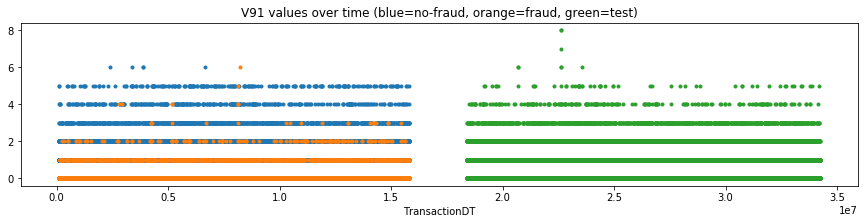

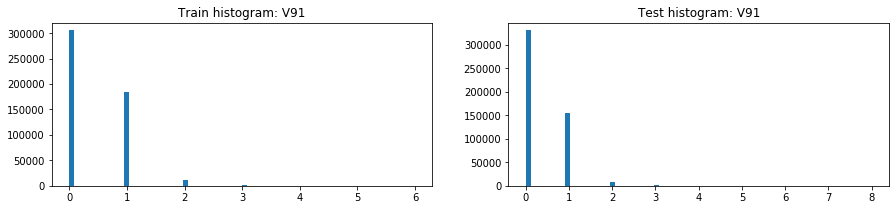

V91          Train   Train fraud  Train Not fraud  \
0           count  501376.000000  16387.000000    484989.000000   
1            mean       0.420461      0.098127         0.431352   
2             std       0.561865      0.349208         0.564455   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       1.000000      0.000000         1.000000   
7             max       6.000000      6.000000         6.000000   
8   unique values       8.000000      8.000000         8.000000   
9            NaNs   89164.000000   4276.000000     84888.000000   
10     NaNs share       0.151000      0.206900         0.149000   

             Test   Test public   Test private  
0   494610.000000  94022.000000  400589.000000  
1        0.356810      0.432027       0.339158  
2        0.534183      0.559849       0.526424  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        1.000000      1.000000       1.000000  
7        8.000000      6.000000       8.000000  
8       10.000000      8.000000      10.000000  
9    12081.000000   7317.000000    4764.000000  
10       0.023800      0.072200       0.011800

V91  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 305135     0.049159       15000         329824
1    1.0                 184121     0.006539        1204         154755
2 -999.0                  89164     0.047957        4276          12081
3    2.0                  10470     0.014900         156           8720
4    3.0                   1086     0.017495          19           1035
5    4.0                    336     0.017857           6            211
6    5.0                    222     0.004505           1             57
7    6.0                      6     0.166667           1              5

V91  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          305135     0.049159              15000         329824
1 -999.0           89164     0.047957               4276          12081
2    1.0          184121     0.006539               1204         154755
3    2.0           10470     0.014900                156           8720
4    3.0            1086     0.017495                 19           1035
5    4.0             336     0.017857                  6            211
6    5.0             222     0.004505                  1             57
7    6.0               6     0.166667                  1              5

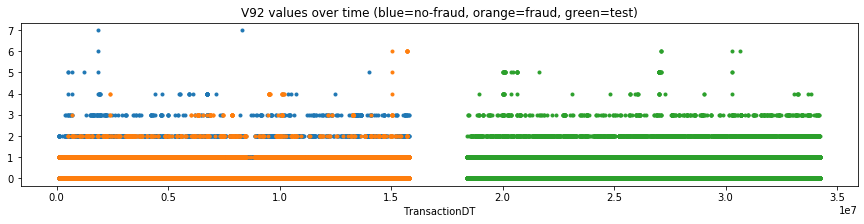

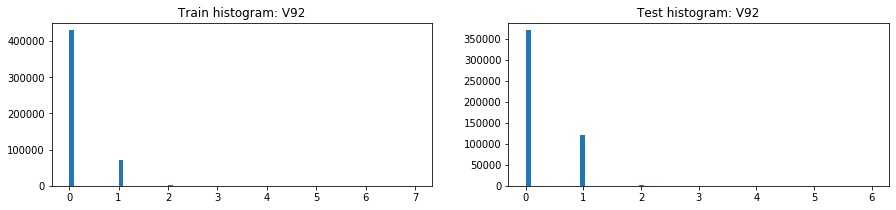

V92          Train   Train fraud  Train Not fraud  \
0           count  501376.000000  16387.000000    484989.000000   
1            mean       0.150322      0.519253         0.137857   
2             std       0.375682      0.609271         0.358622   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max       7.000000      6.000000         7.000000   
8   unique values       9.000000      8.000000         9.000000   
9            NaNs   89164.000000   4276.000000     84888.000000   
10     NaNs share       0.151000      0.206900         0.149000   

             Test   Test public   Test private  
0   494610.000000  94022.000000  400589.000000  
1        0.259865      0.127300       0.290979  
2        0.460140      0.361654       0.475008  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        1.000000      0.000000       1.000000  
7        6.000000      5.000000       6.000000  
8        8.000000      7.000000       8.000000  
9    12081.000000   7317.000000    4764.000000  
10       0.023800      0.072200       0.011800

V92  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 428699     0.020161        8643       370042.0
1 -999.0                  89164     0.047957        4276        12081.0
2    1.0                  70511     0.101346        7146       121235.0
3    2.0                   1744     0.271216         473         2844.0
4    3.0                    348     0.281609          98          401.0
5    4.0                     57     0.333333          19           39.0
6    6.0                      8     0.875000           7            5.0
7    5.0                      7     0.142857           1           44.0
8    7.0                      2     0.000000           0            NaN

V92  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          428699     0.020161               8643       370042.0
1    1.0           70511     0.101346               7146       121235.0
2 -999.0           89164     0.047957               4276        12081.0
3    2.0            1744     0.271216                473         2844.0
4    3.0             348     0.281609                 98          401.0
5    4.0              57     0.333333                 19           39.0
6    6.0               8     0.875000                  7            5.0
7    5.0               7     0.142857                  1           44.0
8    7.0               2     0.000000                  0            NaN

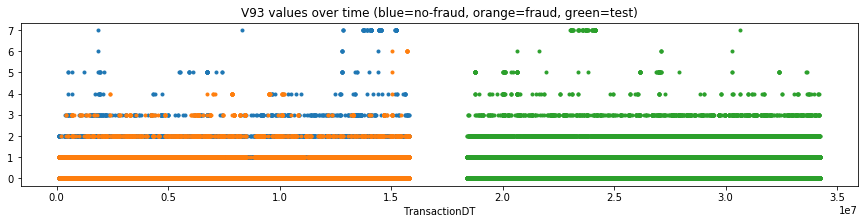

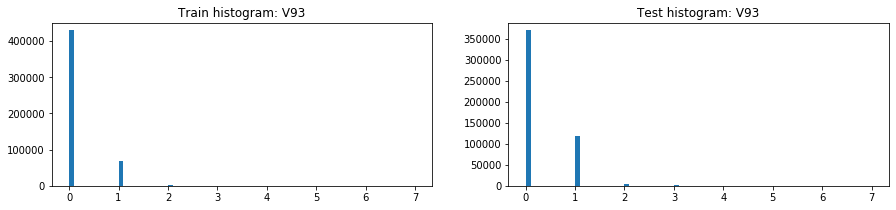

V93          Train   Train fraud  Train Not fraud  \
0           count  501376.000000  16387.000000    484989.000000   
1            mean       0.154812      0.550925         0.141428   
2             std       0.402314      0.671300         0.382908   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max       7.000000      6.000000         7.000000   
8   unique values       9.000000      8.000000         9.000000   
9            NaNs   89164.000000   4276.000000     84888.000000   
10     NaNs share       0.151000      0.206900         0.149000   

             Test   Test public   Test private  
0   494610.000000  94022.000000  400589.000000  
1        0.266691      0.132395       0.298211  
2        0.485723      0.387364       0.500855  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        1.000000      0.000000       1.000000  
7        7.000000      6.000000       7.000000  
8        9.000000      8.000000       9.000000  
9    12081.000000   7317.000000    4764.000000  
10       0.023800      0.072200       0.011800

V93  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 428694     0.020157        8641         370007
1 -999.0                  89164     0.047957        4276          12081
2    1.0                  69196     0.097824        6769         118930
3    2.0                   2682     0.271439         728           4593
4    3.0                    556     0.374101         208            819
5    7.0                    109     0.000000           0             65
6    4.0                     80     0.412500          33            106
7    5.0                     46     0.021739           1             84
8    6.0                     13     0.538462           7              6

V93  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          428694     0.020157               8641         370007
1    1.0           69196     0.097824               6769         118930
2 -999.0           89164     0.047957               4276          12081
3    2.0            2682     0.271439                728           4593
4    3.0             556     0.374101                208            819
5    4.0              80     0.412500                 33            106
6    6.0              13     0.538462                  7              6
7    5.0              46     0.021739                  1             84
8    7.0             109     0.000000                  0             65

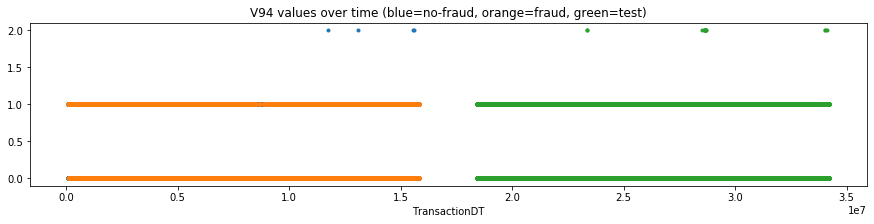

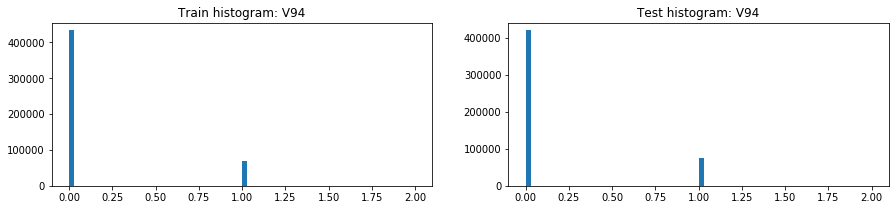

V94          Train   Train fraud  Train Not fraud  \
0           count  501376.000000  16387.000000    484989.000000   
1            mean       0.137007      0.489473         0.125098   
2             std       0.343878      0.499904         0.330855   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max       2.000000      1.000000         2.000000   
8   unique values       4.000000      3.000000         4.000000   
9            NaNs   89164.000000   4276.000000     84888.000000   
10     NaNs share       0.151000      0.206900         0.149000   

             Test   Test public   Test private  
0   494610.000000  94022.000000  400589.000000  
1        0.152702      0.117802       0.160893  
2        0.359779      0.322375       0.367528  
3        0.000000      0.000000       0.000000  
4        0.000000      0.000000       0.000000  
5        0.000000      0.000000       0.000000  
6        0.000000      0.000000       0.000000  
7        2.000000      1.000000       2.000000  
8        4.000000      3.000000       4.000000  
9    12081.000000   7317.000000    4764.000000  
10       0.023800      0.072200       0.011800

V94  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 432688     0.019335        8366         419096
1 -999.0                  89164     0.047957        4276          12081
2    1.0                  68684     0.116781        8021          75500
3    2.0                      4     0.000000           0             14

V94  Count in train  Mean target  Sum target (desc)  Count in test
0    0.0          432688     0.019335               8366         419096
1    1.0           68684     0.116781               8021          75500
2 -999.0           89164     0.047957               4276          12081
3    2.0               4     0.000000                  0             14

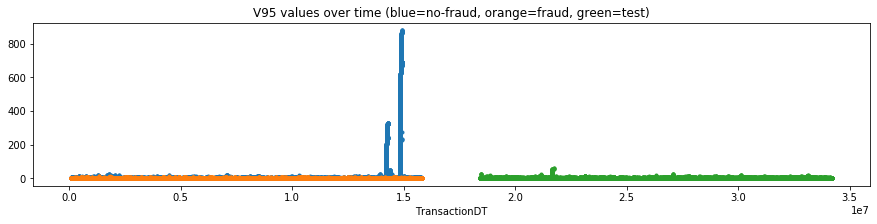

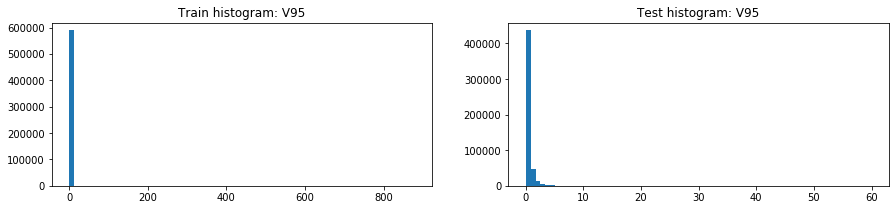

V95          Train   Train fraud  Train Not fraud  \
0           count  590226.000000  20646.000000    569580.000000   
1            mean       1.038019      0.582873         1.054517   
2             std      21.034304      1.239608        21.410652   
3             min       0.000000      0.000000         0.000000   
4             25%       0.000000      0.000000         0.000000   
5             50%       0.000000      0.000000         0.000000   
6             75%       0.000000      1.000000         0.000000   
7             max     880.000000     13.000000       880.000000   
8   unique values     882.000000     15.000000       882.000000   
9            NaNs     314.000000     17.000000       297.000000   
10     NaNs share       0.000500      0.000800         0.000500   

             Test    Test public   Test private  
0   506691.000000  101339.000000  405353.000000  
1        0.231695       0.270952       0.221881  
2        0.859311       1.210804       0.745671  
3        0.000000       0.000000       0.000000  
4        0.000000       0.000000       0.000000  
5        0.000000       0.000000       0.000000  
6        0.000000       0.000000       0.000000  
7       60.000000      60.000000      27.000000  
8       61.000000      61.000000      28.000000  
9        0.000000       0.000000       0.000000  
10       0.000000       0.000000       0.000000

V95  Count in train (desc)  Mean target  Sum target  Count in test
0    0.0                 510542     0.028568       14585       436511.0
1    1.0                  52008     0.063740        3315        46915.0
2    2.0                  14804     0.089976        1332        13276.0
3    3.0                   5758     0.112365         647         4986.0
4    4.0                   2646     0.125472         332         2330.0
5    5.0                   1281     0.135831         174         1116.0
6    6.0                    684     0.141813          97          578.0
7    7.0                    411     0.163017          67          322.0
8 -999.0                    314     0.054140          17            NaN
9    8.0                    239     0.184100          44          196.0

V95  Count in train  Mean target  Sum target (desc)  Count in test
0  0.0          510542     0.028568              14585         436511
1  1.0           52008     0.063740               3315          46915
2  2.0           14804     0.089976               1332          13276
3  3.0            5758     0.112365                647           4986
4  4.0            2646     0.125472                332           2330
5  5.0            1281     0.135831                174           1116
6  6.0             684     0.141813                 97            578
7  7.0             411     0.163017                 67            322
8  8.0             239     0.184100                 44            196
9  9.0             167     0.191617                 32            119

In [4]:
for col in list(tr.columns.values[:COLS_TO_SHOW]):
    proc(col)